In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
from tqdm.autonotebook import tqdm

from xhistogram.xarray import histogram

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina'

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [2]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_3hr_pr = df[(df.table_id == 'day') & (df.variable_id == 'pr')]
df_3hr_pr.groupby(['experiment_id', 'source_id'])['zstore'].count()
run_counts = df_3hr_pr.groupby(['source_id', 'experiment_id'])['zstore'].count()

/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
source_ids = []
experiment_ids = ['historical', 'ssp585']
for name, group in df_3hr_pr.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        source_ids.append(name)
source_ids


['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'BCC-CSM2-MR',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CMCC-CM2-SR5',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'EC-Earth3',
 'EC-Earth3-Veg',
 'FGOALS-g3',
 'GFDL-CM4',
 'GFDL-ESM4',
 'HadGEM3-GC31-LL',
 'HadGEM3-GC31-MM',
 'IITM-ESM',
 'INM-CM4-8',
 'INM-CM5-0',
 'IPSL-CM6A-LR',
 'KACE-1-0-G',
 'KIOST-ESM',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NorESM2-LM',
 'NorESM2-MM',
 'TaiESM1',
 'UKESM1-0-LL']

In [4]:
def load_pr_data(source_id, expt_id):
    """
    Load 3hr precip data for given source and expt ids
    """
    uri = df_3hr_pr[(df_3hr_pr.source_id == source_id) &
                         (df_3hr_pr.experiment_id == expt_id)].zstore.values[0]
    
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds


In [5]:
def precip_ts(ds, nbins=100, pr_log_min=-3, pr_log_max=2):
    """
    Calculate precipitation histogram for a single model. 
    Lazy.
    """
    assert ds.pr.units == 'kg m-2 s-1'
    
    # mm/day
    ds_ts = ds.mean(dim=['lon','lat'])
    
    return ds_ts

def precip_ts_for_expts(dsets, experiment_ids):
    """
    Calculate histogram for a suite of experiments.
    Eager.
    """
    # actual data loading and computations happen in this next line
    pr_hists = [precip_ts(ds).load()
            for ds in [ds_hist, ds_ssp1, ds_ssp2]]
   # pr_hist = xr.concat(pr_hists, dim=xr.Variable('experiment_id', experiment_ids))
    
    return pr_hists[0], pr_hists[1], pr_hists[2]


In [6]:
# hist_results = {}
# ssp_results = {}
# for source_id in tqdm(source_ids):
#     # get a 20 year period
#     ds_hist = load_pr_data(source_id, 'historical').sel(time=slice('1970', '2000')).sel(lat=slice(5,9)).sel(lon=slice(36,38))
#     ds_ssp = load_pr_data(source_id, 'ssp585').sel(time=slice('2070', '2100')).sel(lat=slice(5,9)).sel(lon=slice(36,38))
#     pr_hist1, pr_hist2 = precip_ts_for_expts([ds_hist, ds_ssp], experiment_ids)
#     hist_results[source_id] = pr_hist1
#     ssp_results[source_id] = pr_hist2


## SSP585

In [7]:
hist_ssp585 = {}
ssp_ssp585_lc = {}
ssp_ssp585_mc = {}
for source_id in tqdm(source_ids):
    # get a 20 year period
    ds_hist = load_pr_data(source_id, 'historical').sel(time=slice('1970', '2000')).sel(lat=slice(5,9)).sel(lon=slice(36,38))
    ds_ssp1 = load_pr_data(source_id, 'ssp126').sel(time=slice('2070', '2100')).sel(lat=slice(5,9)).sel(lon=slice(36,38))
    ds_ssp2 = load_pr_data(source_id, 'ssp126').sel(time=slice('2040', '2070')).sel(lat=slice(5,9)).sel(lon=slice(36,38))
    pr_hist1, pr_hist2,pr_hist3 = precip_ts_for_expts([ds_hist, ds_ssp1, ds_ssp2], experiment_ids)
    hist_ssp585[source_id] = pr_hist1
    ssp_ssp585_lc[source_id] = pr_hist2
    ssp_ssp585_mc[source_id]= pr_hist3


IndexError: index 0 is out of bounds for axis 0 with size 0

In [29]:
for source_id in tqdm(['GFDL-ESM4','HadGEM3-GC31-LL','HadGEM3-GC31-MM','IITM-ESM','INM-CM4-8','INM-CM5-0', 'IPSL-CM6A-LR','KACE-1-0-G','KIOST-ESM','MIROC-ES2L','MIROC6','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','NorESM2-LM','NorESM2-MM','TaiESM1','UKESM1-0-LL']):
    ds_hist = load_pr_data(source_id, 'historical').sel(time=slice('1970', '2000')).sel(lat=slice(5,9)).sel(lon=slice(36,38))
    ds_ssp1 = load_pr_data(source_id, 'ssp126').sel(time=slice('2070', '2100')).sel(lat=slice(5,9)).sel(lon=slice(36,38))
    ds_ssp2 = load_pr_data(source_id, 'ssp126').sel(time=slice('2040', '2070')).sel(lat=slice(5,9)).sel(lon=slice(36,38))
    pr_hist1, pr_hist2,pr_hist3 = precip_ts_for_expts([ds_hist, ds_ssp1, ds_ssp2], experiment_ids)
    hist_ssp585[source_id] = pr_hist1
    ssp_ssp585_lc[source_id] = pr_hist2
    ssp_ssp585_mc[source_id]= pr_hist3

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/tim

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
writeCsvs(hist_ssp585,ssp_ssp585_lc,ssp_ssp585_mc,"ssp585")

In [ ]:
def cdf(x, lab, plot=True, *args, **kwargs):
    x, y = sorted(x), np.arange(len(x)) / len(x)
    return plt.plot(x, y, label = lab, *args, **kwargs) if plot else (x, y)

In [ ]:
for (source_id, pr_hist), (source_id, pr_ssp_lc),(source_id, pr_ssp_mc) in zip(hist_ssp585.items(), ssp_ssp585_lc.items(), ssp_ssp585_mc.items()):
    pr_ssp585_lc = pd.DataFrame({'date':pr_ssp_lc.time, 'pr': pr_ssp_lc.pr * 86400})
    pr_ssp585_mc = pd.DataFrame({'date':pr_ssp_mc.time, 'pr': pr_ssp_mc.pr * 86400})
    pr_hist_585 = pd.DataFrame({'date':pr_hist.time, 'pr': pr_hist.pr * 86400})
    
    if source_id != "HadGEM3-GC31-LL":
        if source_id != "HadGEM3-GC31-MM":
            if source_id != "KACE-1-0-G":
                if source_id != "UKESM1-0-LL":
                    if pr_ssp585_lc.date.dtype == "datetime64[ns]":
                        pr_ssp585_lc['date'] = pd.to_datetime(pr_ssp585_lc['date'])
                        pr_ssp585_mc['date'] = pd.to_datetime(pr_ssp585_mc['date'])
                        pr_hist_585['date']= pd.to_datetime(pr_hist_585['date'])
                    elif pr_ssp585_lc.date.dtype == "object":
                        pr_ssp585_lc['date'] =  pr_ssp585_lc['date'].astype(str)
                        pr_ssp585_lc['date'] = pd.to_datetime(pr_ssp585_lc['date'])
                        pr_ssp585_mc['date'] =  pr_ssp585_mc['date'].astype(str)
                        pr_ssp585_mc['date'] = pd.to_datetime(pr_ssp585_mc['date'])                       
                        
                        pr_hist_585['date'] =  pr_hist_585['date'].astype(str)
                        pr_hist_585['date'] = pd.to_datetime(pr_hist_585['date'])

                    else:
                        print(source_id)
                        
                    ssp_lc = pr_ssp585_lc.groupby(pr_ssp585_lc['date'].dt.year).sum()
                    ssp_mc = pr_ssp585_mc.groupby(pr_ssp585_mc['date'].dt.year).sum()
                    hist = pr_hist_585.groupby(pr_hist_585['date'].dt.year).sum()
                    
                    cdf(pr_hist_585.pr, "hist")
                    cdf(pr_ssp585_mc.pr, "ssp585 - mid century")
                    cdf(pr_ssp585_lc.pr, "ssp585 - late century")

                    plt.legend()
                    plt.title(source_id)
                    plt.xlabel("Precip (mm)")
                    plt.ylabel("% Exceedance")
                    plt.show()
                    
                    
                    cdf(hist.pr, "hist")
                    cdf(ssp_mc.pr, "ssp585 - mid century")
                    cdf(ssp_lc.pr, "ssp585 - late century")
                    plt.legend()
                    plt.xlabel("Precip (mm)")
                    plt.ylabel("% Exceedance")
                    plt.title(source_id)
                    plt.show()

## SSP126

In [8]:
source_ids = []
experiment_ids = ['historical', 'ssp126']
for name, group in df_3hr_pr.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        source_ids.append(name)
source_ids

['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'BCC-CSM2-MR',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CMCC-CM2-SR5',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'EC-Earth3',
 'EC-Earth3-Veg',
 'FGOALS-g3',
 'GFDL-ESM4',
 'HadGEM3-GC31-LL',
 'HadGEM3-GC31-MM',
 'IITM-ESM',
 'INM-CM4-8',
 'INM-CM5-0',
 'IPSL-CM6A-LR',
 'KACE-1-0-G',
 'KIOST-ESM',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NorESM2-LM',
 'NorESM2-MM',
 'UKESM1-0-LL']

In [9]:
hist_ssp126 = {}
ssp_ssp126_lc = {}
ssp_ssp126_mc = {}
for source_id in tqdm(source_ids):
    # get a 20 year period
    ds_hist = load_pr_data(source_id, 'historical').sel(time=slice('1970', '2000')).sel(lat=slice(5,9)).sel(lon=slice(36,38))
    ds_ssp1 = load_pr_data(source_id, 'ssp126').sel(time=slice('2070', '2100')).sel(lat=slice(5,9)).sel(lon=slice(36,38))
    ds_ssp2 = load_pr_data(source_id, 'ssp126').sel(time=slice('2040', '2070')).sel(lat=slice(5,9)).sel(lon=slice(36,38))
    pr_hist1, pr_hist2,pr_hist3 = precip_ts_for_expts([ds_hist, ds_ssp1, ds_ssp2], experiment_ids)
    hist_ssp126[source_id] = pr_hist1
    ssp_ssp126_lc[source_id] = pr_hist2
    ssp_ssp126_mc[source_id]= pr_hist3

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/tim

In [14]:
def writeCsvs(historical, ssp_lc, ssp_mc,title):
    for (source_id, pr_hist), (source_id, pr_ssp_lc),(source_id, pr_ssp_mc) in zip(historical.items(), ssp_lc.items(), ssp_mc.items()):
        pr_ssp_lc = pd.DataFrame({'date':pr_ssp_lc.time, 'pr': pr_ssp_lc.pr * 86400})
        pr_ssp_mc = pd.DataFrame({'date':pr_ssp_mc.time, 'pr': pr_ssp_mc.pr * 86400})
        pr_hist = pd.DataFrame({'date':pr_hist.time, 'pr': pr_hist.pr * 86400})
        pr_ssp_lc.to_csv('pr_'+title+'_lc_'+source_id+'.csv')
        pr_ssp_mc.to_csv('pr_'+title+'_mc_'+source_id+'.csv')
        pr_hist.to_csv('pr_'+title+'_hist_'+source_id+'.csv')


In [15]:
writeCsvs(hist_ssp126,ssp_ssp126_lc,ssp_ssp126_mc,"ssp126")

## SSP245

## SSP460

In [20]:
source_ids = []
experiment_ids = ['historical', 'ssp245']
for name, group in df_3hr_pr.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        source_ids.append(name)
source_ids

['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'BCC-CSM2-MR',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CMCC-CM2-SR5',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'CanESM5',
 'EC-Earth3',
 'EC-Earth3-Veg',
 'FGOALS-g3',
 'GFDL-CM4',
 'GFDL-ESM4',
 'HadGEM3-GC31-LL',
 'IITM-ESM',
 'INM-CM4-8',
 'INM-CM5-0',
 'IPSL-CM6A-LR',
 'KACE-1-0-G',
 'KIOST-ESM',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NorESM2-LM',
 'NorESM2-MM',
 'UKESM1-0-LL']

In [23]:
hist_ssp460 = {}
ssp_ssp460_lc = {}
ssp_ssp460_mc = {}
for source_id in tqdm(source_ids):
    # get a 20 year period
    ds_hist = load_pr_data(source_id, 'historical').sel(time=slice('1970', '2000')).sel(lat=slice(5,9)).sel(lon=slice(36,38))
    ds_ssp1 = load_pr_data(source_id, 'ssp245').sel(time=slice('2070', '2100')).sel(lat=slice(5,9)).sel(lon=slice(36,38))
    ds_ssp2 = load_pr_data(source_id, 'ssp245').sel(time=slice('2040', '2070')).sel(lat=slice(5,9)).sel(lon=slice(36,38))
    pr_hist1, pr_hist2,pr_hist3 = precip_ts_for_expts([ds_hist, ds_ssp1, ds_ssp2], experiment_ids)
    hist_ssp460[source_id] = pr_hist1
    ssp_ssp460_lc[source_id] = pr_hist2
    ssp_ssp460_mc[source_id]= pr_hist3

ValueError: zero-size array to reduction operation minimum which has no identity

In [25]:
for source_id in tqdm(['MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','NorESM2-LM','NorESM2-MM','UKESM1-0-LL']):
    # get a 20 year period
    ds_hist = load_pr_data(source_id, 'historical').sel(time=slice('1970', '2000')).sel(lat=slice(5,9)).sel(lon=slice(36,38))
    ds_ssp1 = load_pr_data(source_id, 'ssp245').sel(time=slice('2070', '2100')).sel(lat=slice(5,9)).sel(lon=slice(36,38))
    ds_ssp2 = load_pr_data(source_id, 'ssp245').sel(time=slice('2040', '2070')).sel(lat=slice(5,9)).sel(lon=slice(36,38))
    pr_hist1, pr_hist2,pr_hist3 = precip_ts_for_expts([ds_hist, ds_ssp1, ds_ssp2], experiment_ids)
    hist_ssp460[source_id] = pr_hist1
    ssp_ssp460_lc[source_id] = pr_hist2
    ssp_ssp460_mc[source_id]= pr_hist3

In [26]:
writeCsvs(hist_ssp460,ssp_ssp460_lc,ssp_ssp460_mc,"ssp245")

## Figures

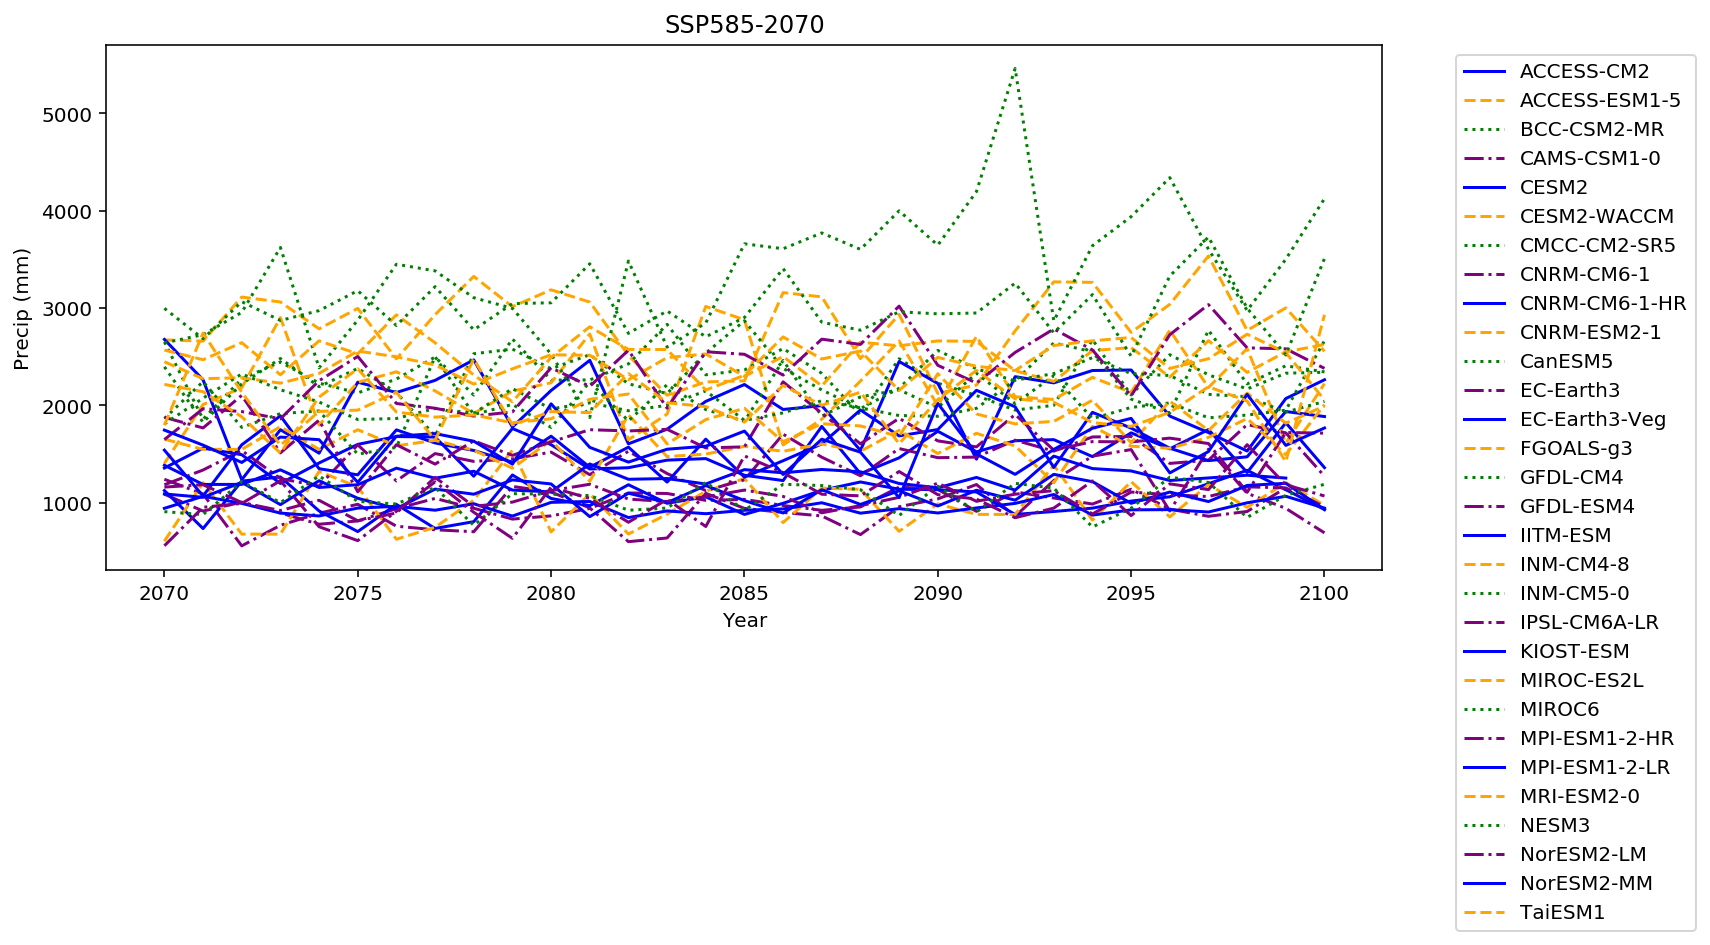

In [39]:
for (source_id, pr_hist), (source_id, pr_ssp) in zip(hist_results.items(), ssp_results.items()):
    pr_ssp2 = pd.DataFrame({'date':pr_ssp.time, 'pr': pr_ssp.pr})
    if source_id != "HadGEM3-GC31-LL":
        if source_id != "HadGEM3-GC31-MM":
            if source_id != "KACE-1-0-G":
                if source_id != "UKESM1-0-LL":
                    if pr_ssp2.date.dtype == "datetime64[ns]":
                        pr_ssp2['date'] = pd.to_datetime(pr_ssp2['date'])
                        test = pr_ssp2.groupby(pr_ssp2['date'].dt.year).sum()
                    elif pr_ssp2.date.dtype == "object":
                        pr_ssp2['date'] =  pr_ssp2['date'].astype(str)
                        pr_ssp2['date'] = pd.to_datetime(pr_ssp2['date'])
                        test = pr_ssp2.groupby(pr_ssp2['date'].dt.year).sum()
                    else:
                        print(pr_ssp2.date.dtype)

                       #  pr_ssp2['date'].to_datetimeindex()    
                    test = pr_ssp2.groupby(pr_ssp2['date'].dt.year).sum()
                    plt.plot(test.index, test.pr * 86400, label=source_id)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel("Precip (mm)")
plt.xlabel("Year")
plt.title("SSP585-2070")
plt.tight_layout()
plt.savefig("ssp585-2070.png")
plt.show()
    # plot_precip_changes(pr_hist,"hist-1970")
    


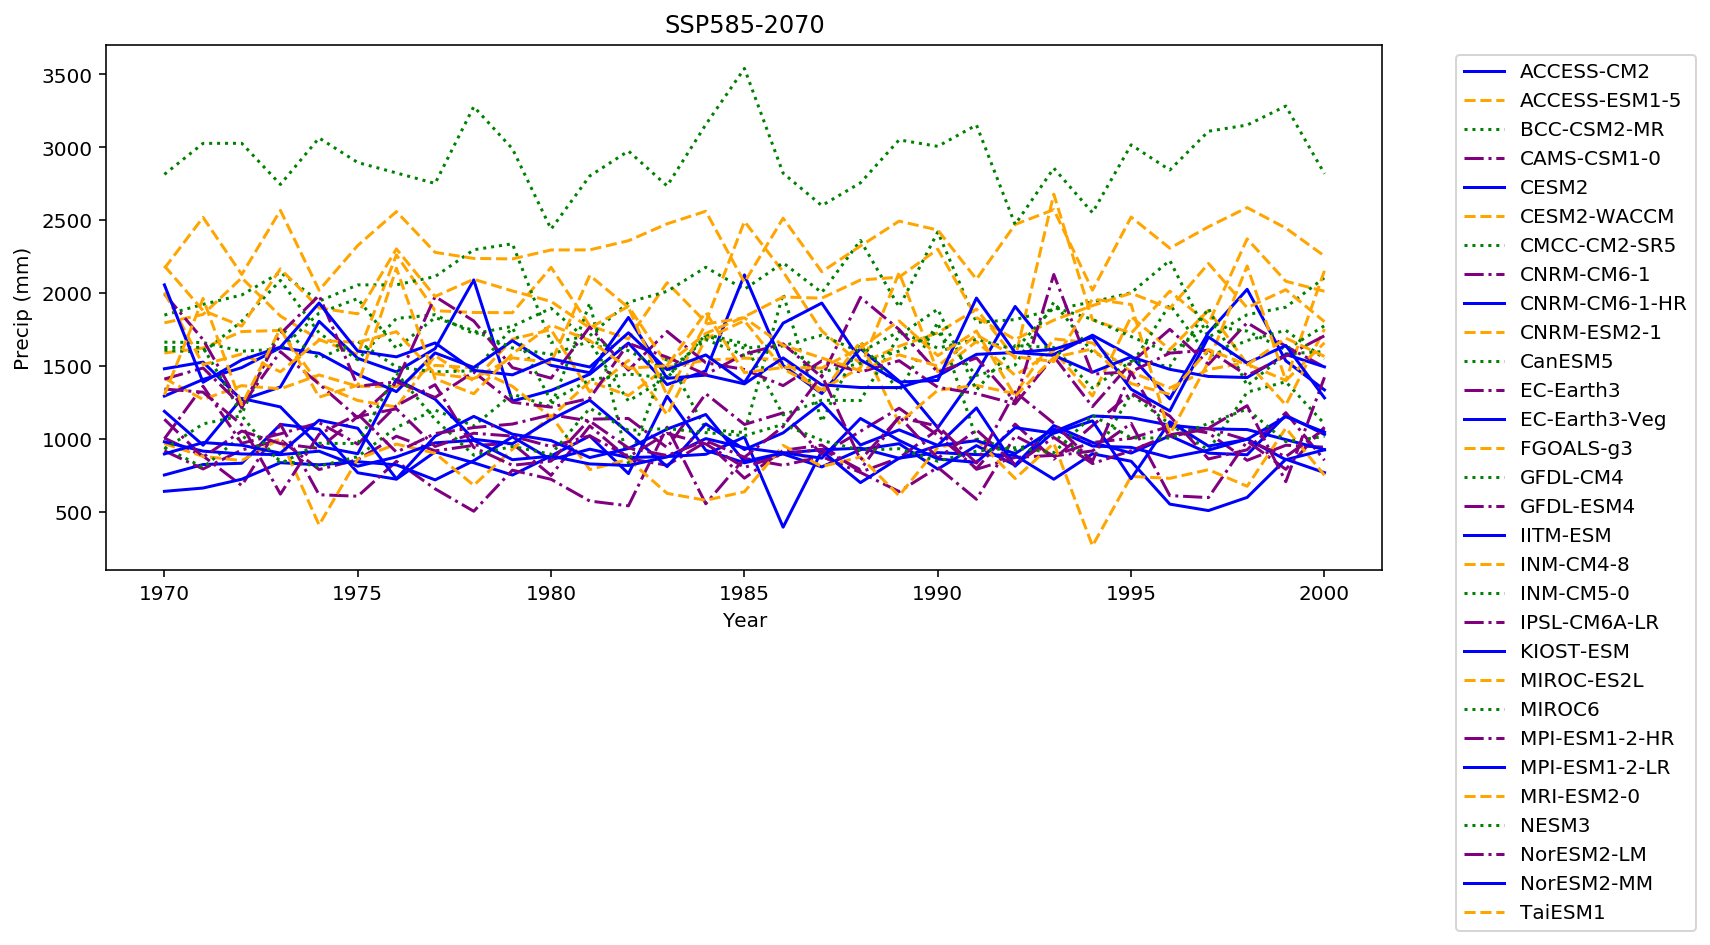

In [40]:
for (source_id, pr_hist), (source_id, pr_ssp) in zip(hist_results.items(), ssp_results.items()):
    pr_ssp2 = pd.DataFrame({'date':pr_hist.time, 'pr': pr_hist.pr})
    if source_id != "HadGEM3-GC31-LL":
        if source_id != "HadGEM3-GC31-MM":
            if source_id != "KACE-1-0-G":
                if source_id != "UKESM1-0-LL":
                    if pr_ssp2.date.dtype == "datetime64[ns]":
                        pr_ssp2['date'] = pd.to_datetime(pr_ssp2['date'])
                        test = pr_ssp2.groupby(pr_ssp2['date'].dt.year).sum()
                    elif pr_ssp2.date.dtype == "object":
                        pr_ssp2['date'] =  pr_ssp2['date'].astype(str)
                        pr_ssp2['date'] = pd.to_datetime(pr_ssp2['date'])
                        test = pr_ssp2.groupby(pr_ssp2['date'].dt.year).sum()
                    else:
                        print(pr_ssp2.date.dtype)

                       #  pr_ssp2['date'].to_datetimeindex()    
                    test = pr_ssp2.groupby(pr_ssp2['date'].dt.year).sum()
                    plt.plot(test.index, test.pr * 86400, label=source_id)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel("Precip (mm)")
plt.xlabel("Year")
plt.title("SSP585-2070")
plt.tight_layout()
plt.savefig("hist-1970.png")
plt.show()
    # plot_precip_changes(pr_hist,"hist-1970")
    

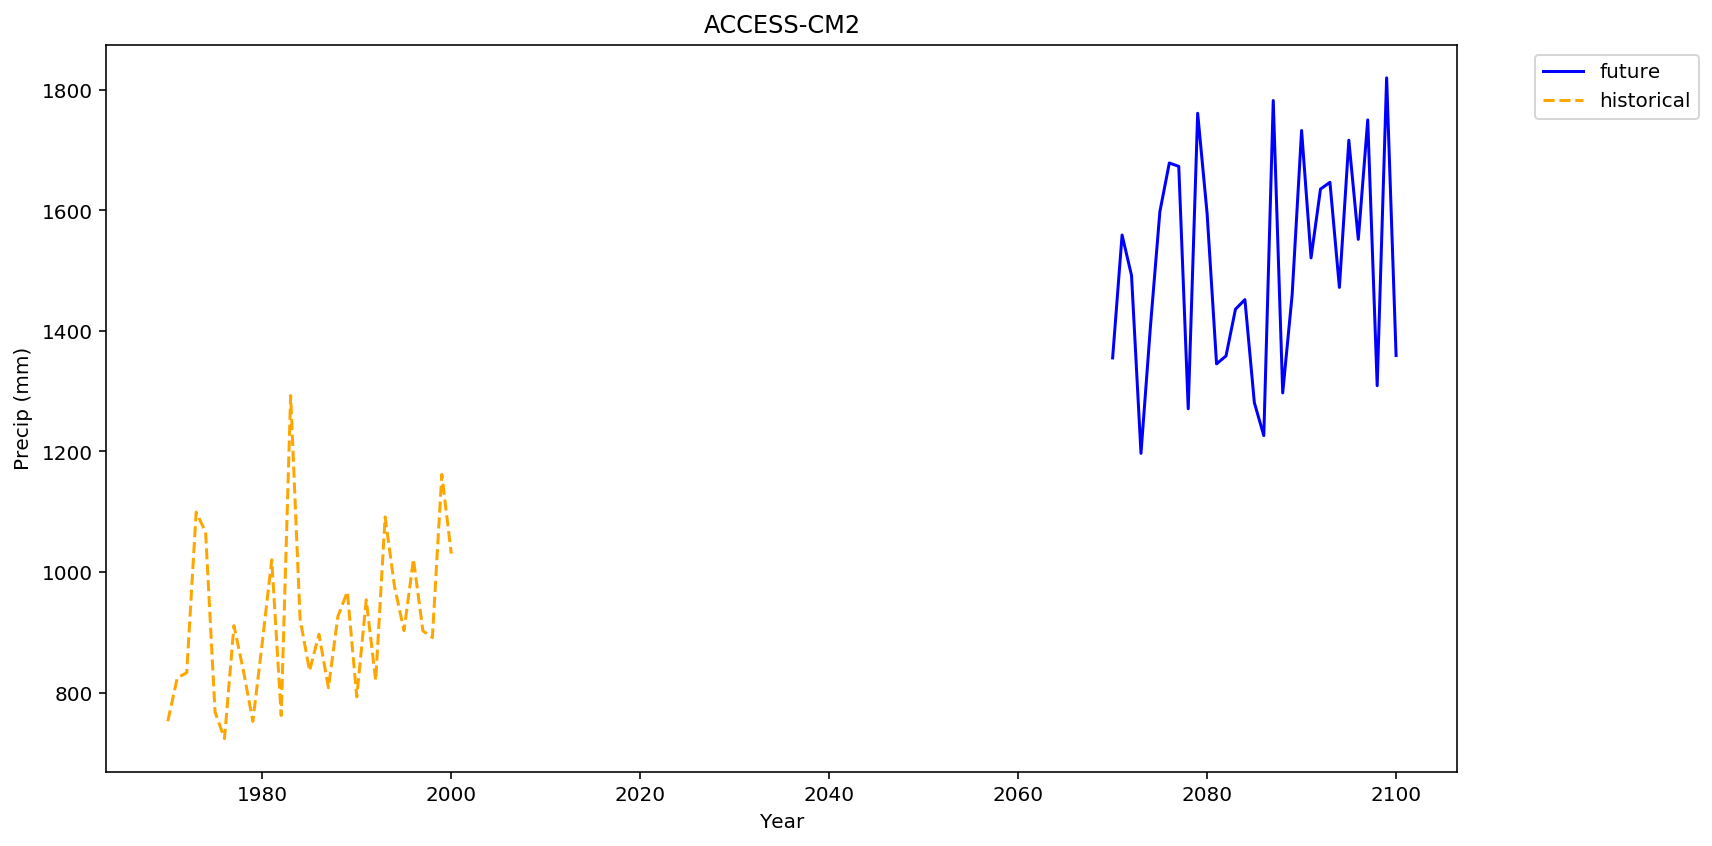

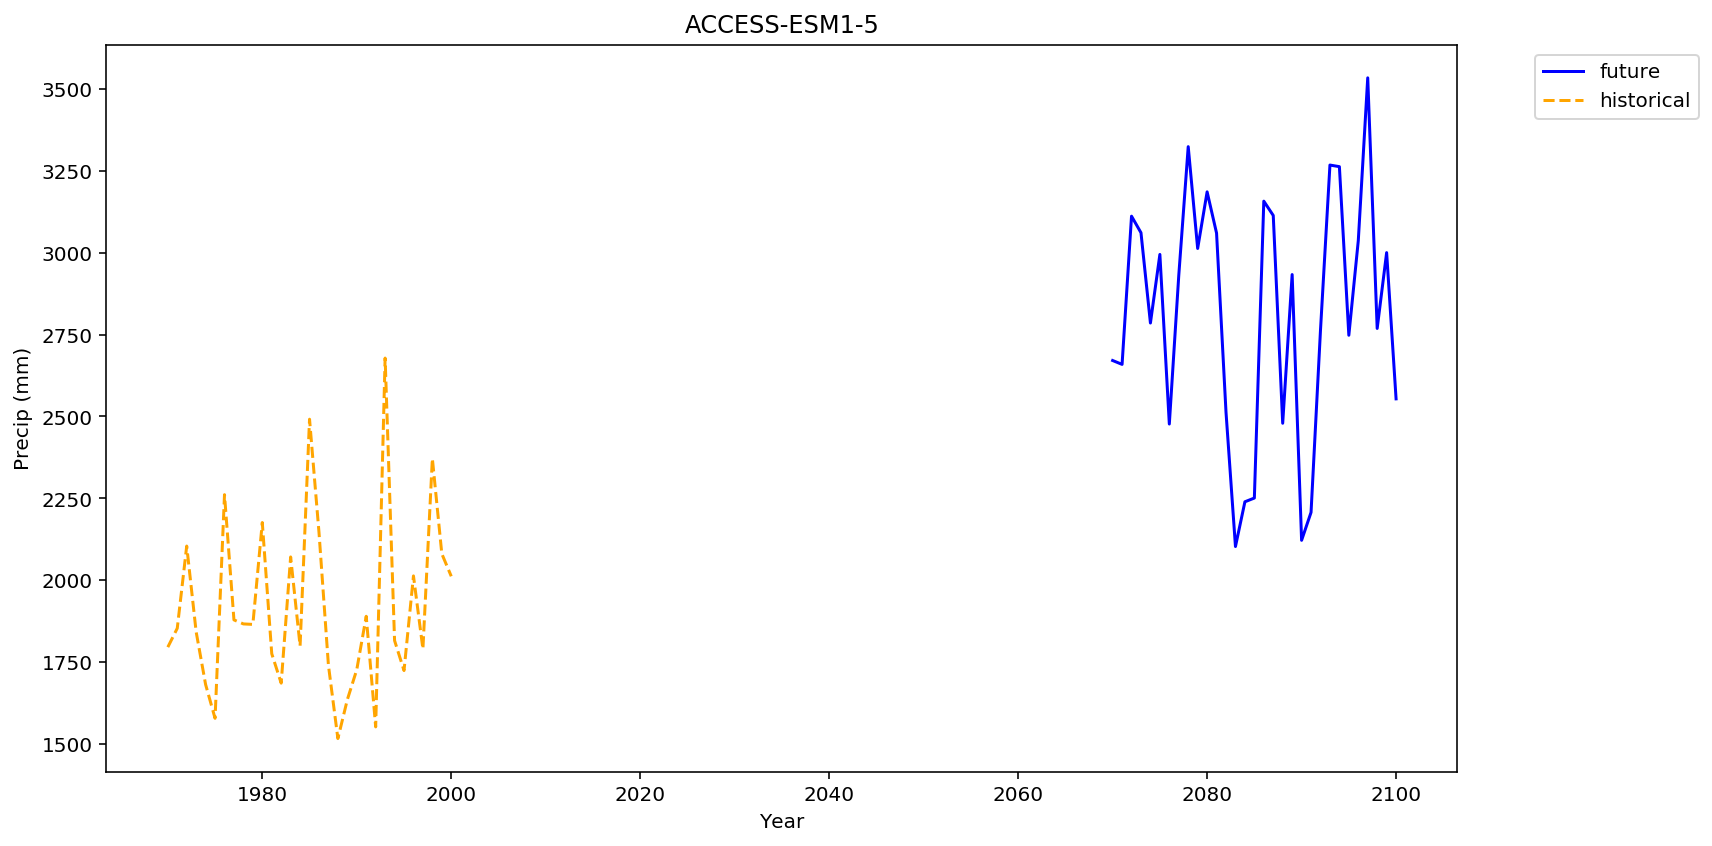

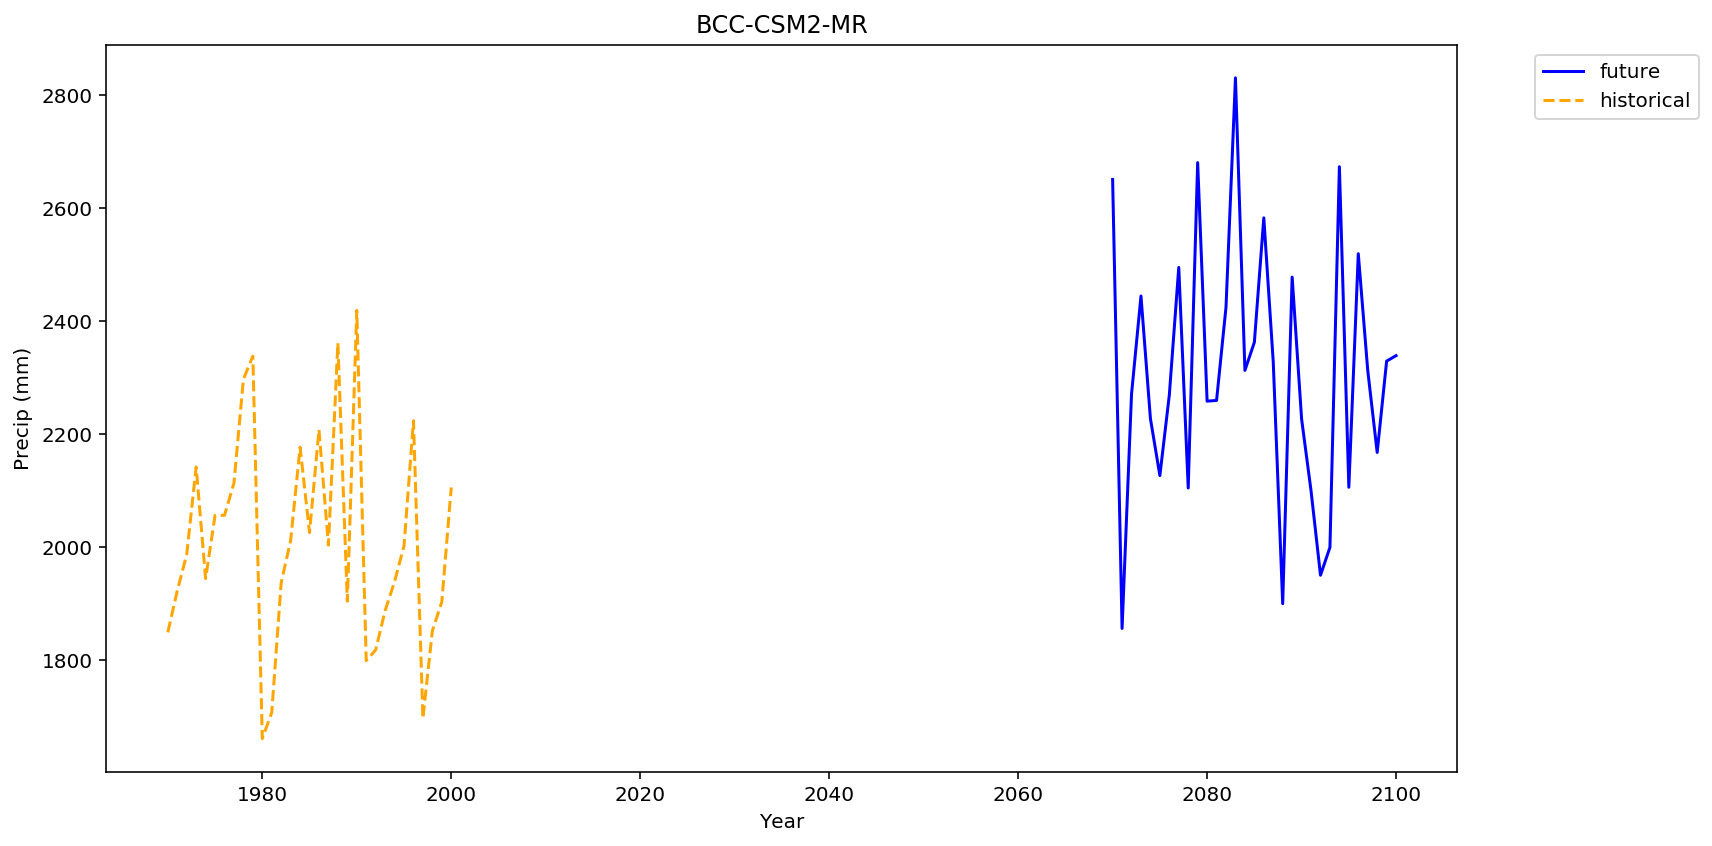

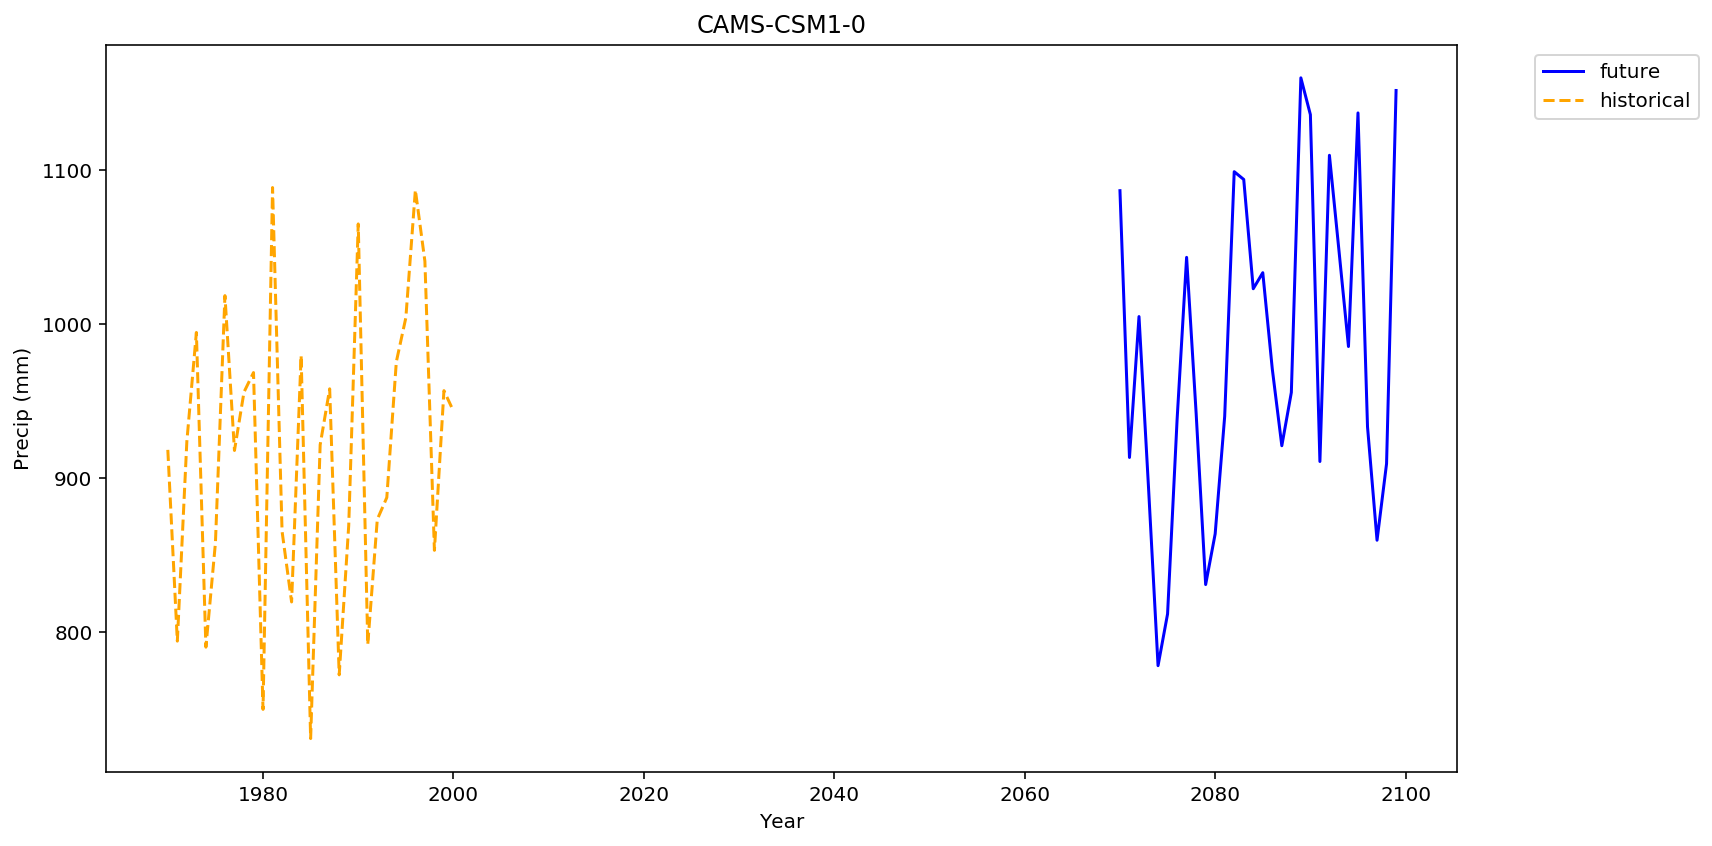

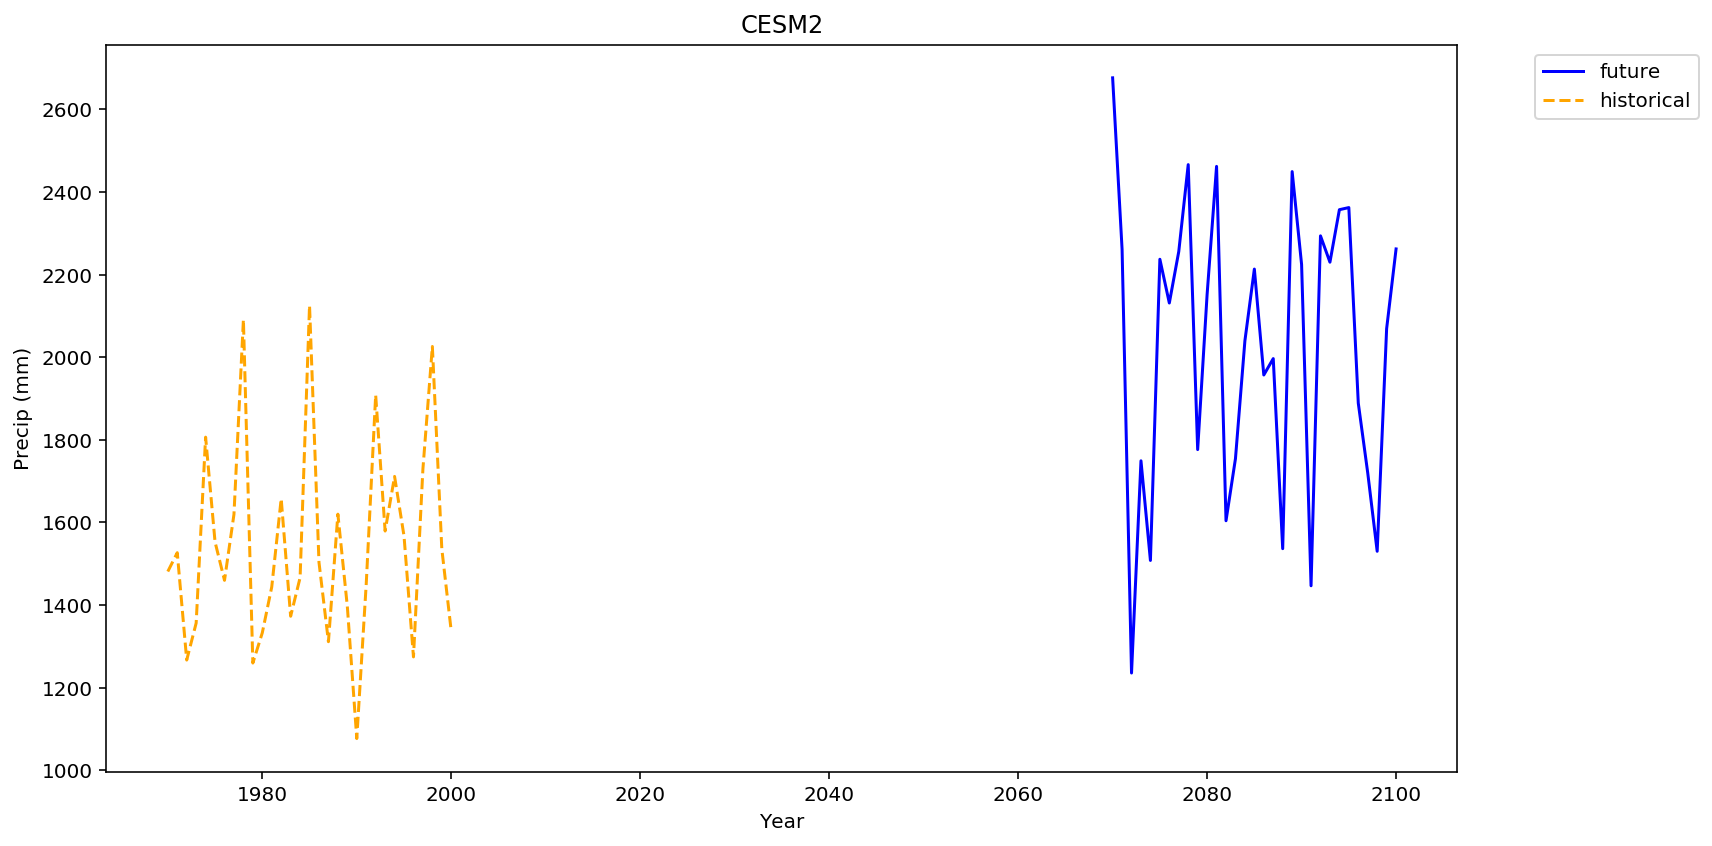

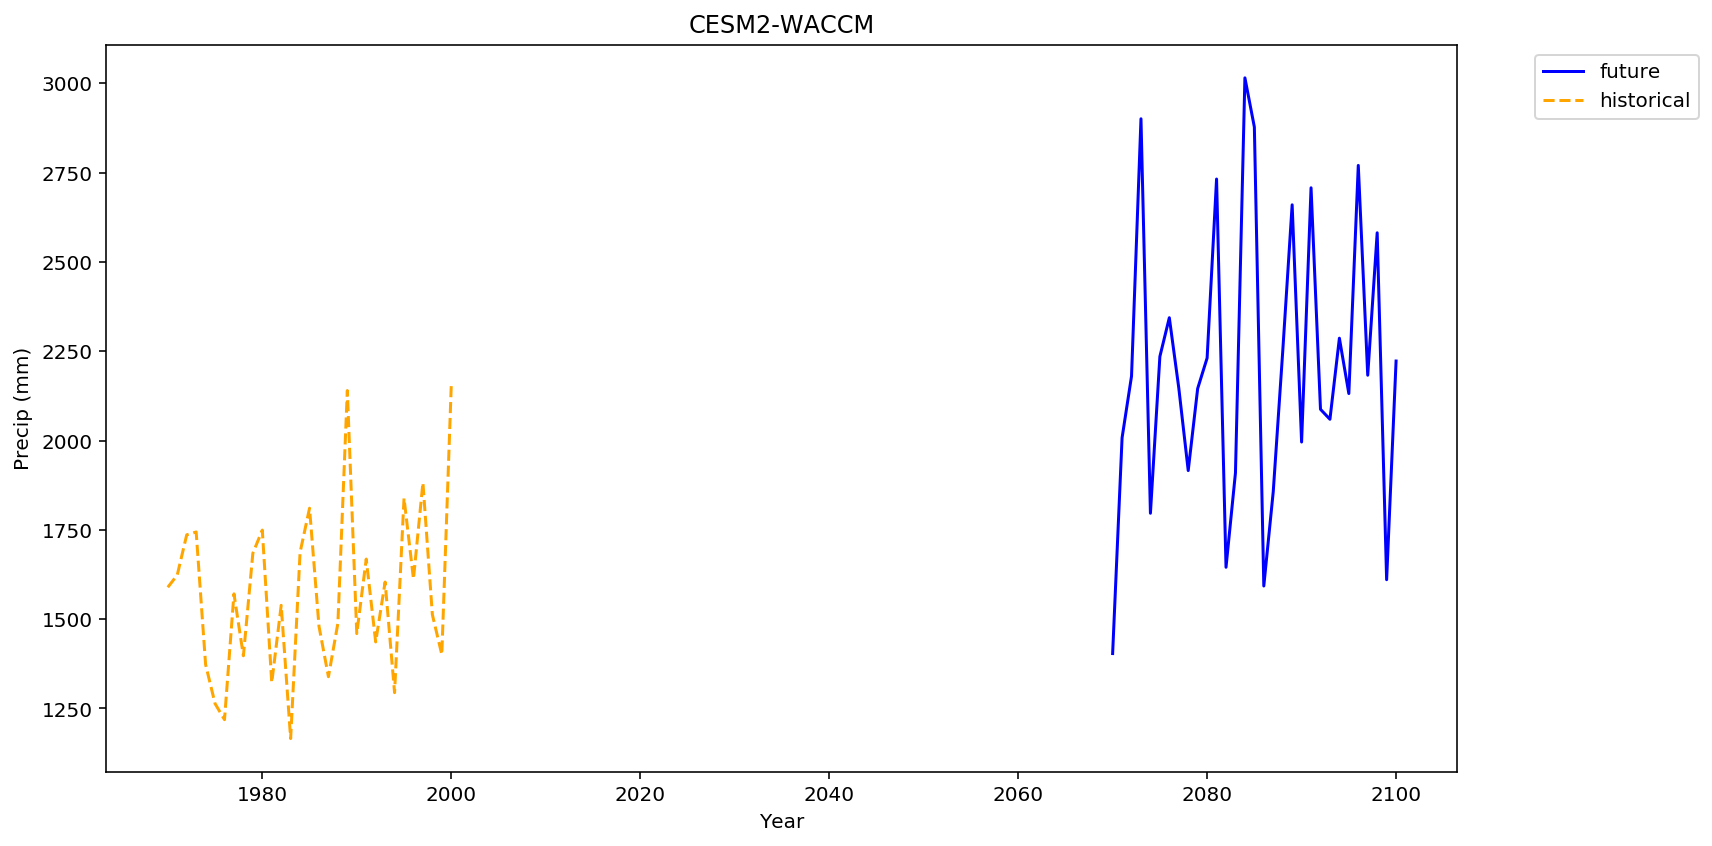

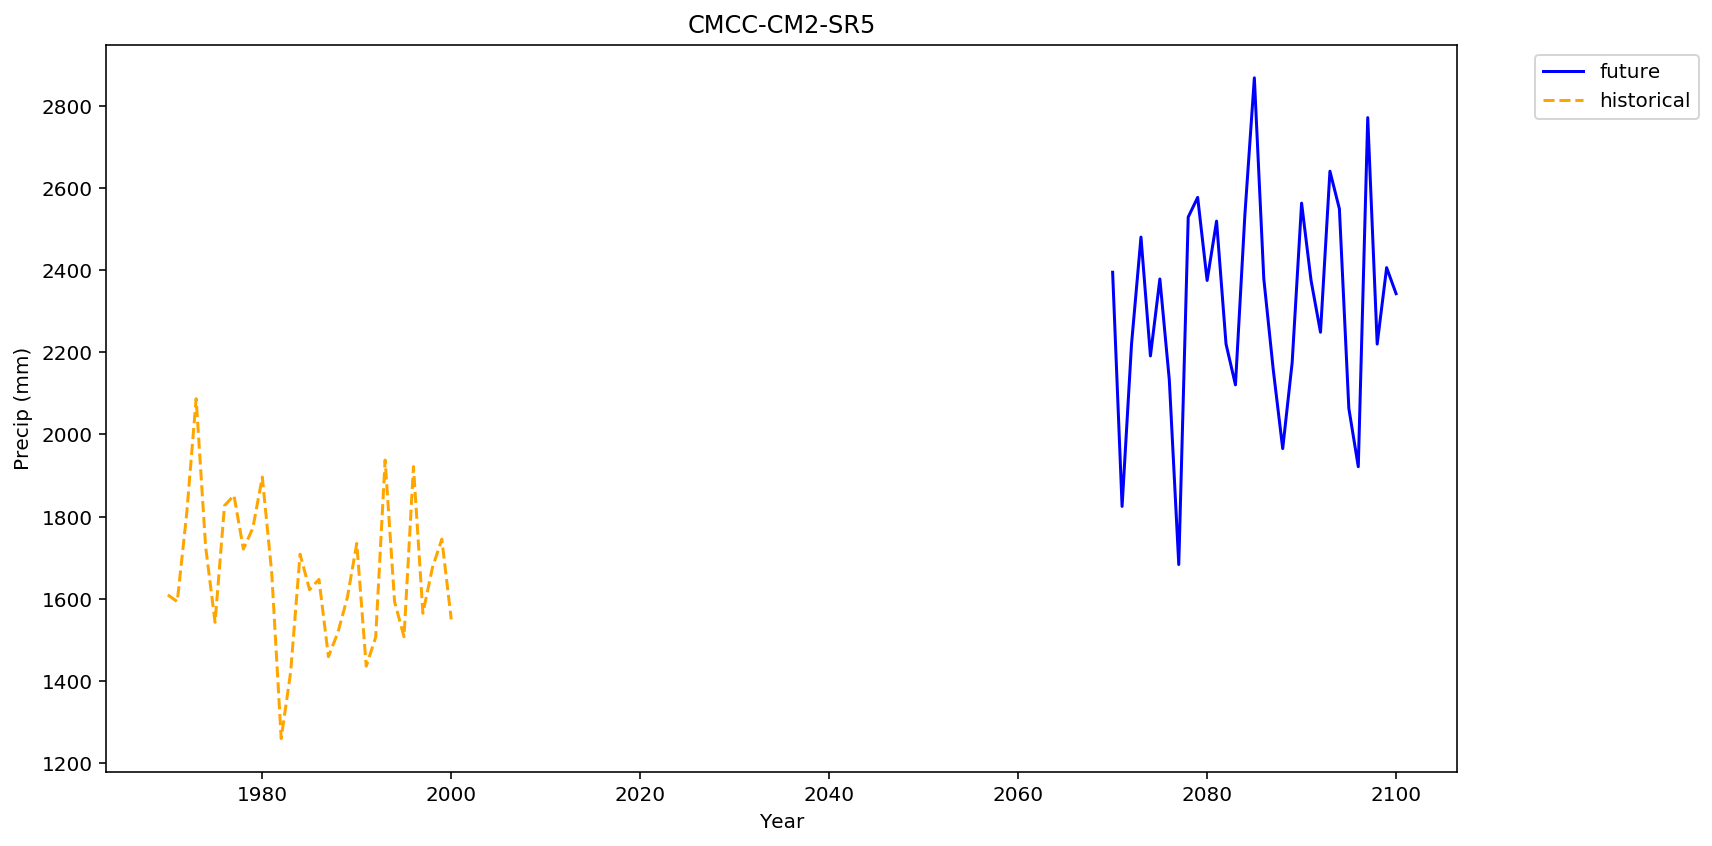

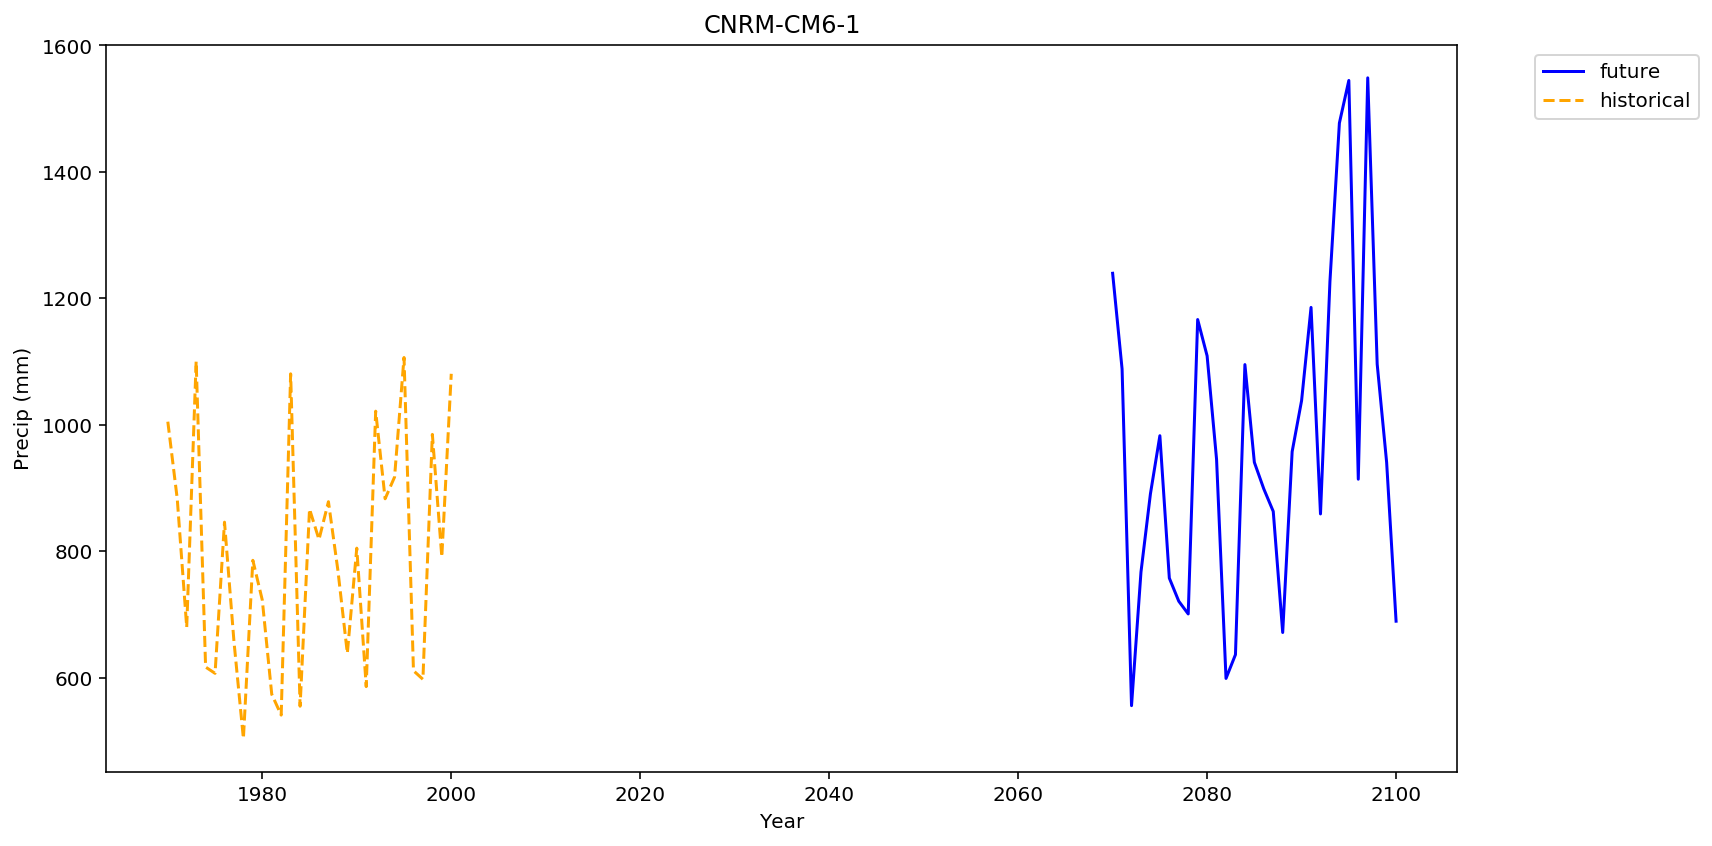

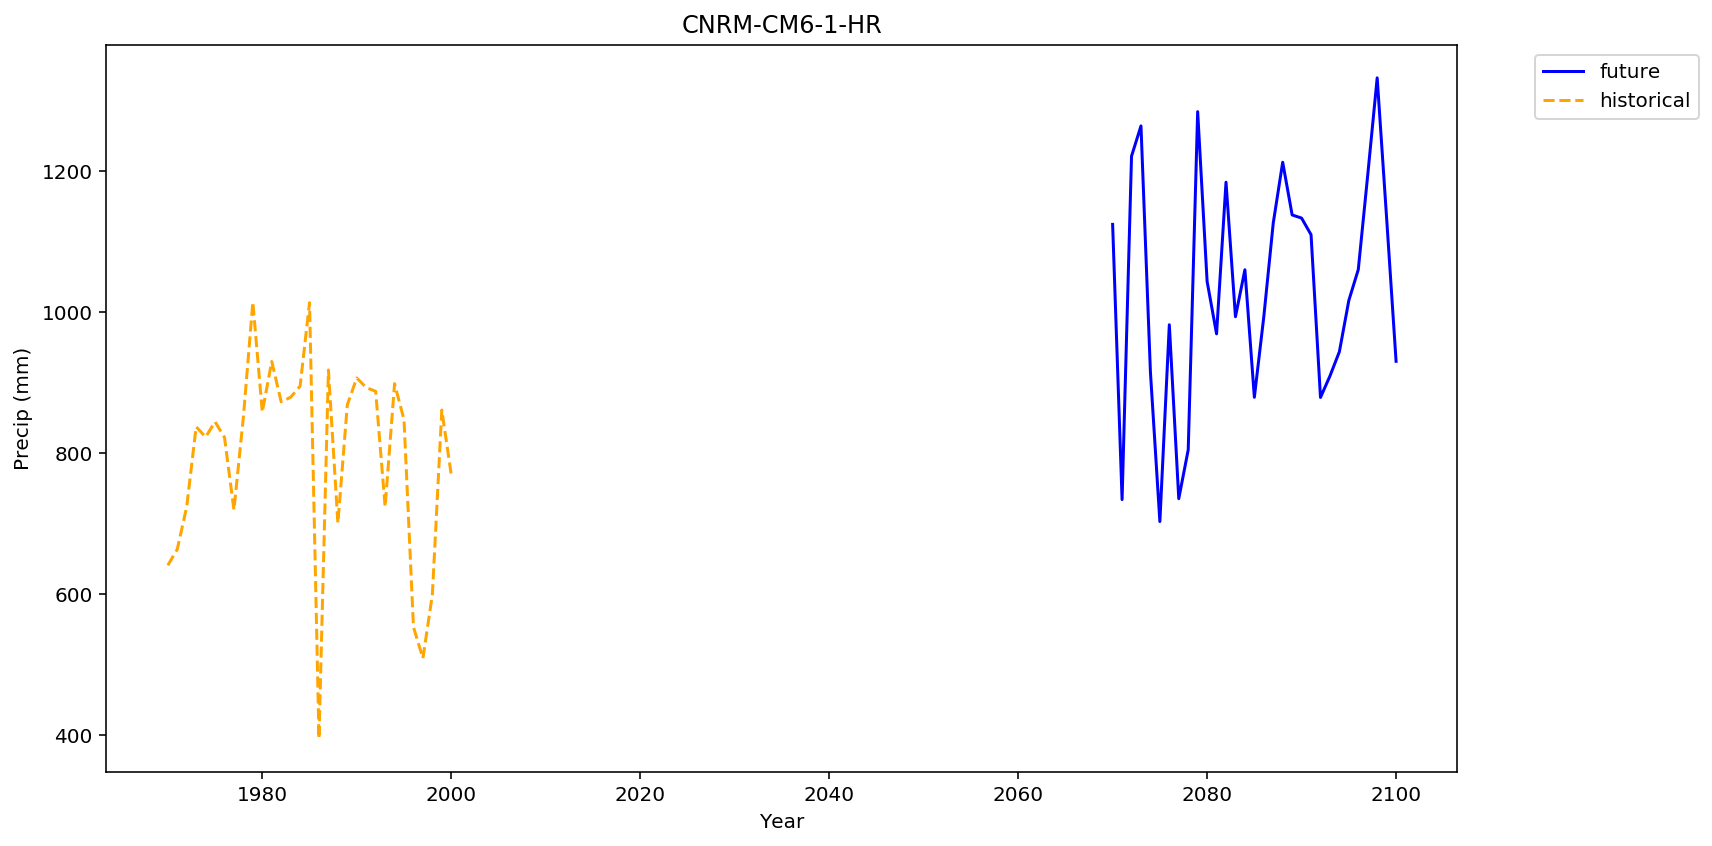

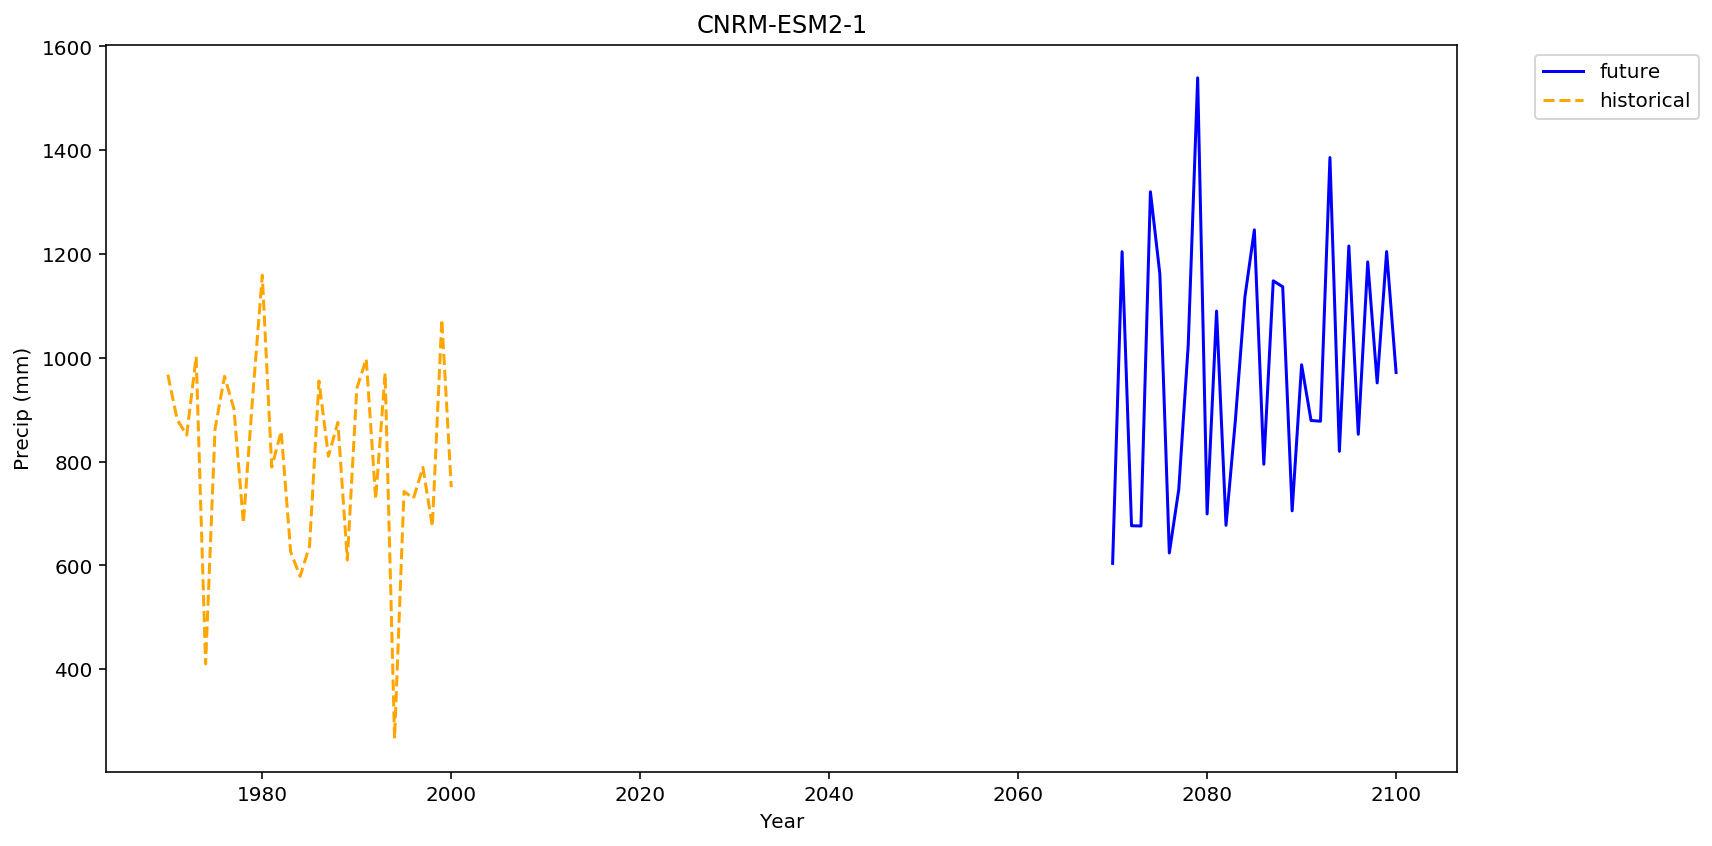

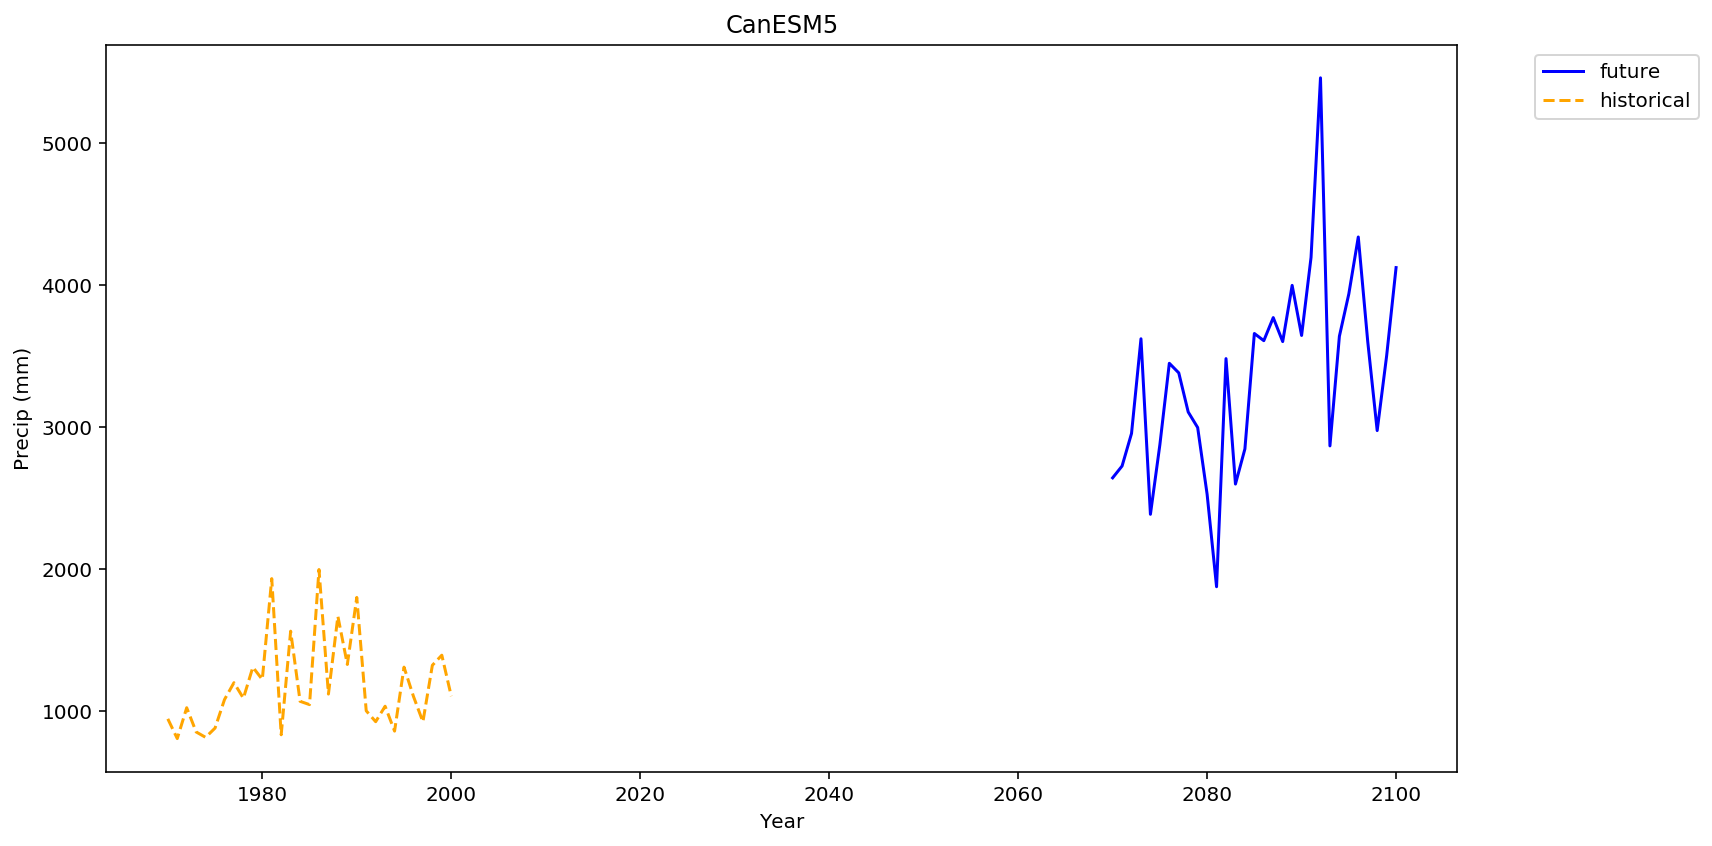

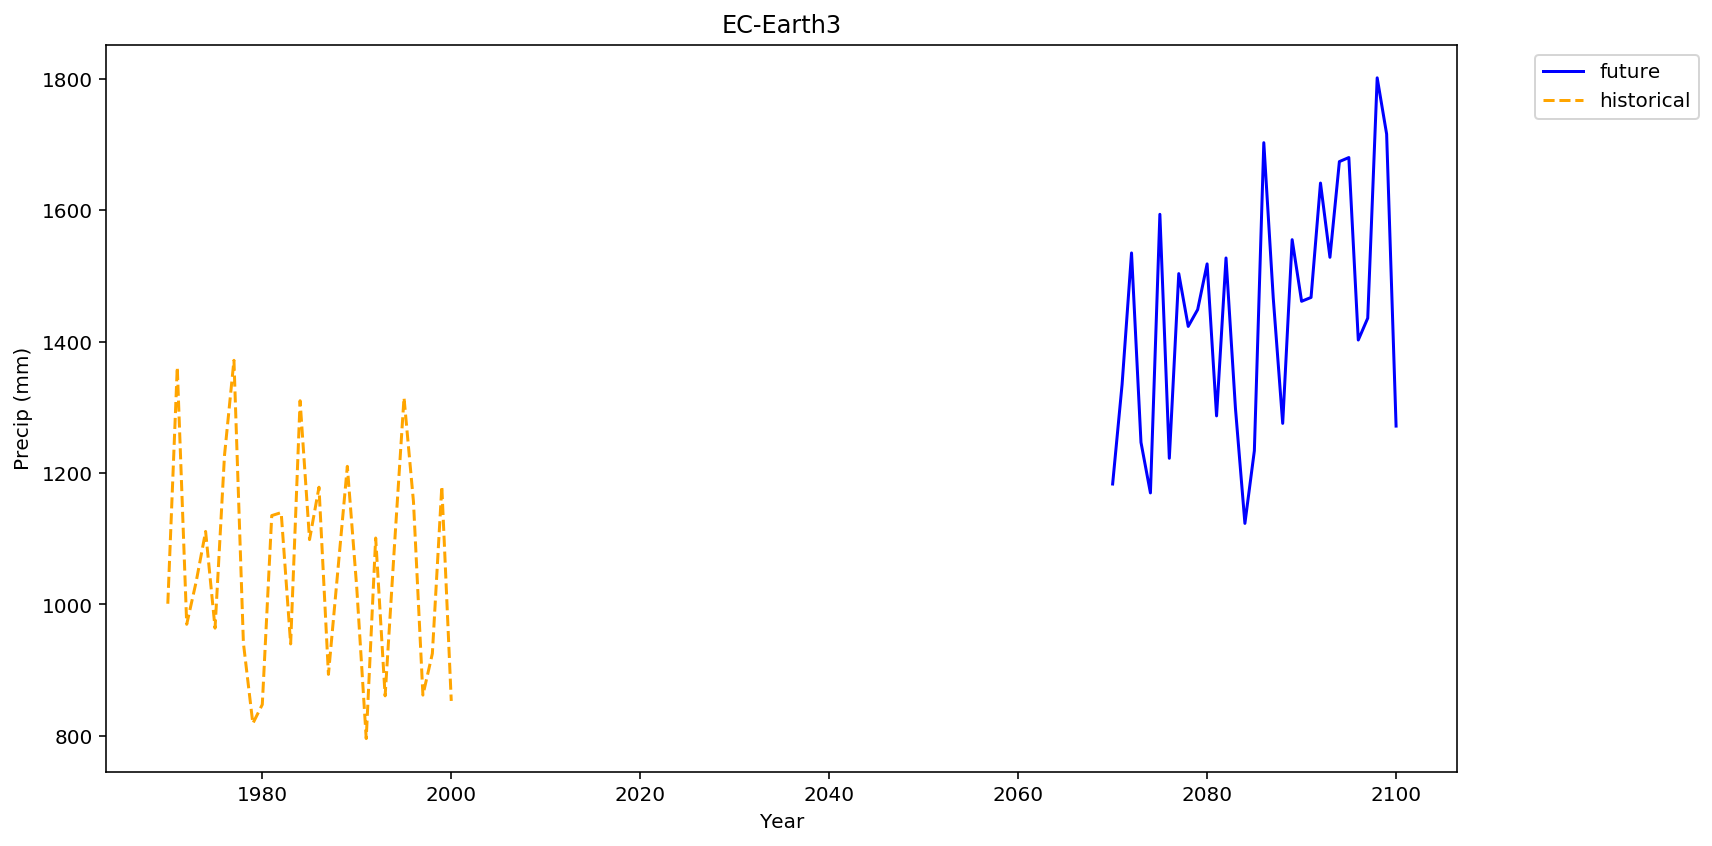

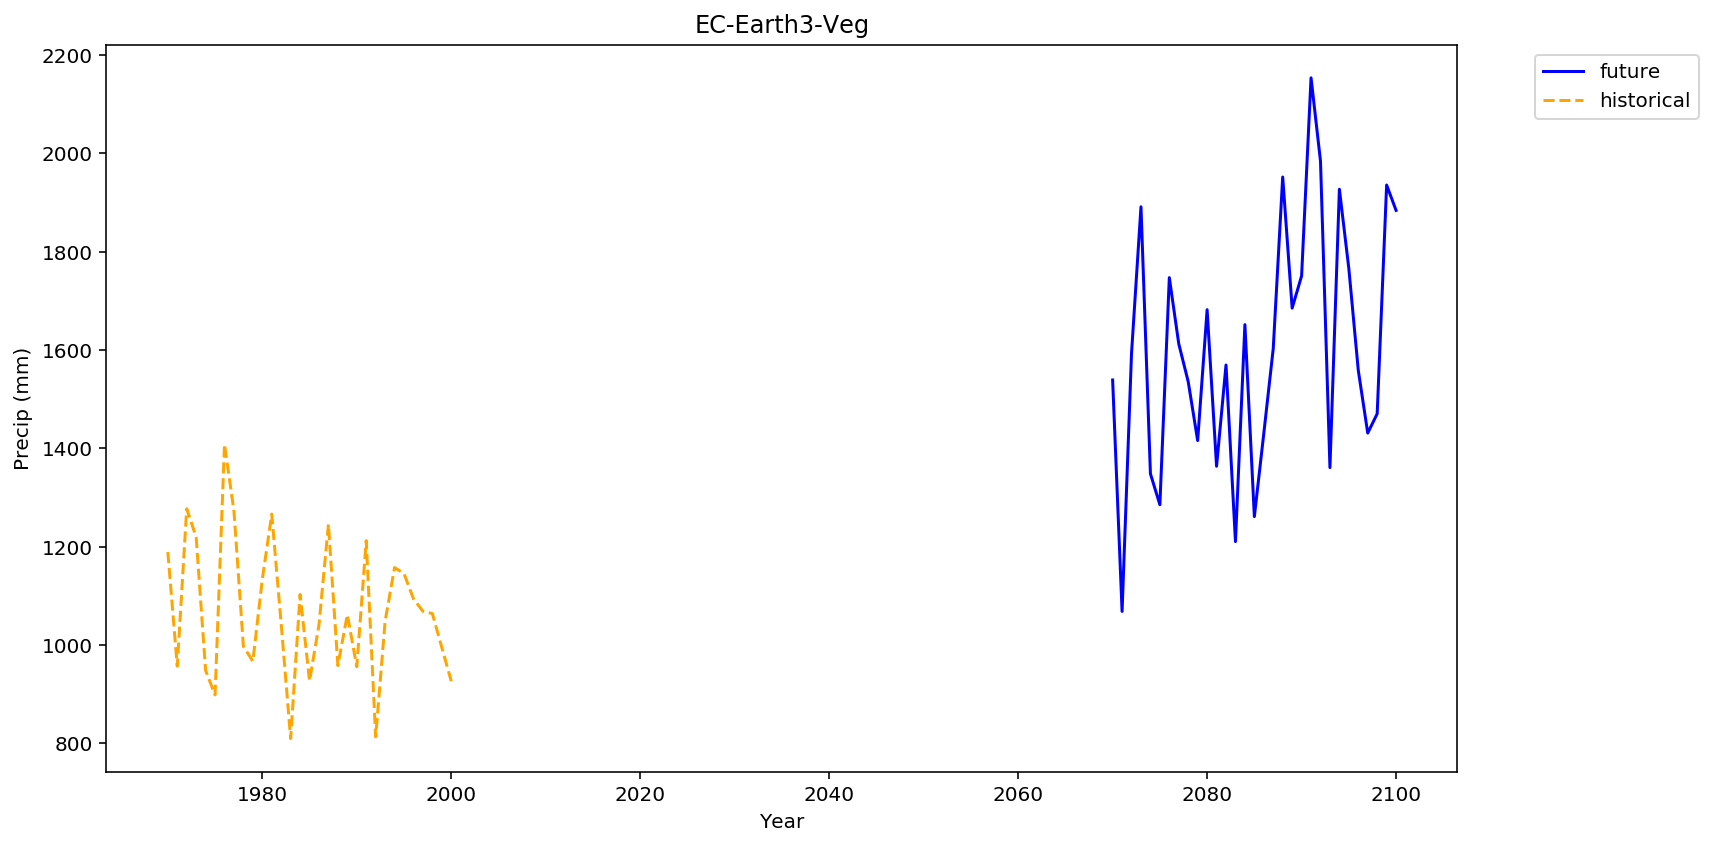

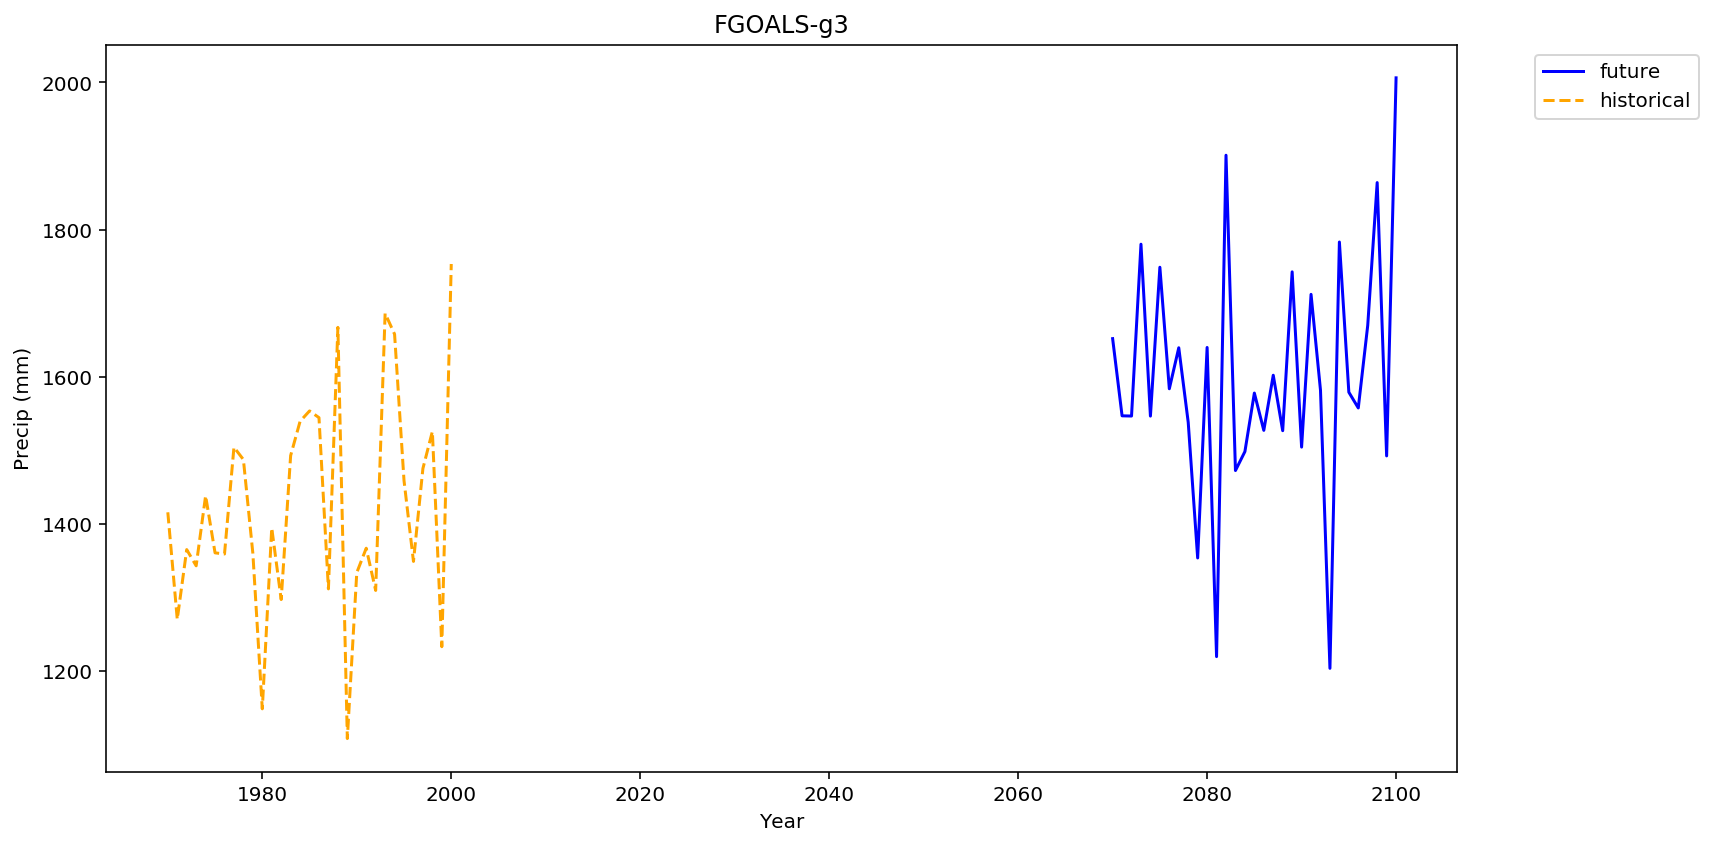

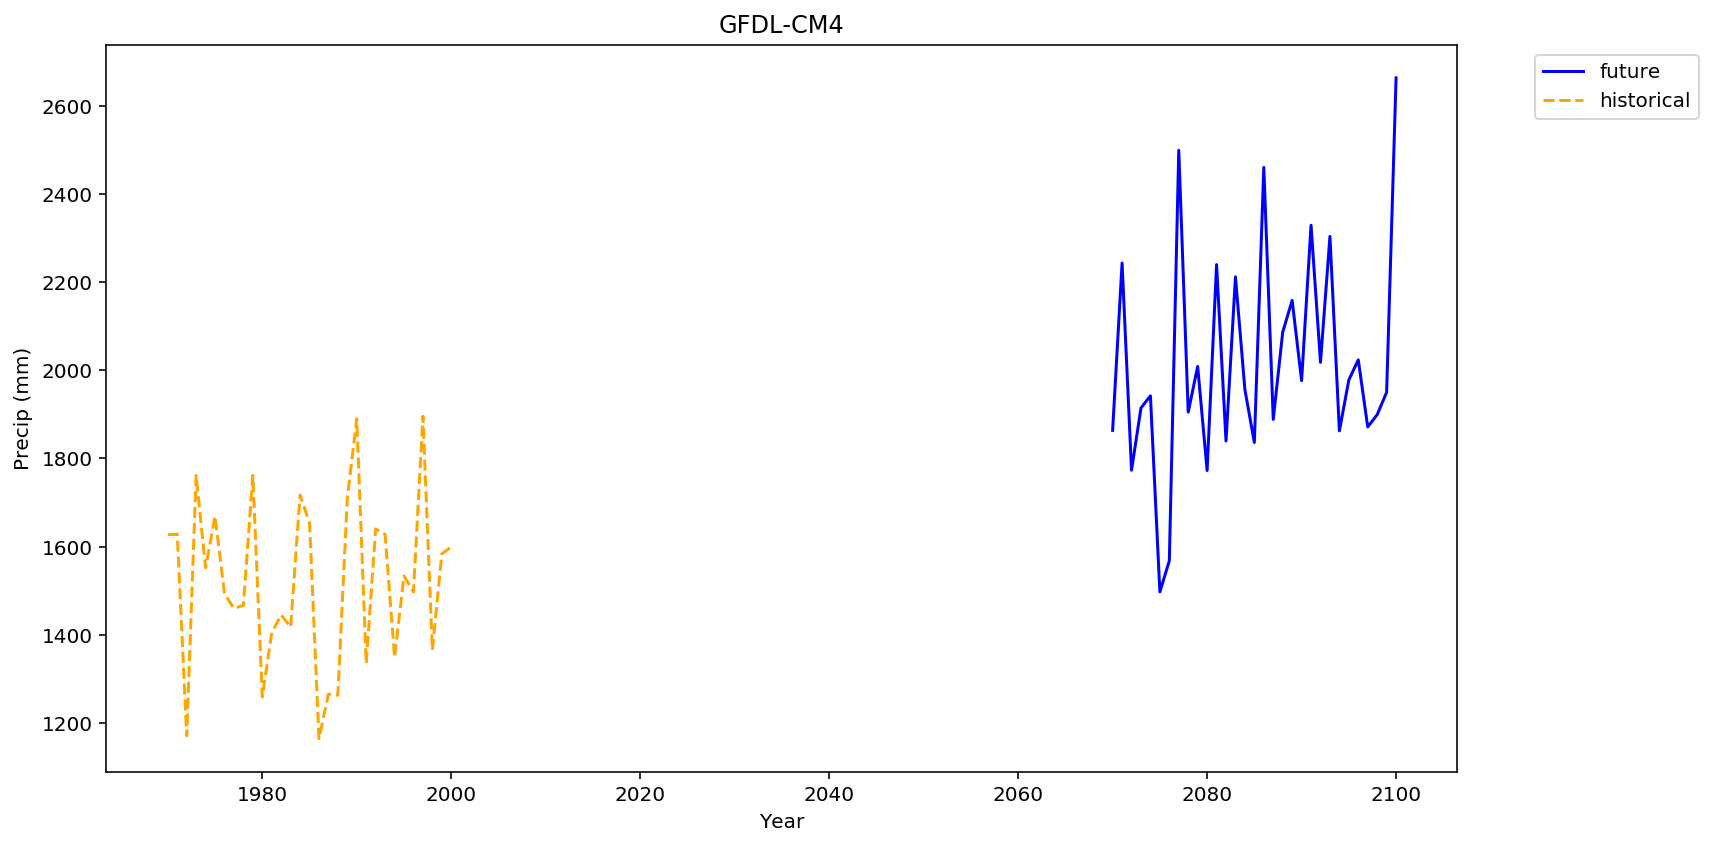

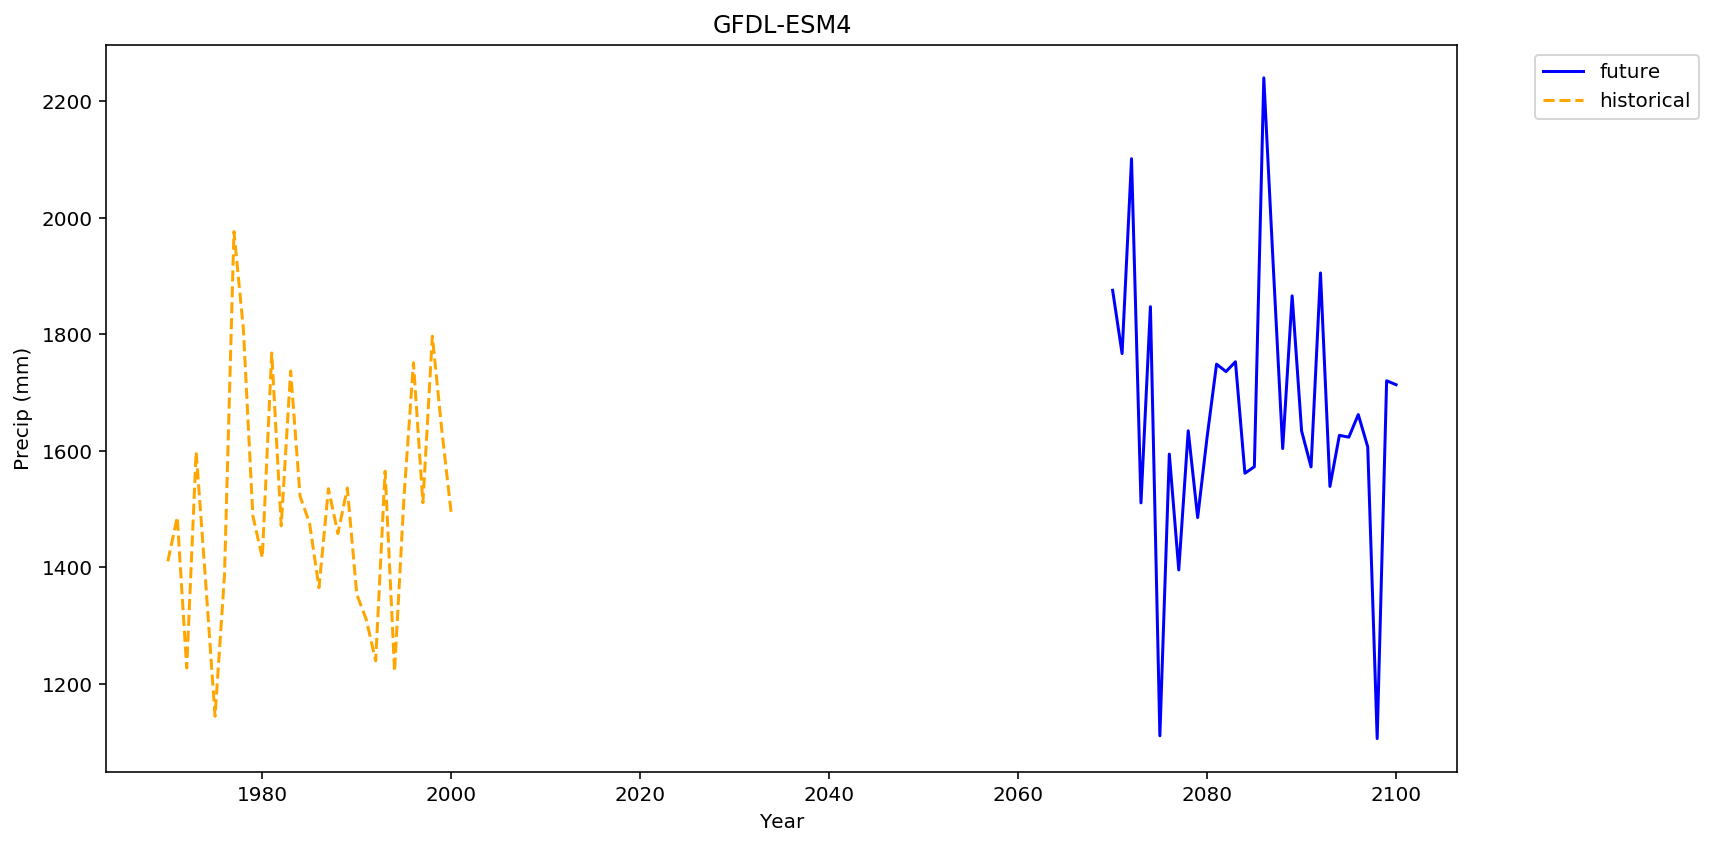

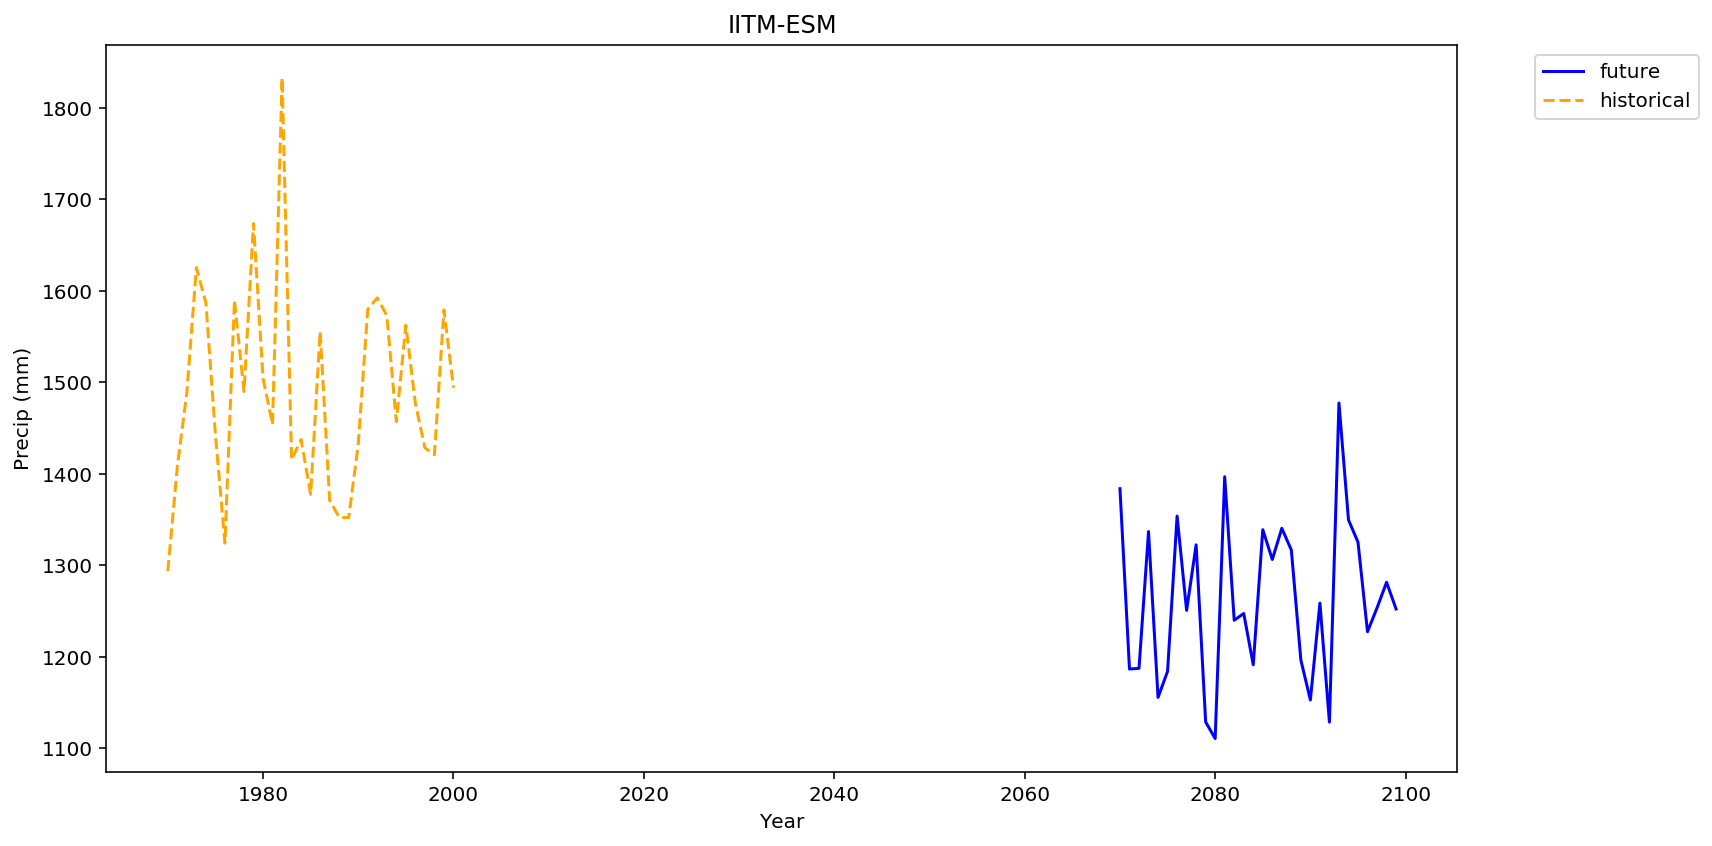

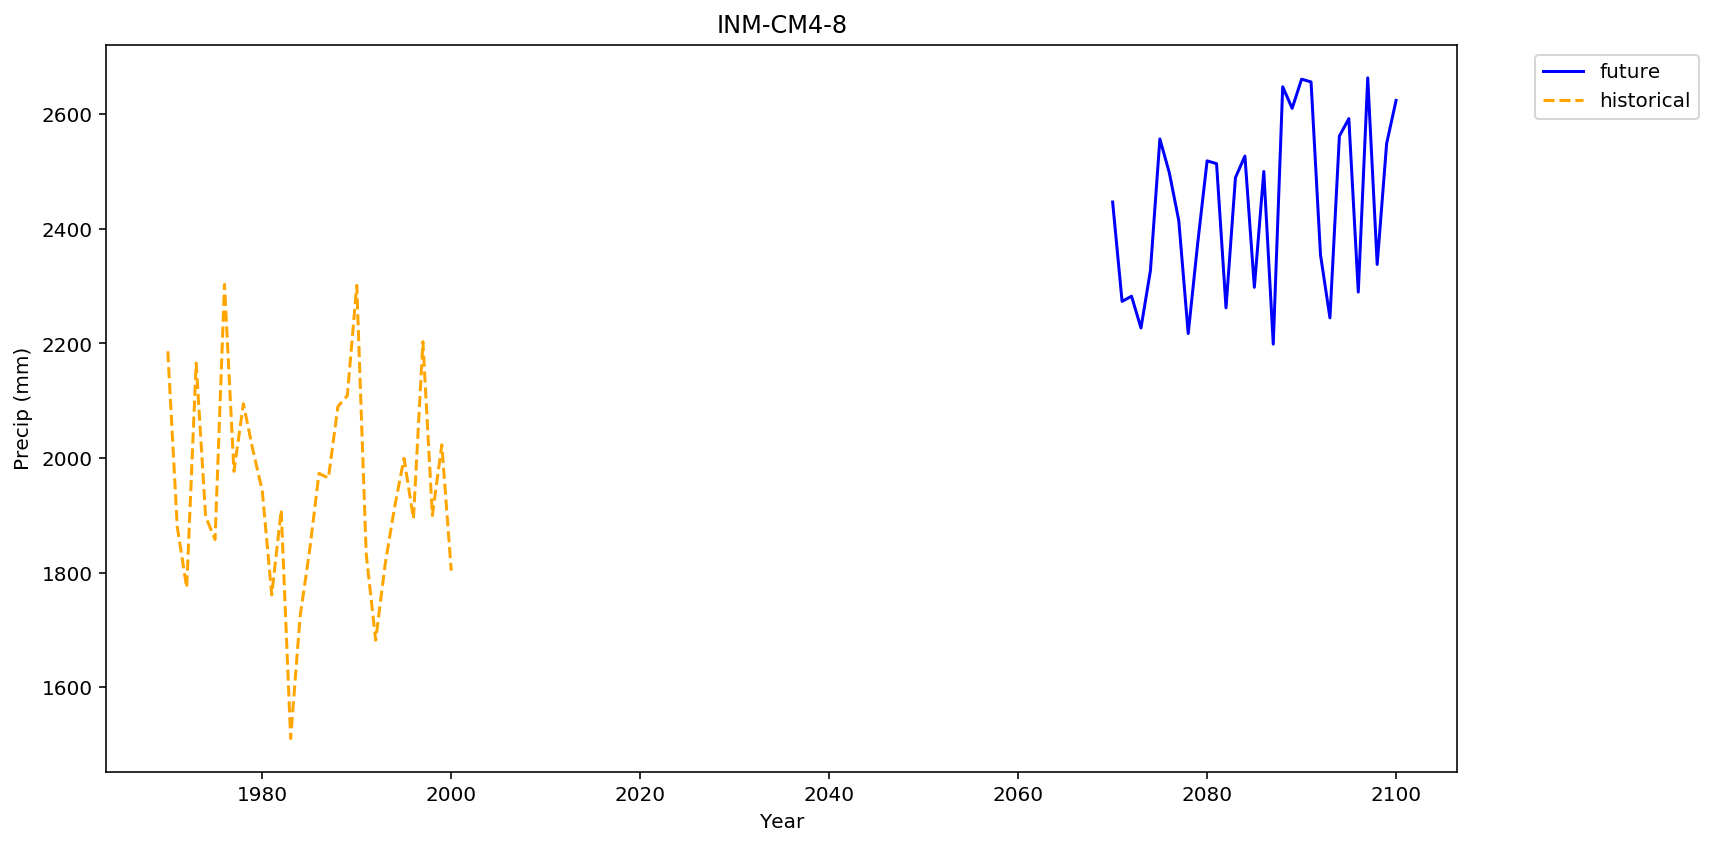

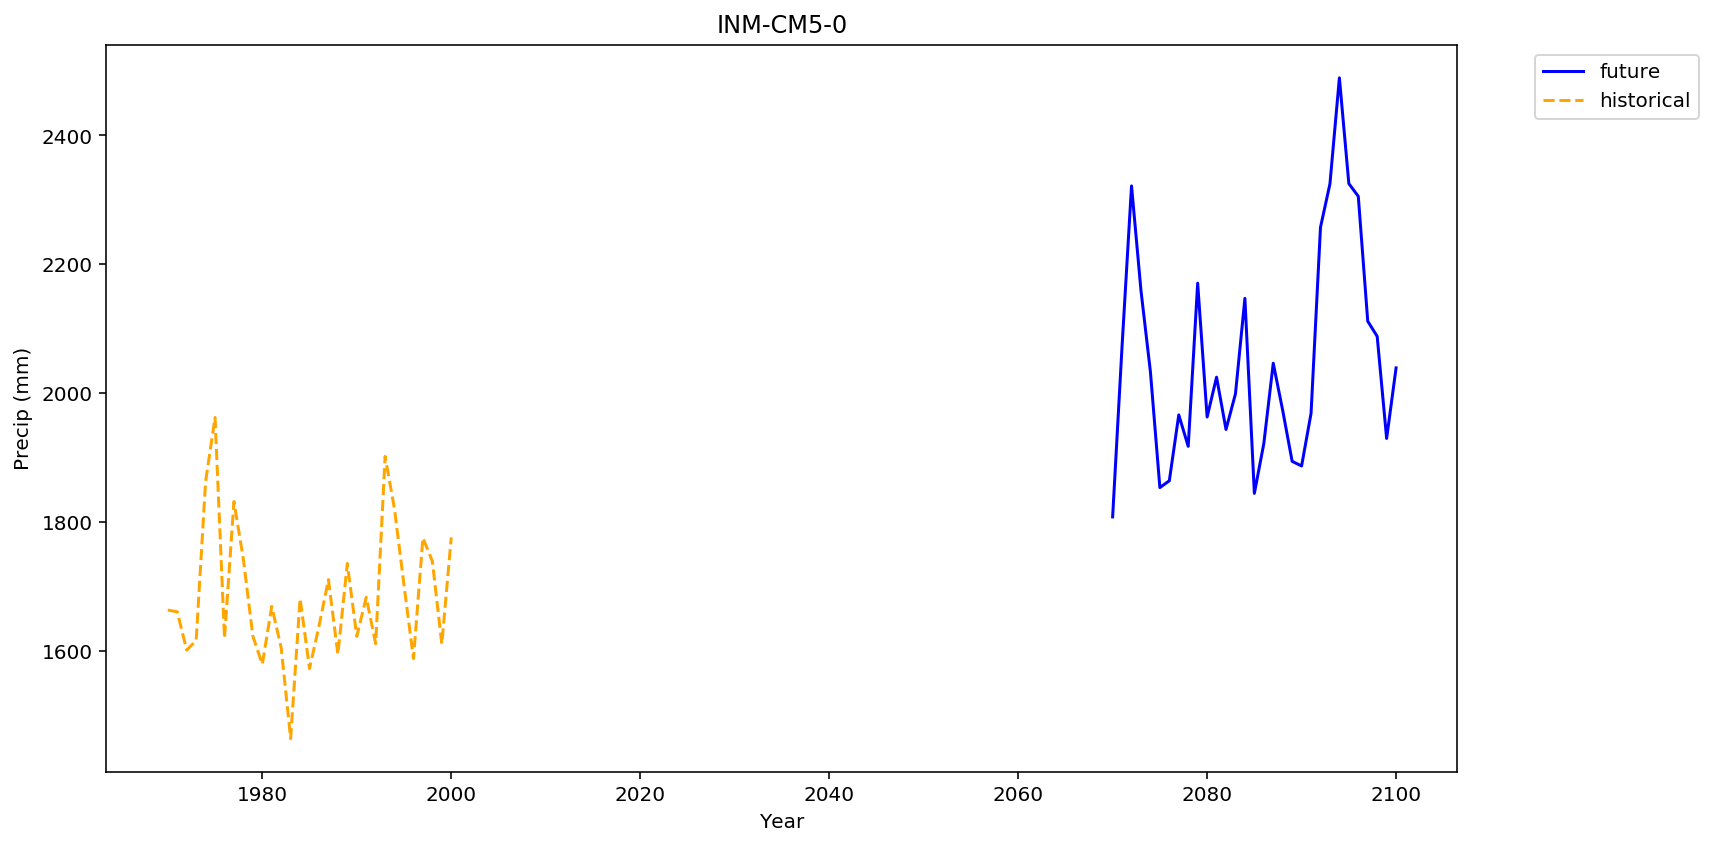

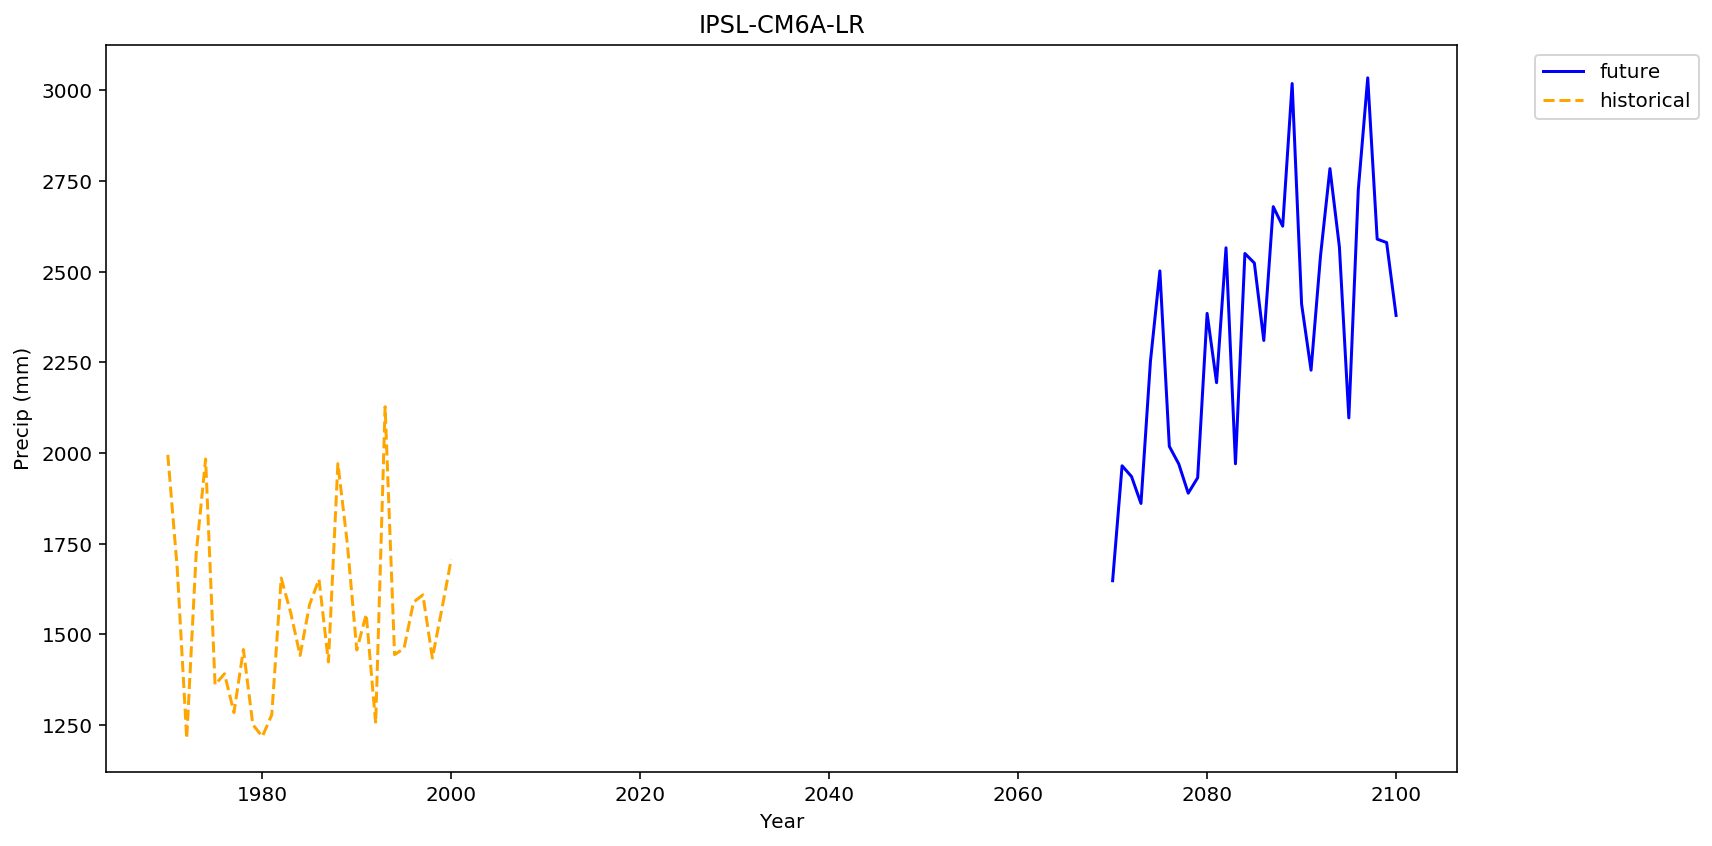

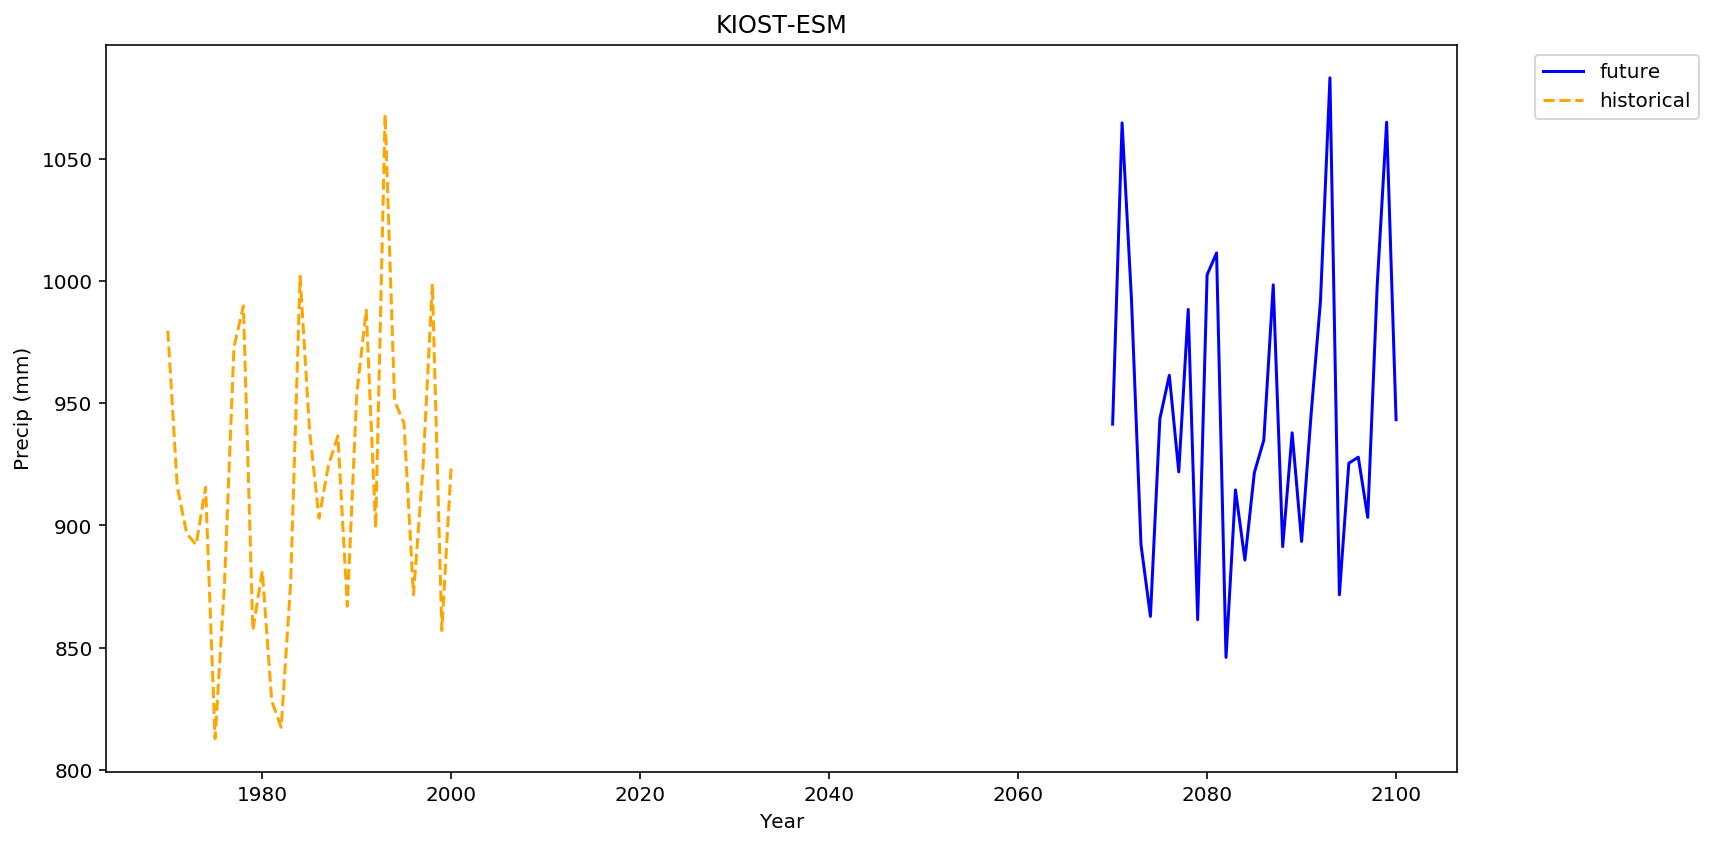

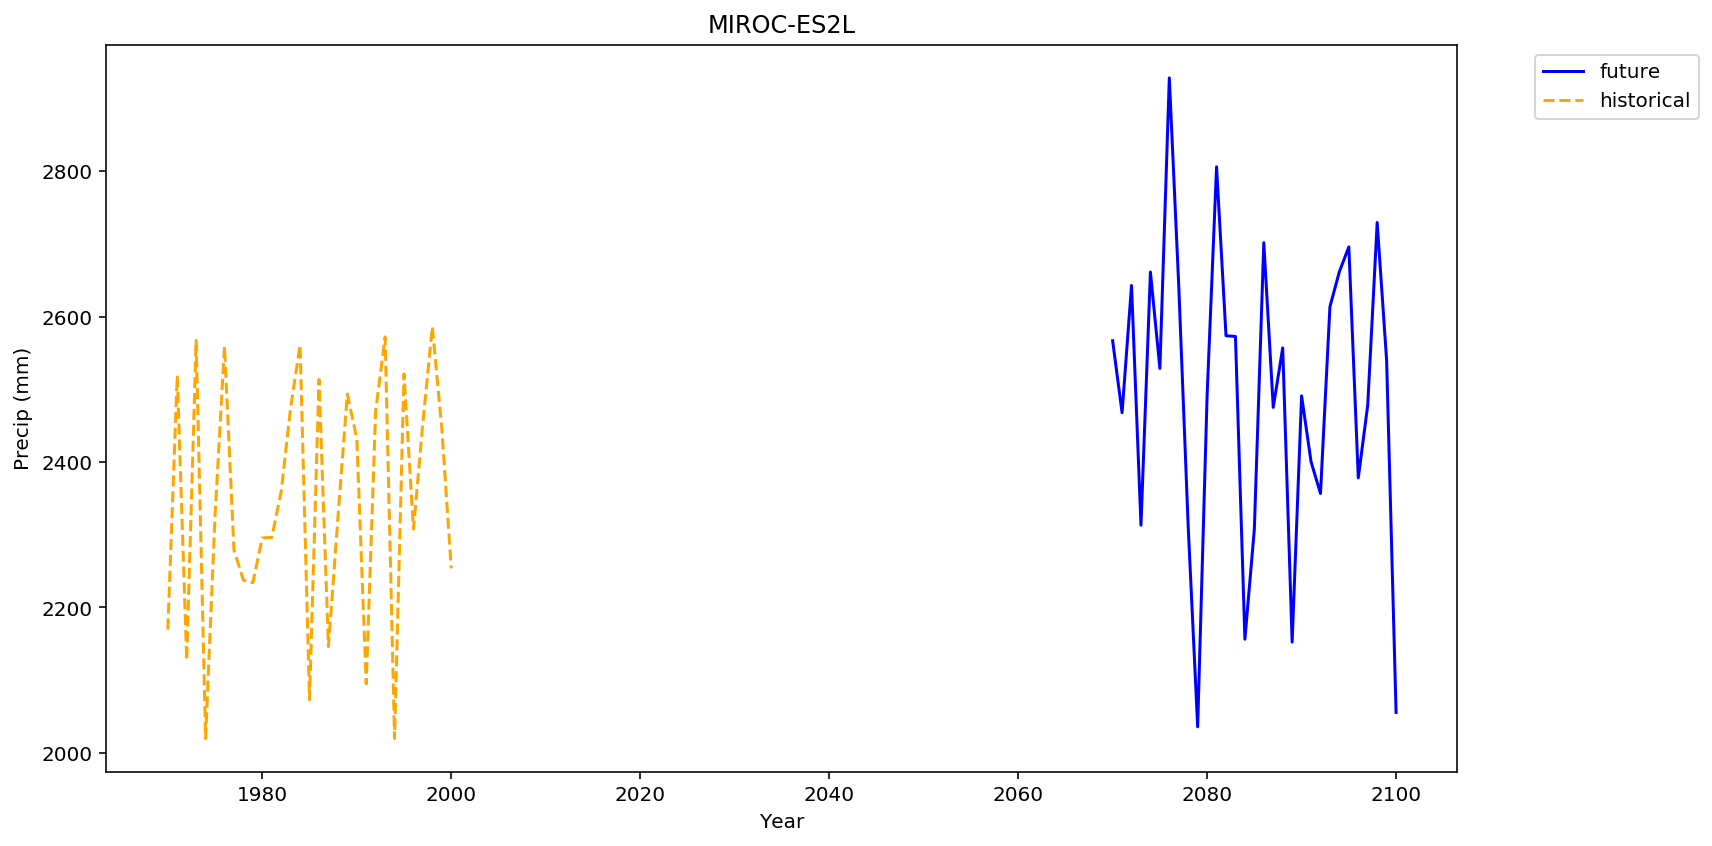

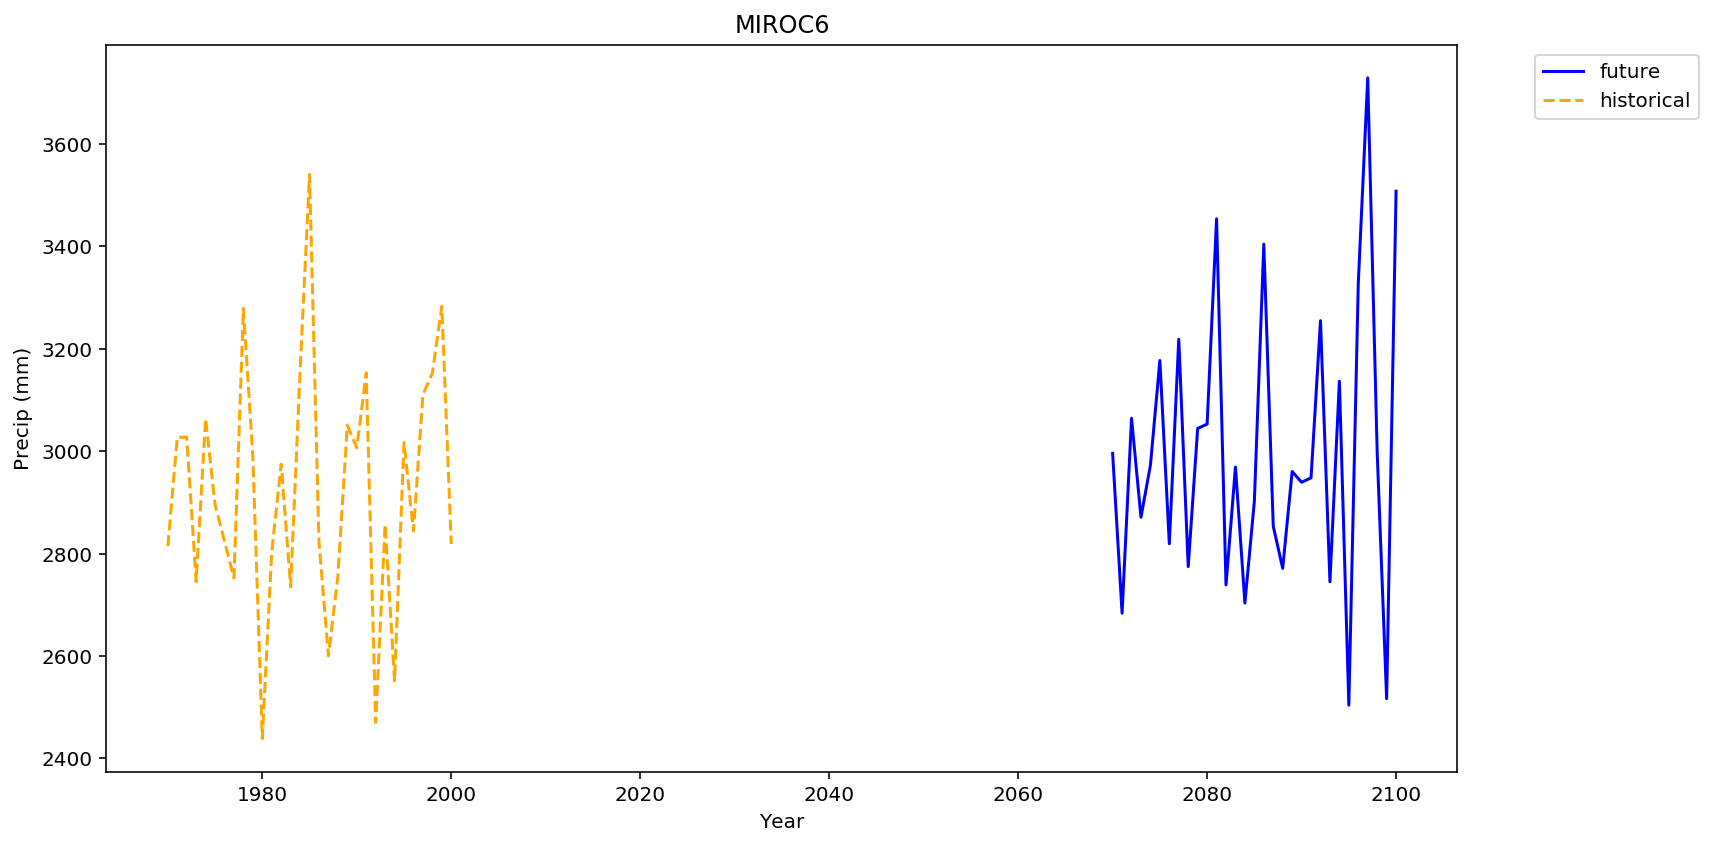

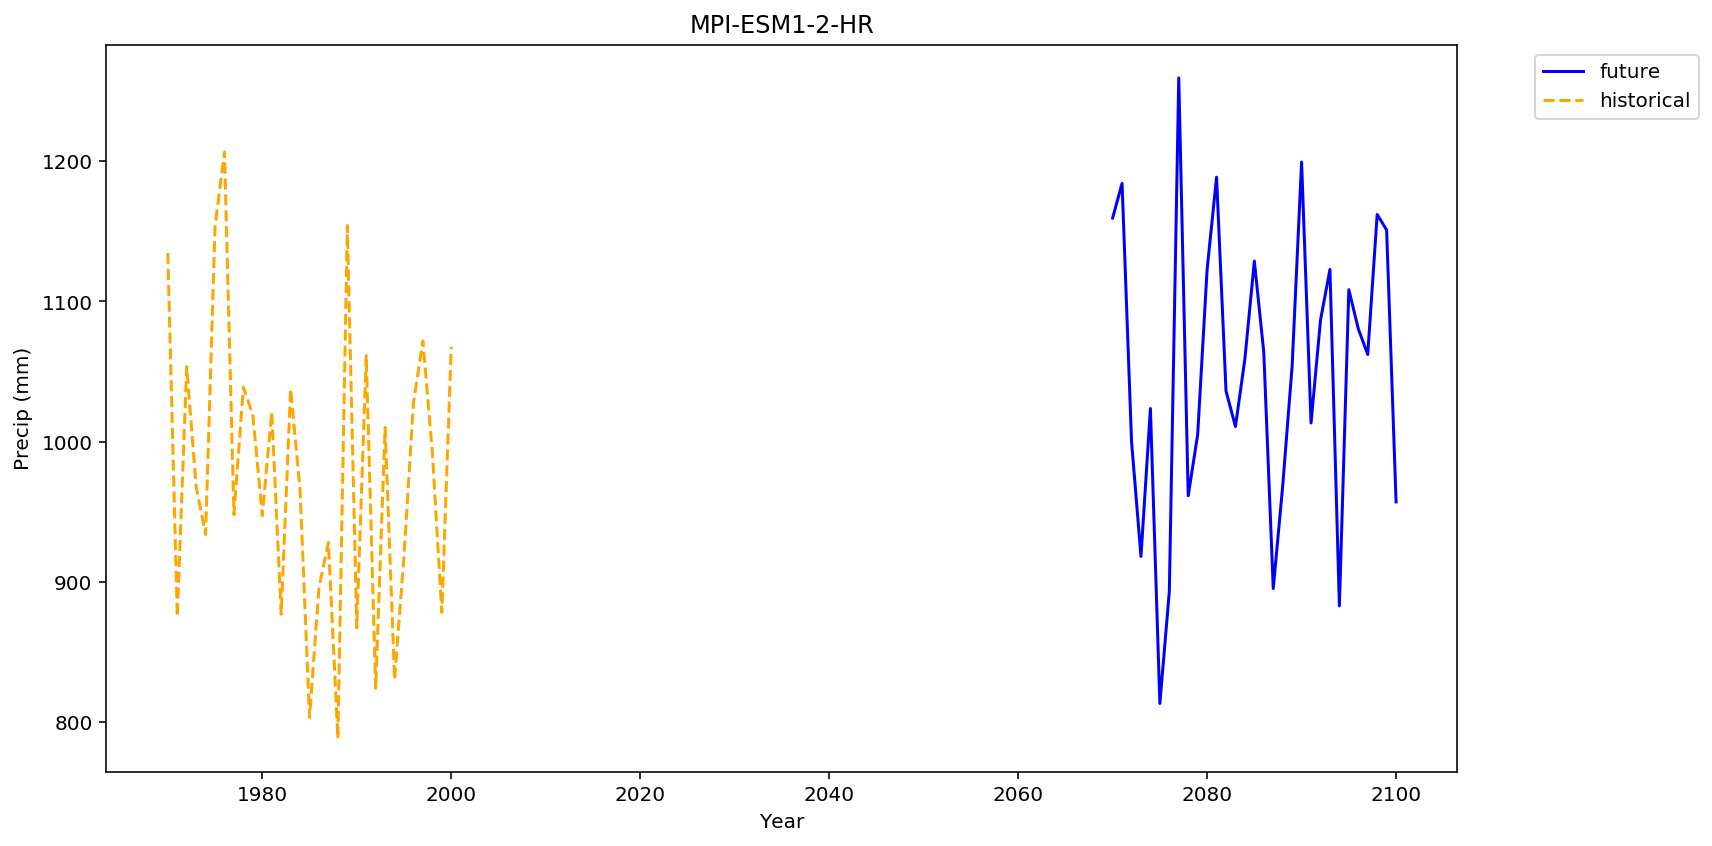

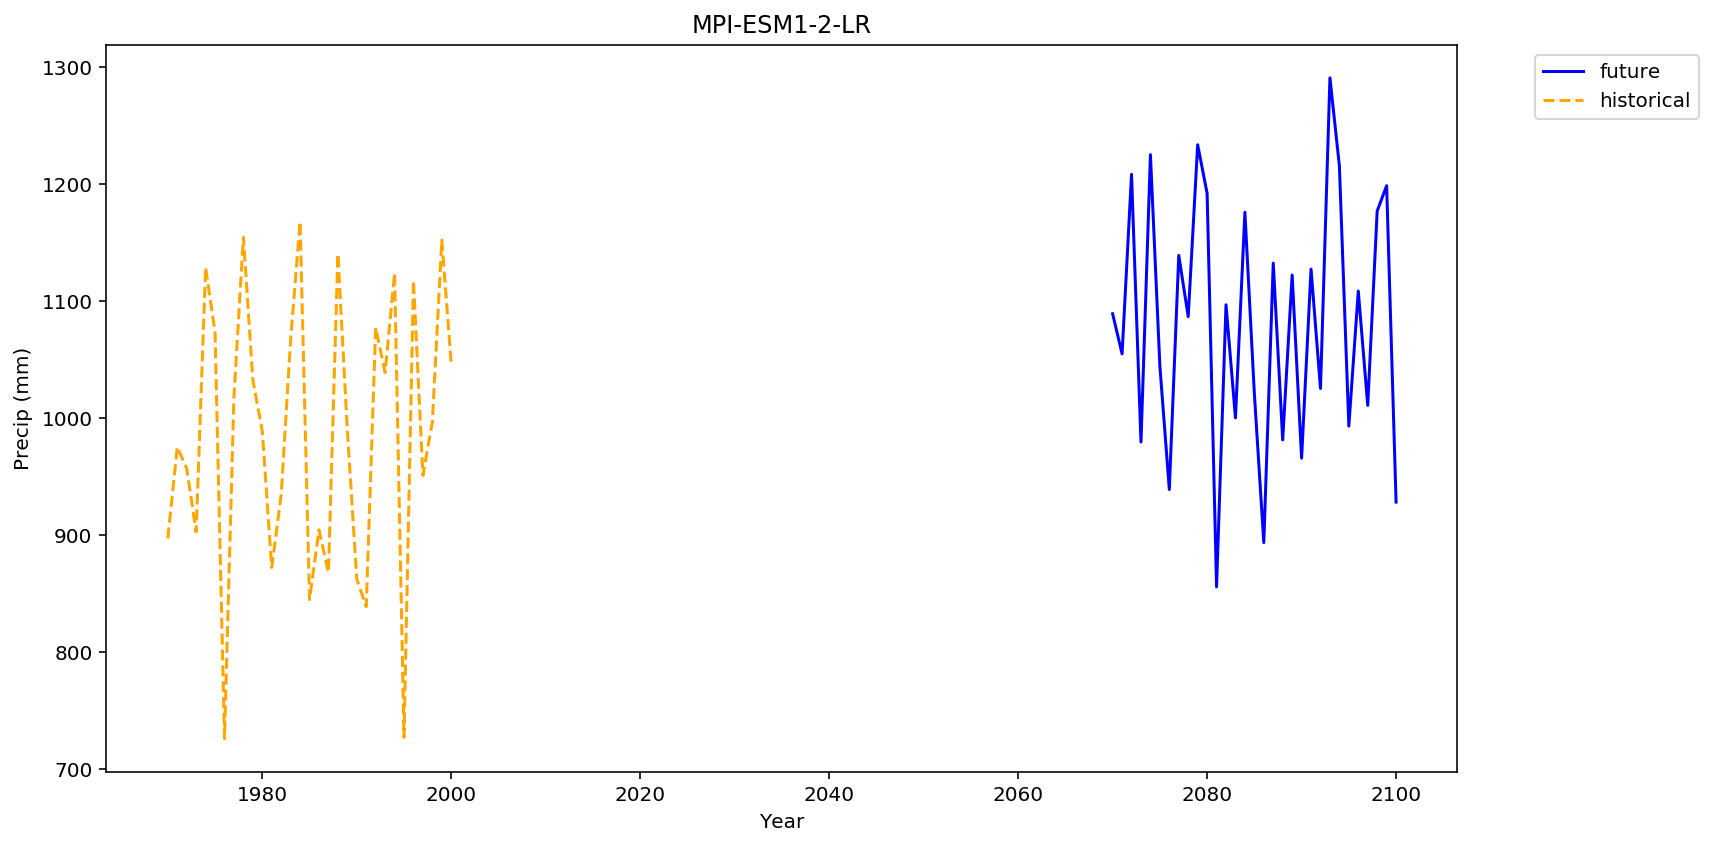

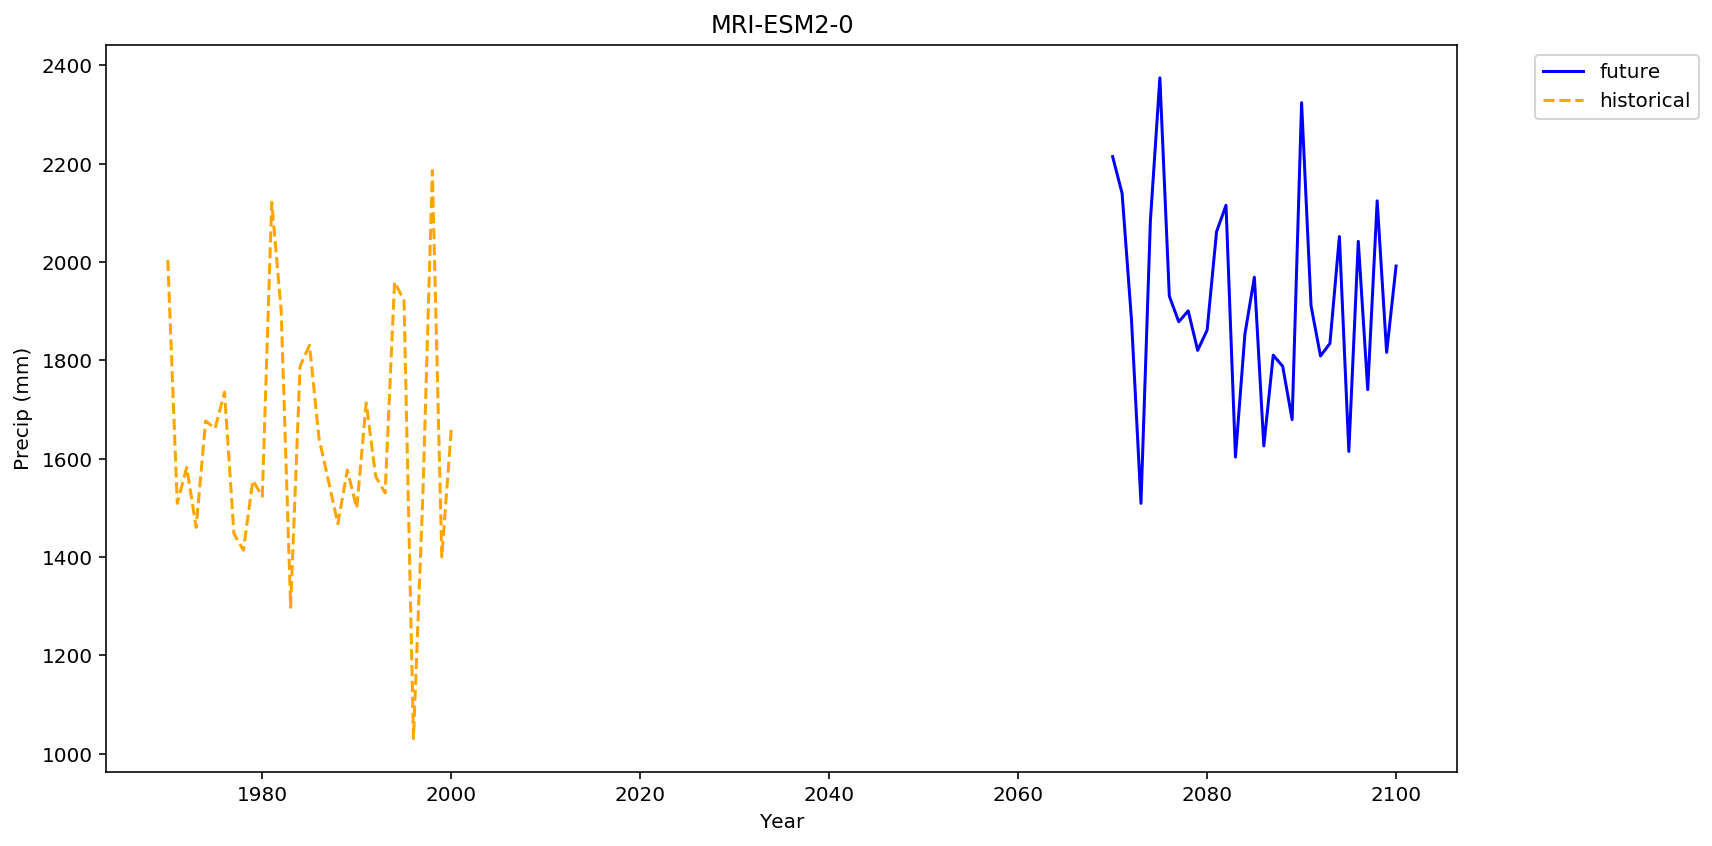

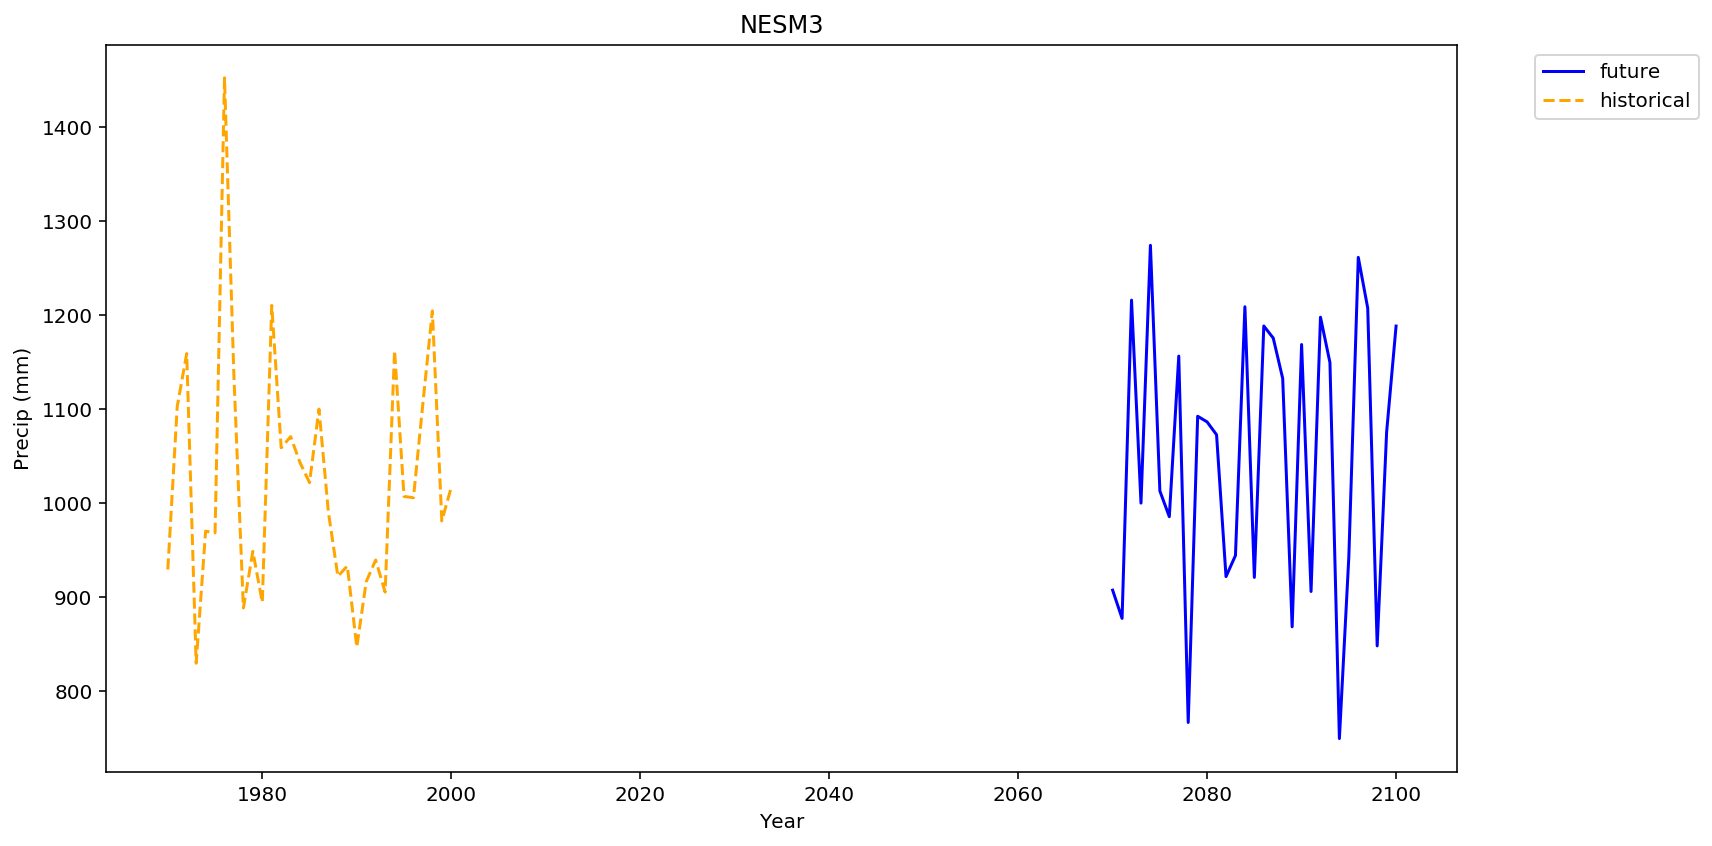

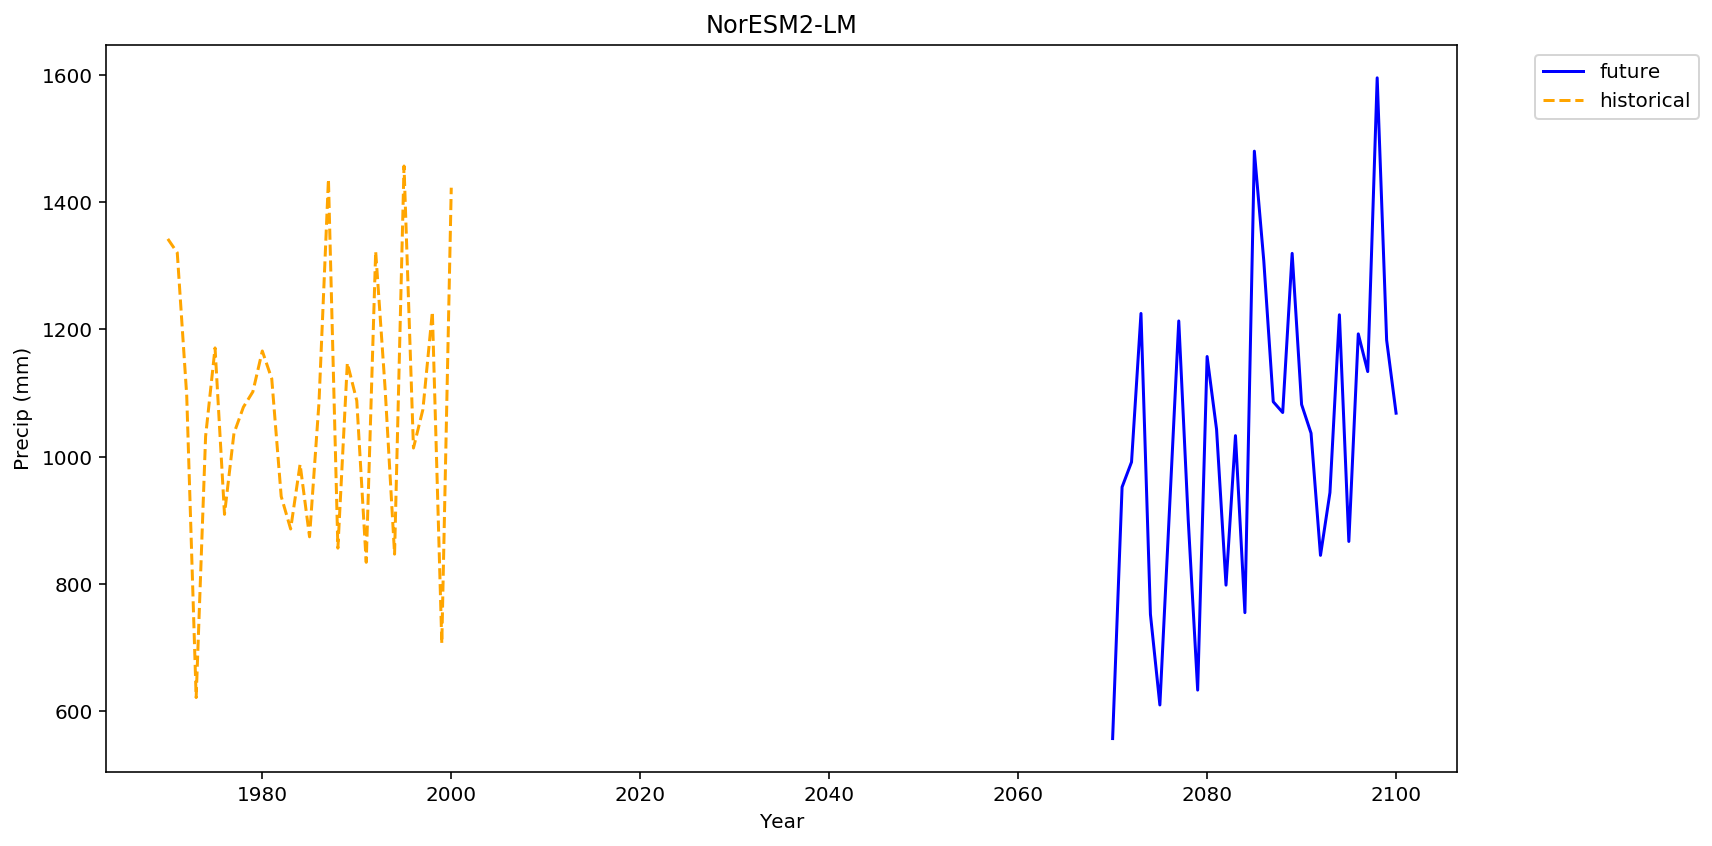

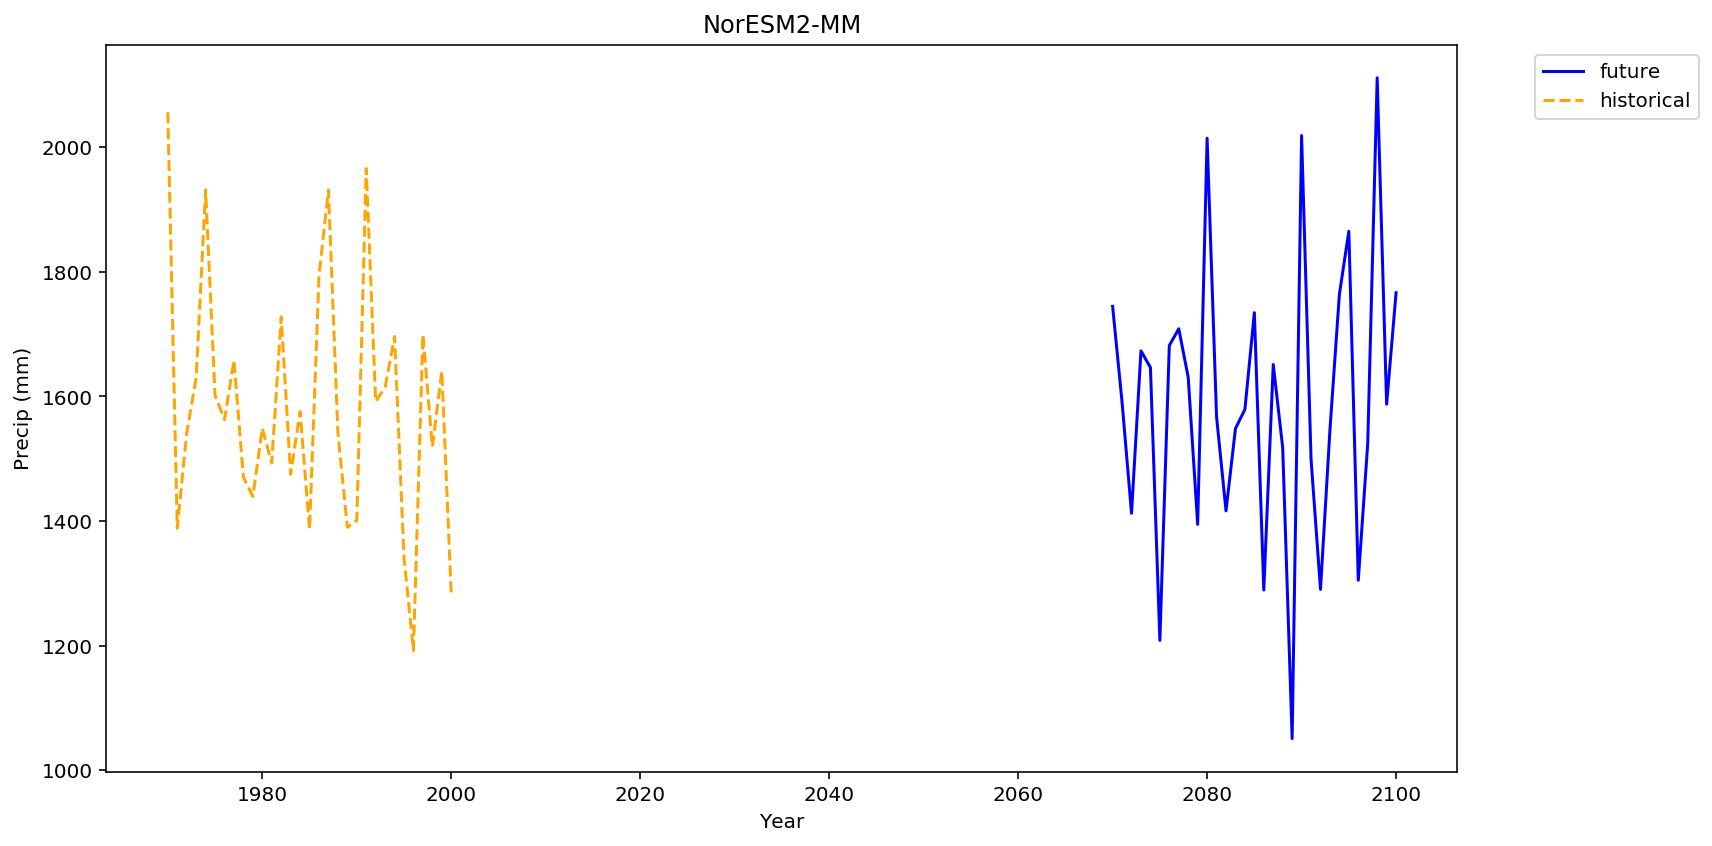

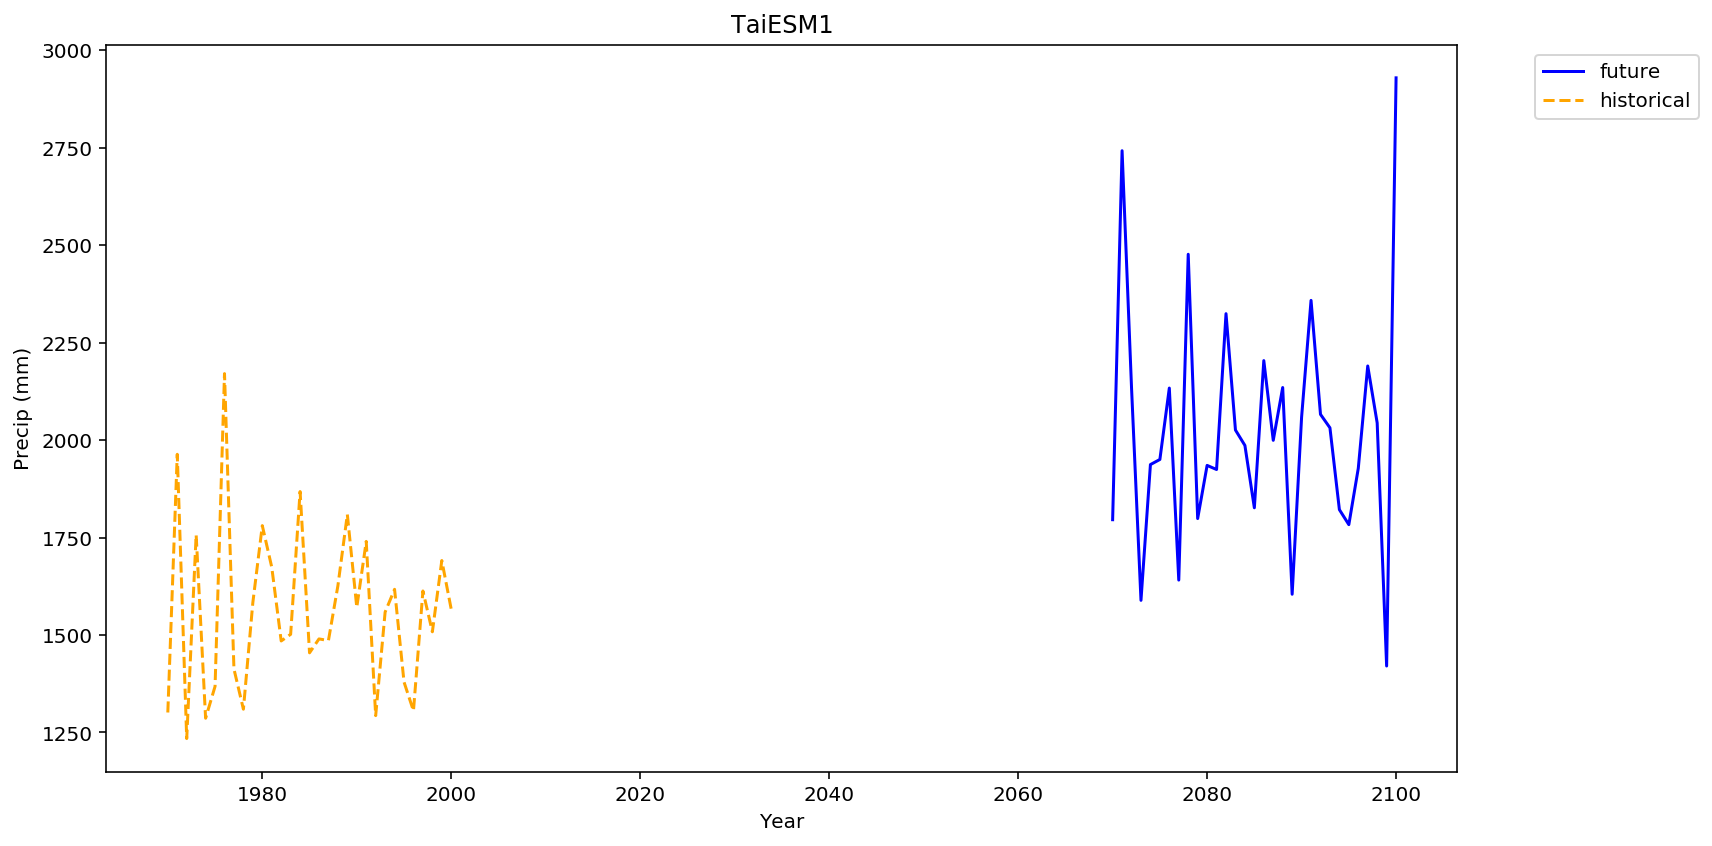

In [41]:
for (source_id, pr_hist), (source_id, pr_ssp) in zip(hist_results.items(), ssp_results.items()):
    pr_ssp2 = pd.DataFrame({'date':pr_ssp.time, 'pr': pr_ssp.pr})
    pr_hist2 = pd.DataFrame({'date':pr_hist.time, 'pr': pr_hist.pr})
    
    if source_id != "HadGEM3-GC31-LL":
        if source_id != "HadGEM3-GC31-MM":
            if source_id != "KACE-1-0-G":
                if source_id != "UKESM1-0-LL":
                    if pr_ssp2.date.dtype == "datetime64[ns]":
                        pr_ssp2['date'] = pd.to_datetime(pr_ssp2['date'])
                        pr_hist2['date']= pd.to_datetime(pr_hist2['date'])
                    elif pr_ssp2.date.dtype == "object":
                        pr_ssp2['date'] =  pr_ssp2['date'].astype(str)
                        pr_ssp2['date'] = pd.to_datetime(pr_ssp2['date'])
                        
                        
                        pr_hist2['date'] =  pr_hist2['date'].astype(str)
                        pr_hist2['date'] = pd.to_datetime(pr_hist2['date'])

                    else:
                        print(pr_ssp2.date.dtype)
                        
                    ssp = pr_ssp2.groupby(pr_ssp2['date'].dt.year).sum()
                    hist = pr_hist2.groupby(pr_hist2['date'].dt.year).sum()
                    plt.plot(ssp.pr * 86400, label="future")
                    plt.plot(hist.pr * 86400, label="historical")

                    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                    plt.ylabel("Precip (mm)")
                    plt.xlabel("Year")
                    plt.title(source_id)
                    plt.tight_layout()
                    # plt.savefig("hist-1970.png")
                    plt.show()
    # plot_precip_changes(pr_hist,"hist-1970")

In [37]:
pr_hists = [precip_ts(ds).load() for ds in [ds_hist, ds_ssp]]

In [35]:
ds_hist

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 144, lon: 192, time: 11160)
Coordinates:
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * time       (time) object 1970-01-01 12:00:00 ... 2000-12-30 12:00:00
    time_bnds  (time, bnds) object 1970-01-01 00:00:00 ... 2001-01-01 00:00:00
Dimensions without coordinates: bnds
Data variables:
    pr         (time, lat, lon) float32 dask.array<chunksize=(540, 144, 192), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  176400.0
    cmor_version:           3.4.0
    creation_date:          2019-12-09T16:10:51Z
    cv_version:             6.2.37.5
    data_specs_version:     01.00.29
    experiment:             all-forcing simulation of the recent past
    experiment_id:          historical
    external_variables:     areacella
    forcing_index:          2
    frequency:              day
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.MOHC.UKESM1-...
    grid:                   Native N96 grid; 192 x 144 longitude/latitude
    grid_label:             gn
    history:                2019-12-09T12:37:07Z ; CMOR rewrote data to be co...
    initialization_index:   1
    institution:            Met Office Hadley Centre, Fitzroy Road, Exeter, D...
    institution_id:         MOHC
    license:                CMIP6 model data produced by the Met Office Hadle...
    mip_era:                CMIP6
    mo_runid:               u-bd288
    nominal_resolution:     250 km
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       UKESM1-0-LL
    parent_time_units:      days since 1850-01-01
    parent_variant_label:   r1i1p1f2
    physics_index:          1
    product:                model-output
    realization_index:      10
    realm:                  atmos
    source:                 UKESM1.0-LL (2018): \naerosol: UKCA-GLOMAP-mode\n...
    source_id:              UKESM1-0-LL
    source_type:            AOGCM AER BGC CHEM
    status:                 2020-04-19;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               day
    table_info:             Creation Date:(13 December 2018) MD5:f0588f7f55b5...
    title:                  UKESM1-0-LL output prepared for CMIP6
    tracking_id:            hdl:21.14100/cb50a3c9-2314-4299-8829-efb27d0b5891...
    variable_id:            pr
    variable_name:          pr
    variant_label:          r10i1p1f2

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


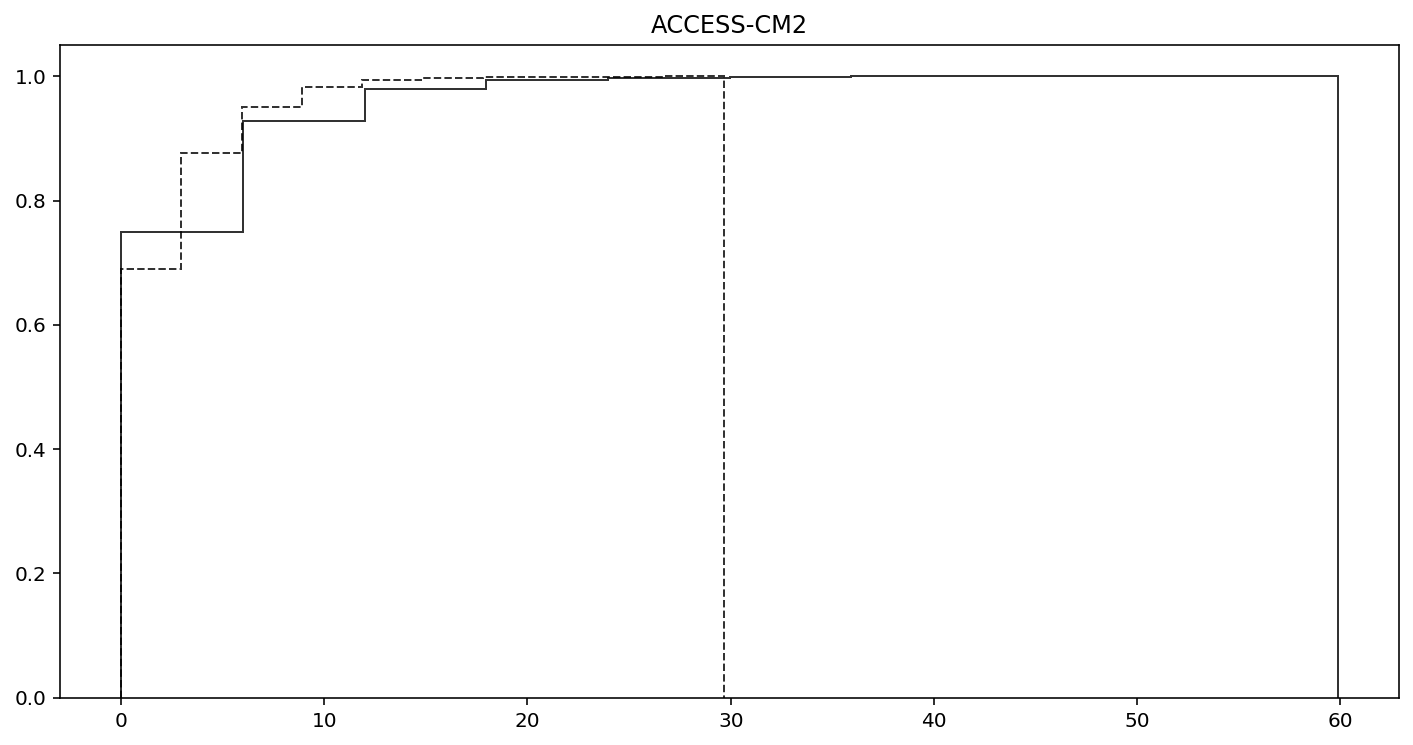

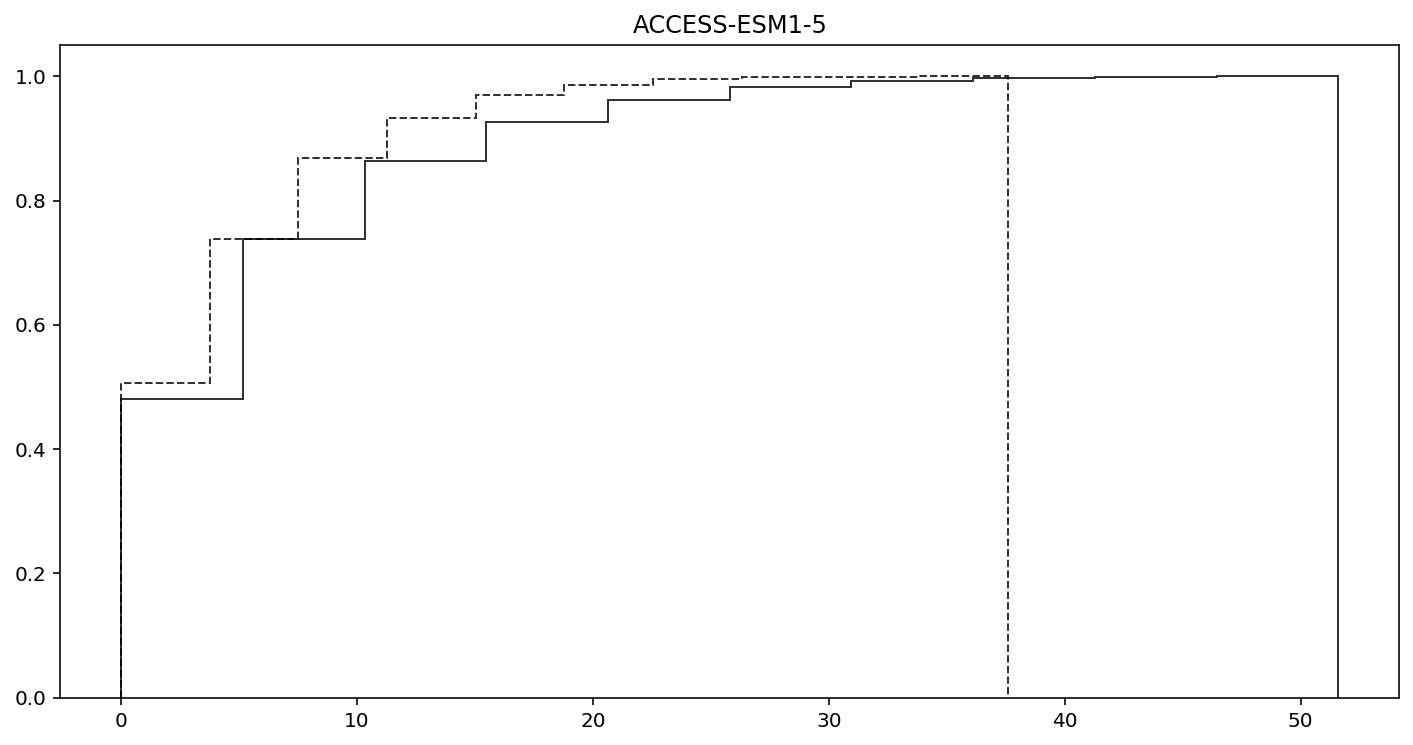

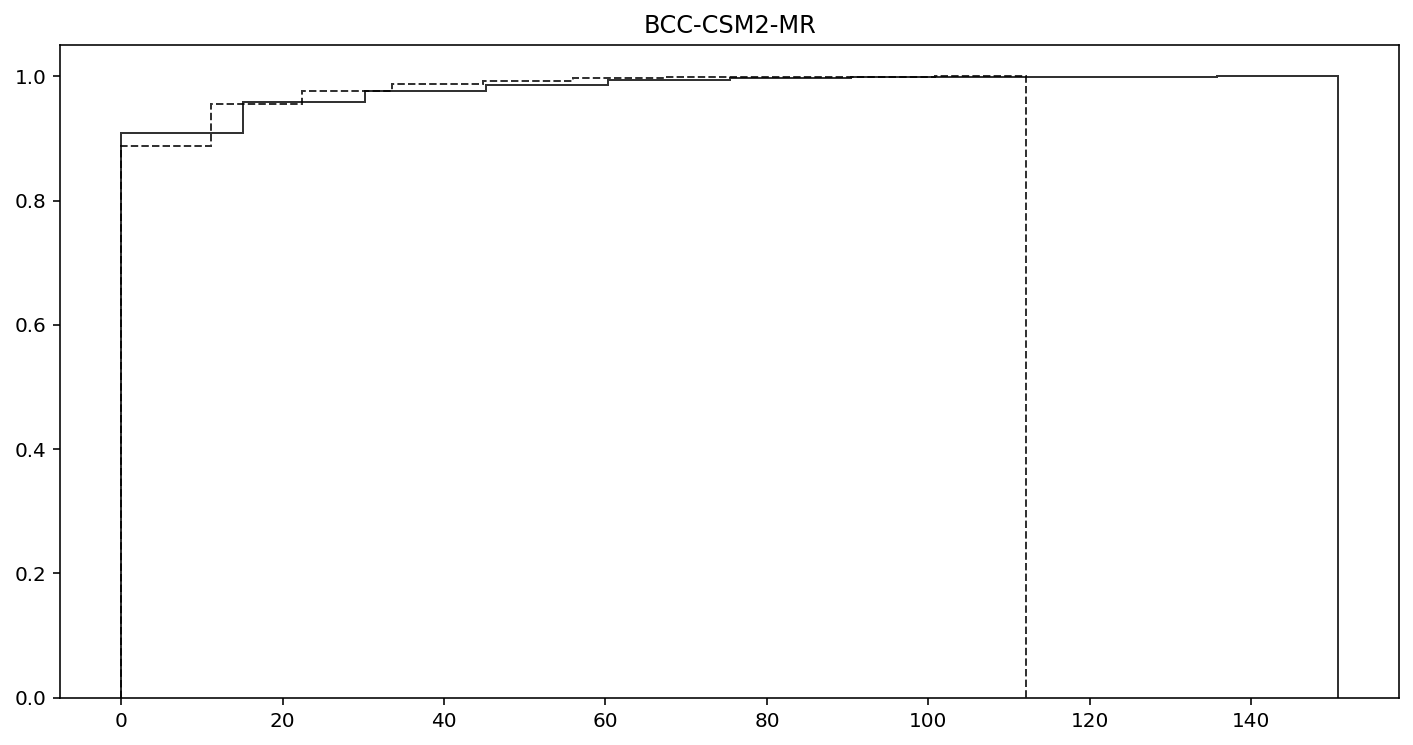

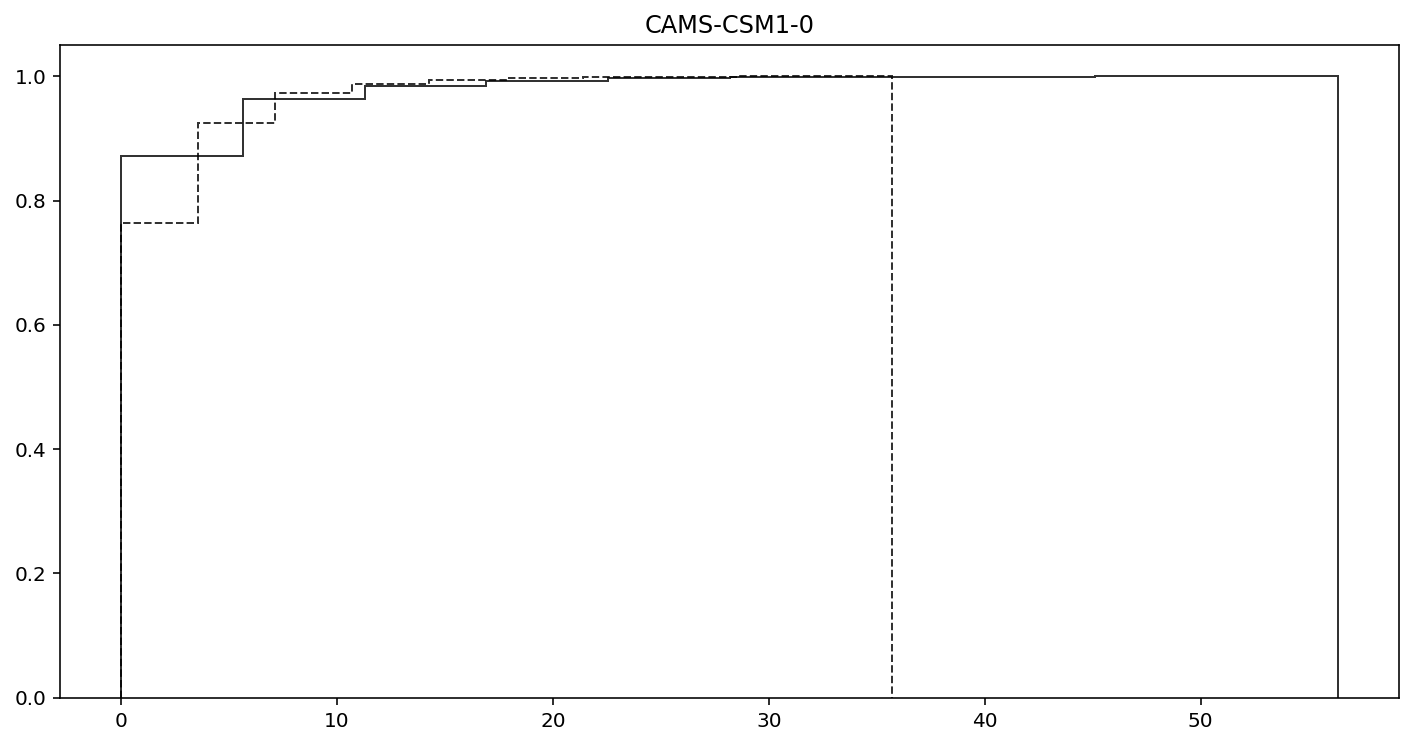

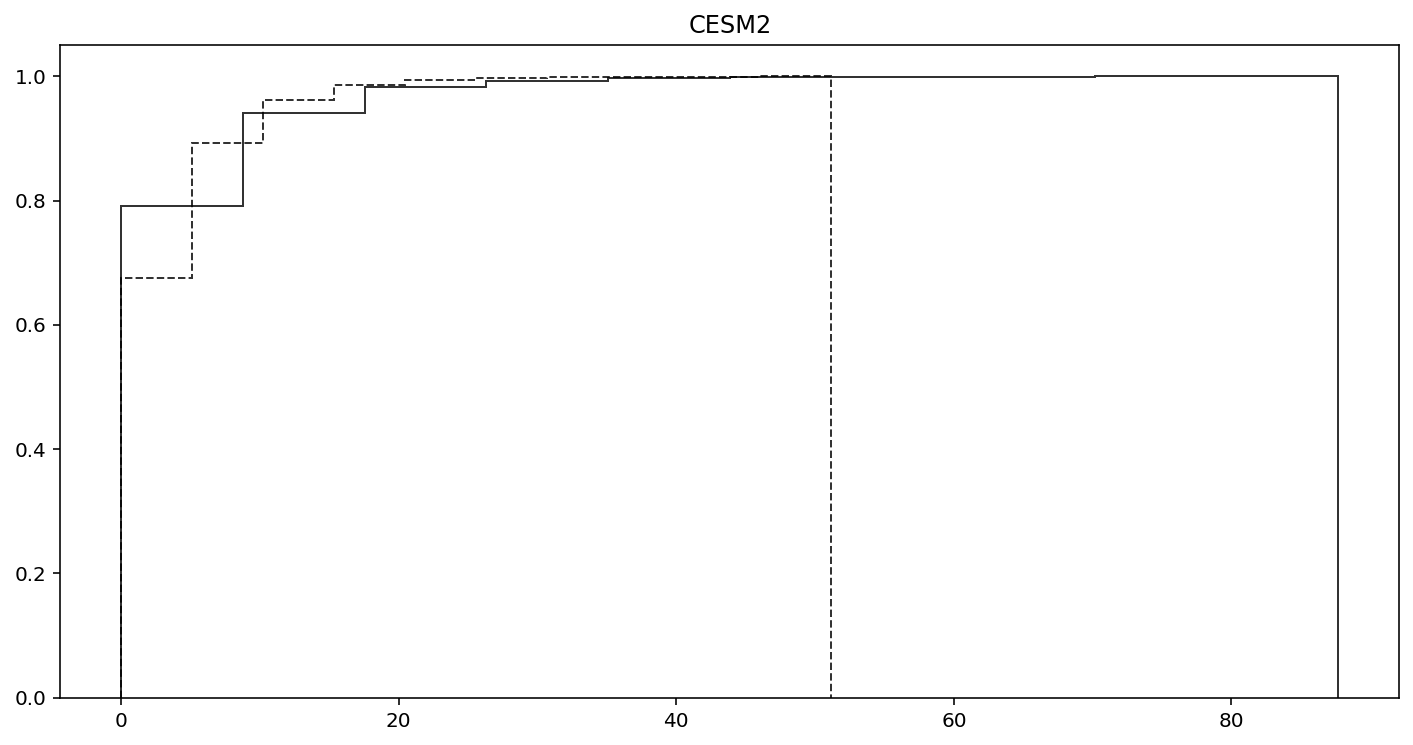

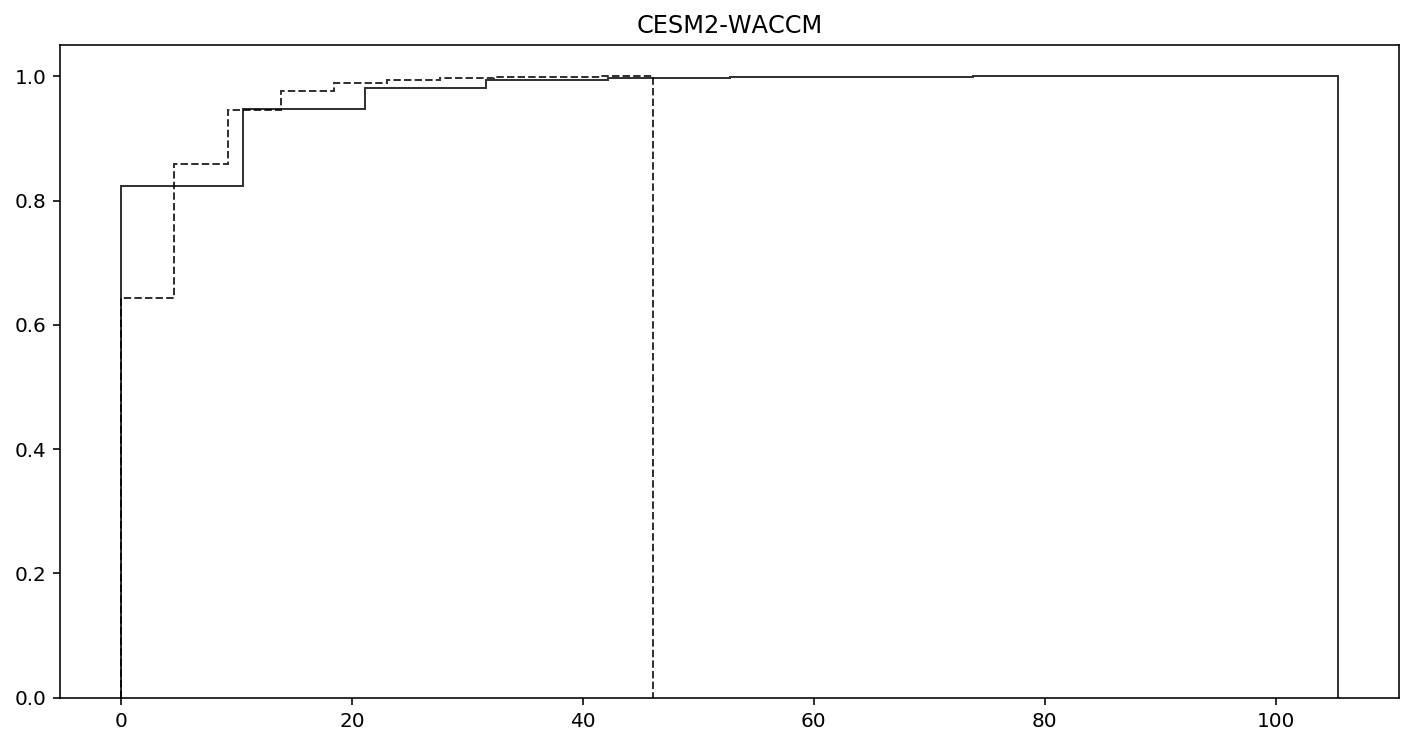

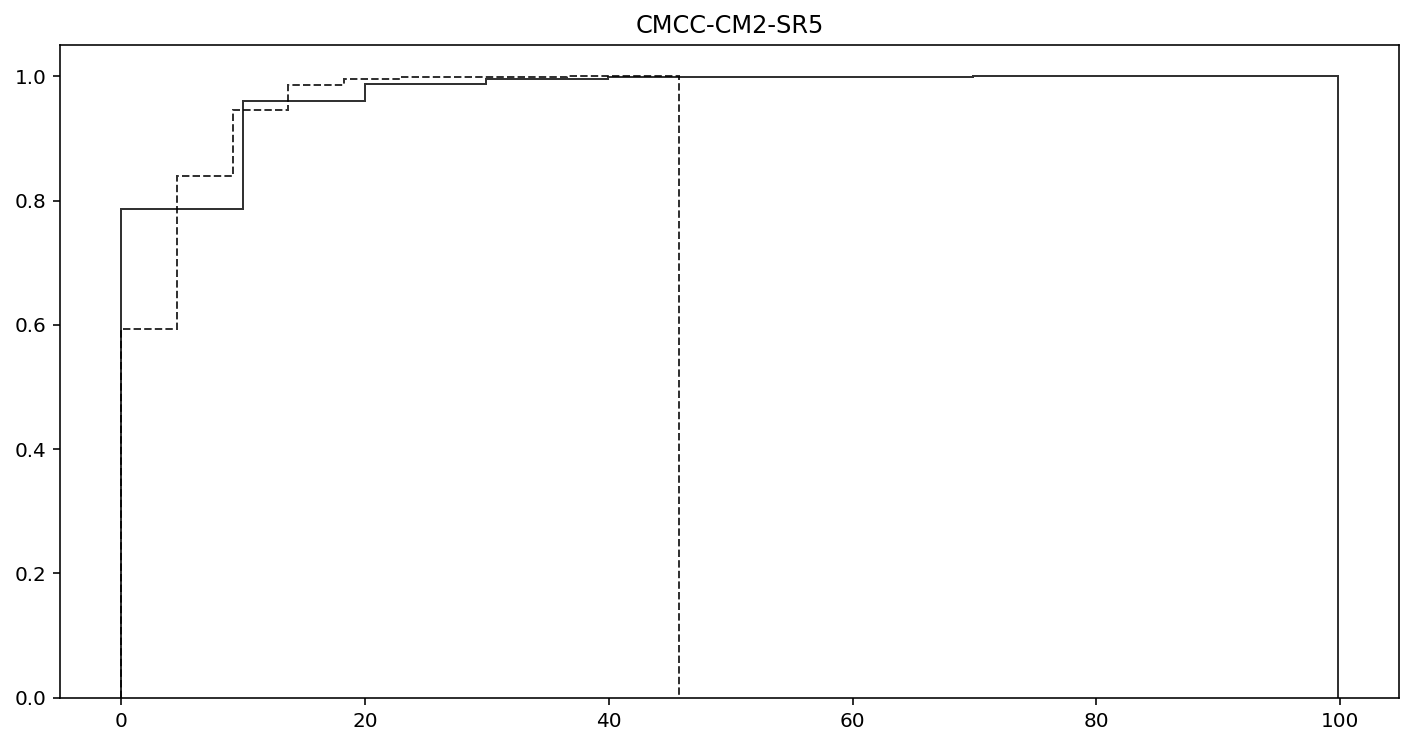

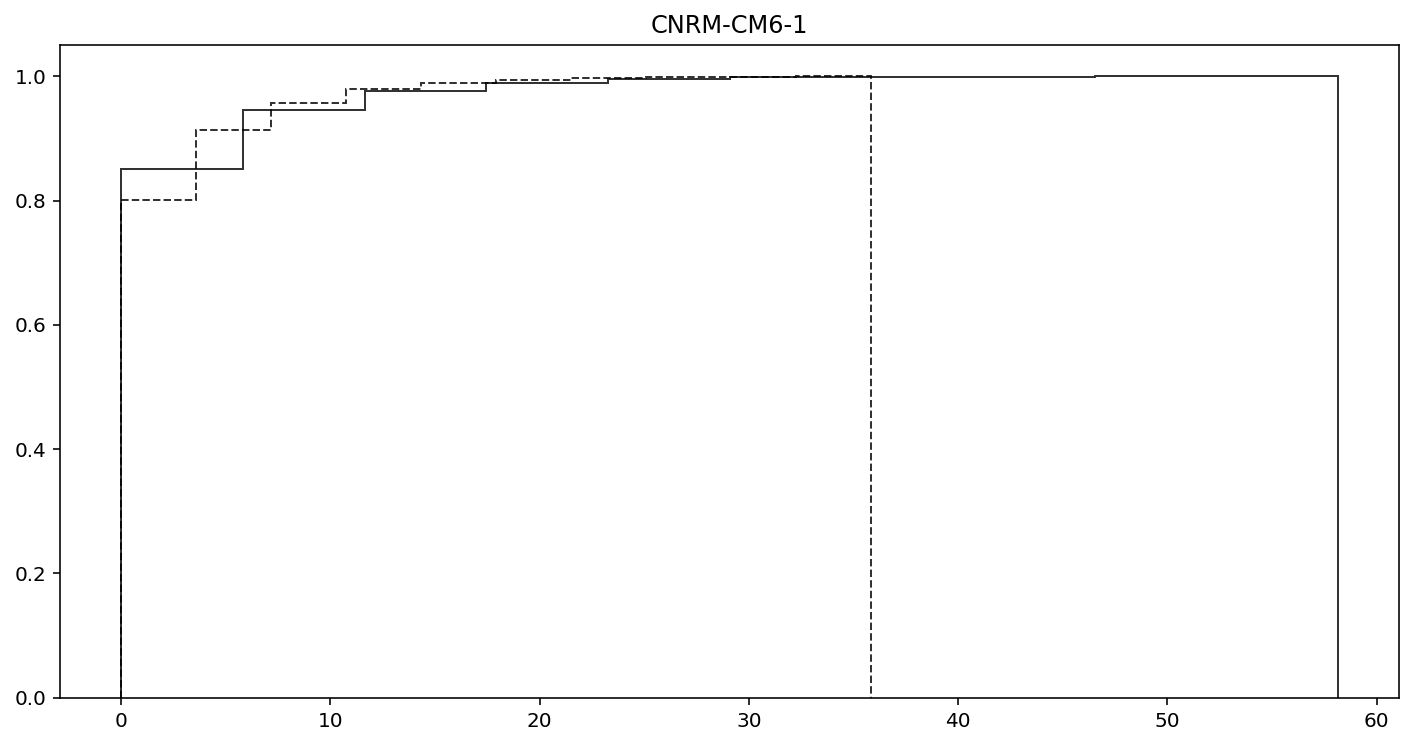

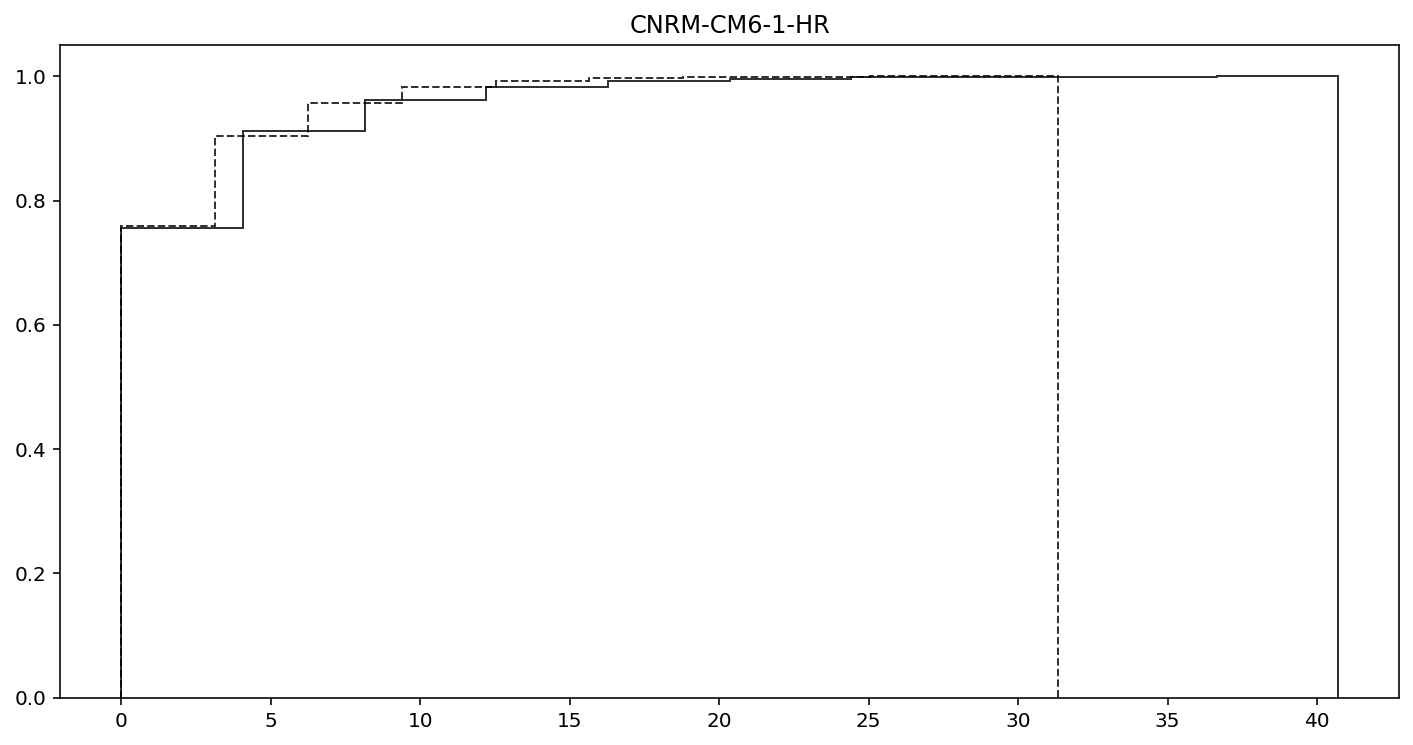

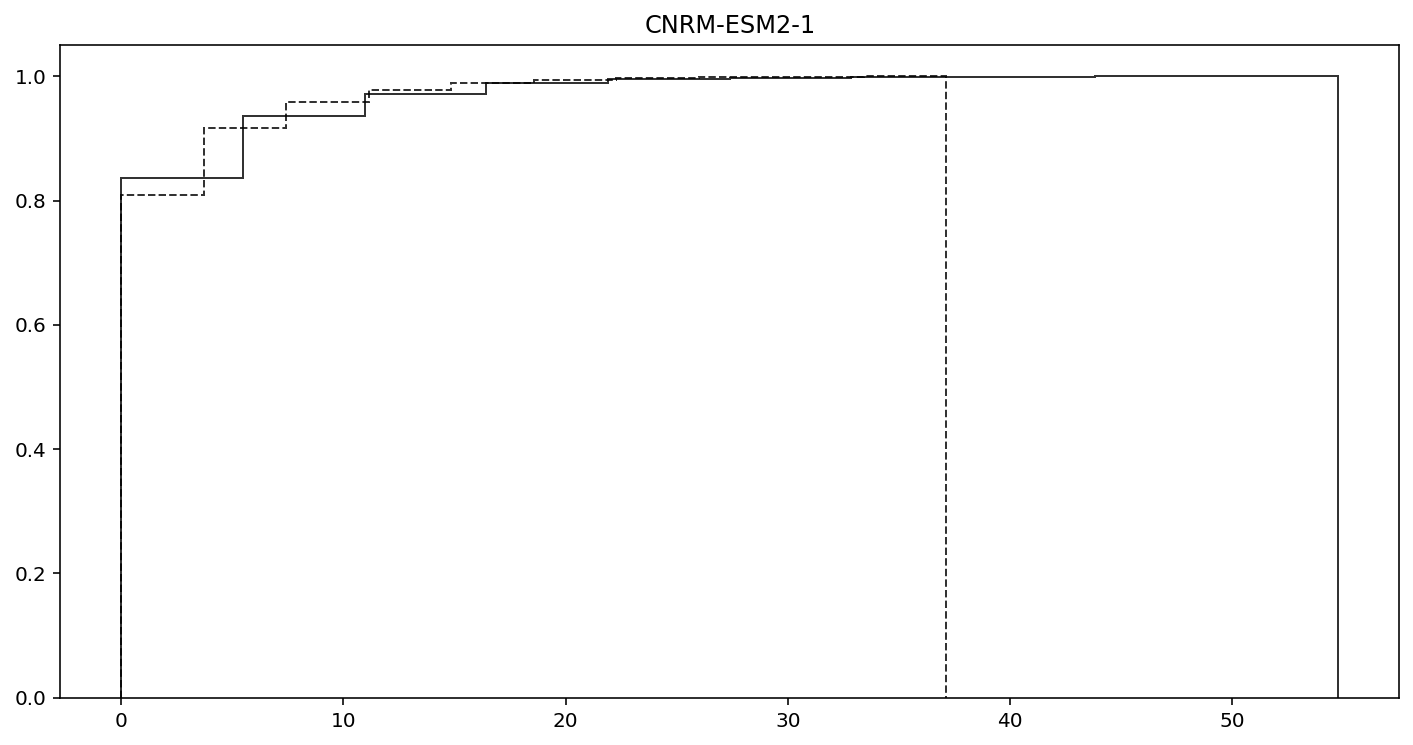

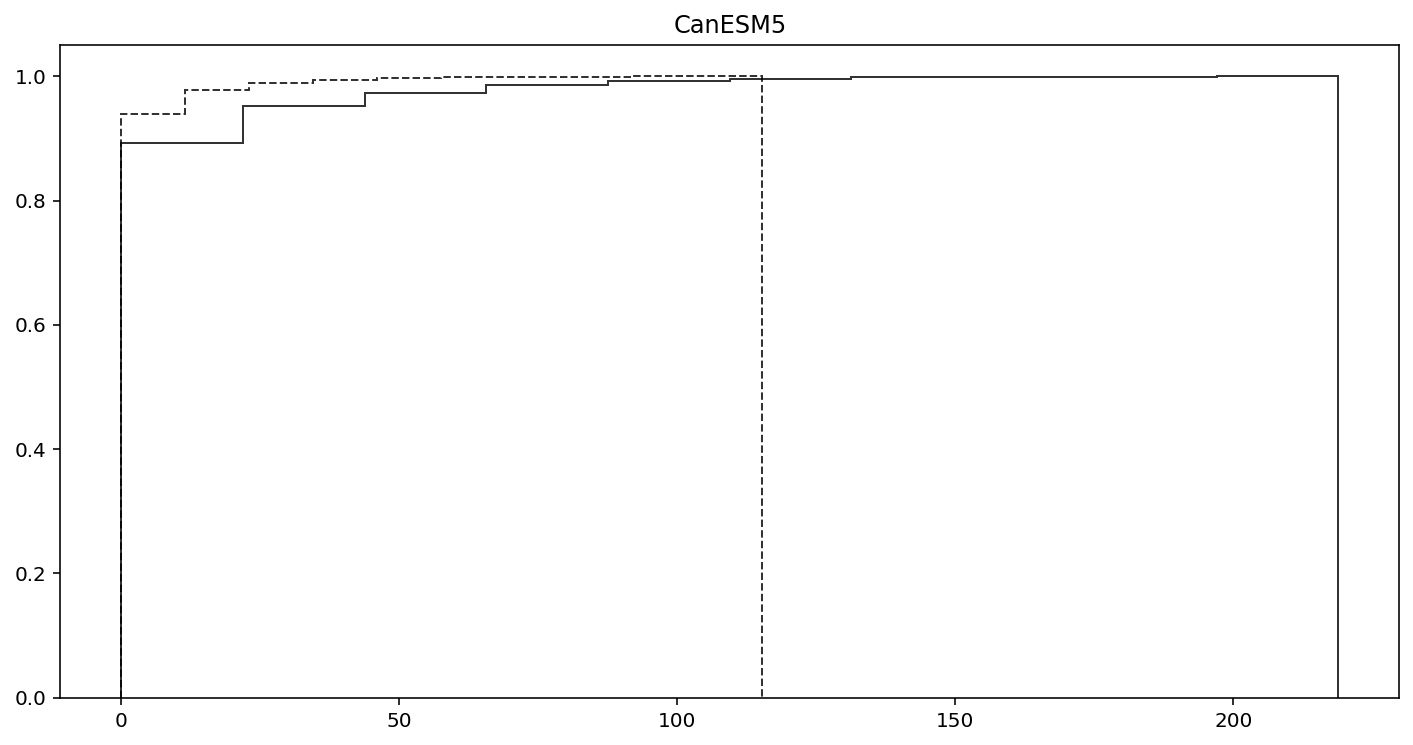

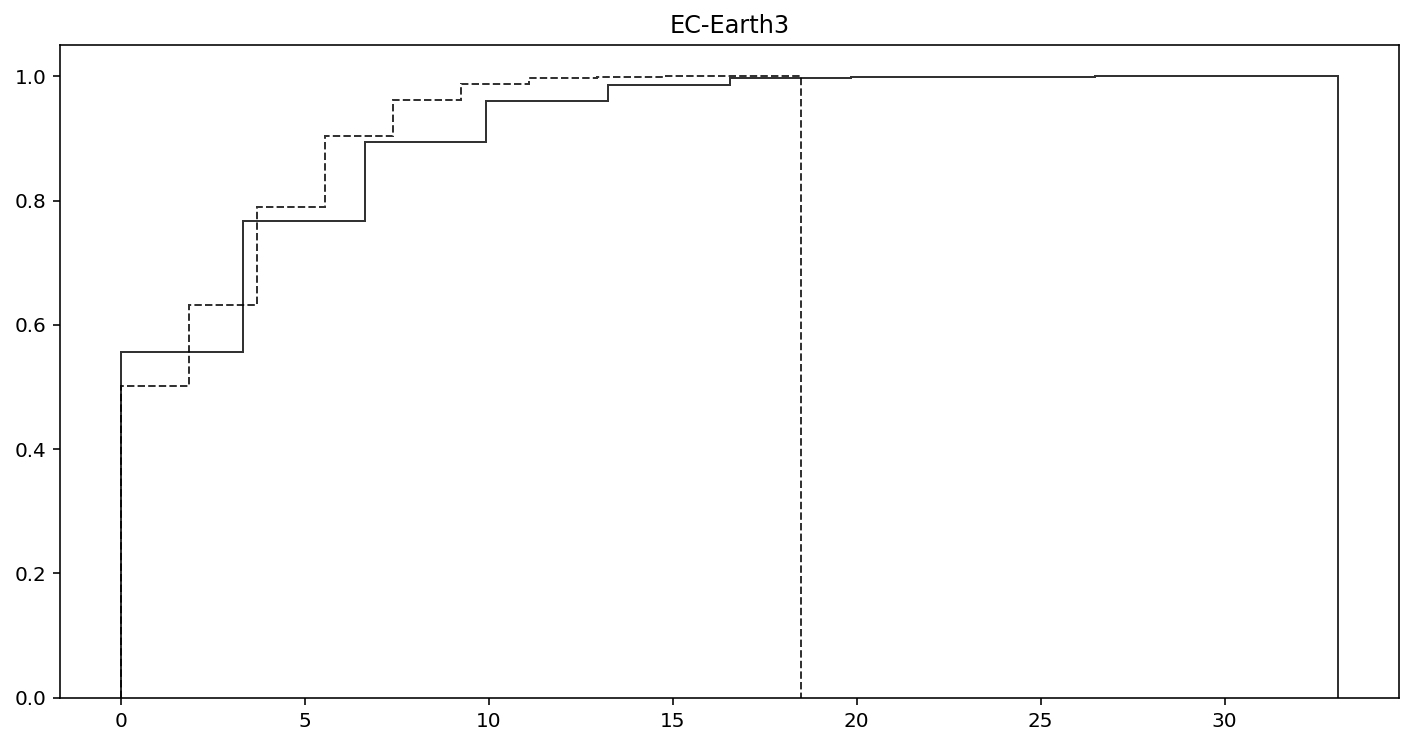

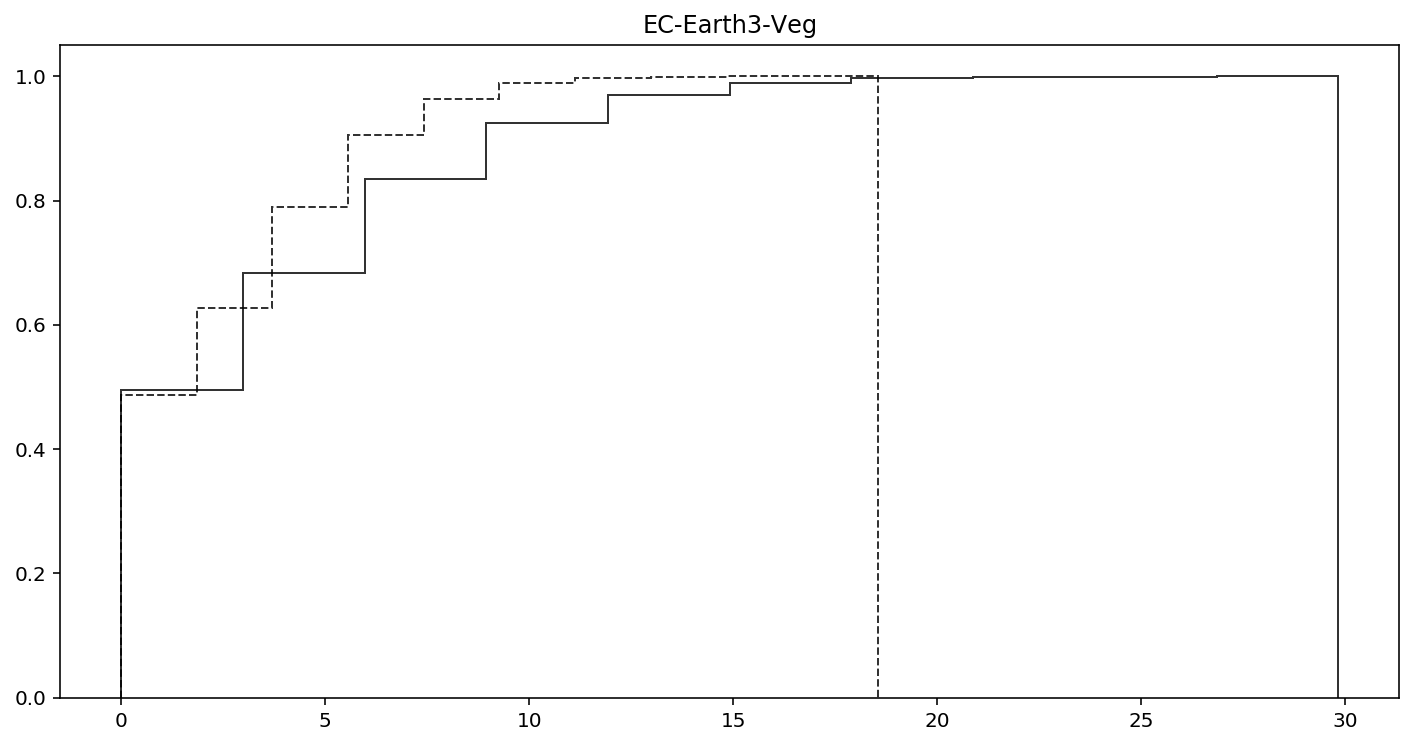

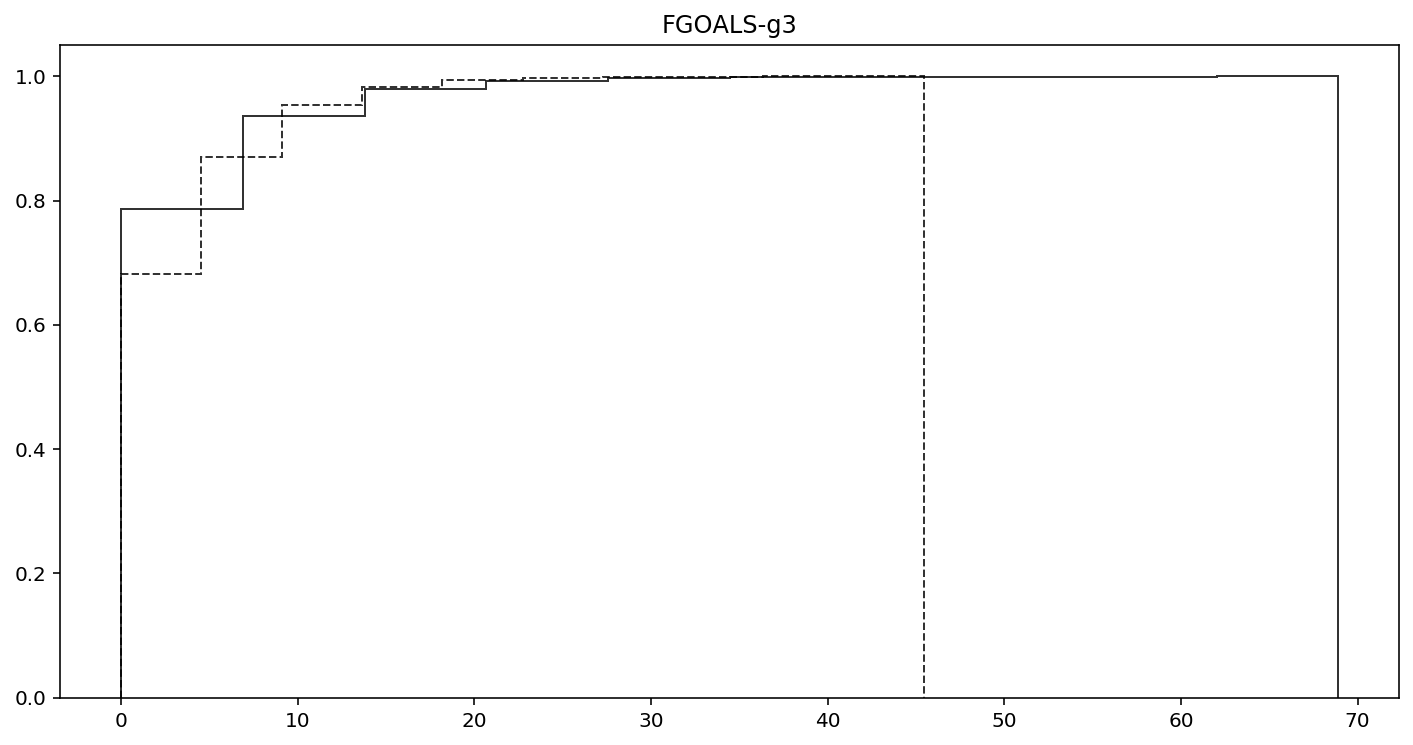

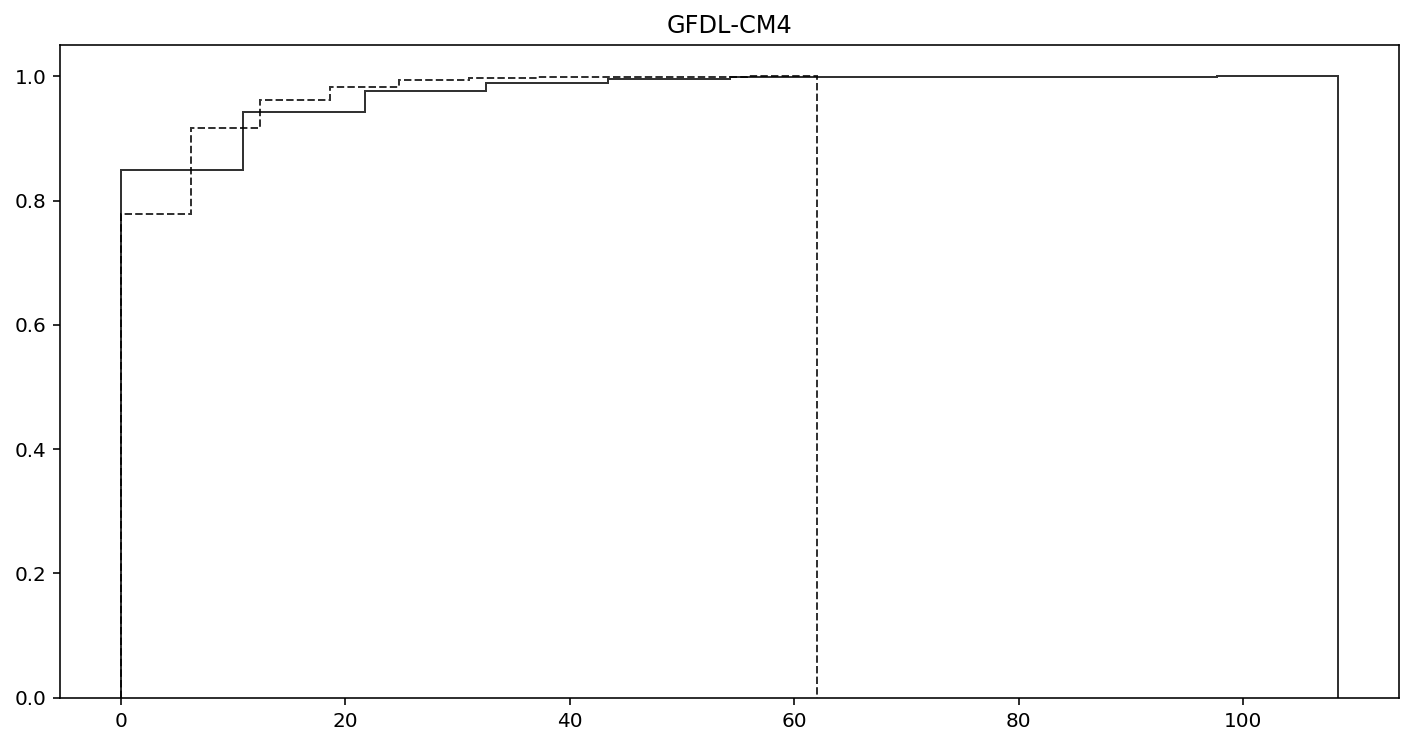

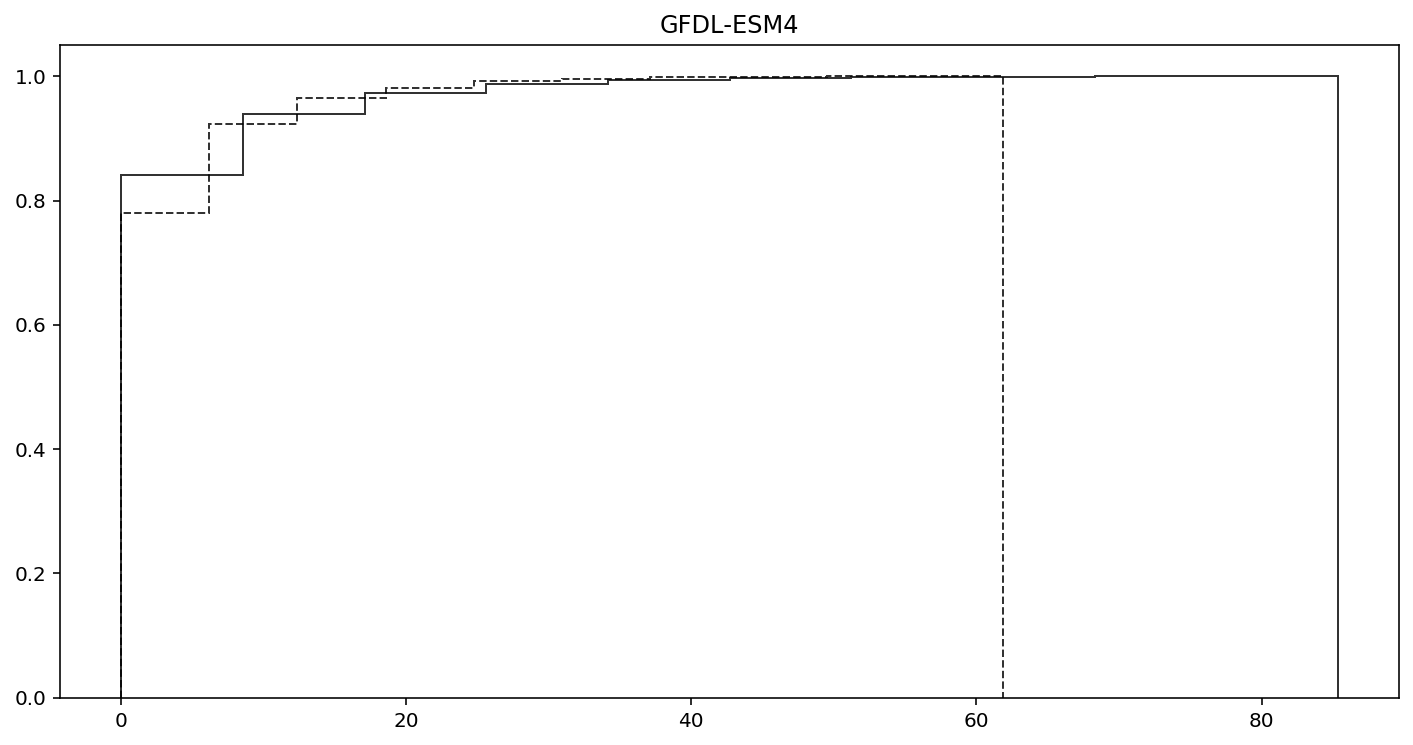

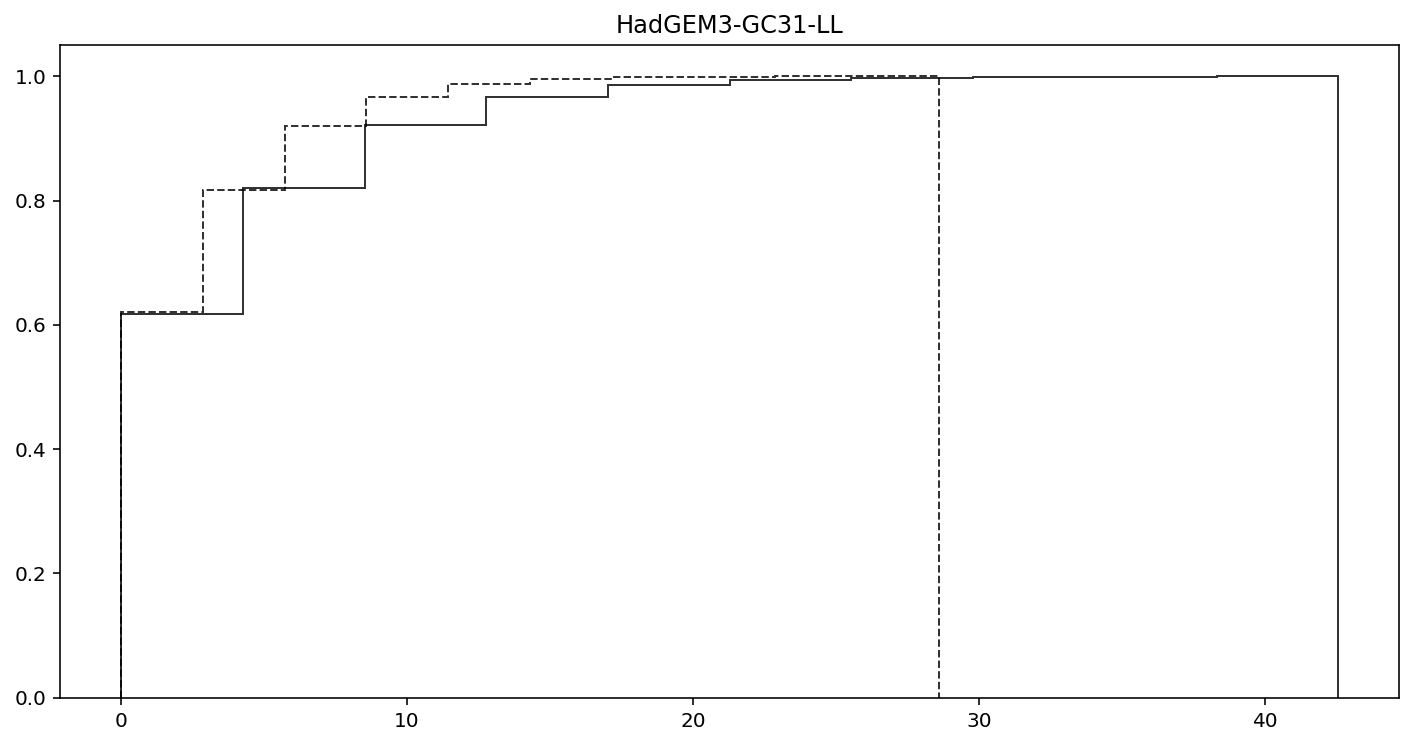

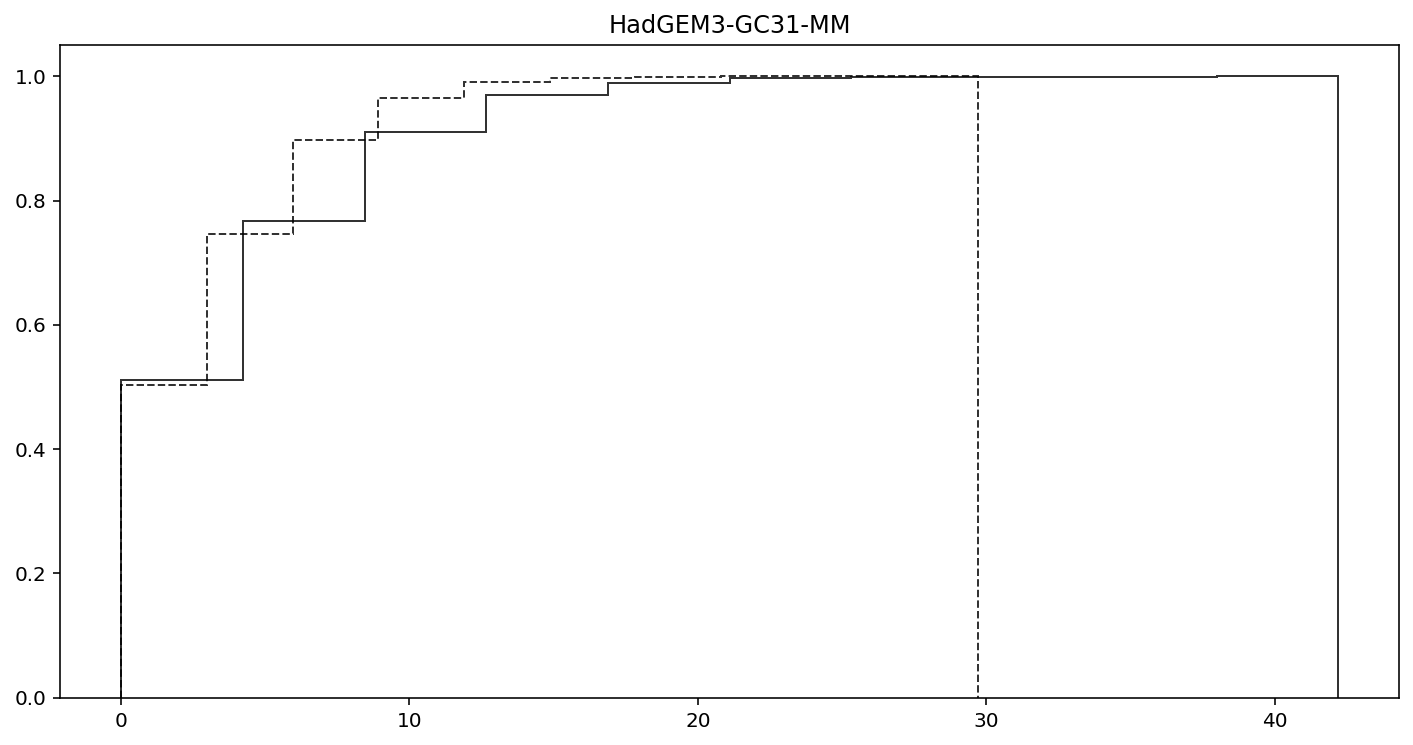

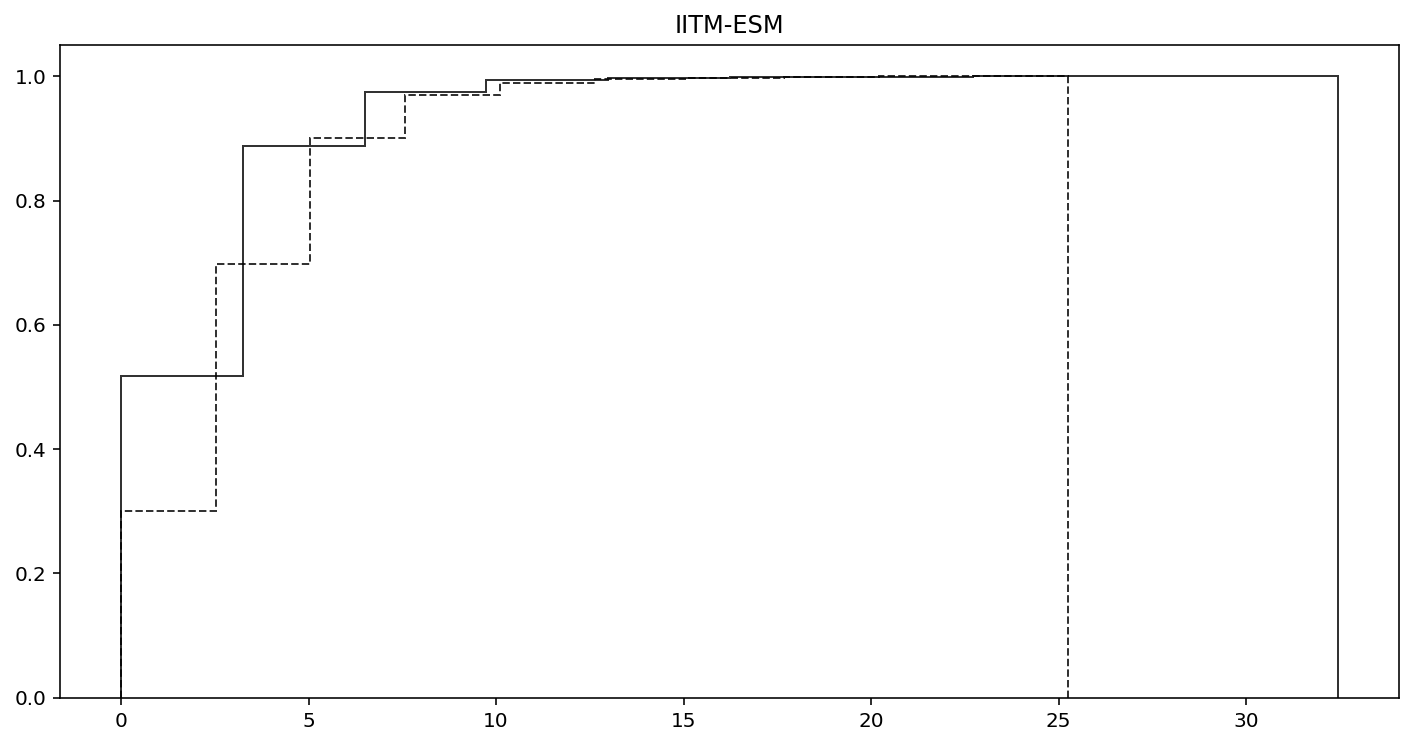

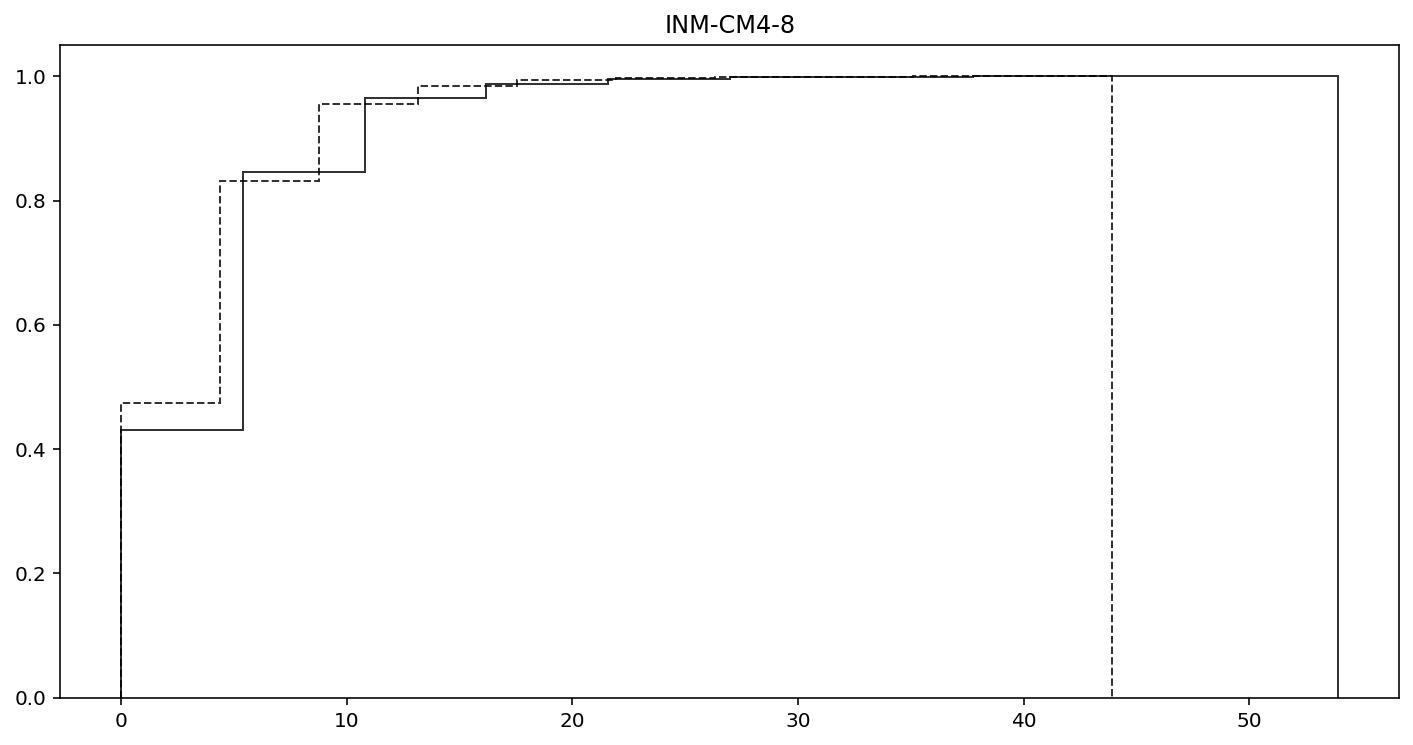

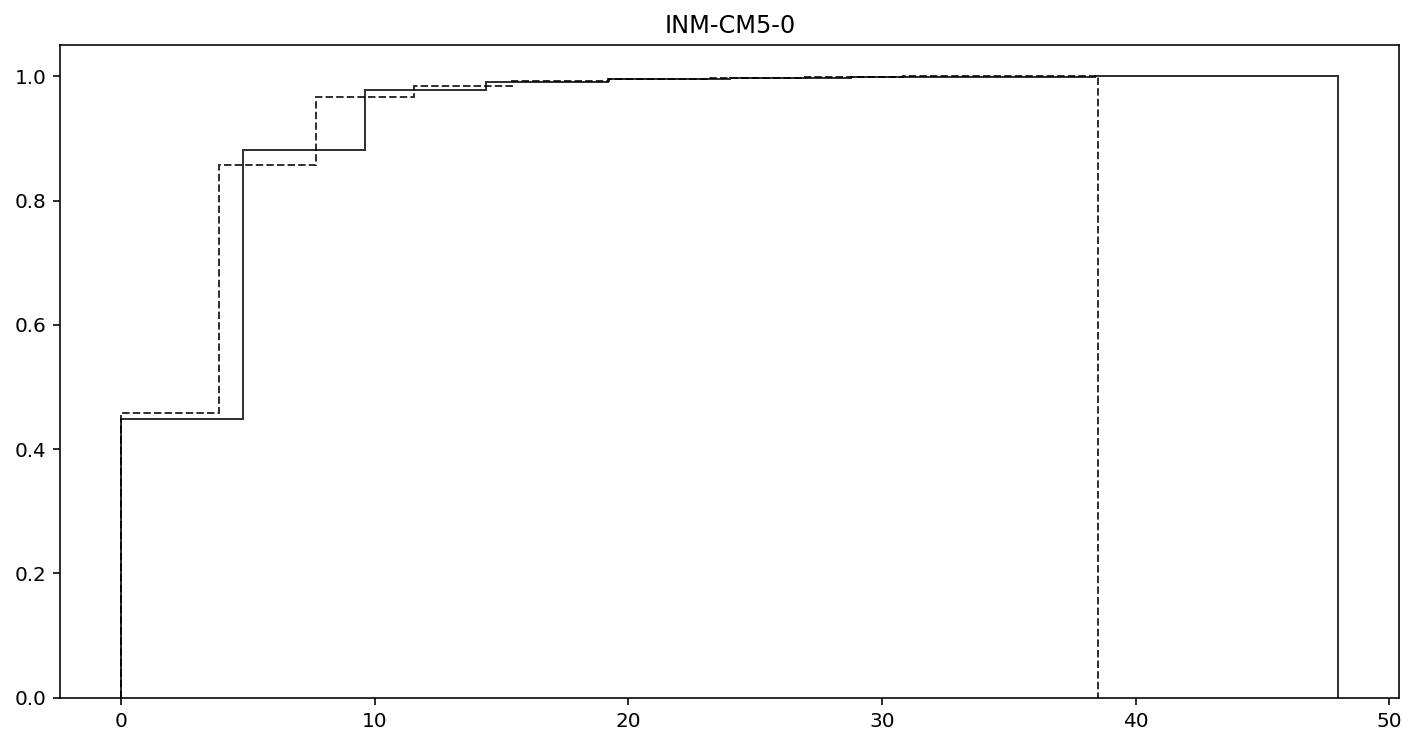

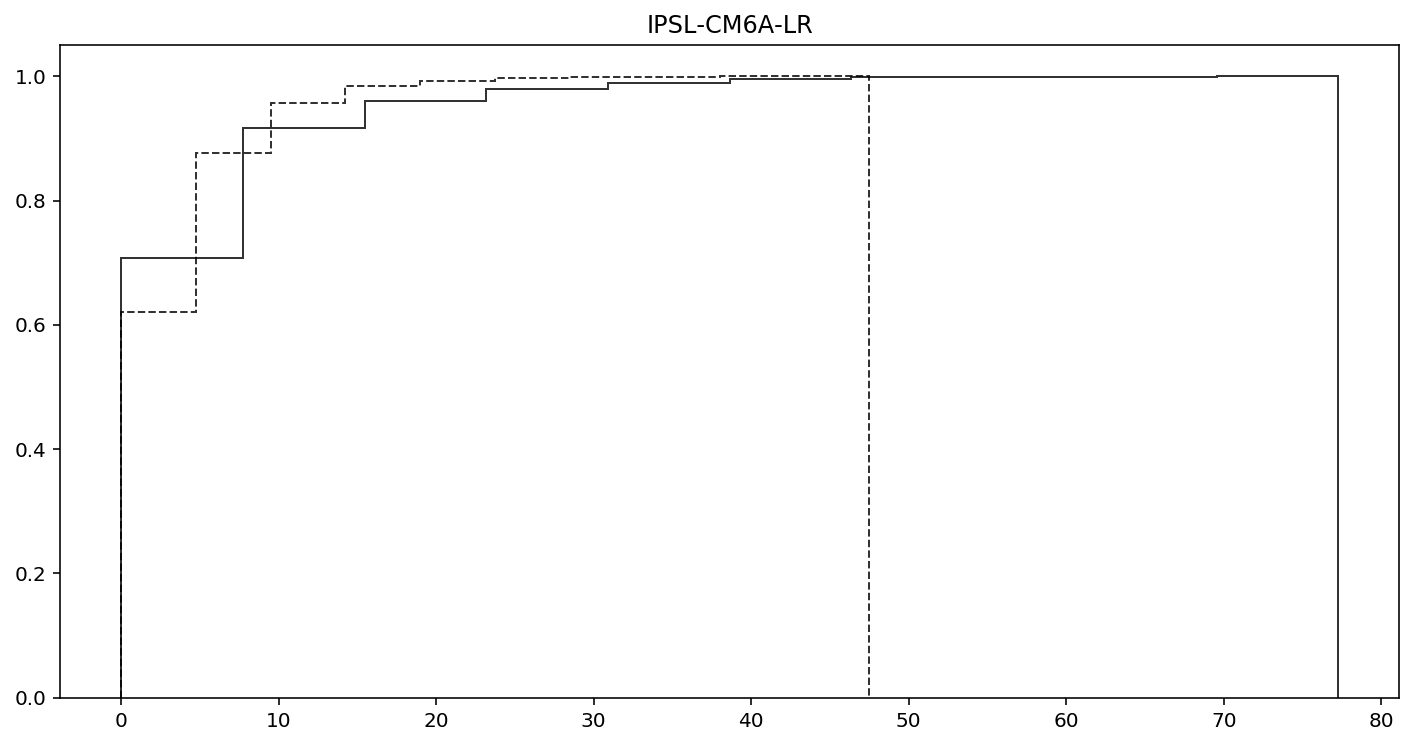

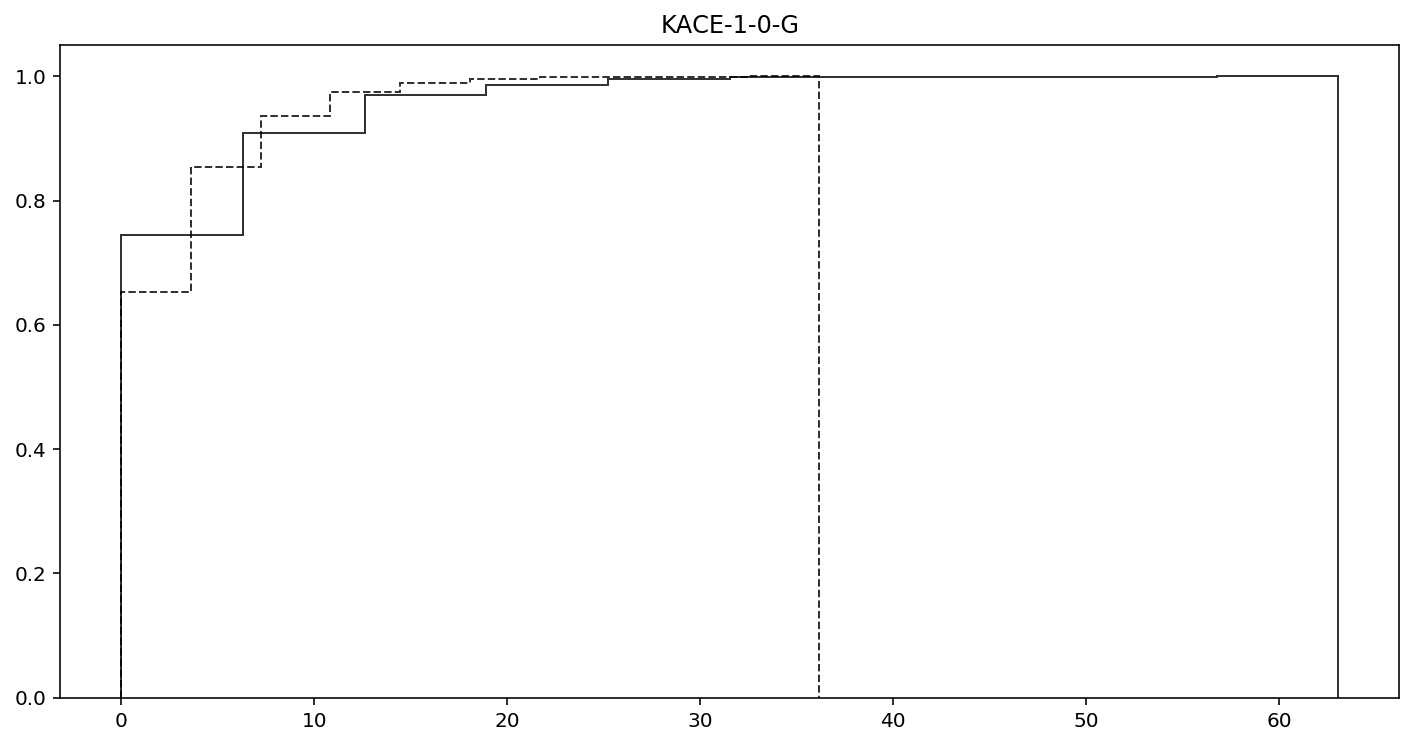

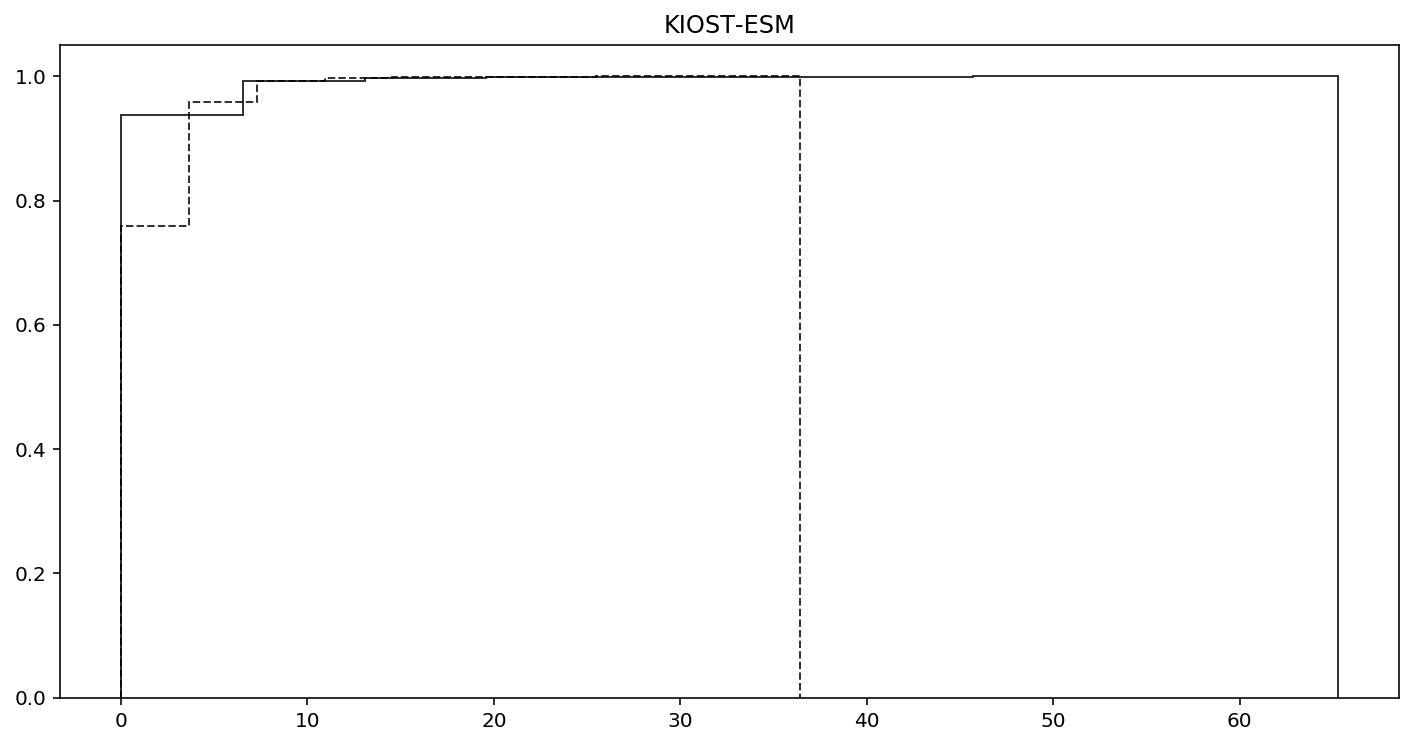

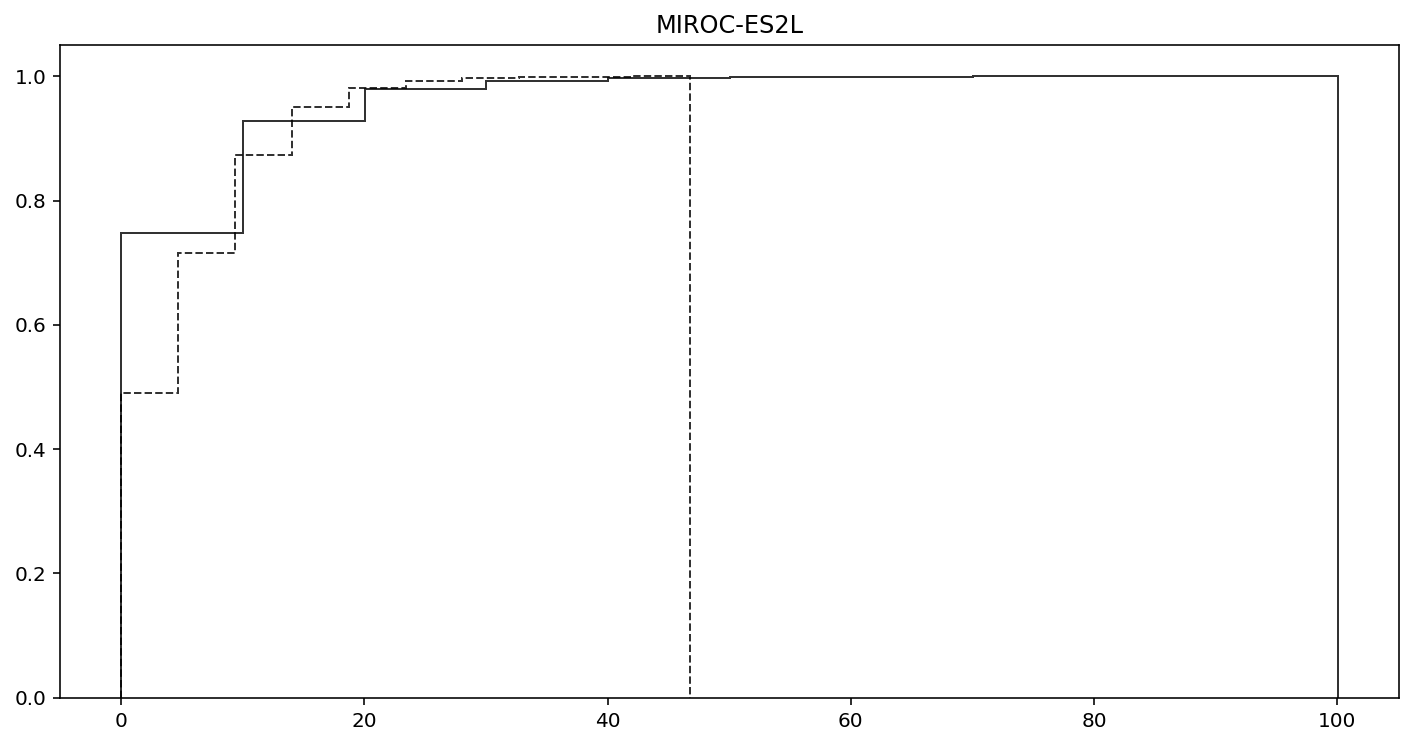

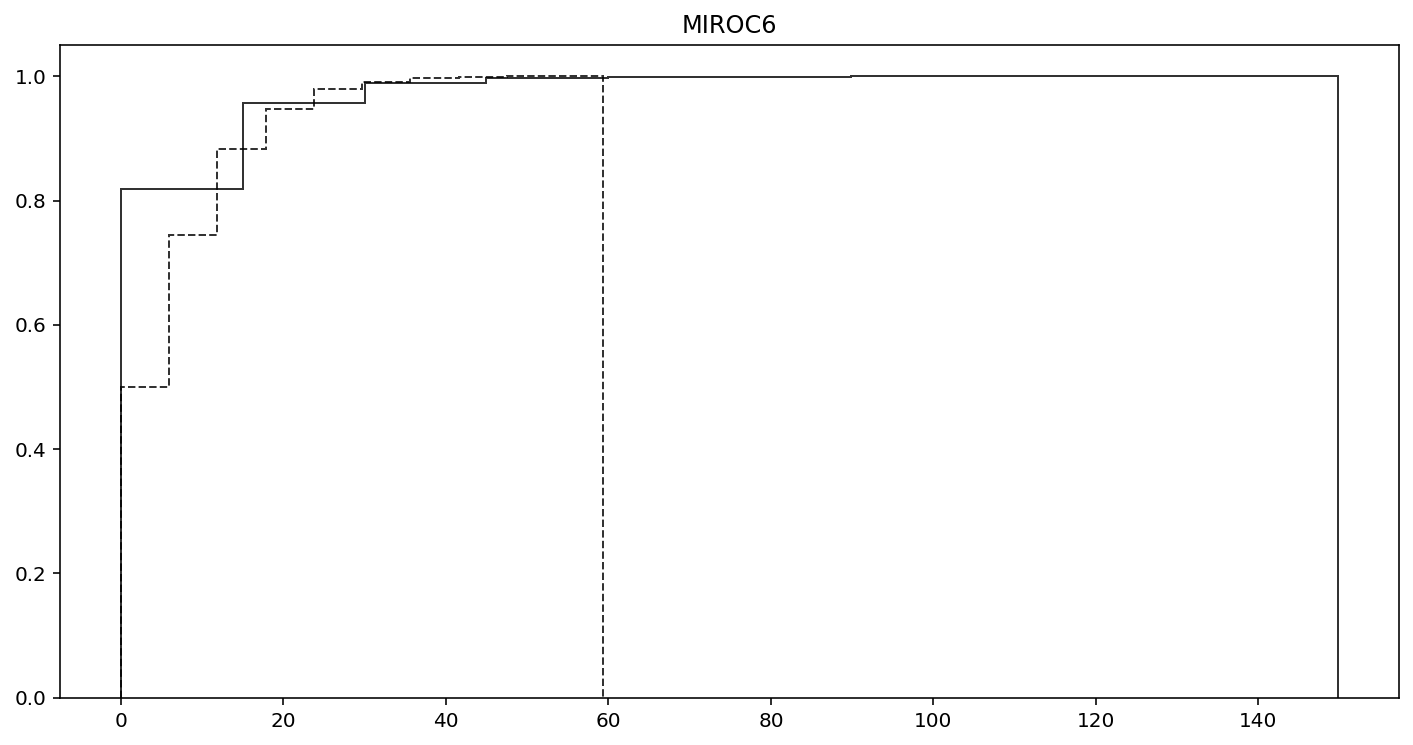

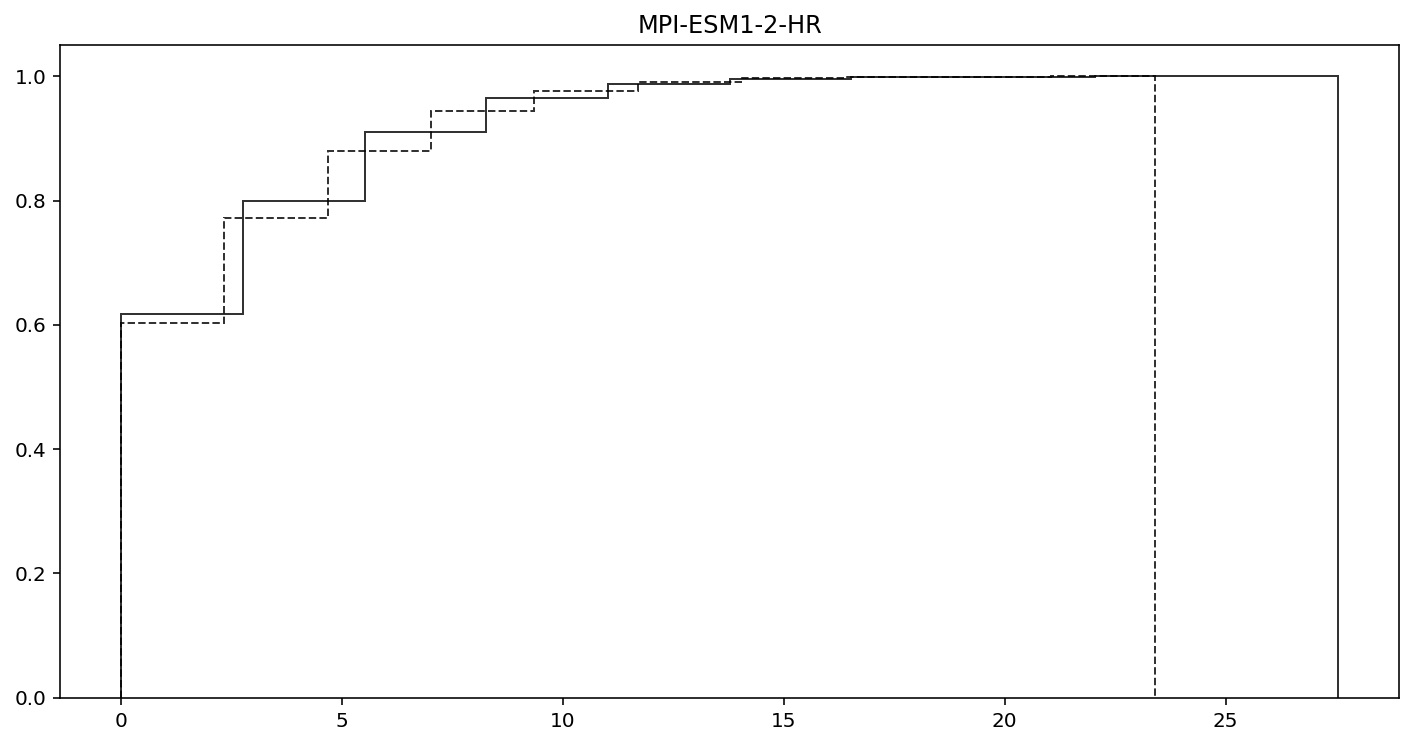

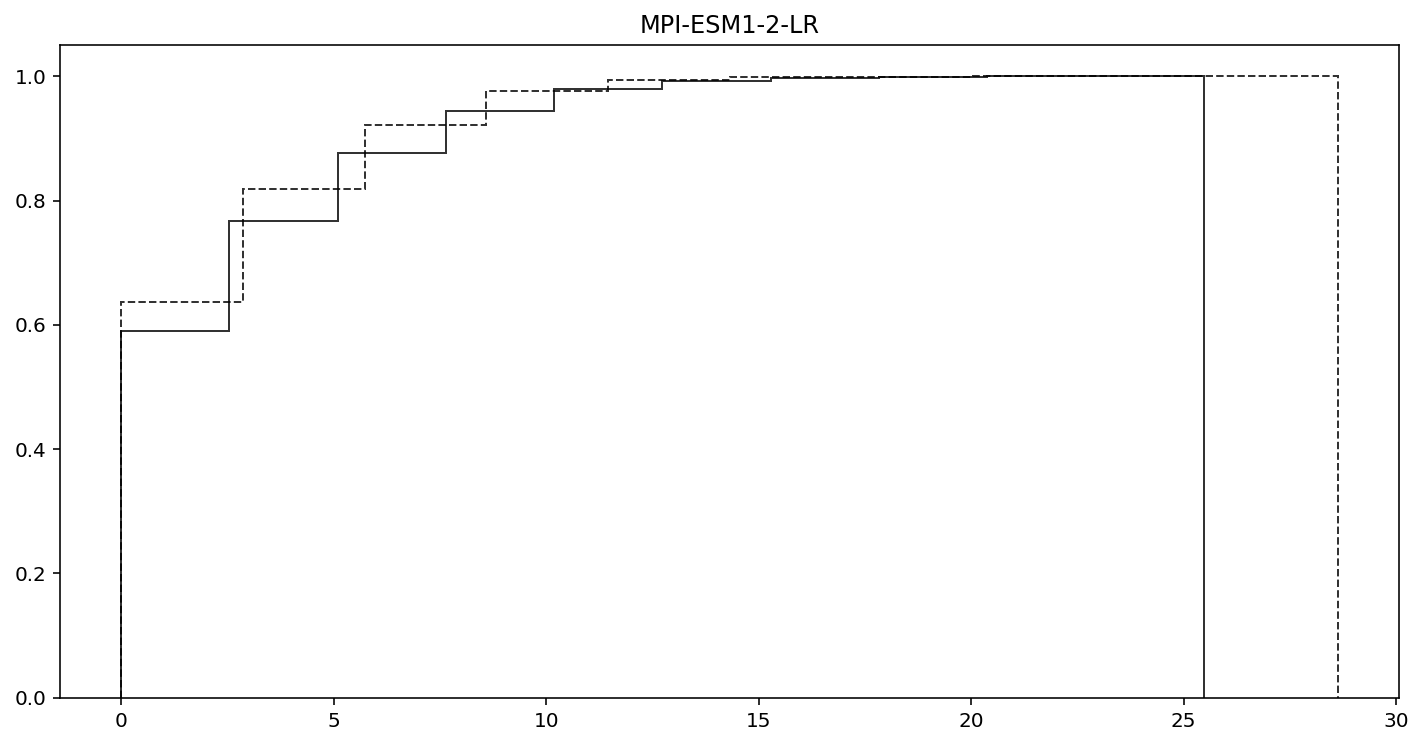

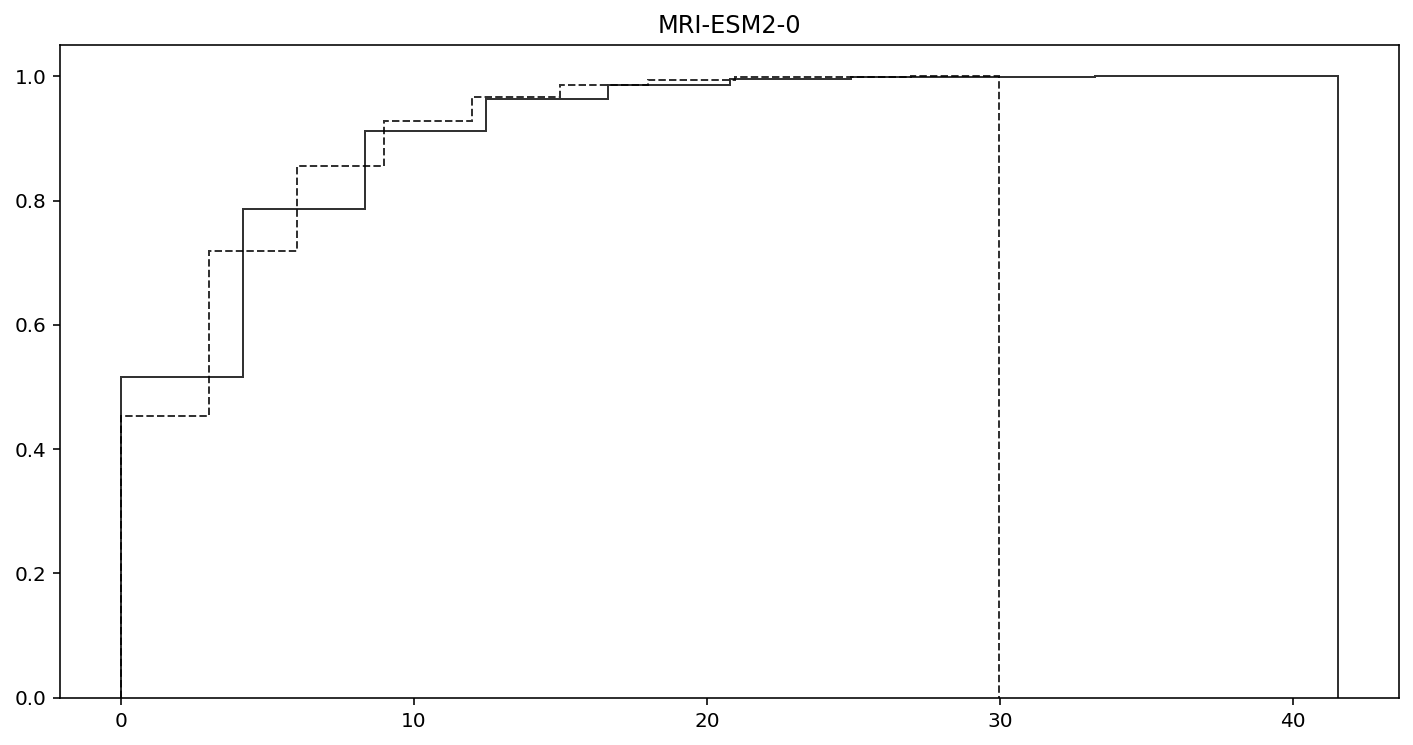

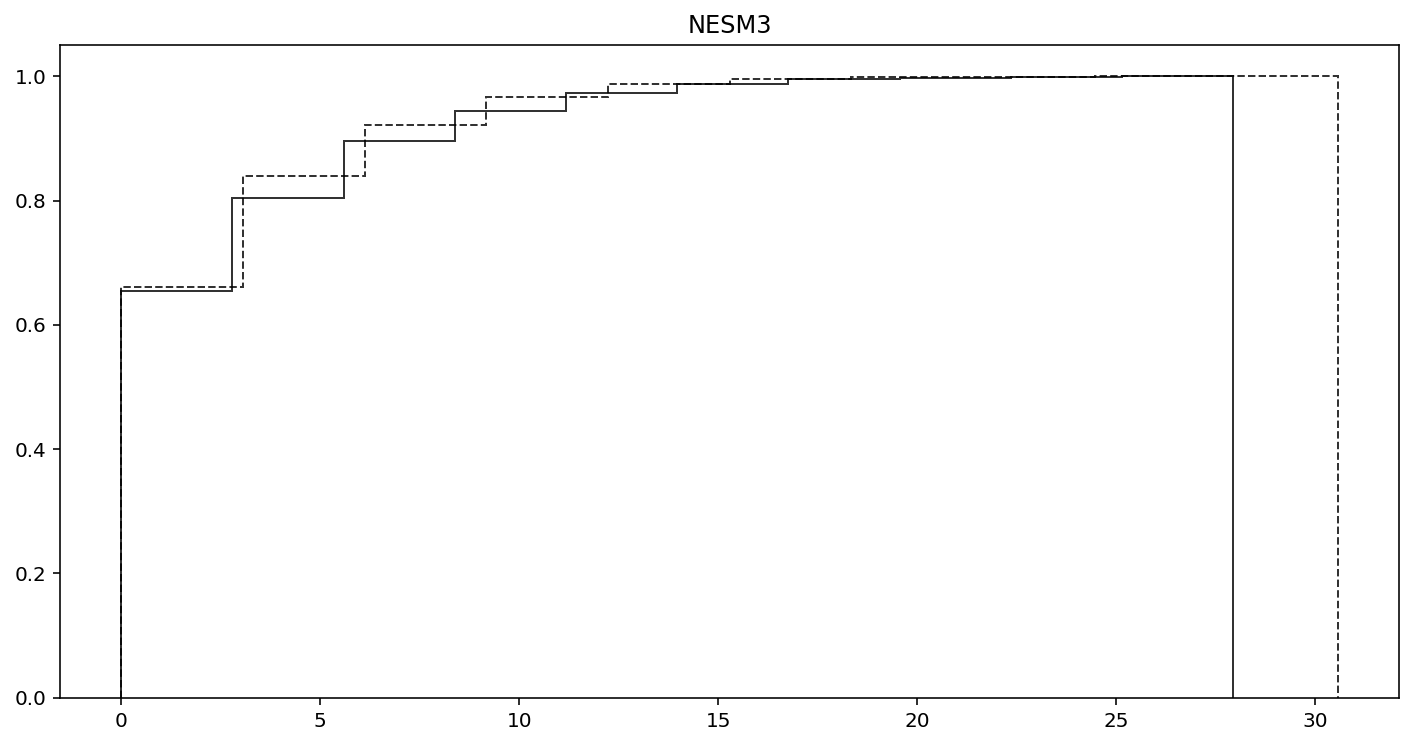

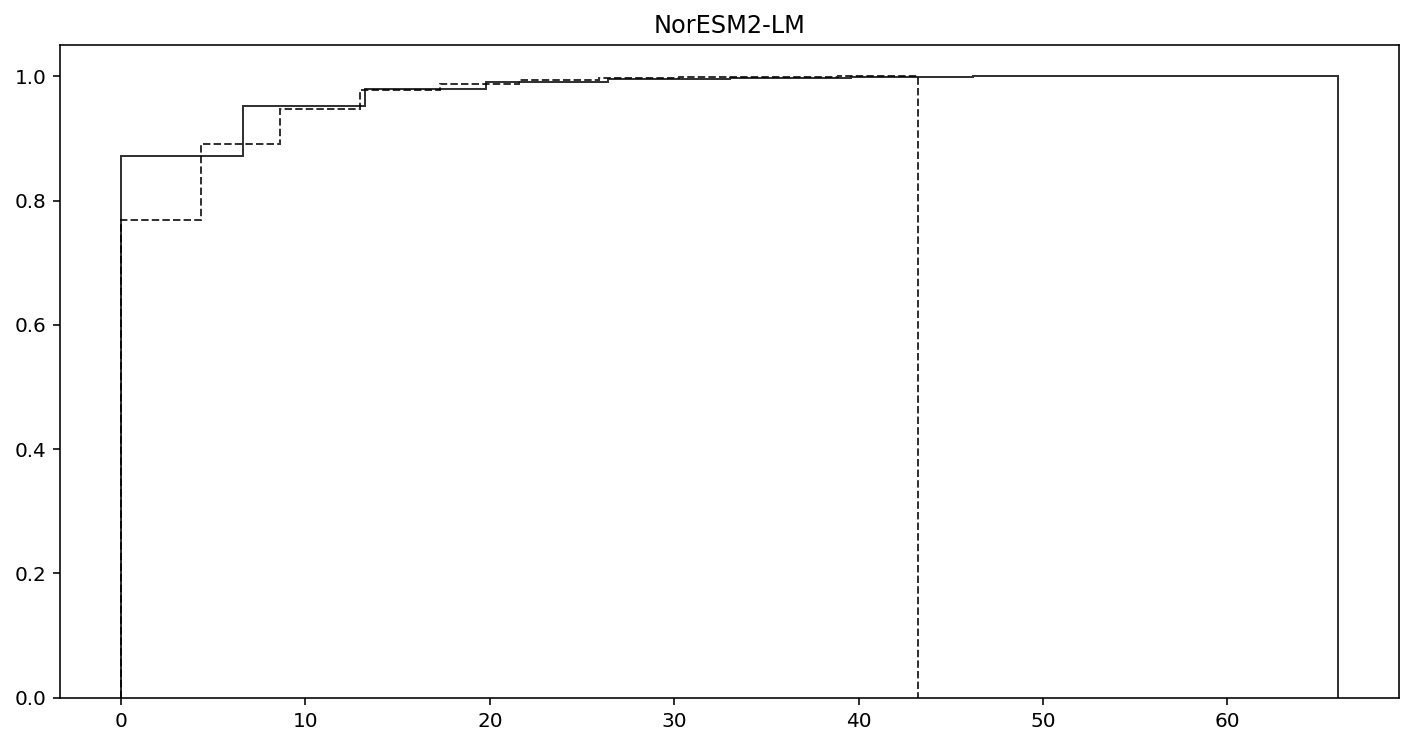

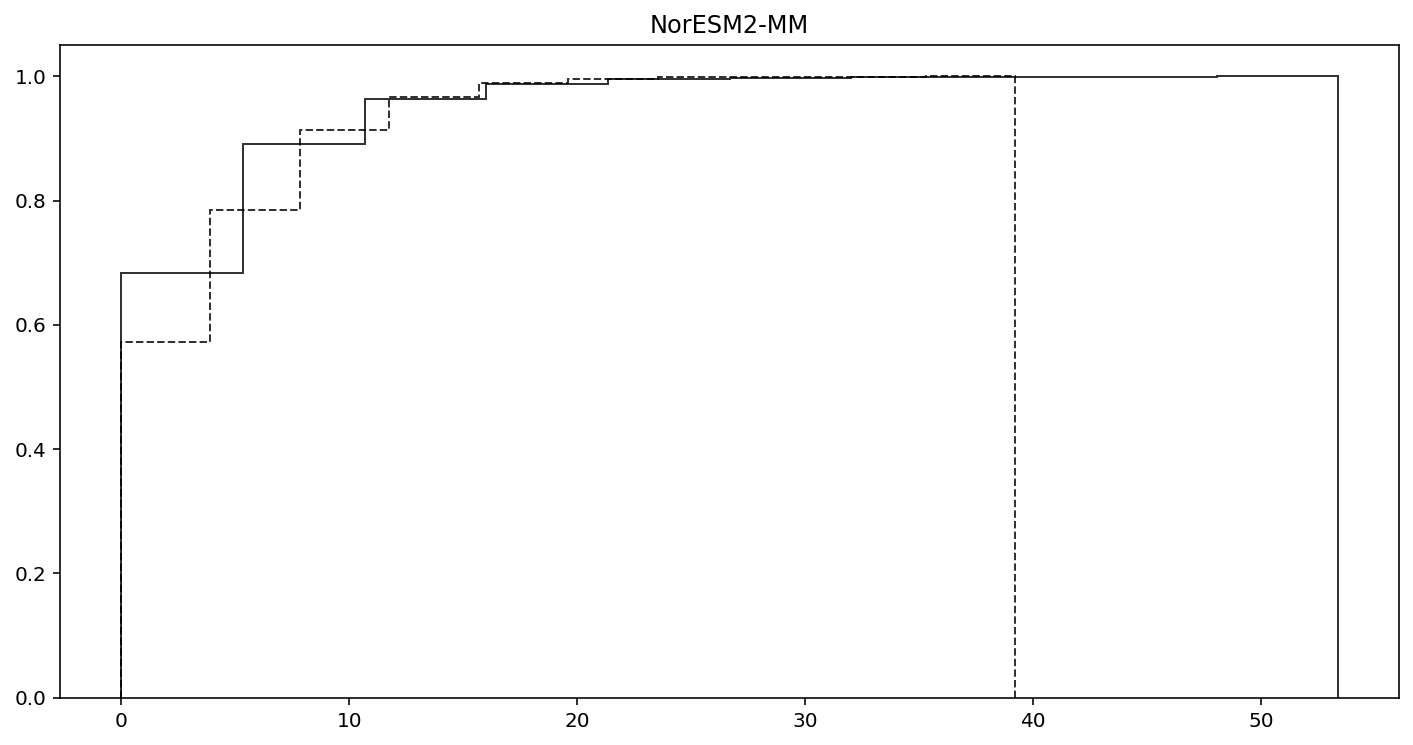

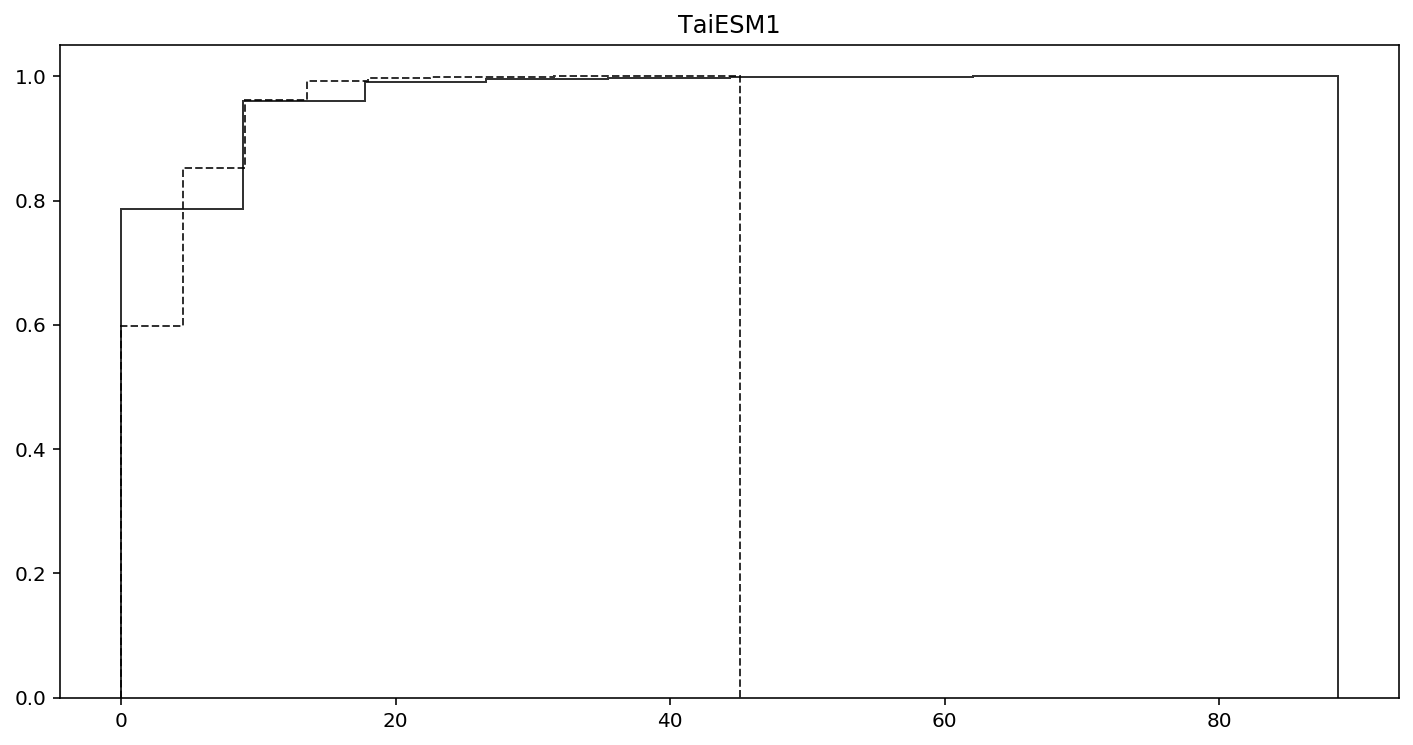

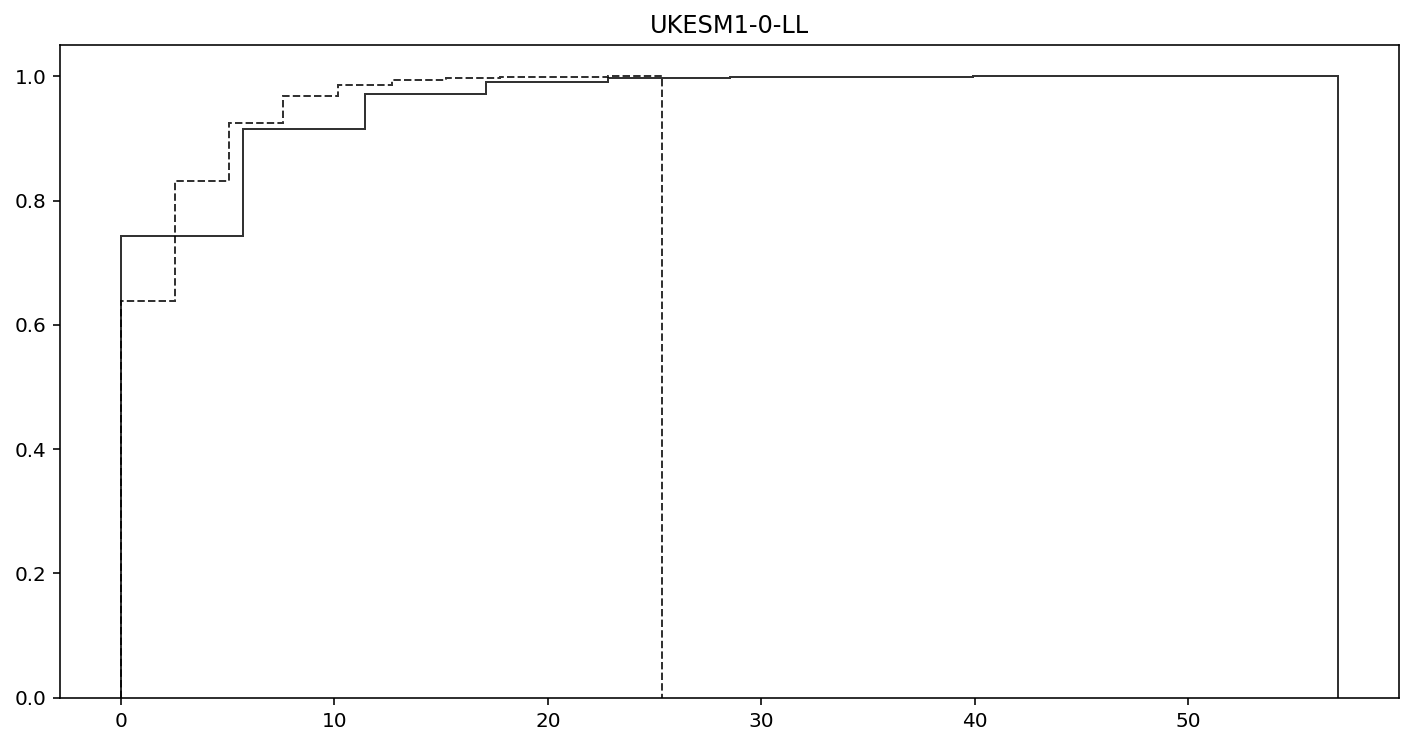

In [43]:
for (source_id, pr_hist), (source_id, pr_ssp) in zip(hist_results.items(), ssp_results.items()):
    pr_ssp2 = pd.DataFrame({'date':pr_ssp.time, 'pr': pr_ssp.pr * 86400})
    pr_hist2 = pd.DataFrame({'date':pr_hist.time, 'pr': pr_hist.pr * 86400})
    
    plt.hist(pr_ssp2.pr, normed=True, cumulative=True, label='CDF',
         histtype='step', alpha=0.8, color='k')
    plt.hist(pr_hist2.pr, normed=True, cumulative=True, label='CDF',
         histtype='step', alpha=0.8, color='k')
    plt.title(source_id)
    plt.show()

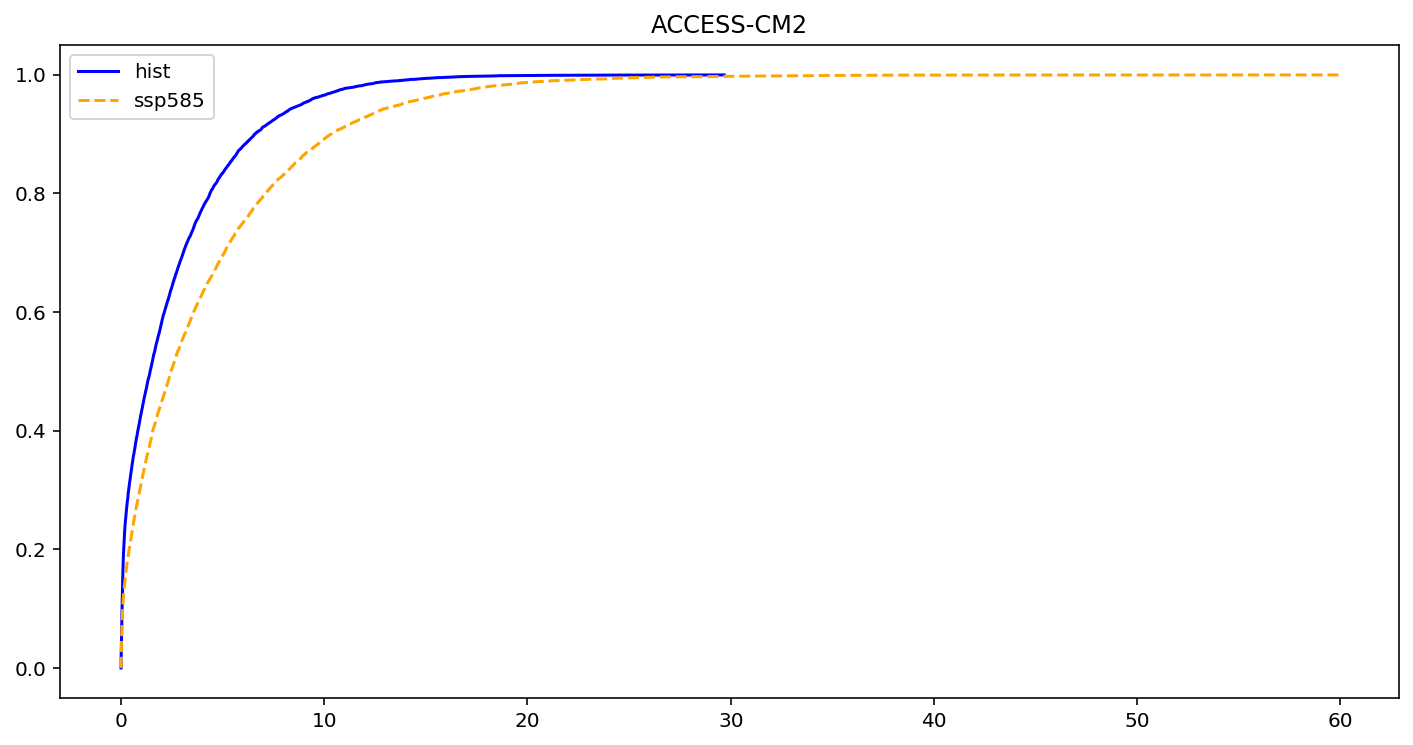

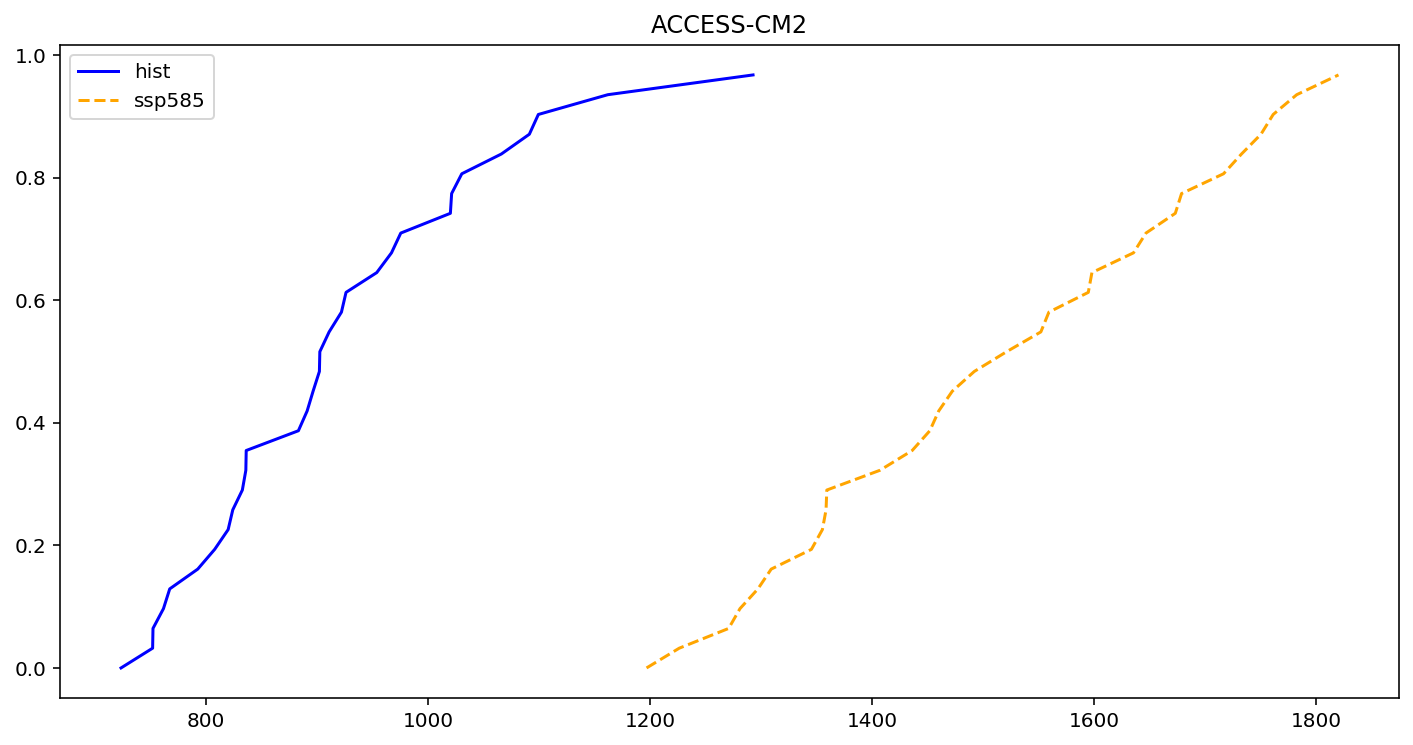

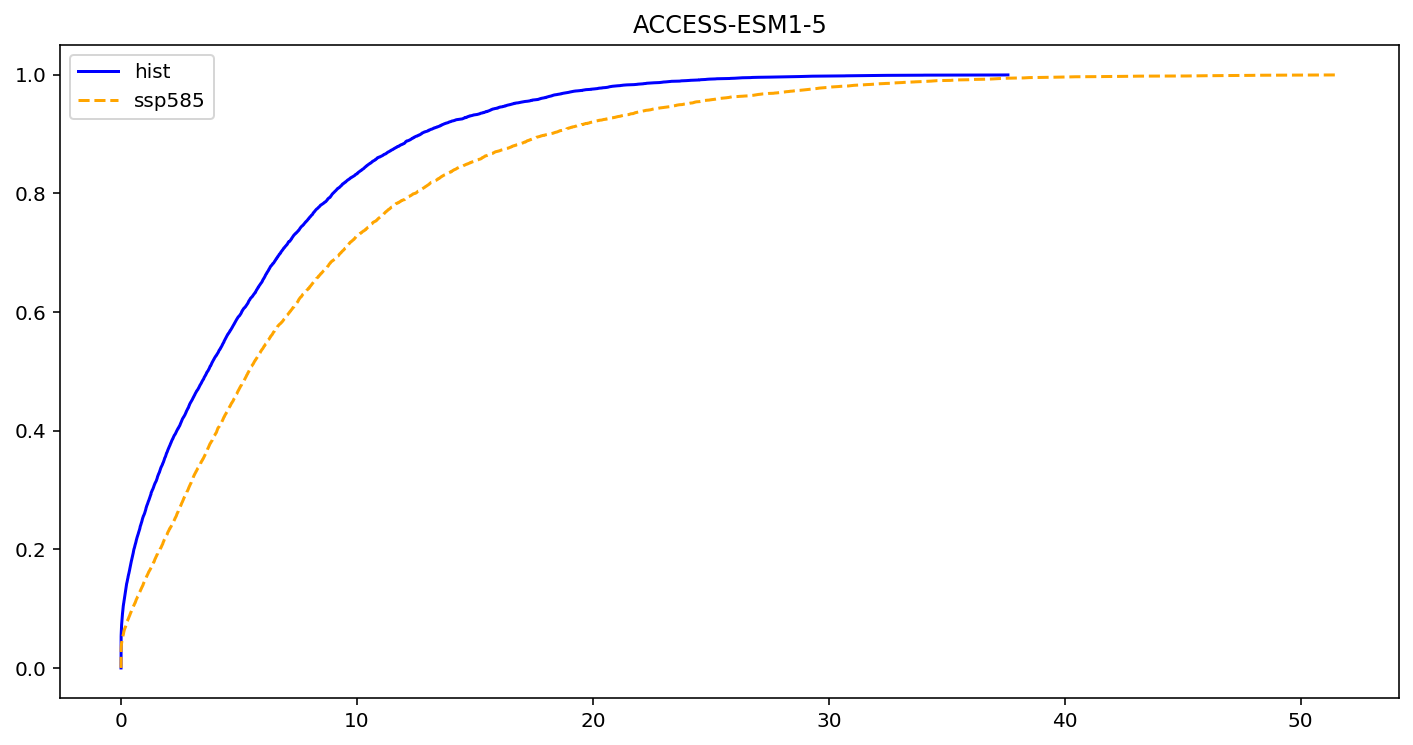

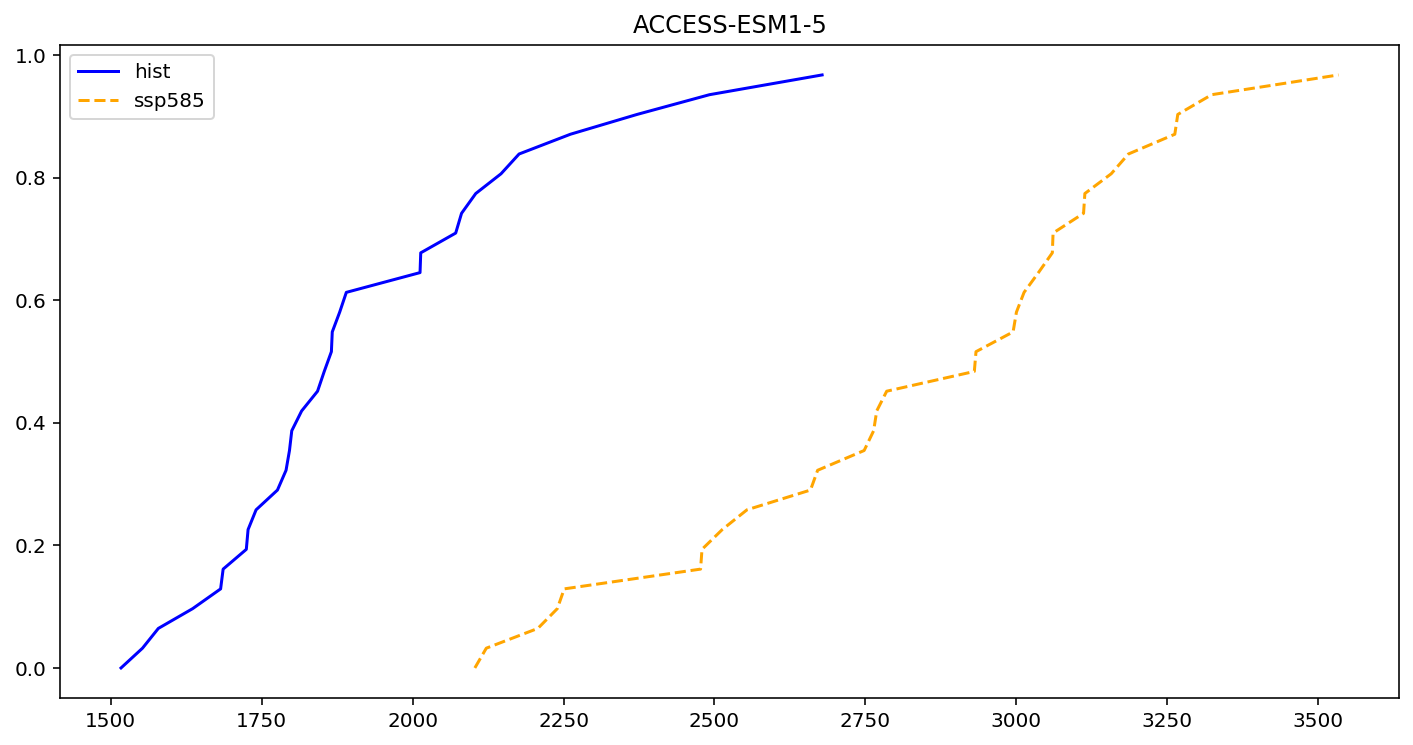

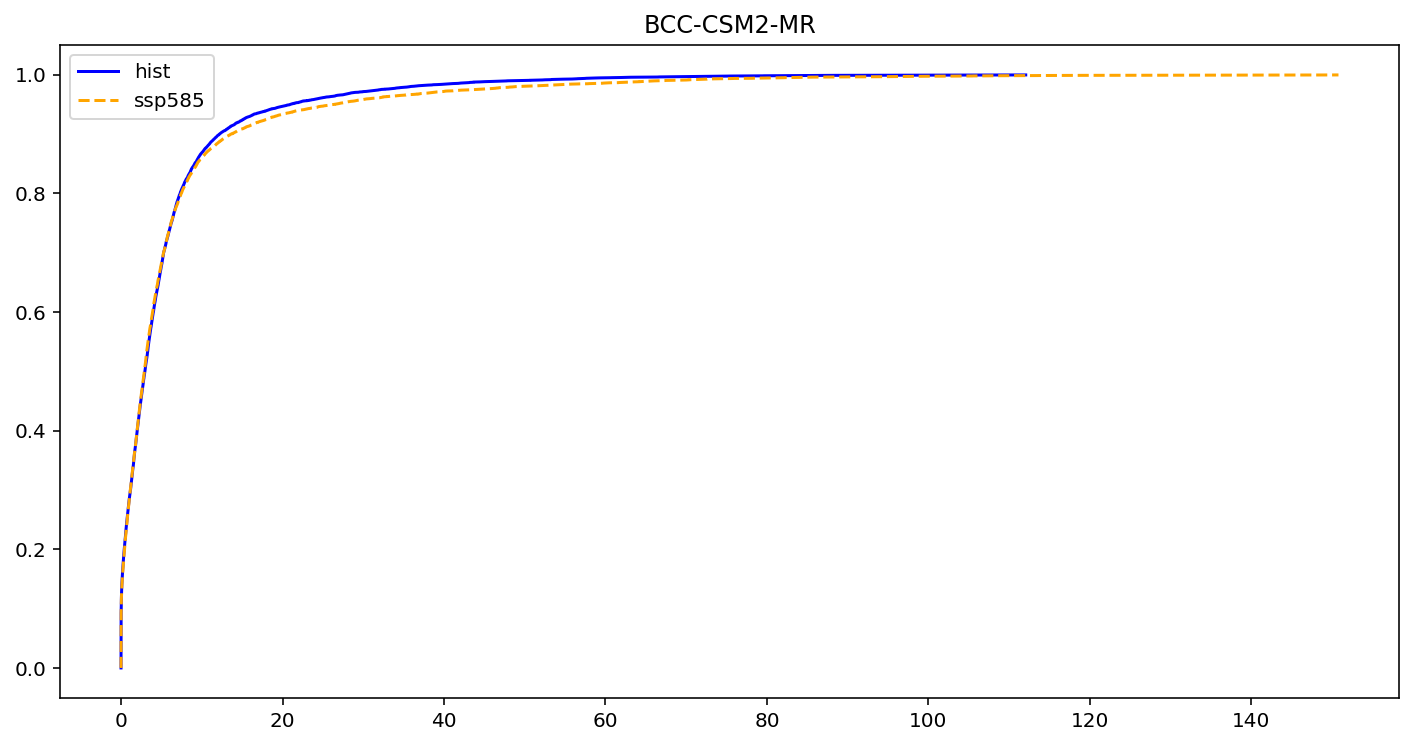

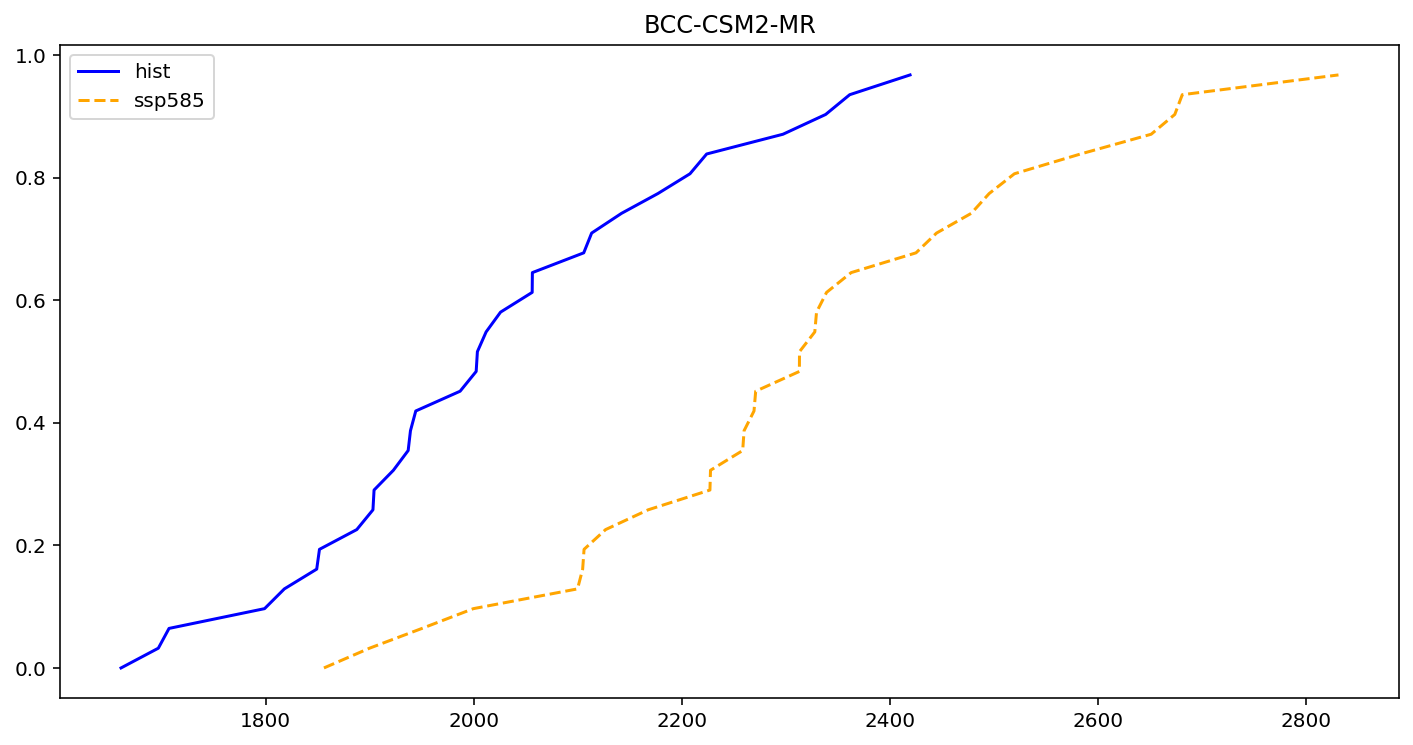

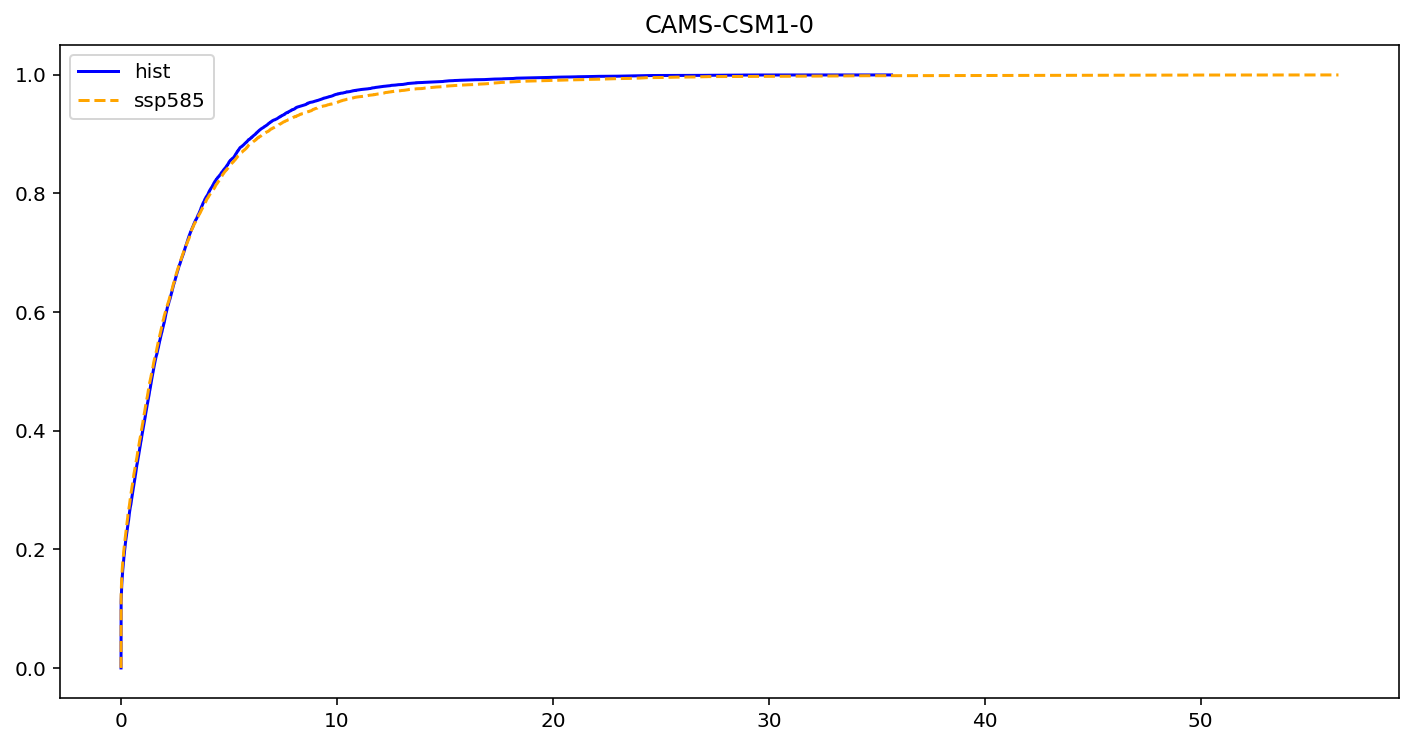

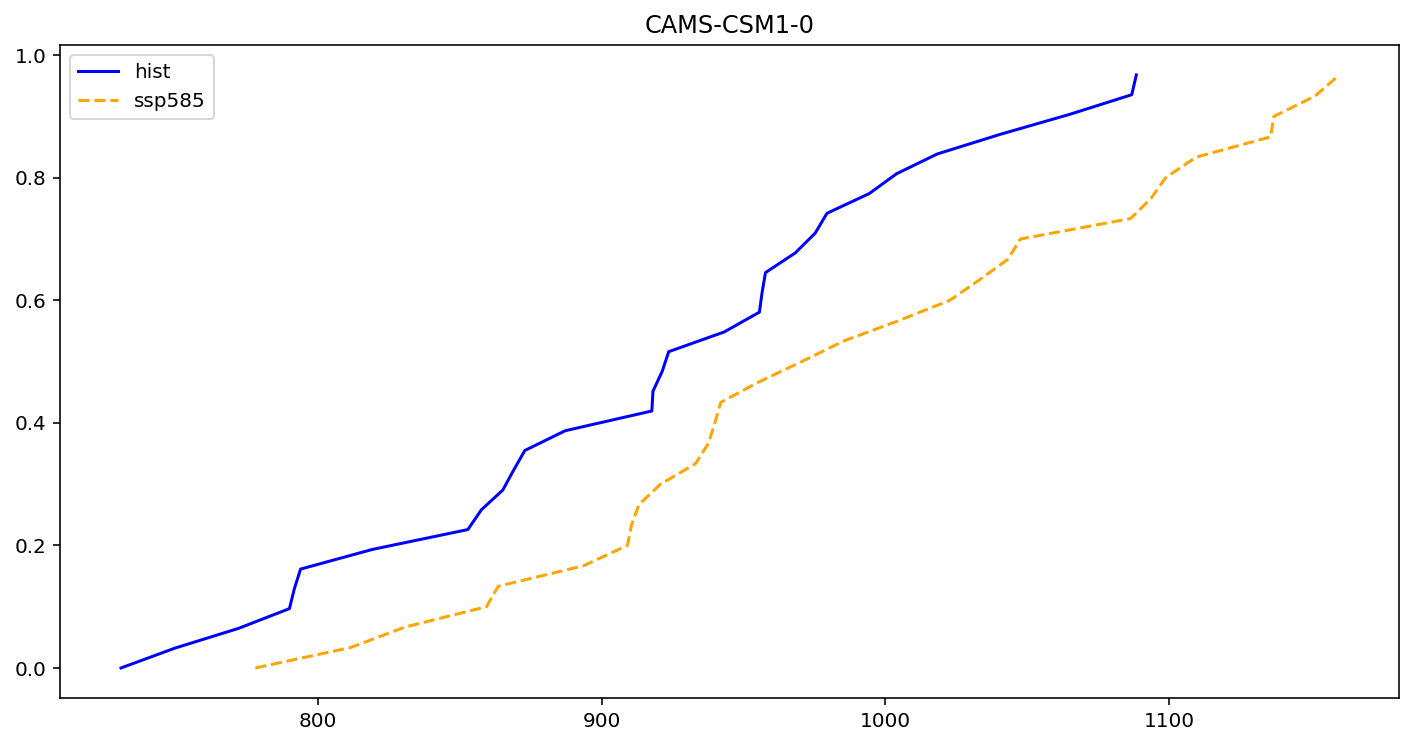

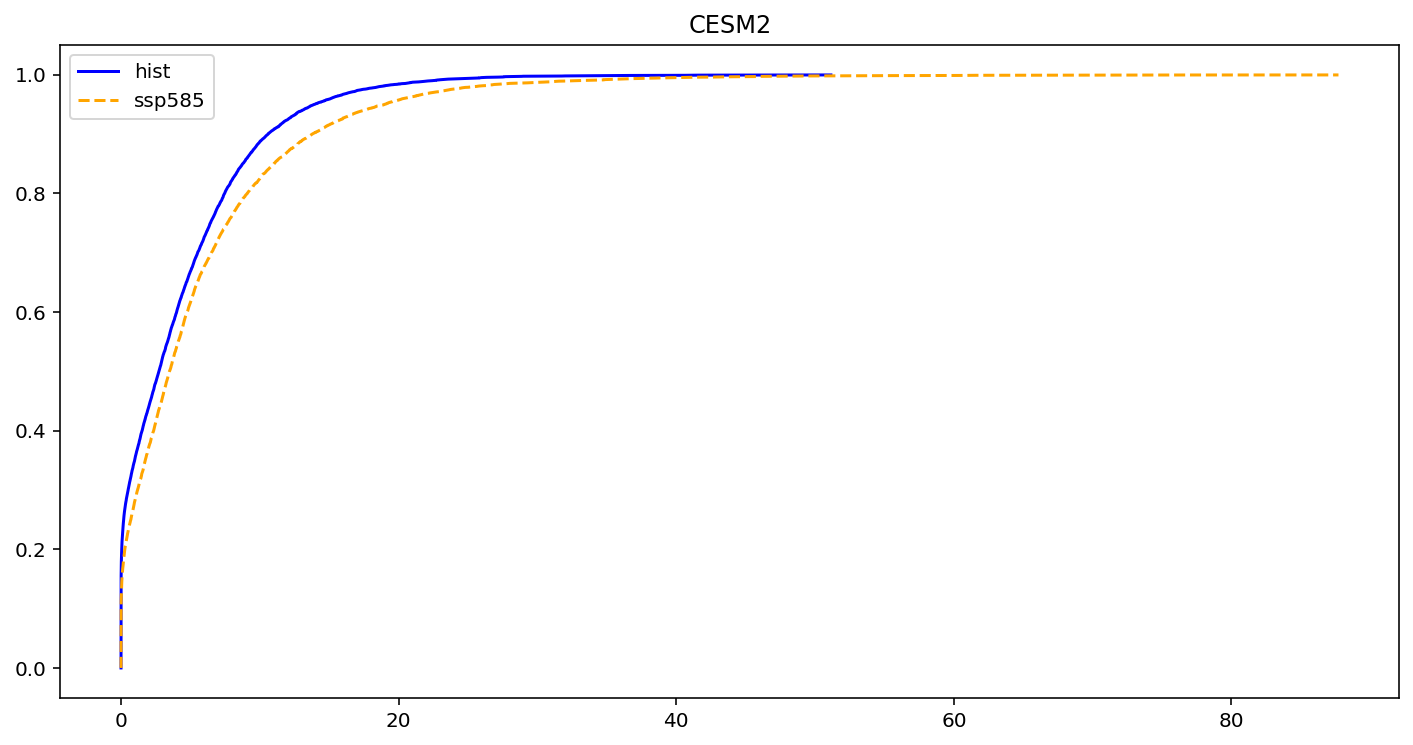

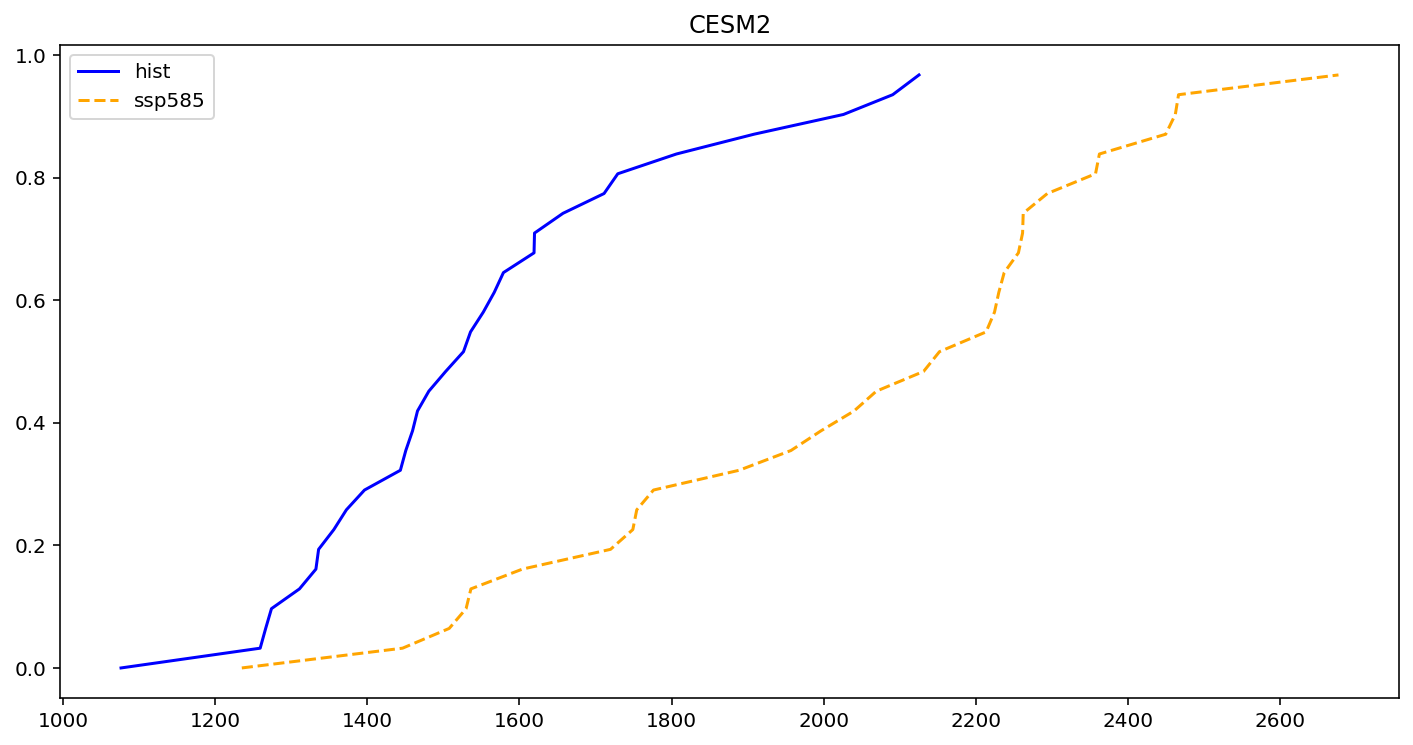

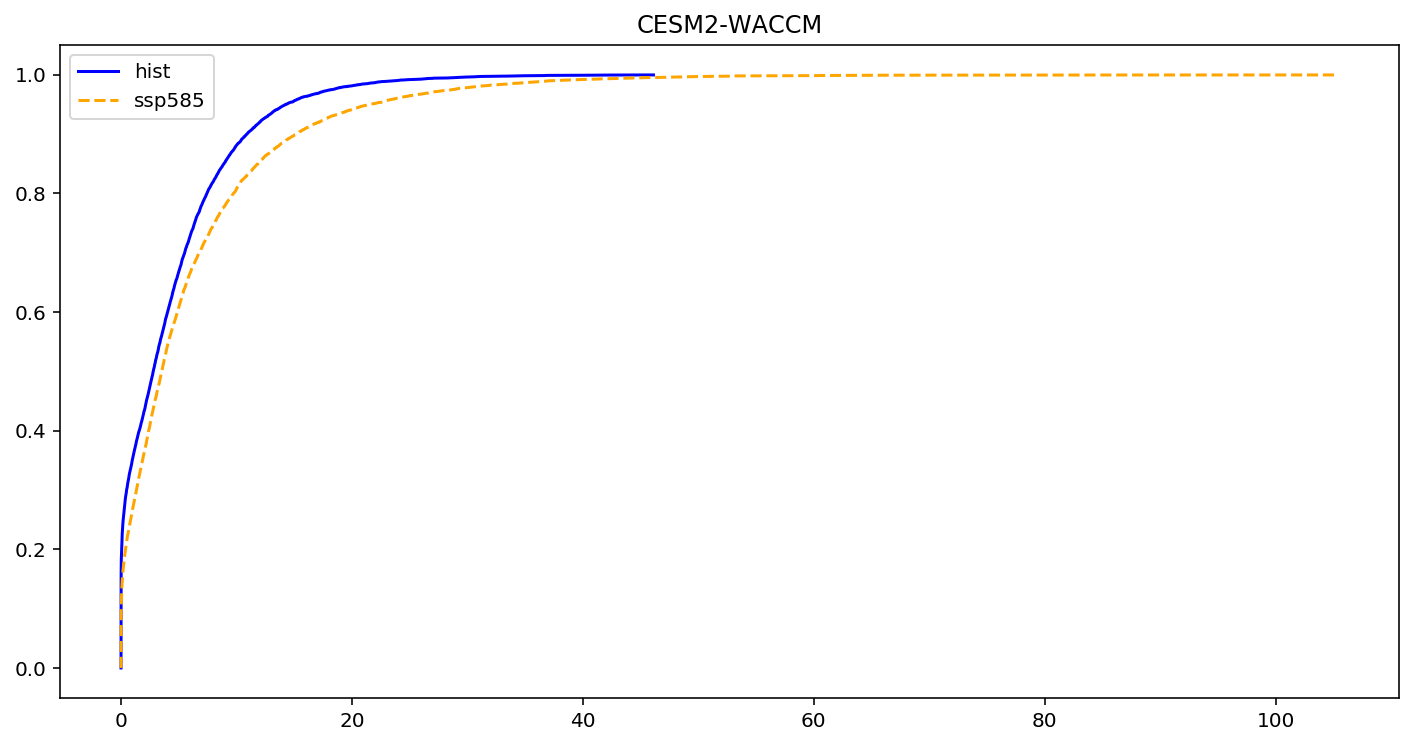

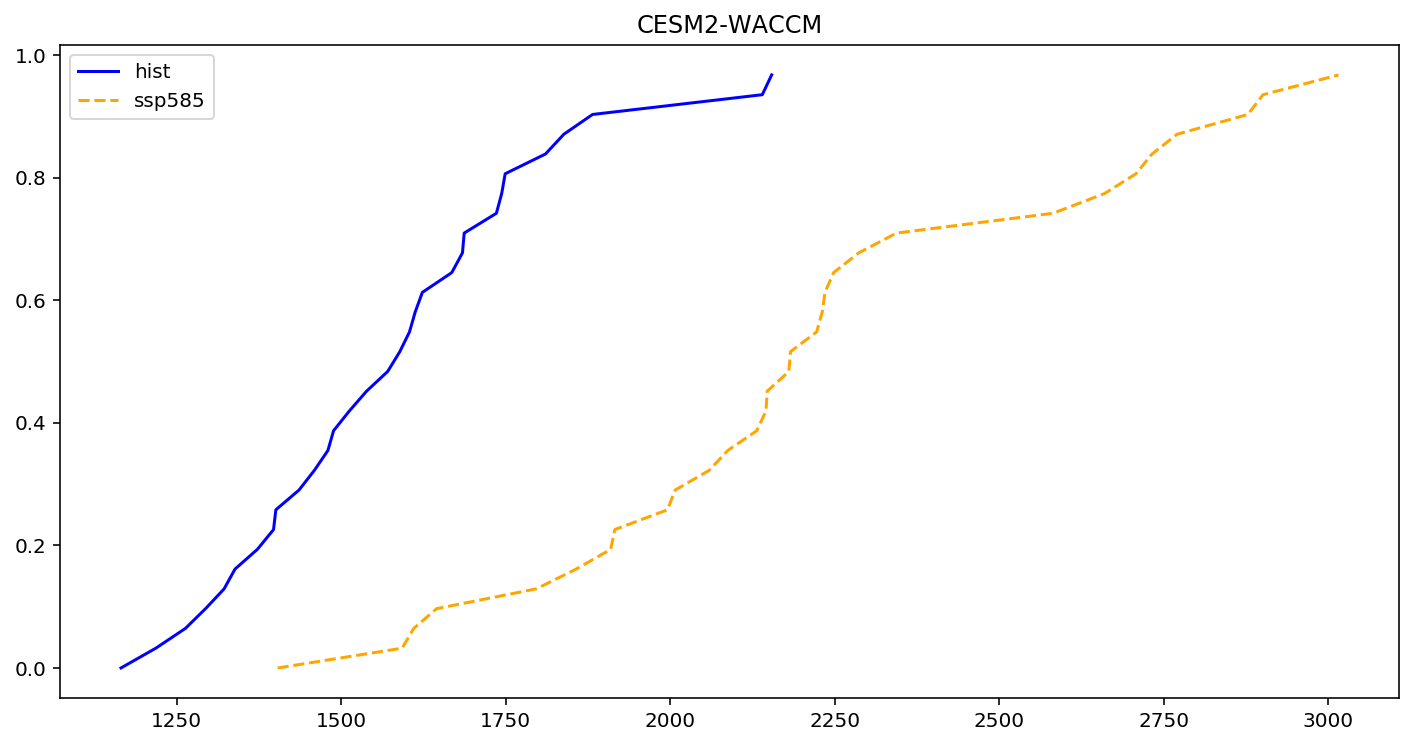

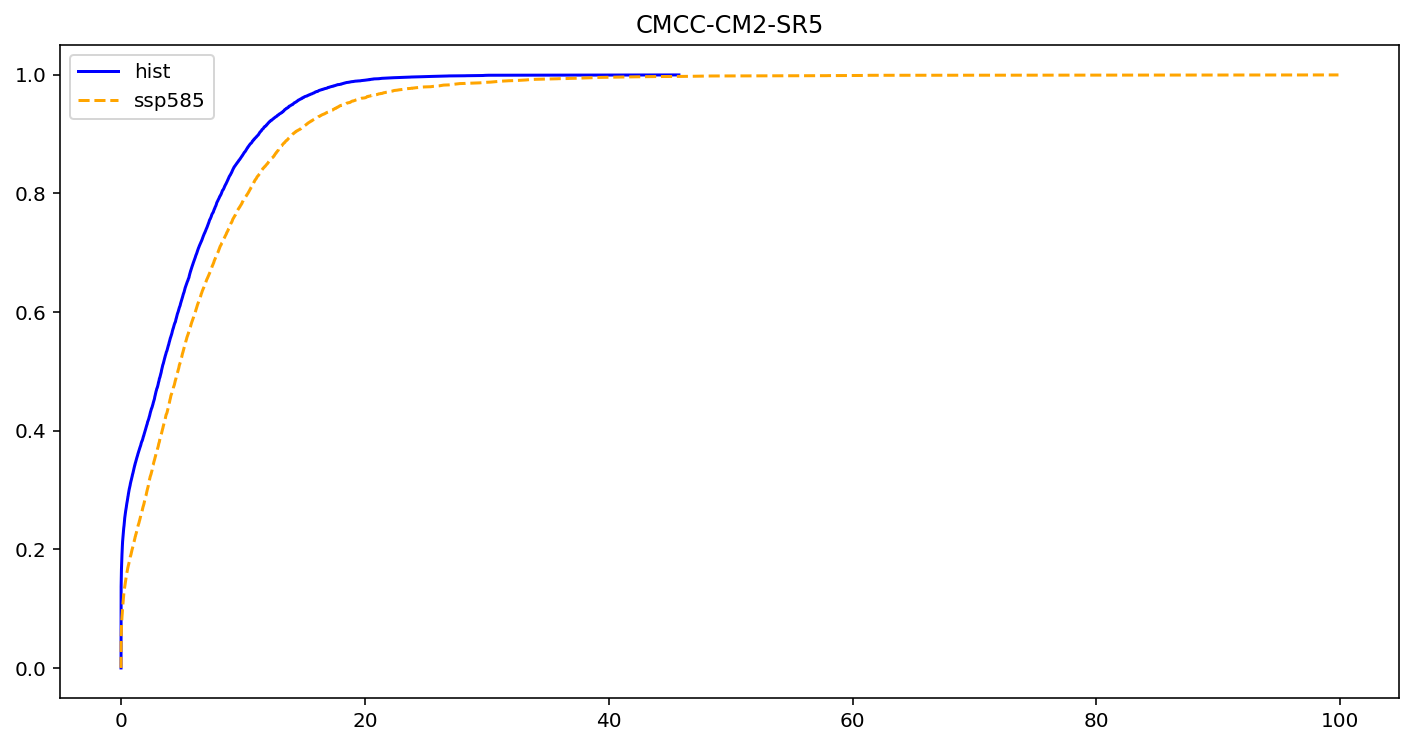

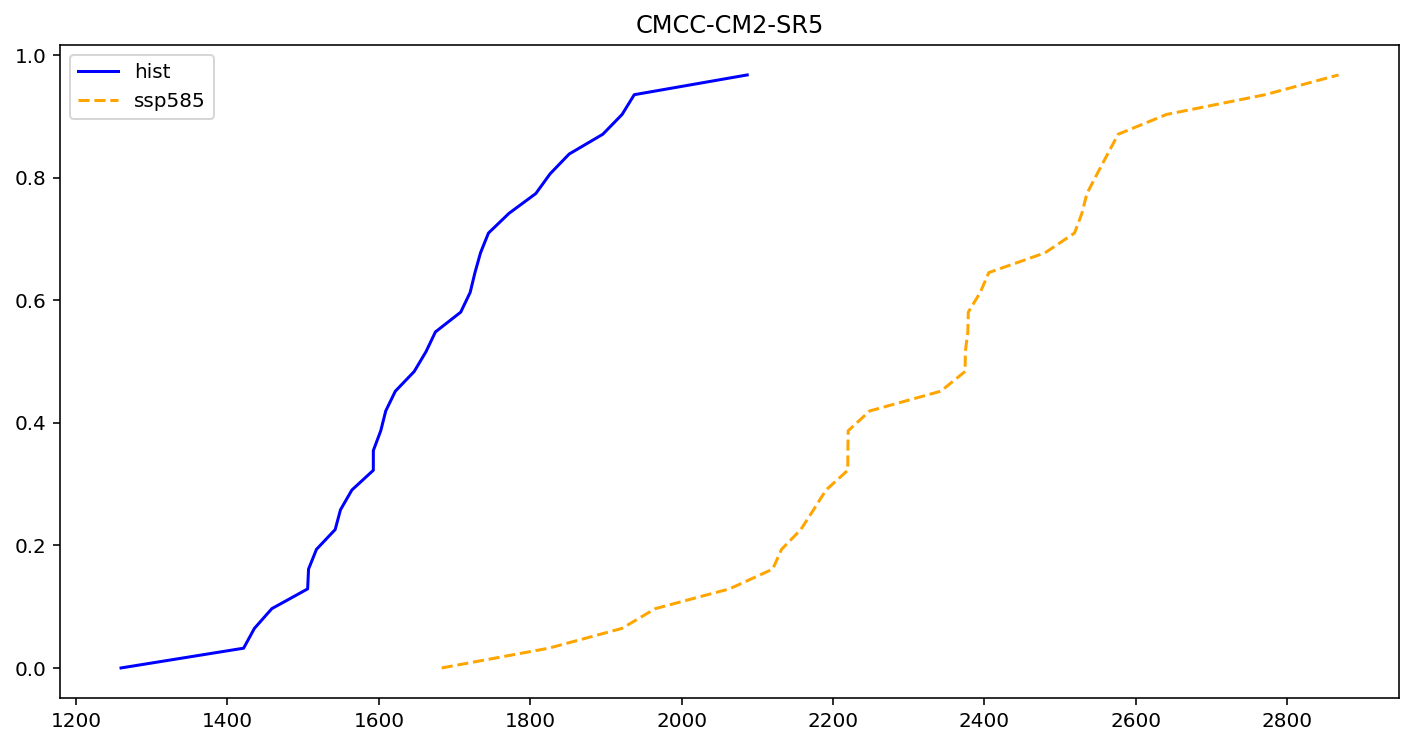

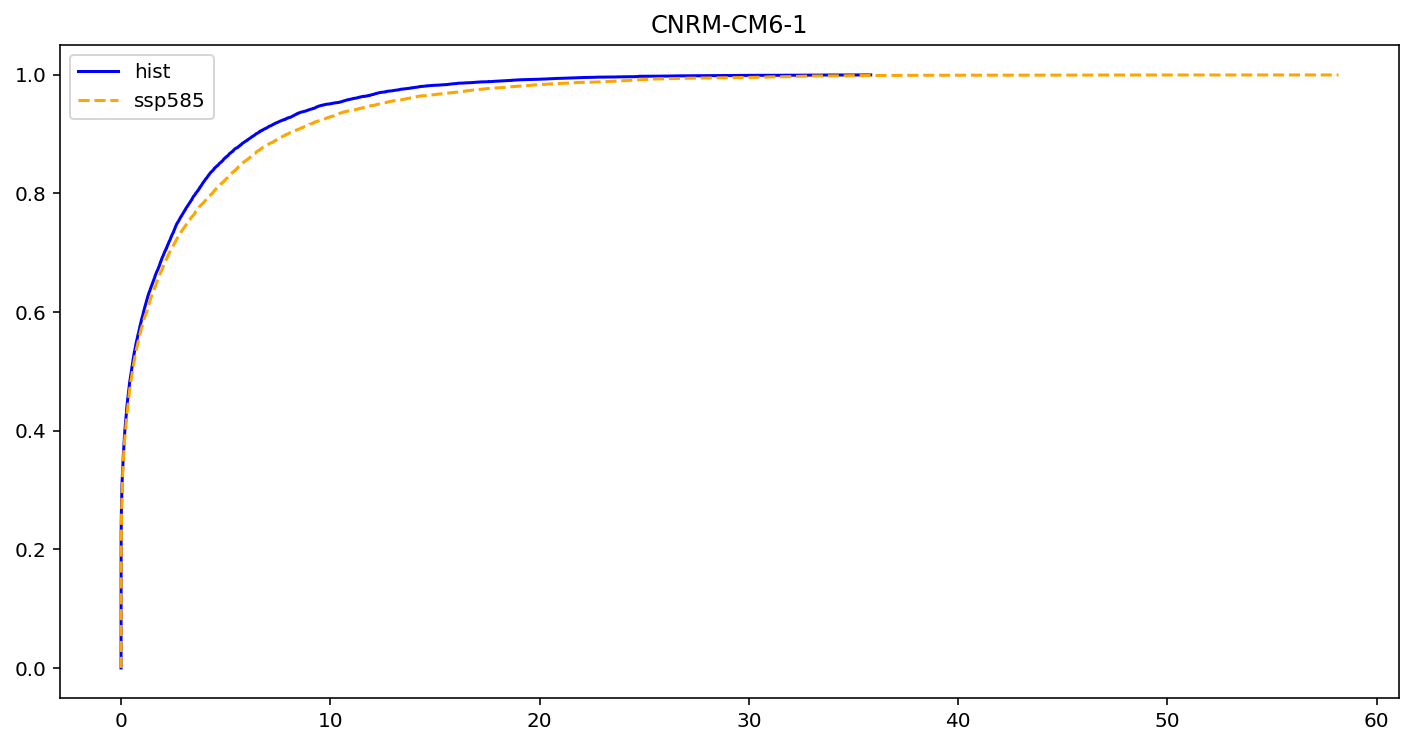

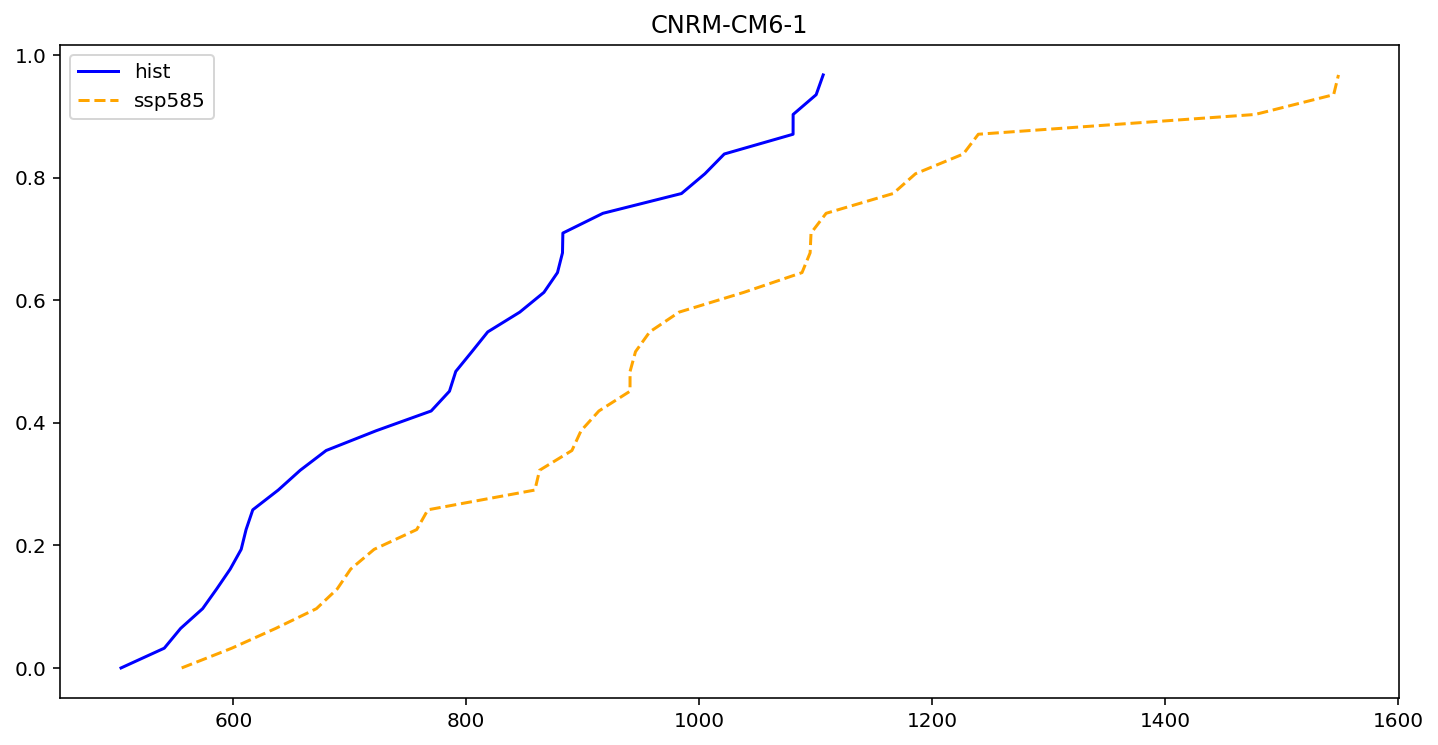

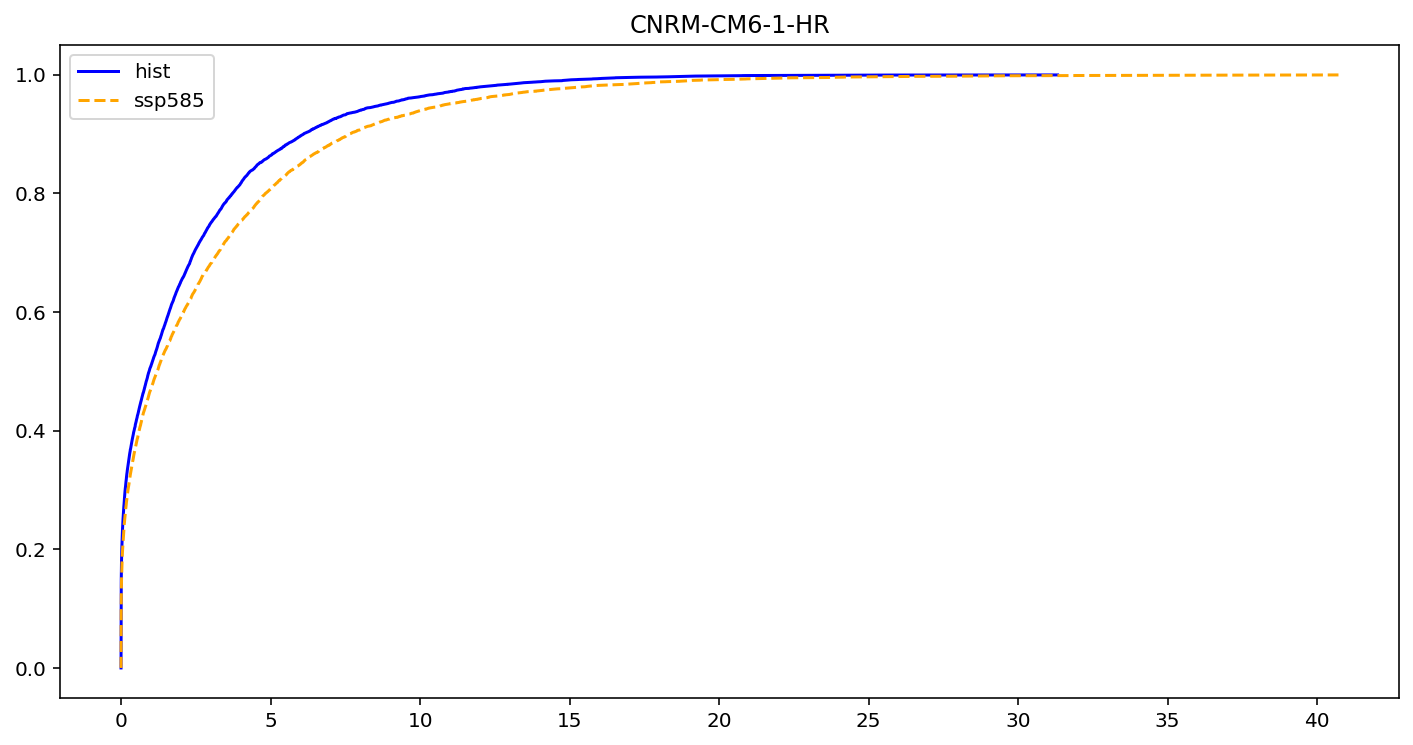

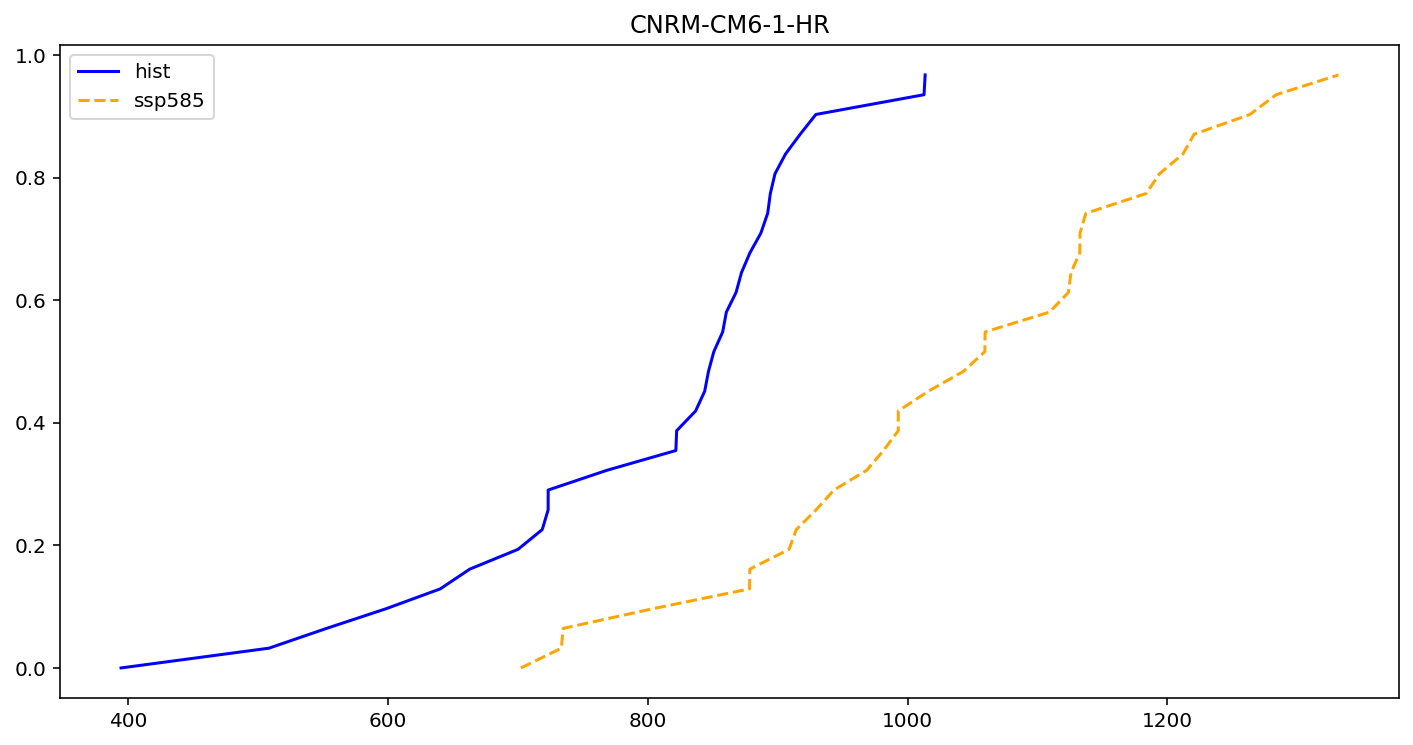

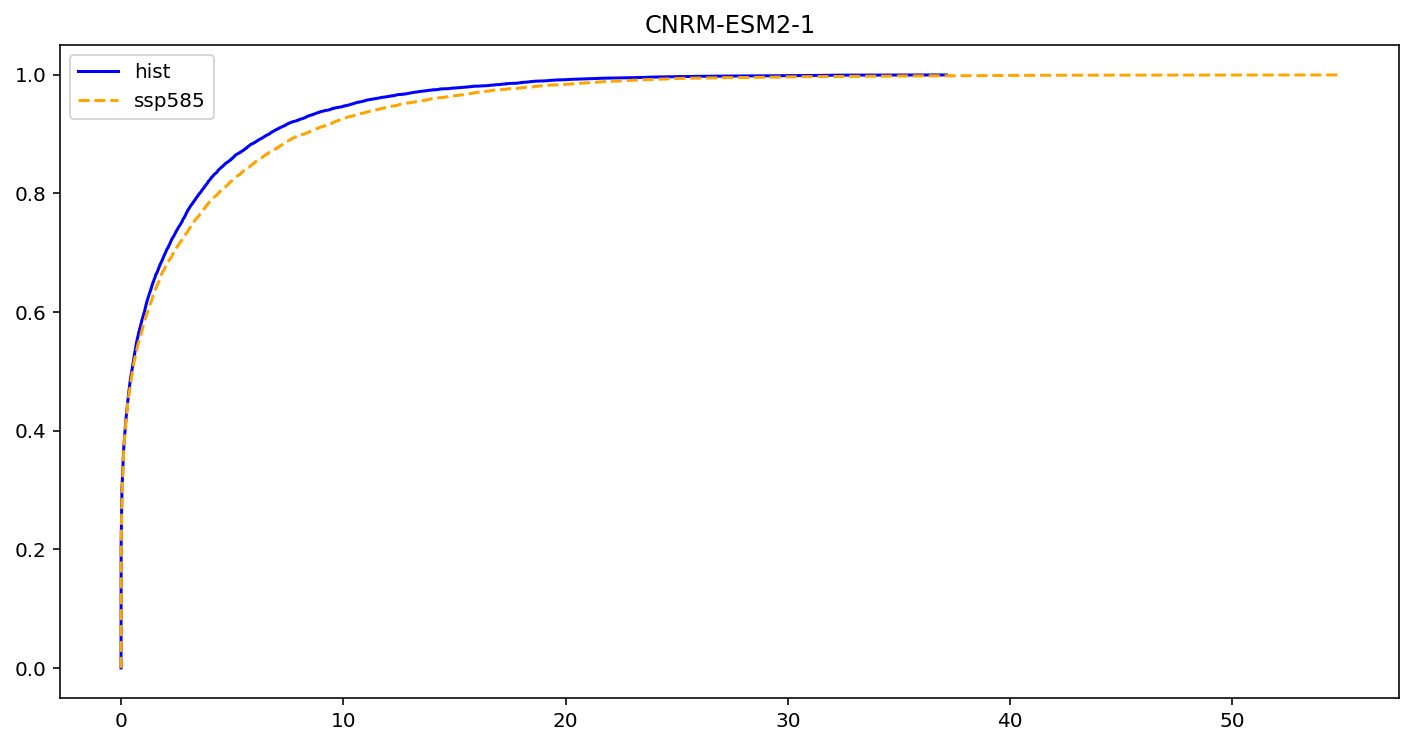

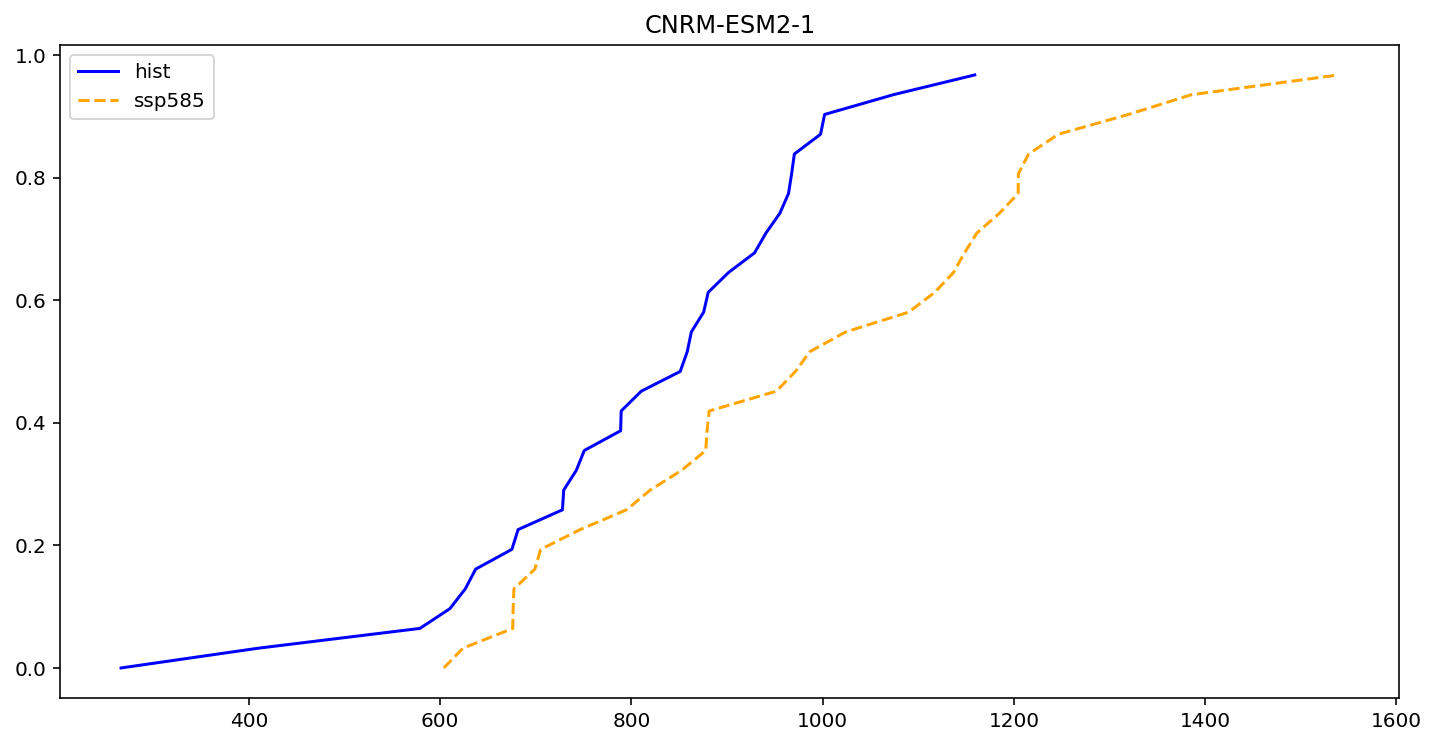

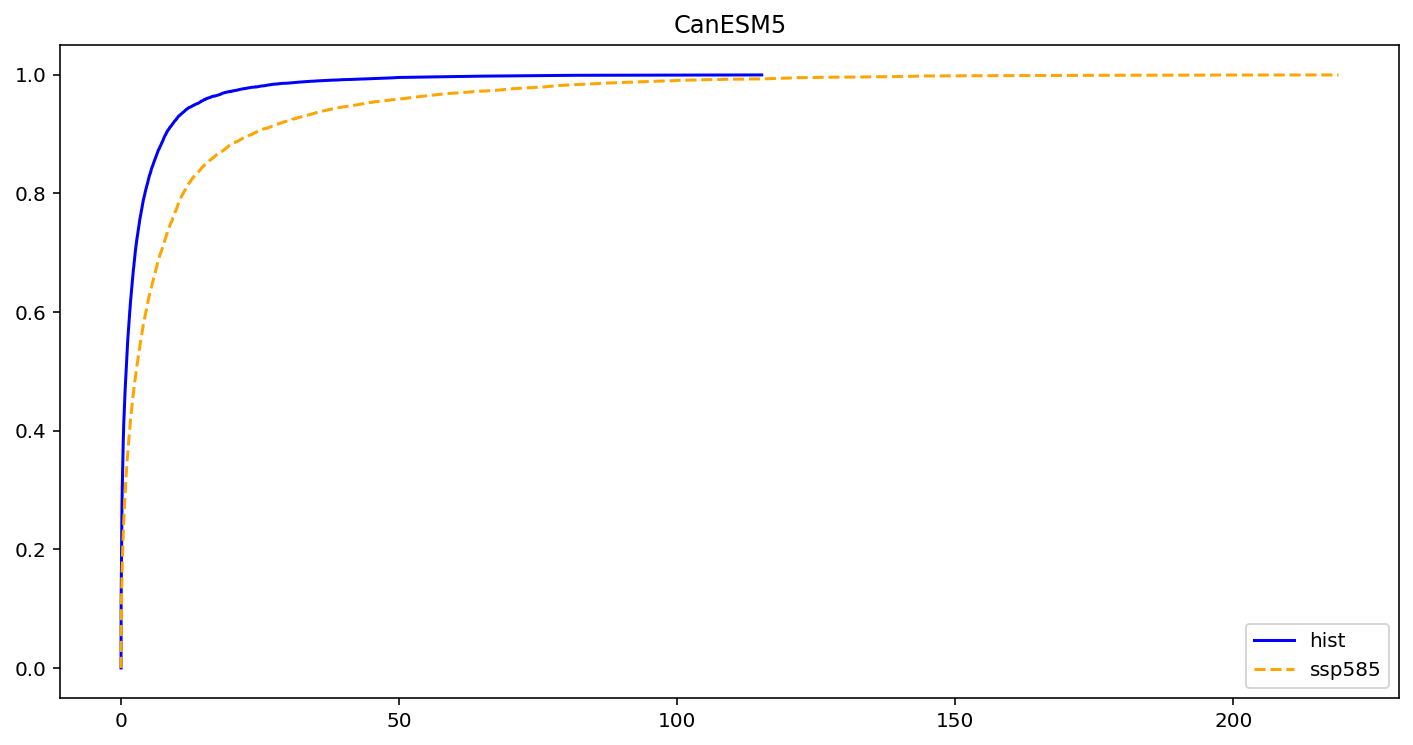

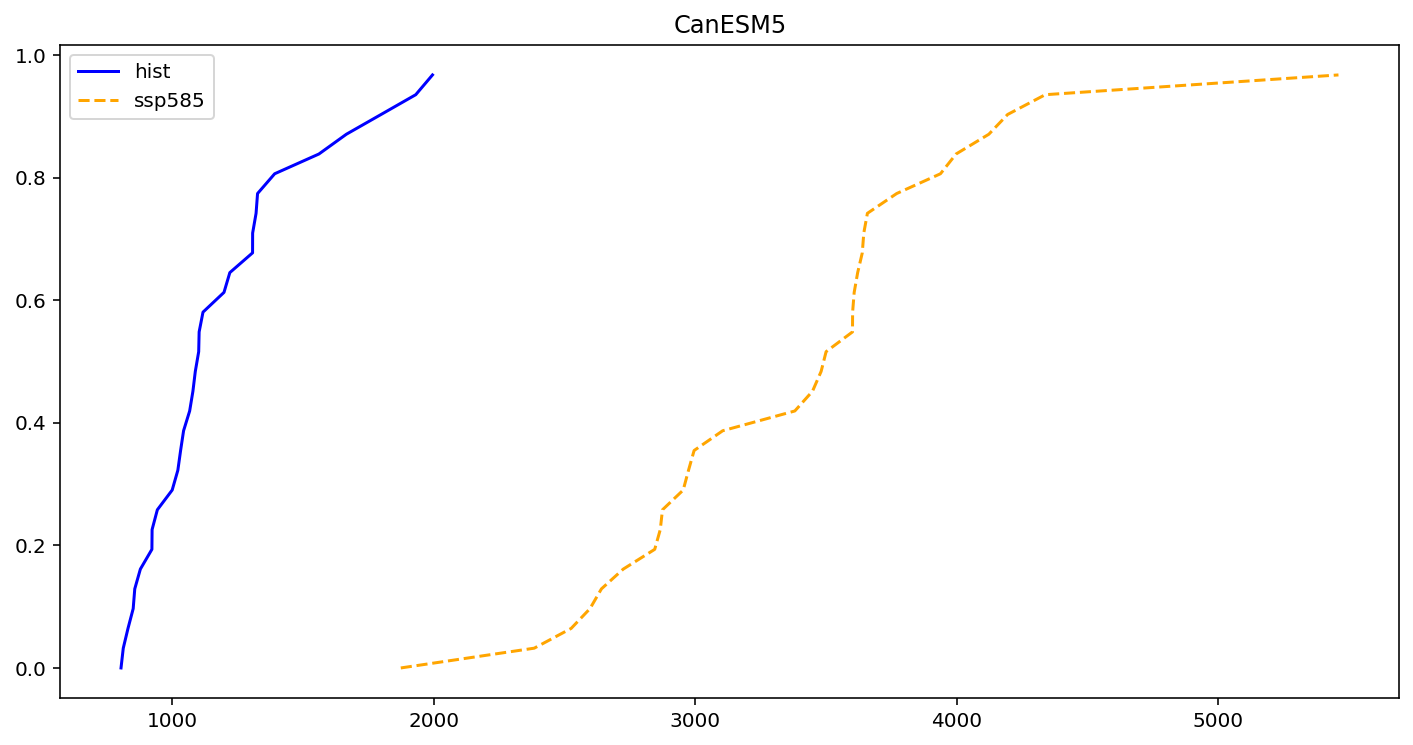

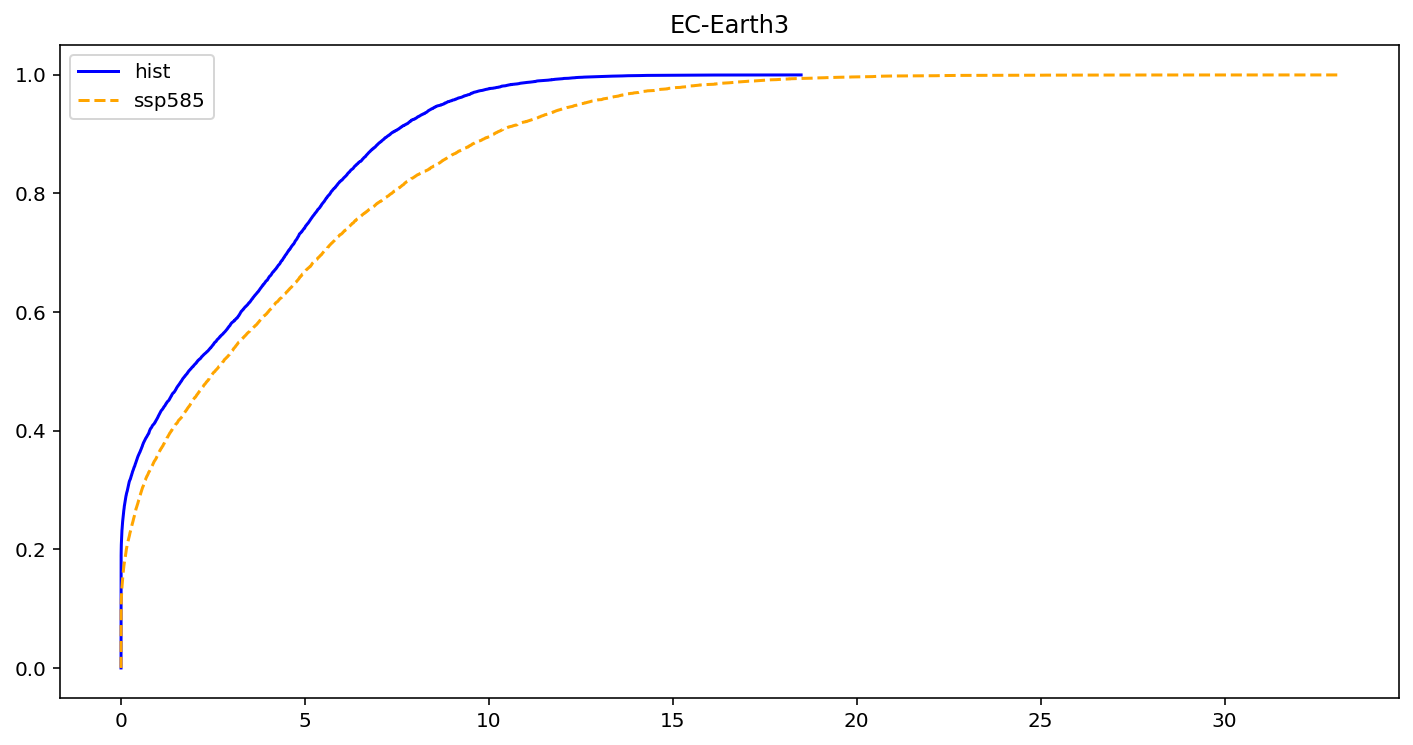

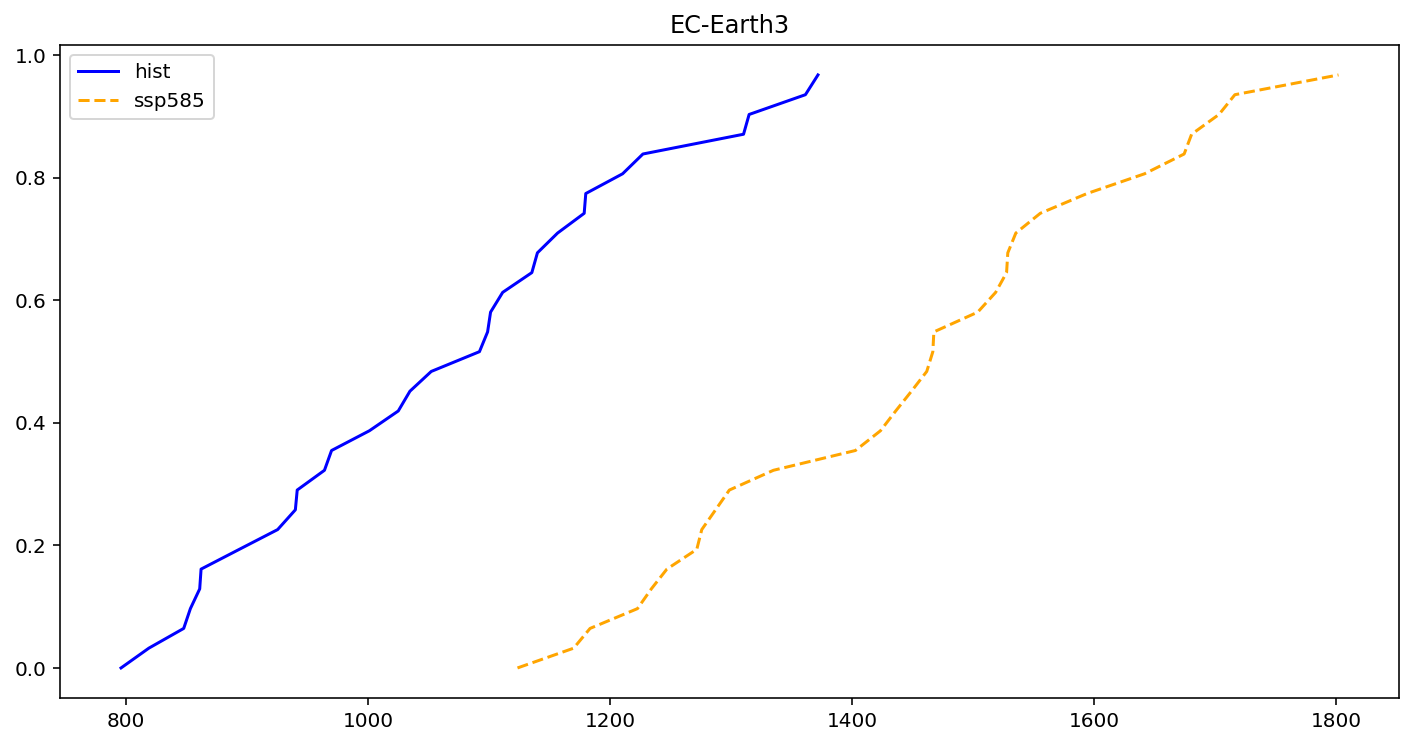

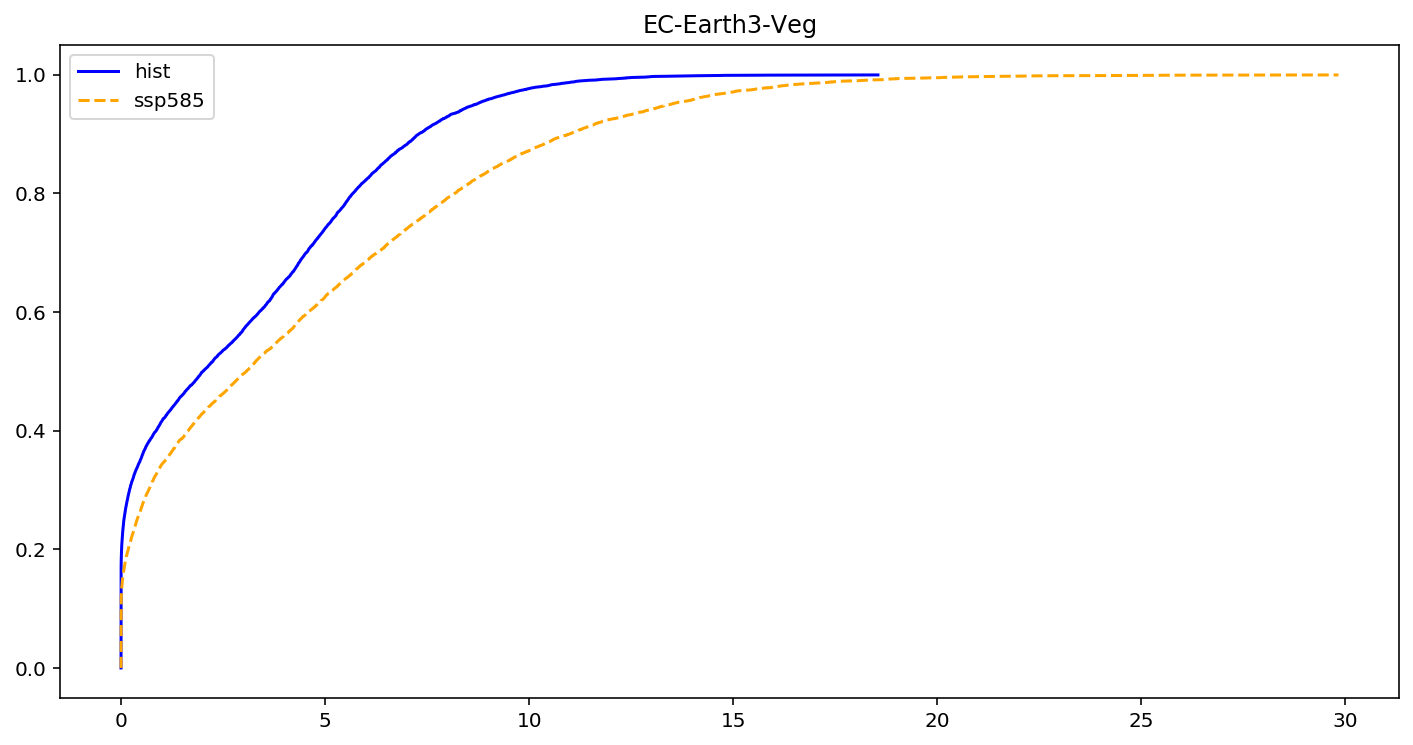

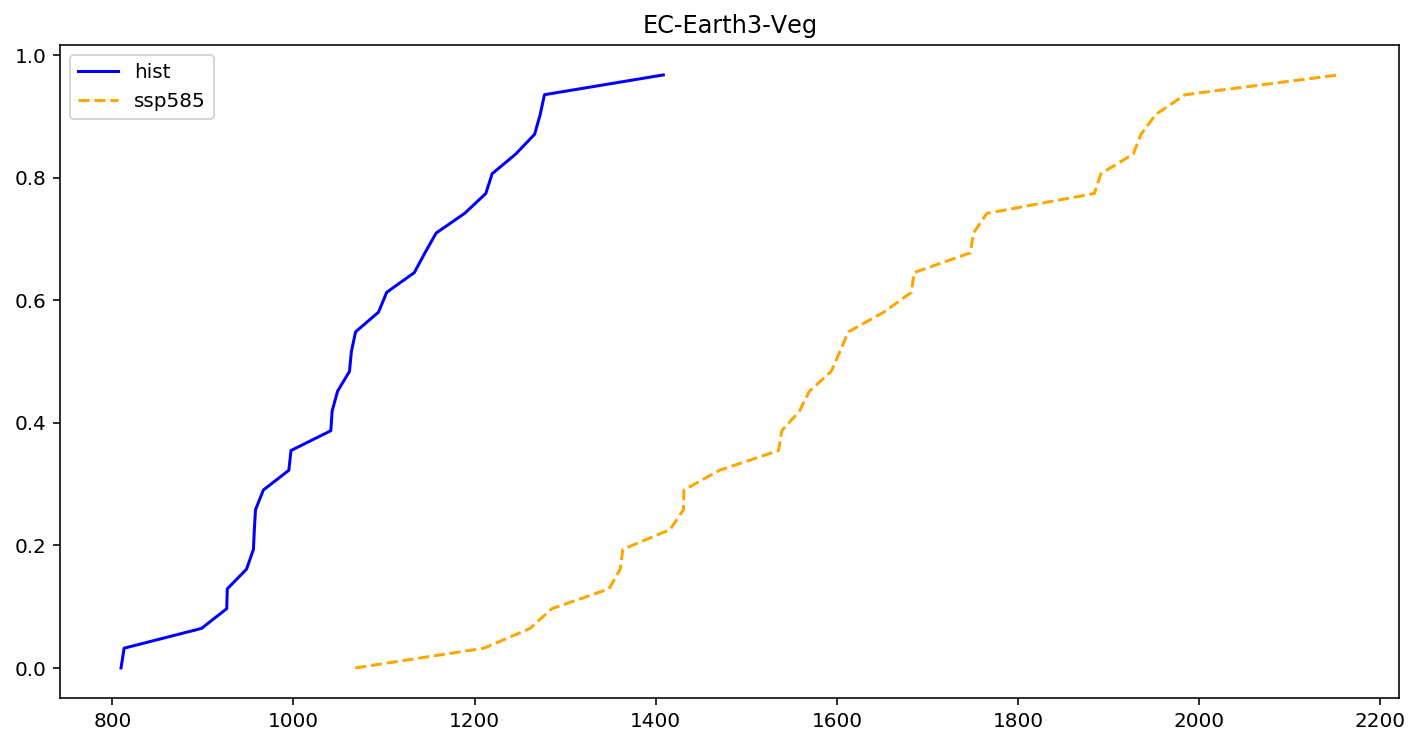

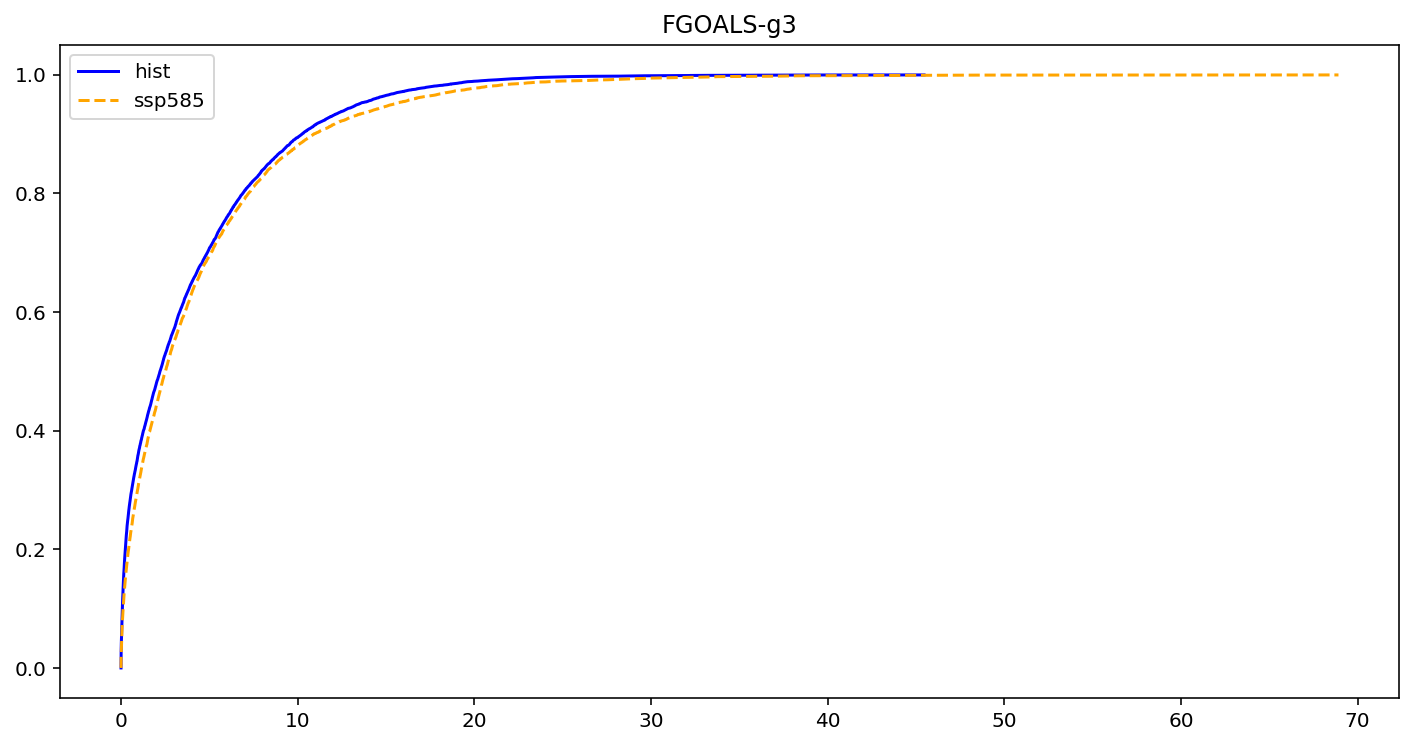

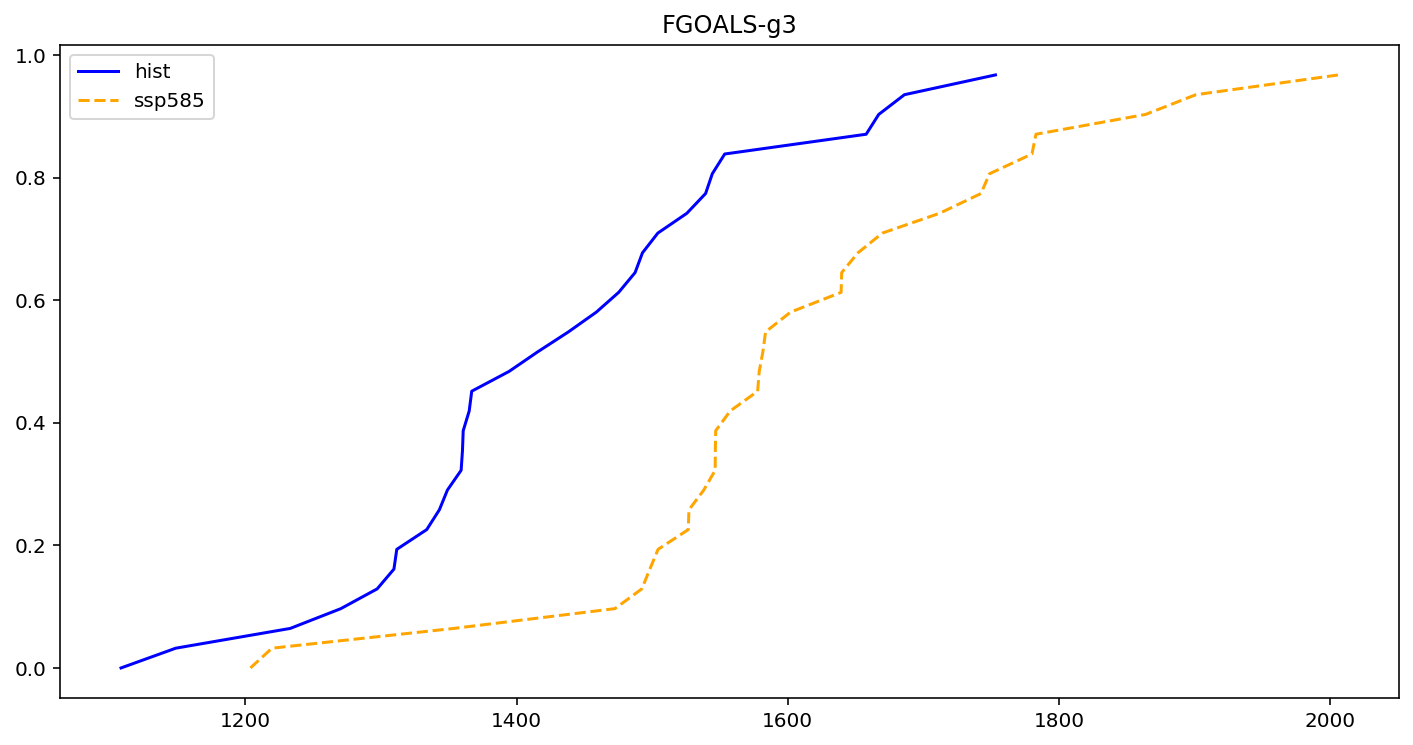

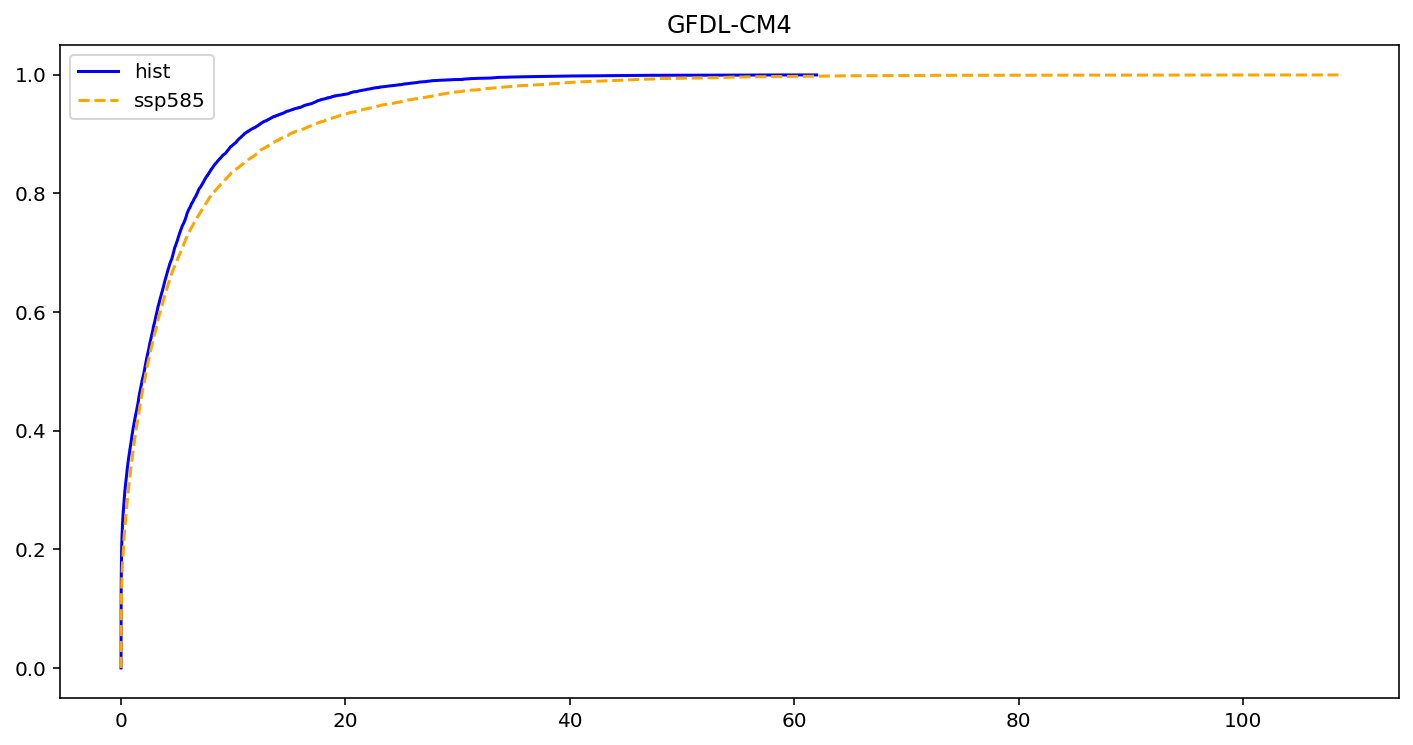

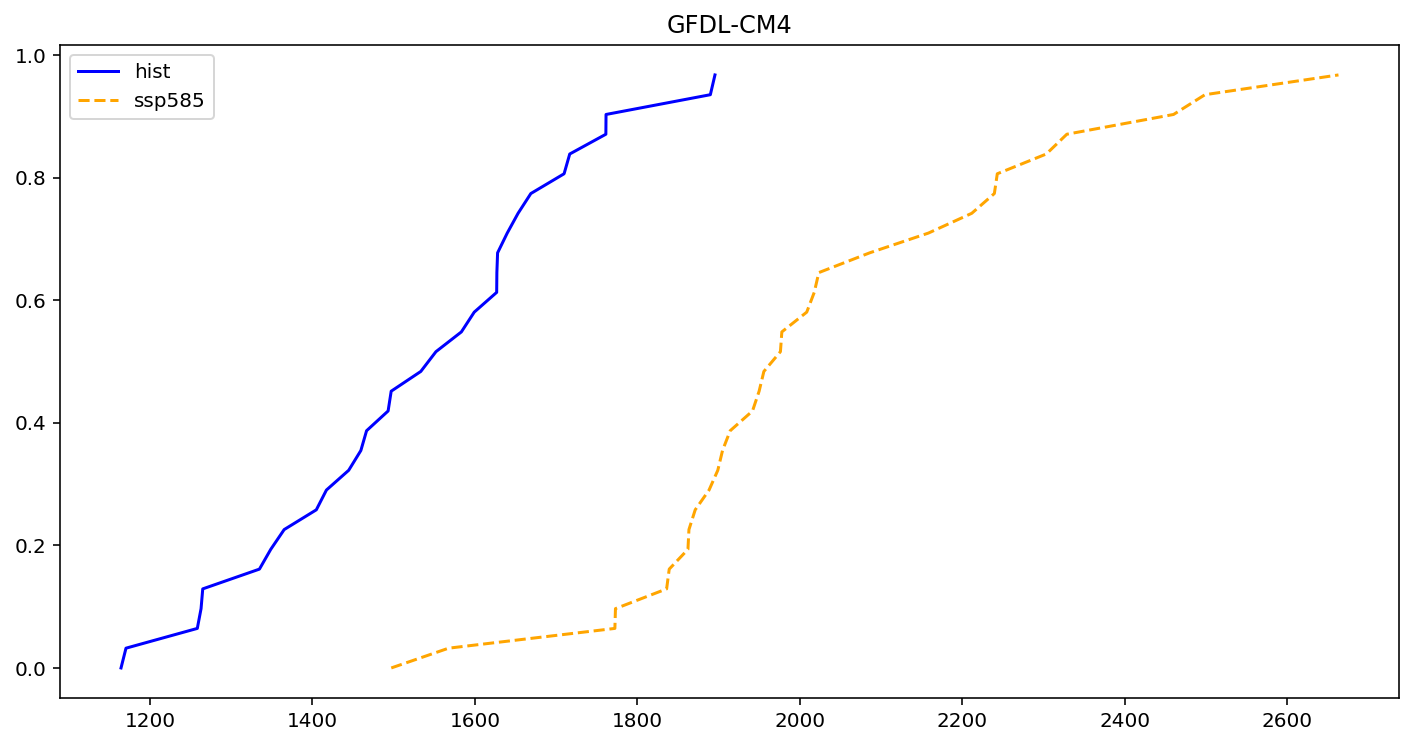

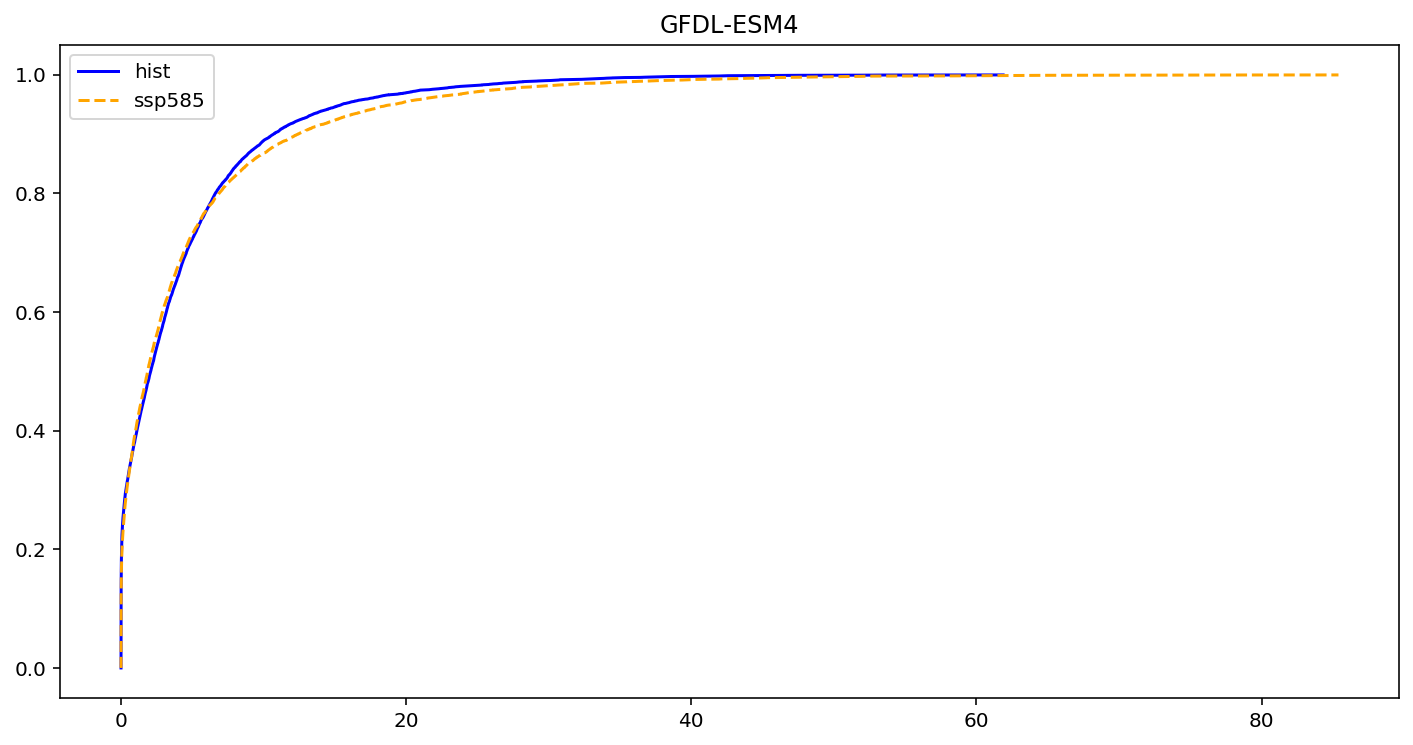

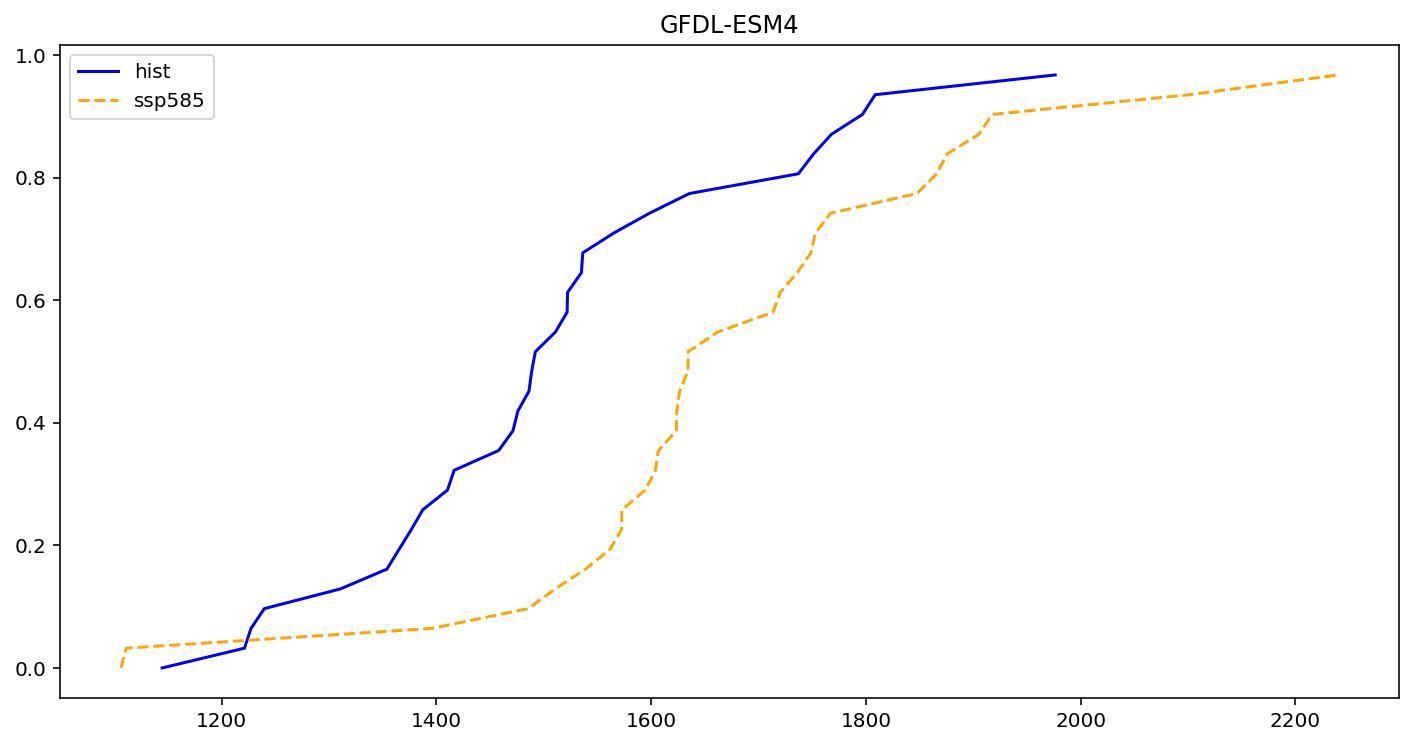

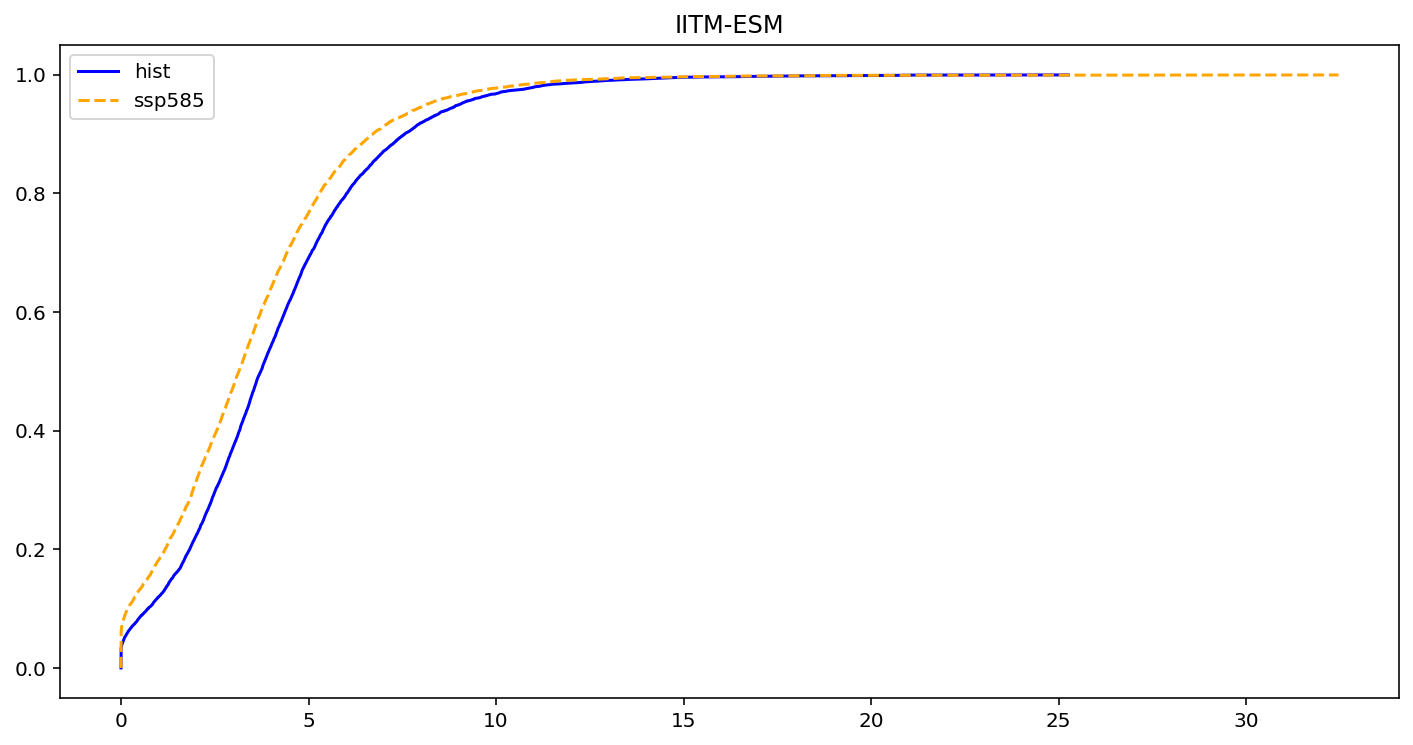

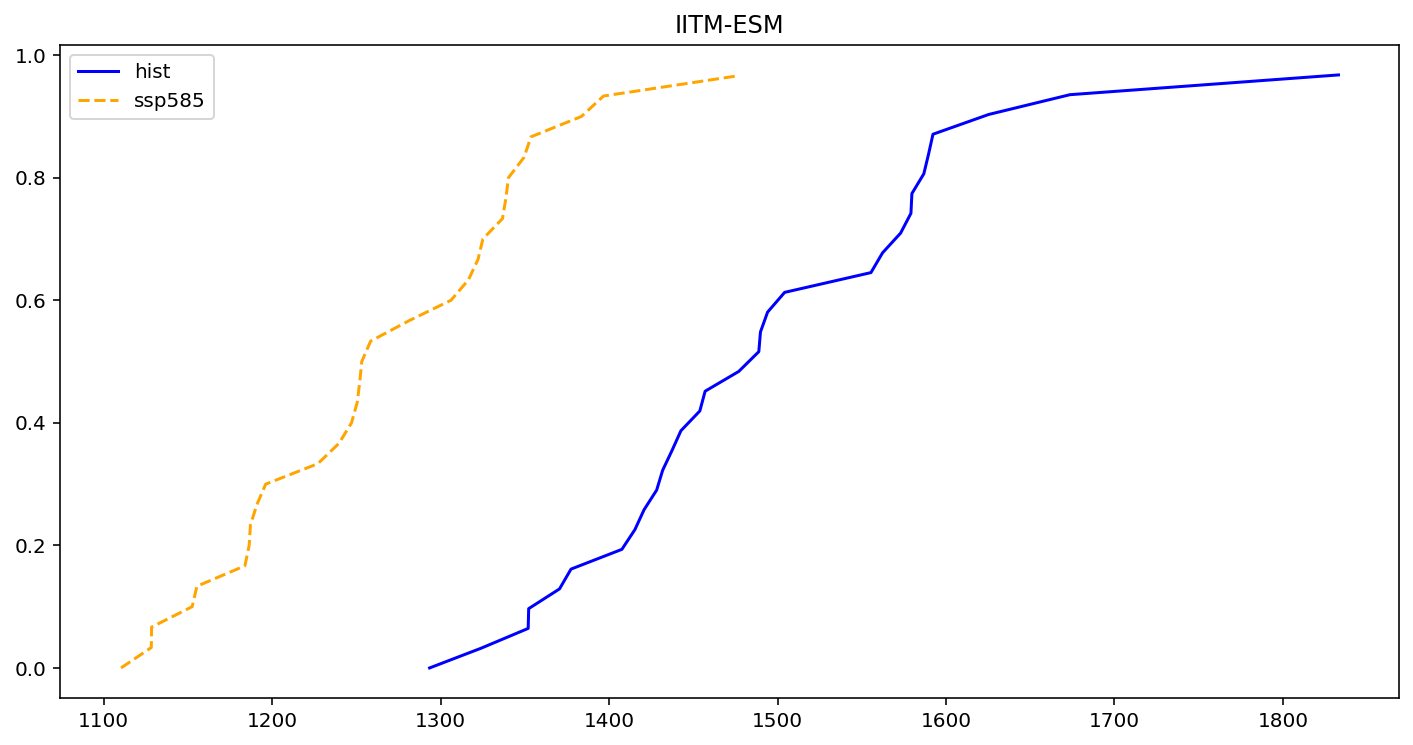

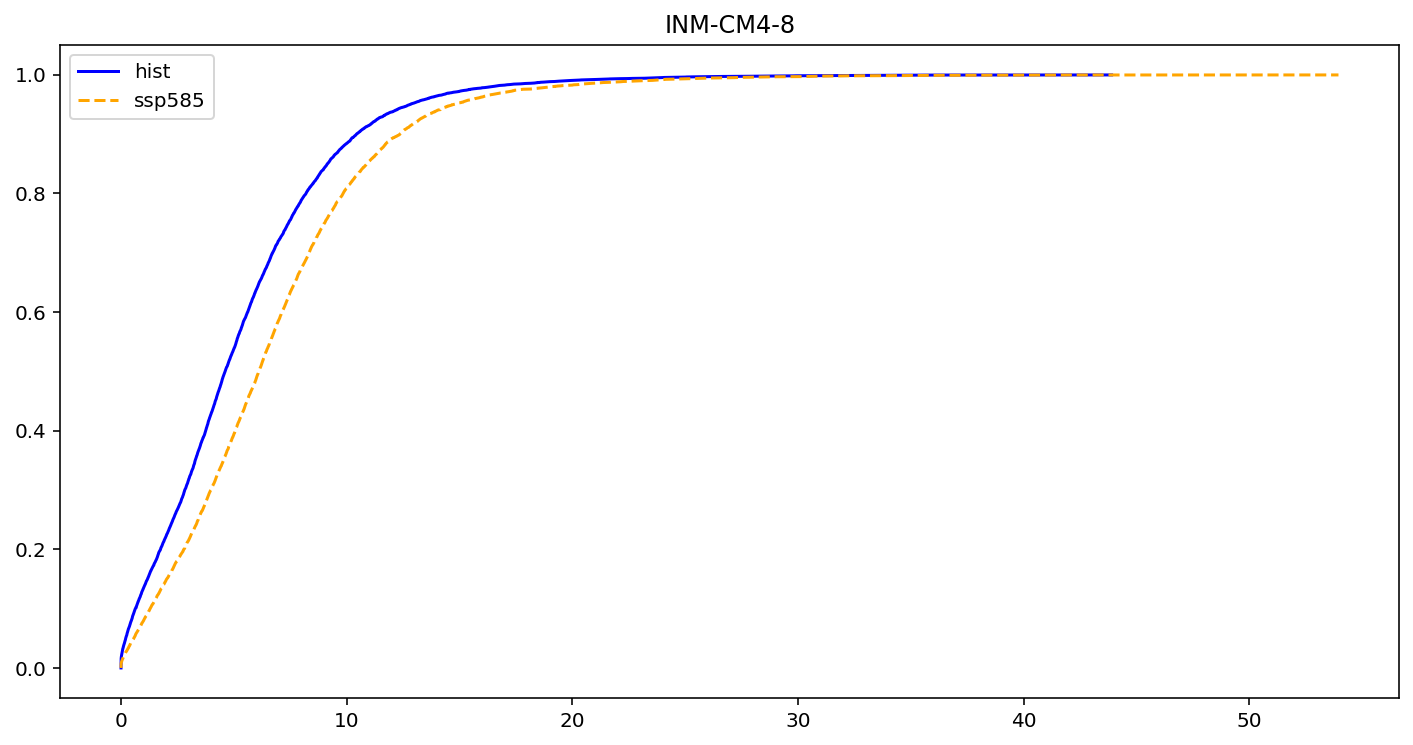

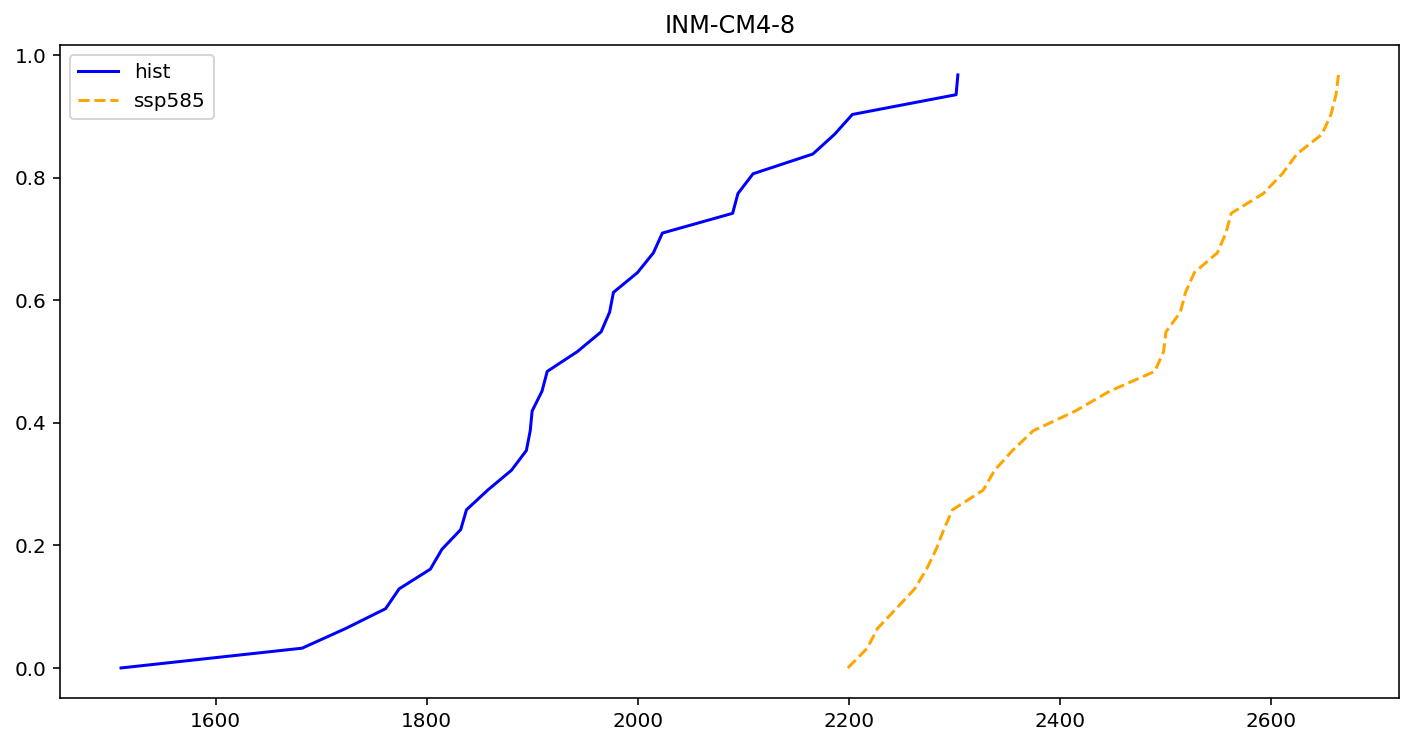

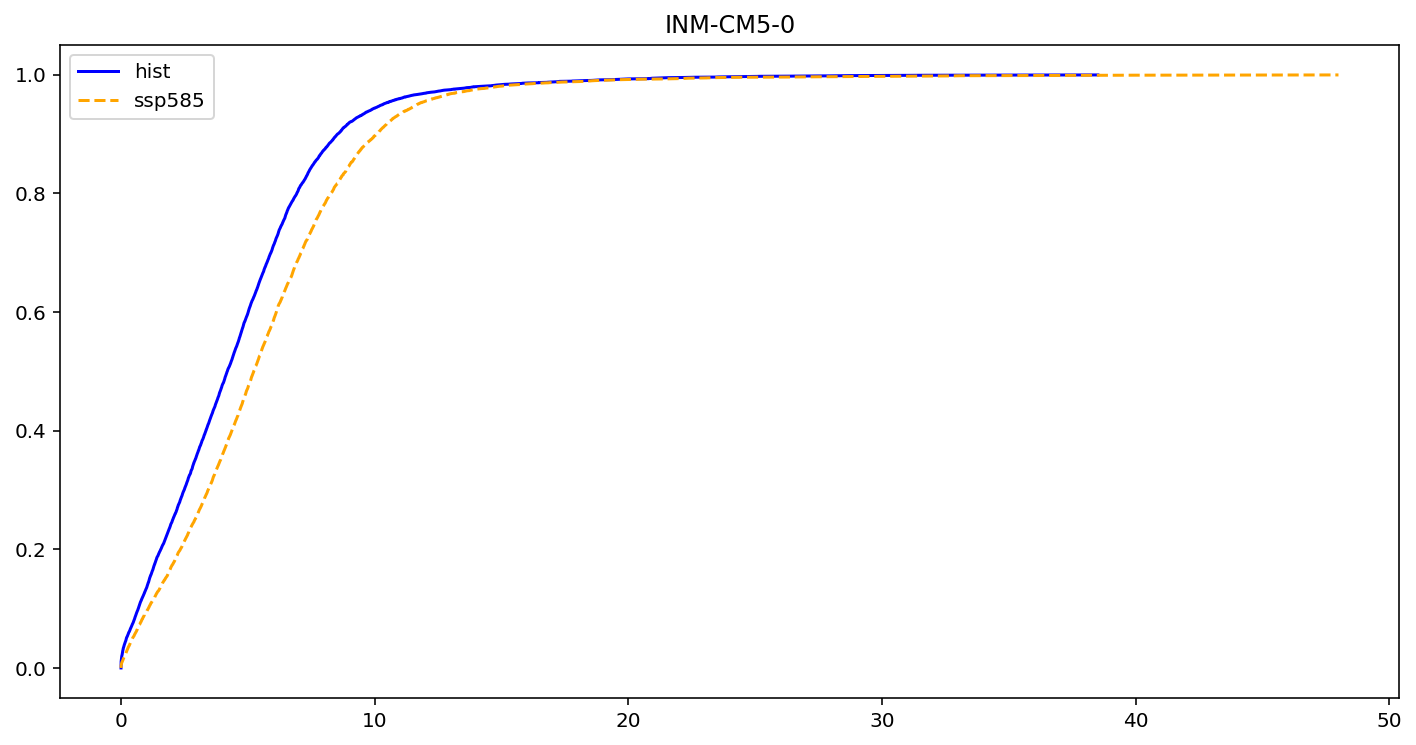

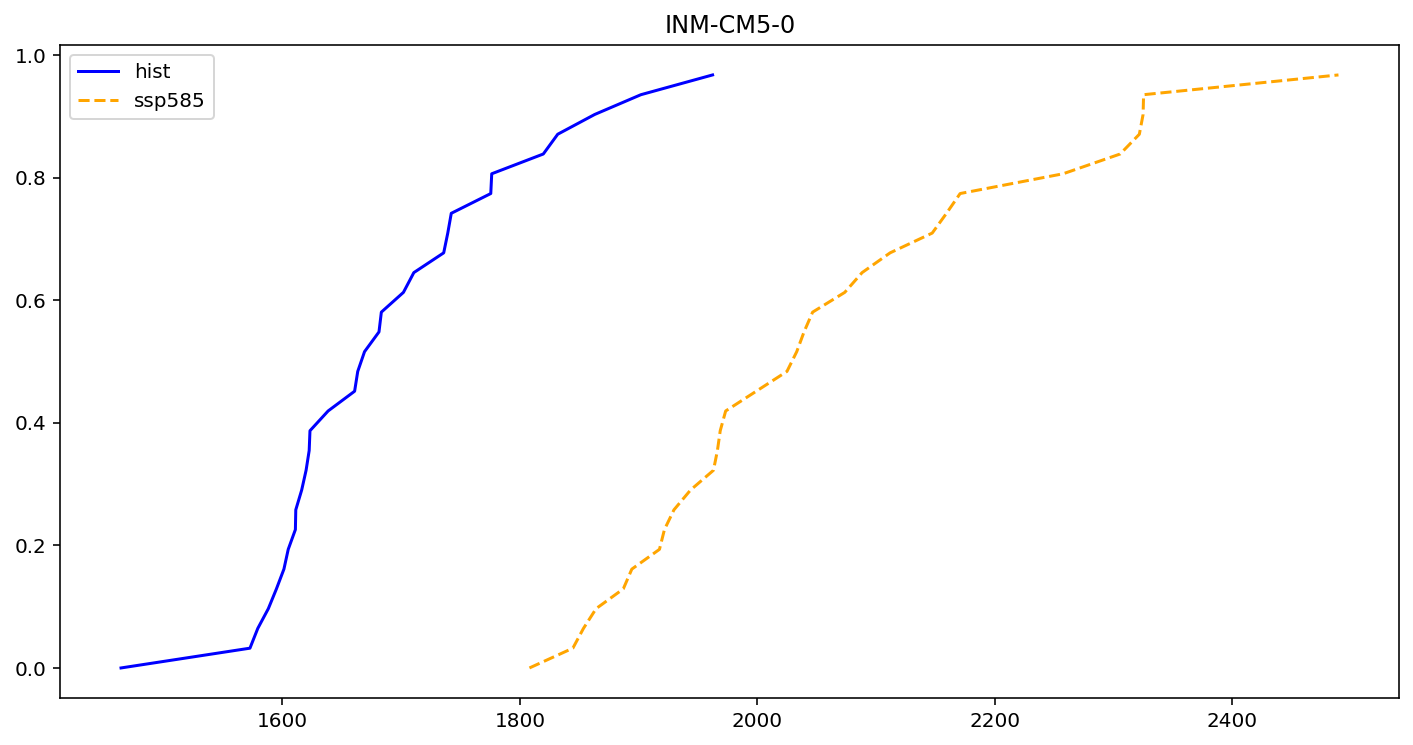

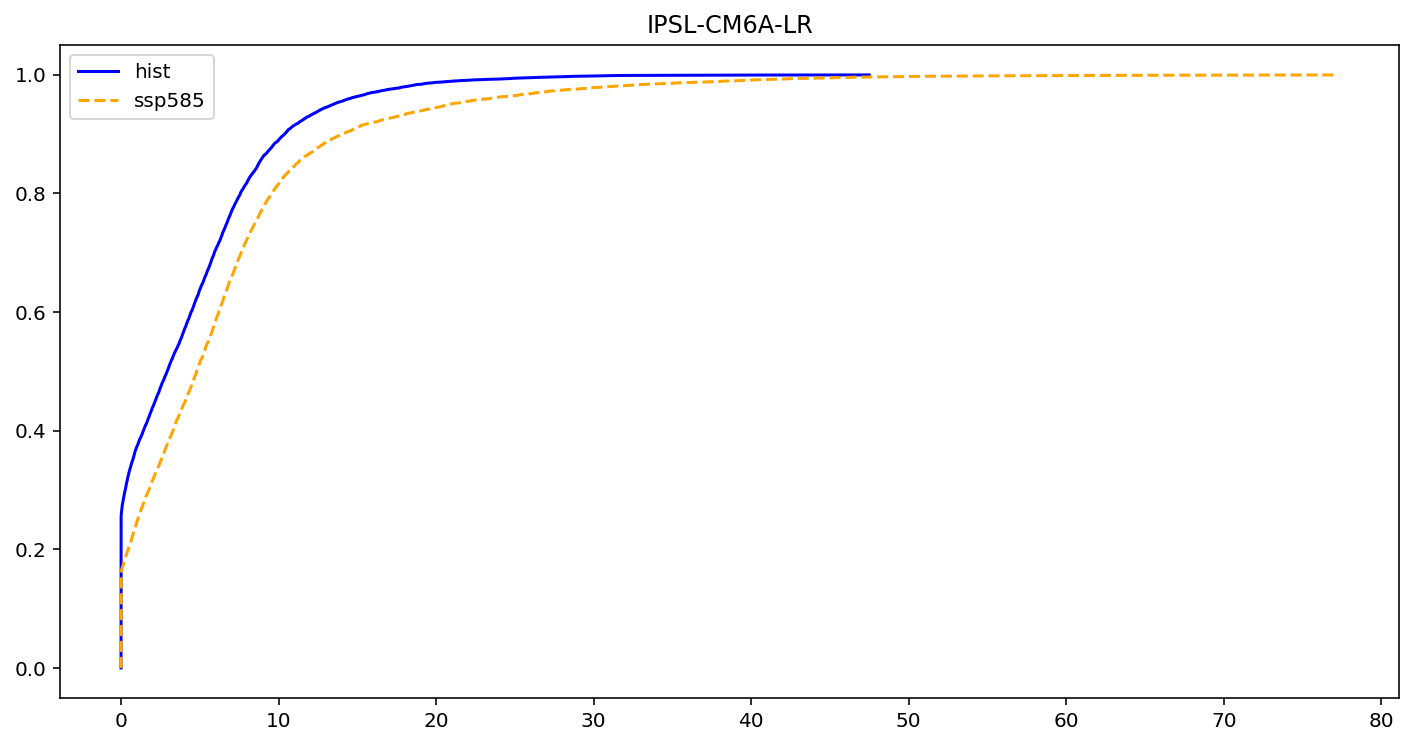

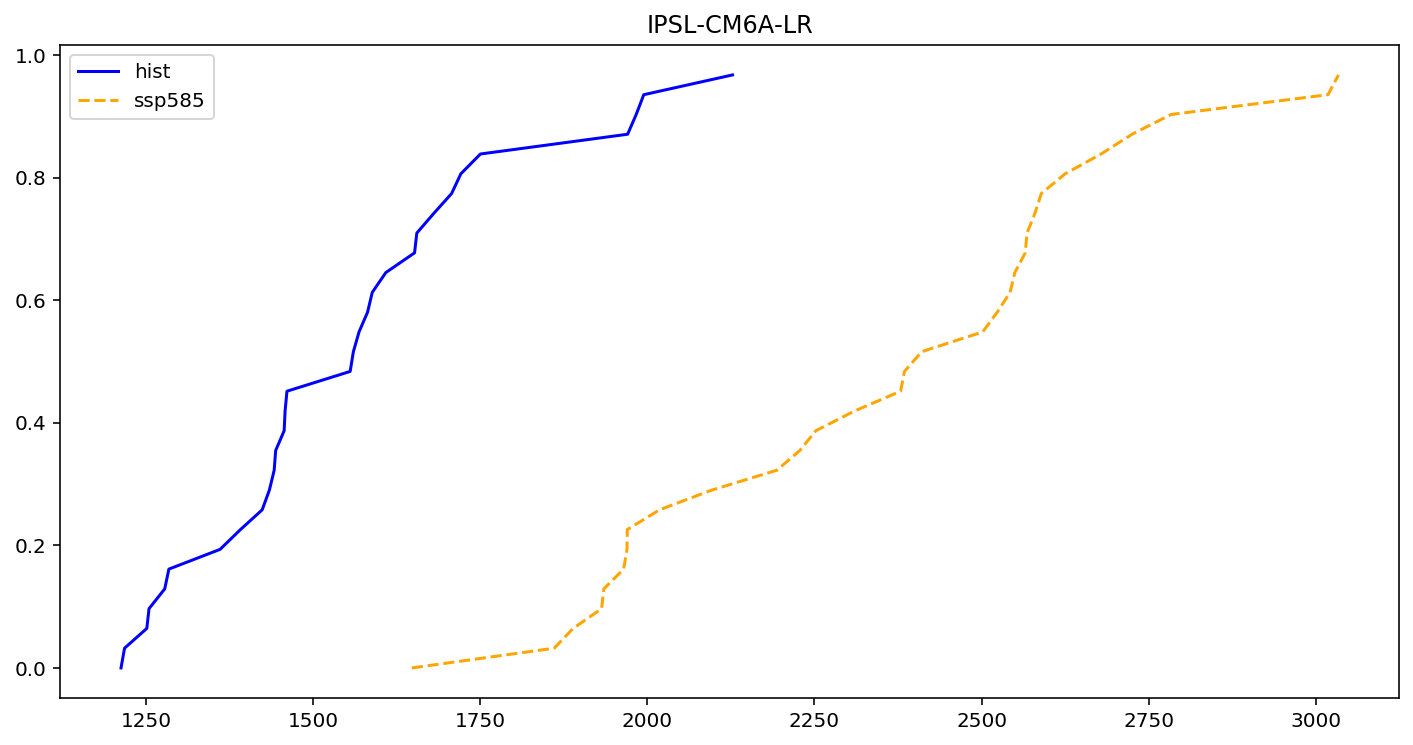

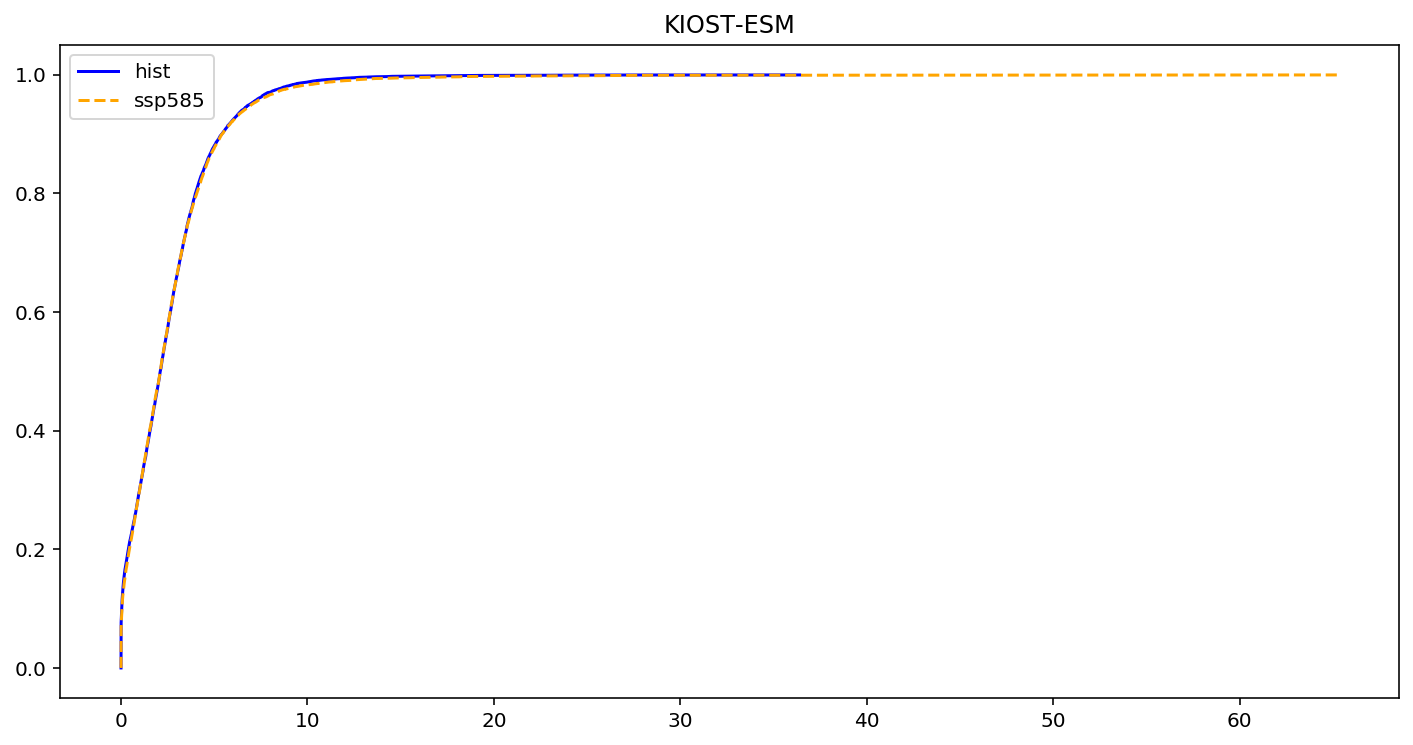

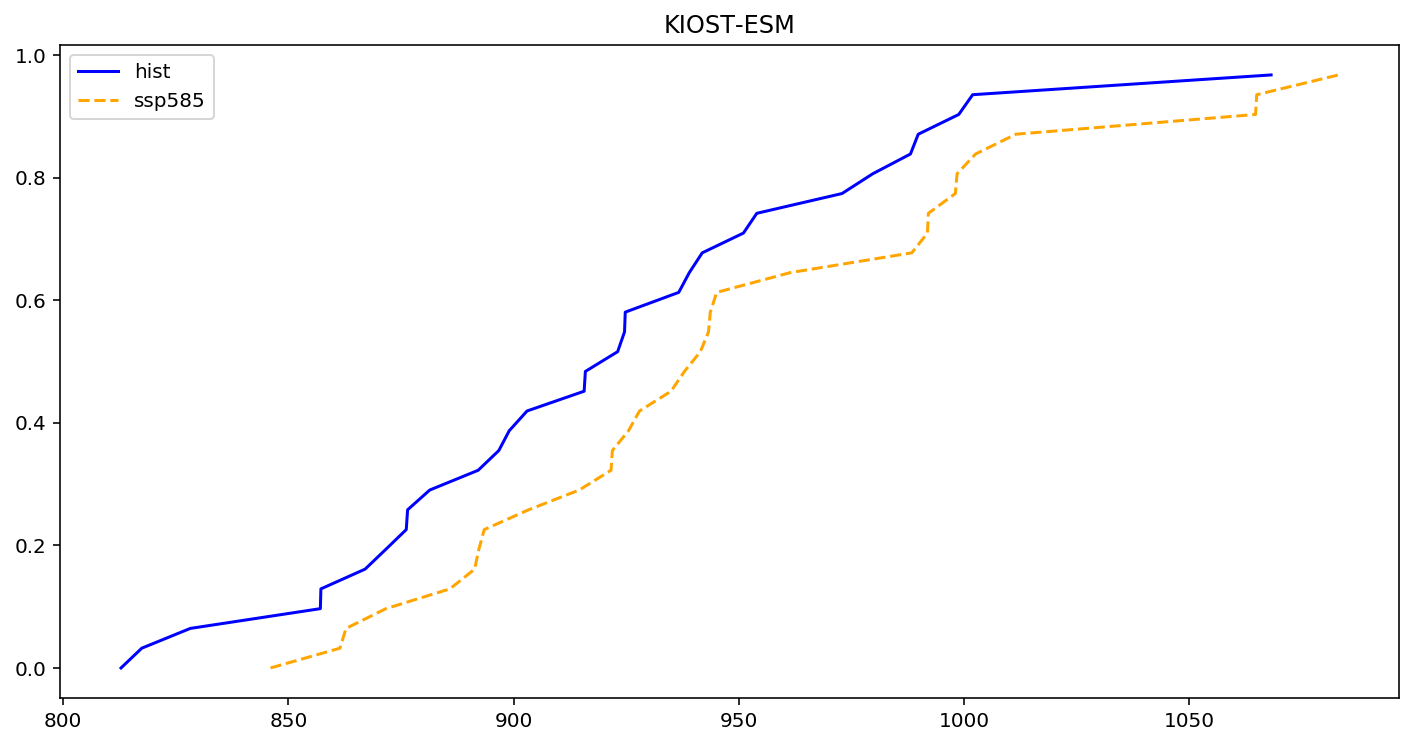

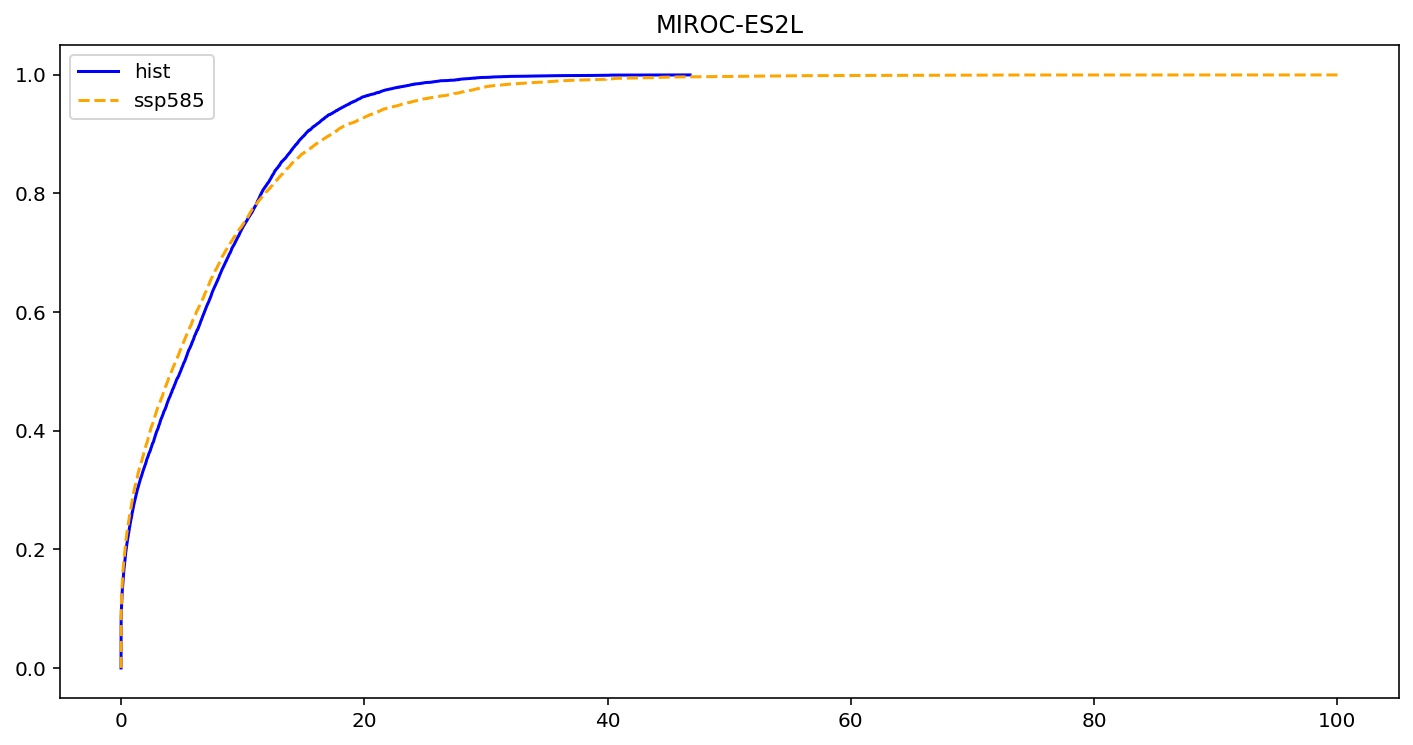

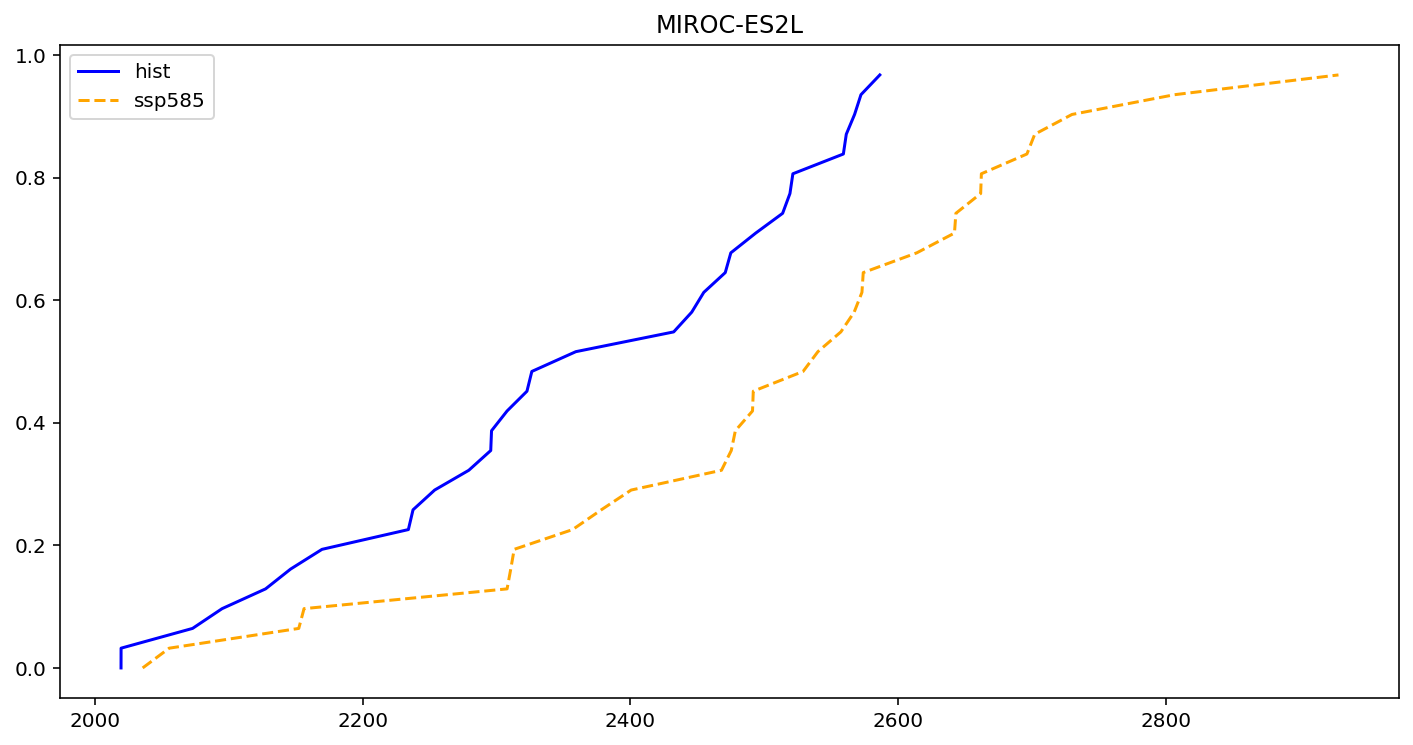

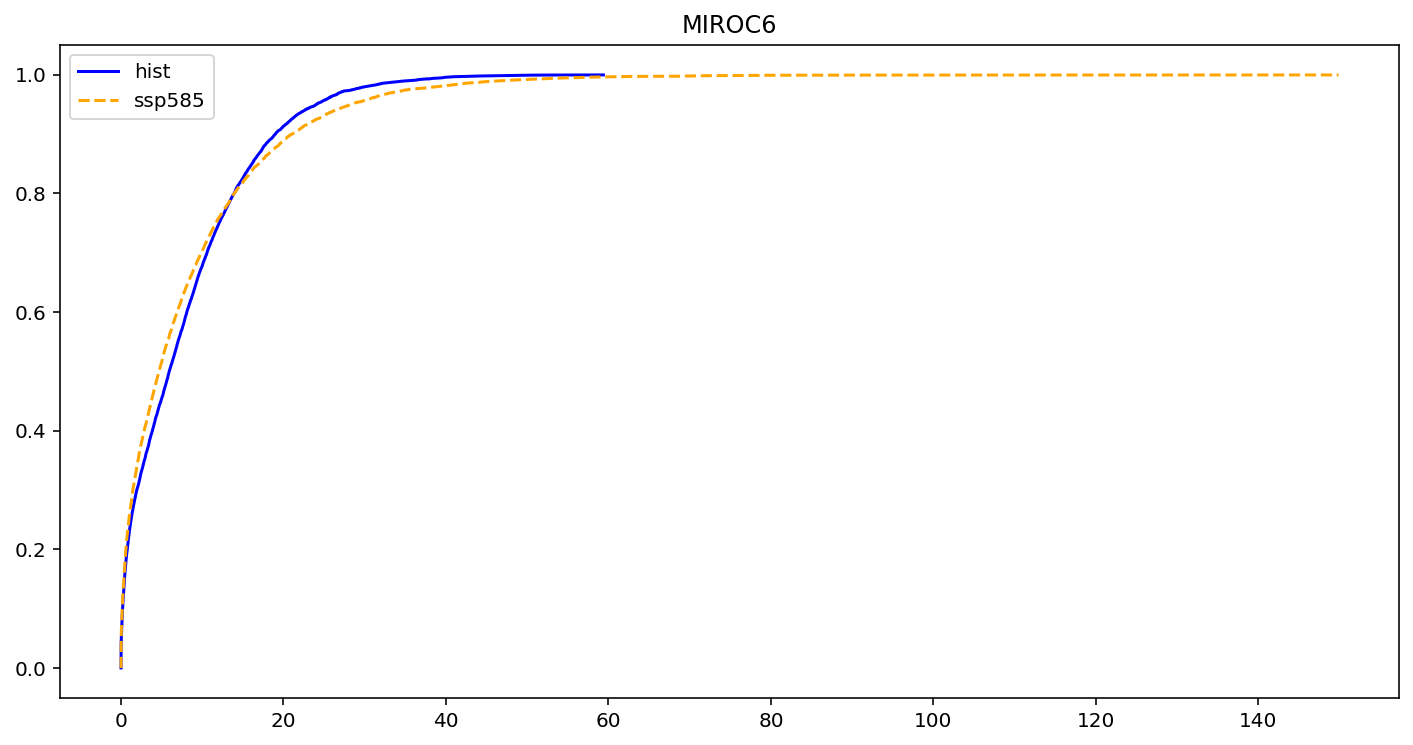

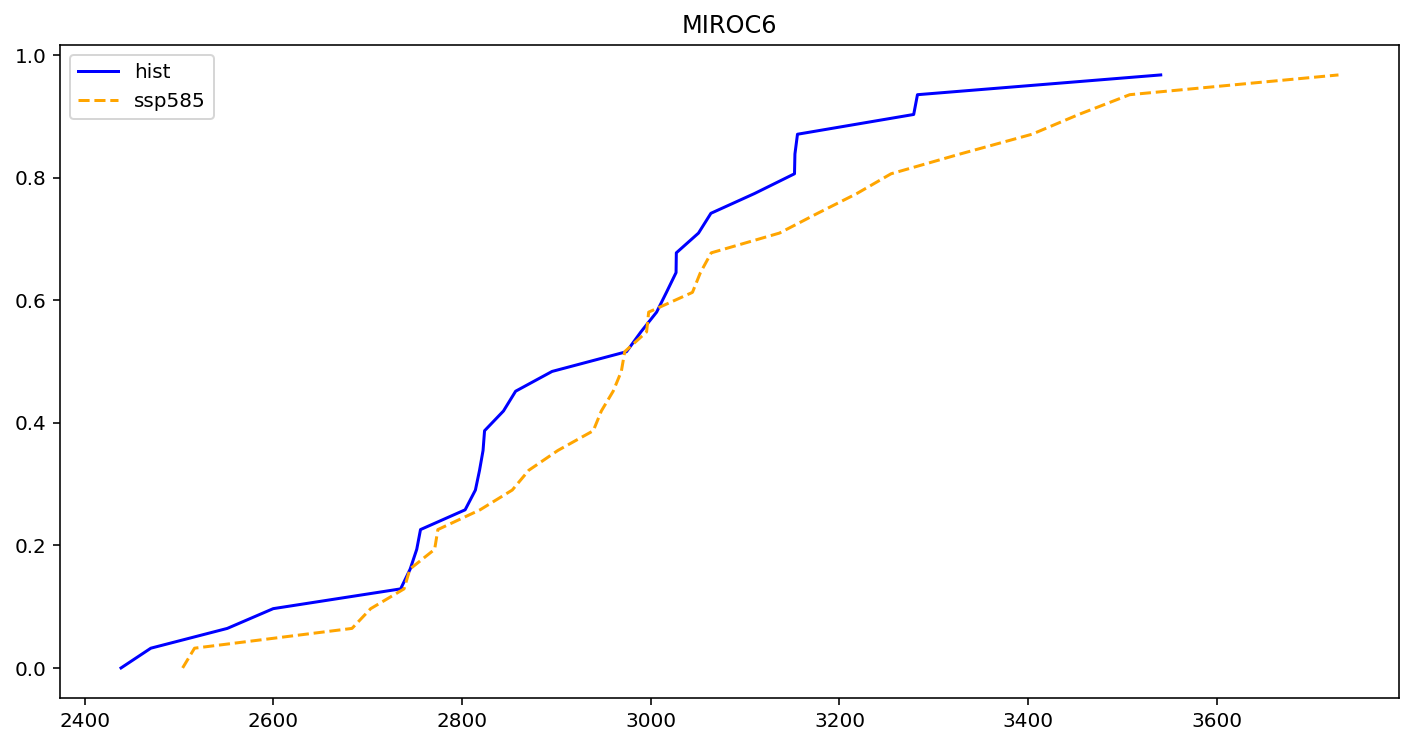

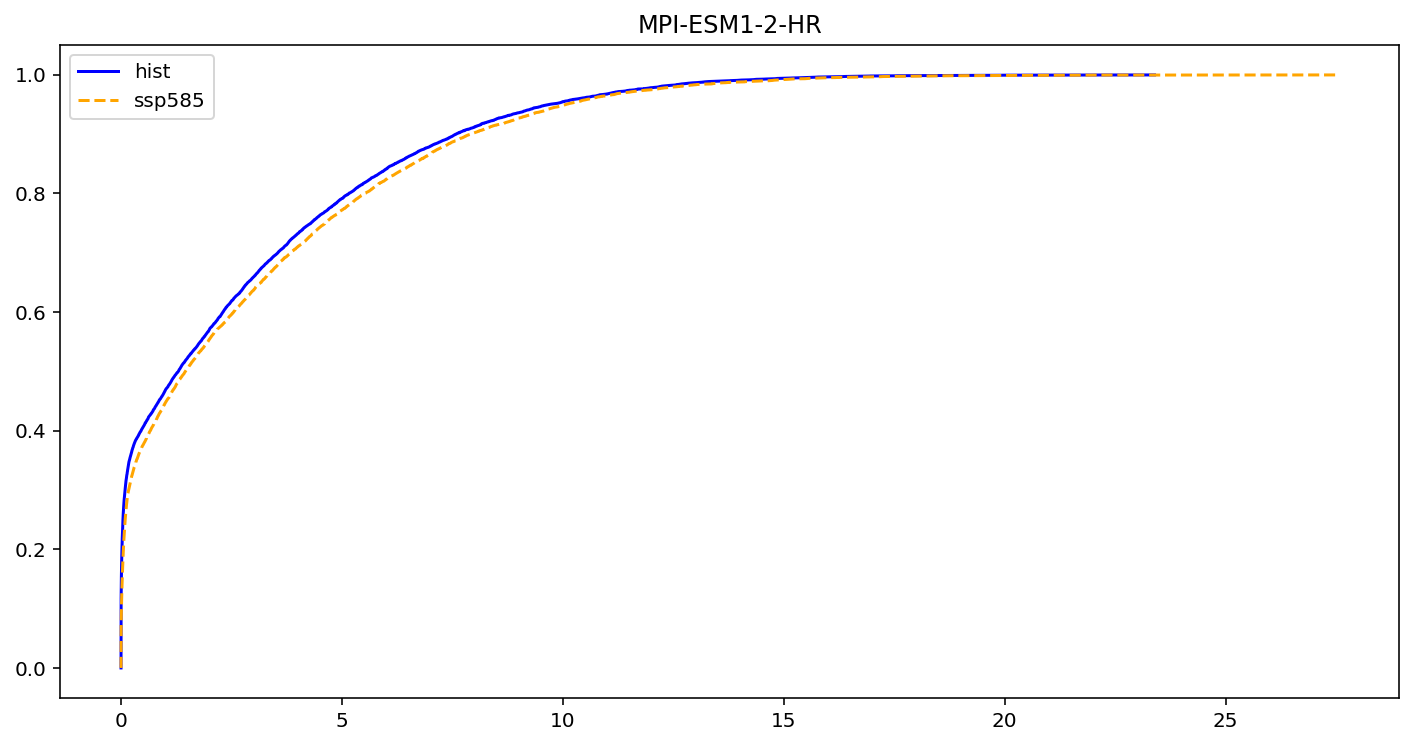

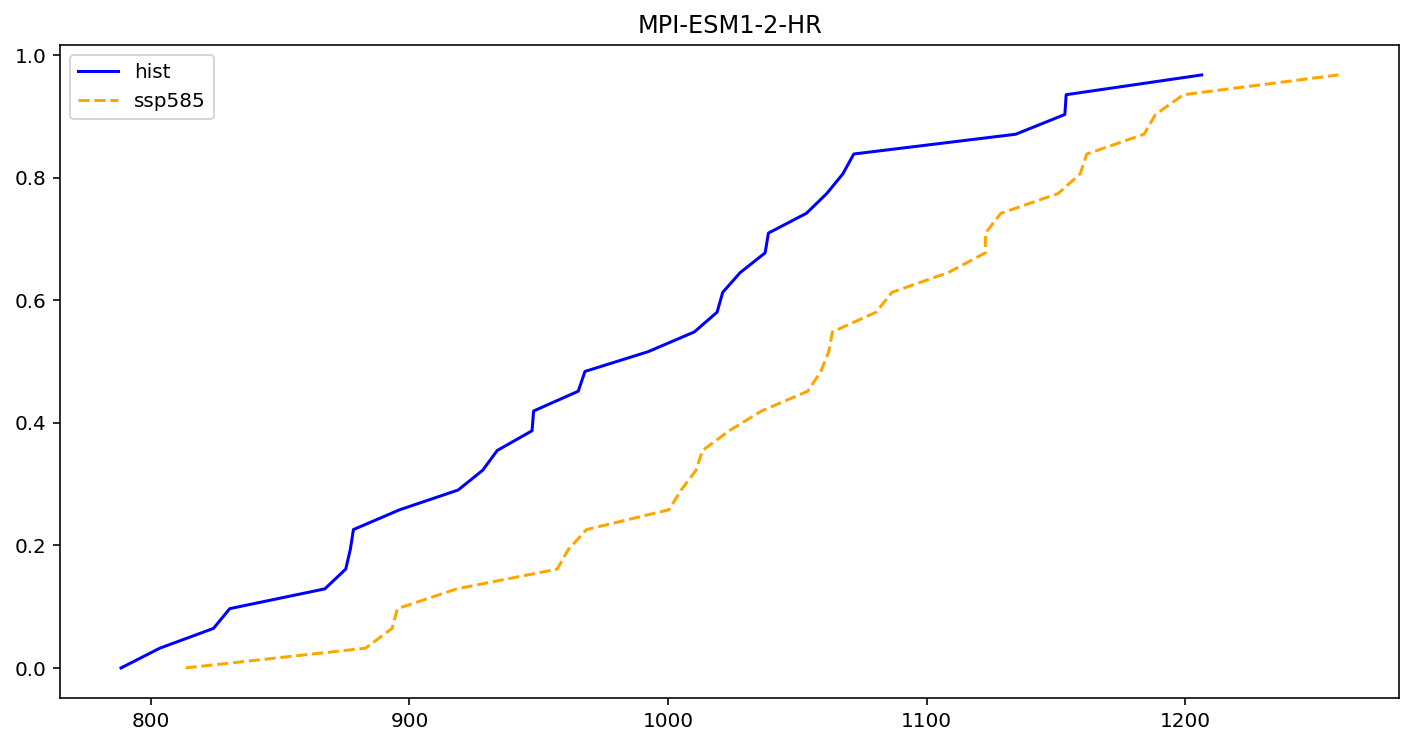

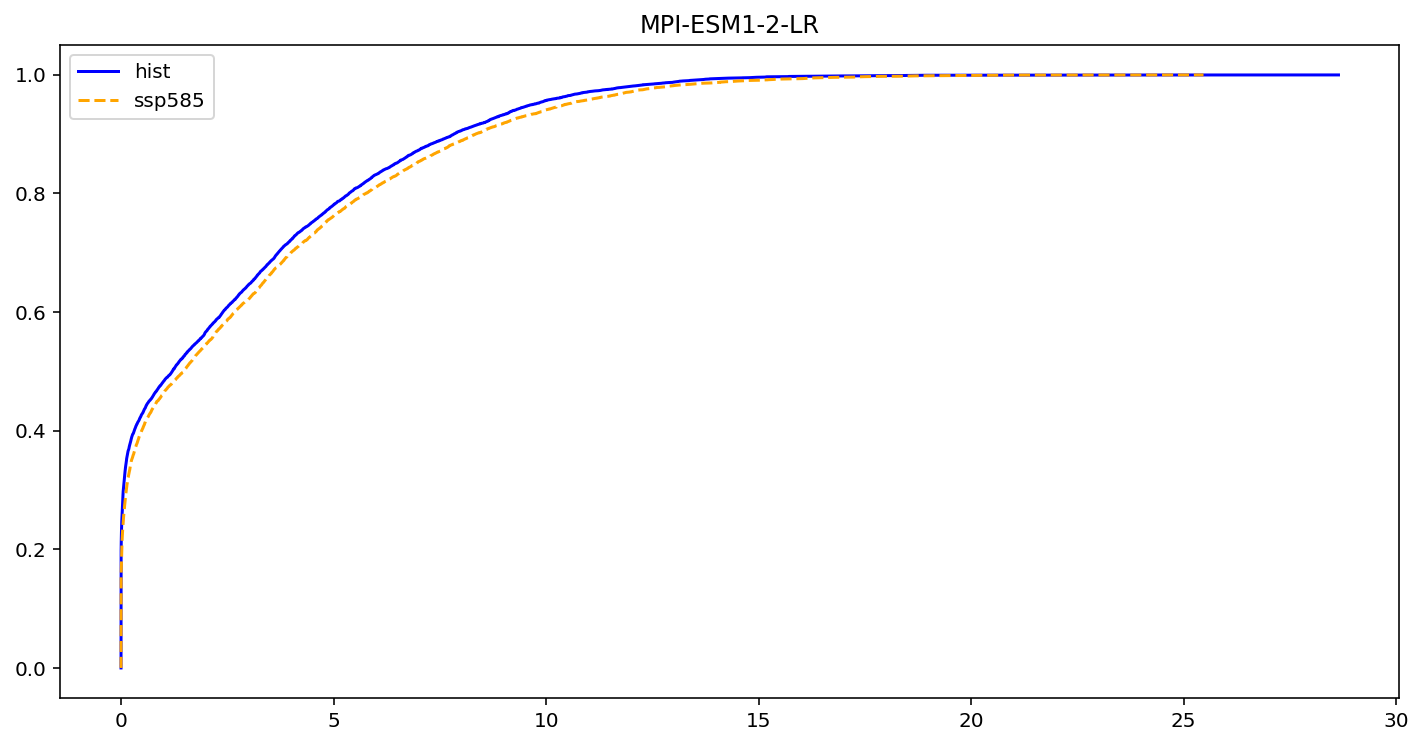

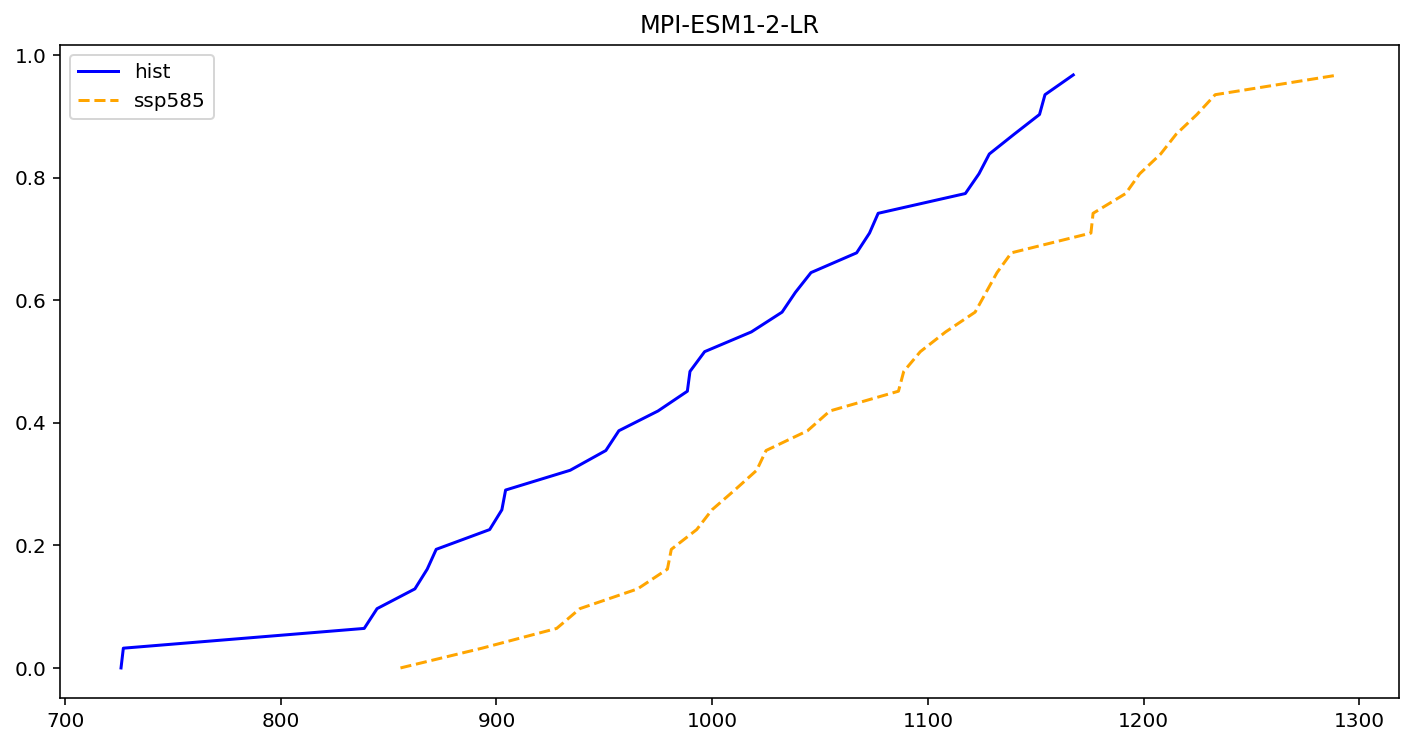

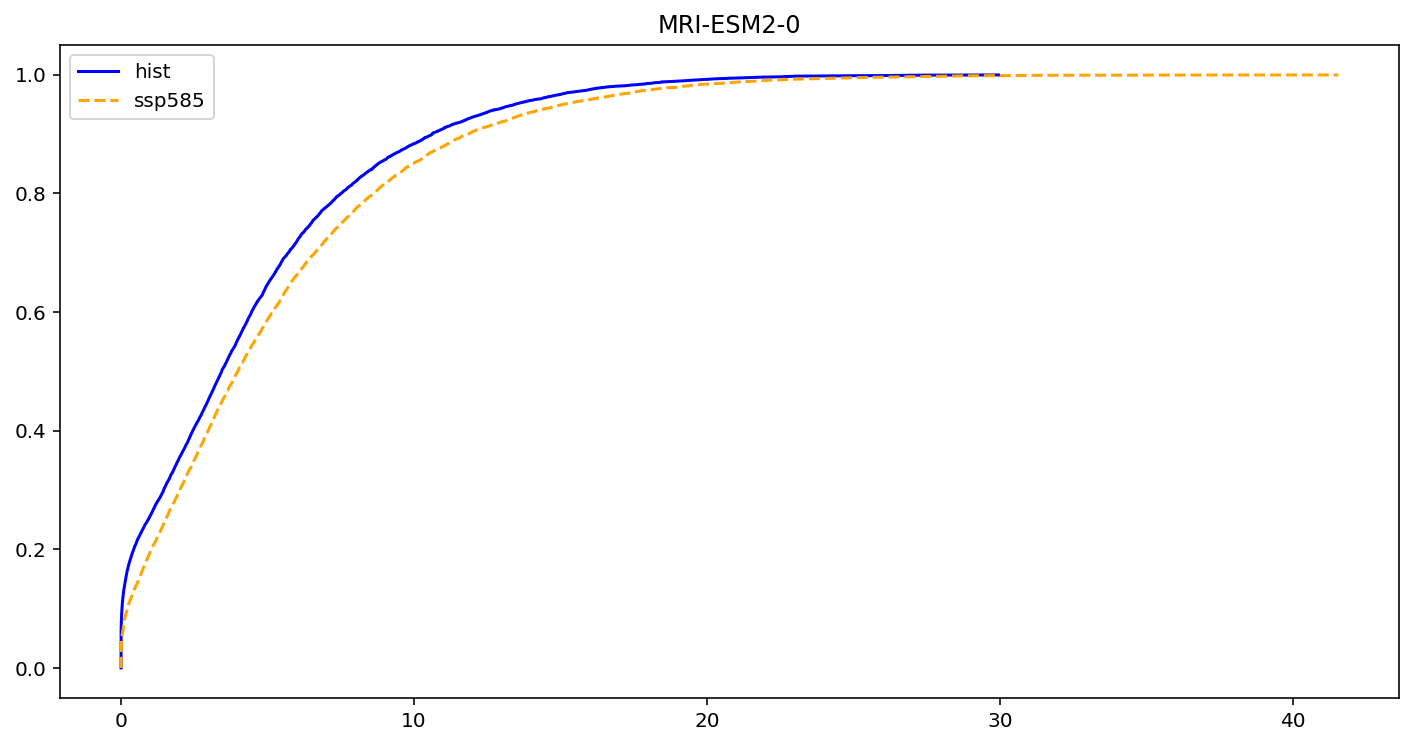

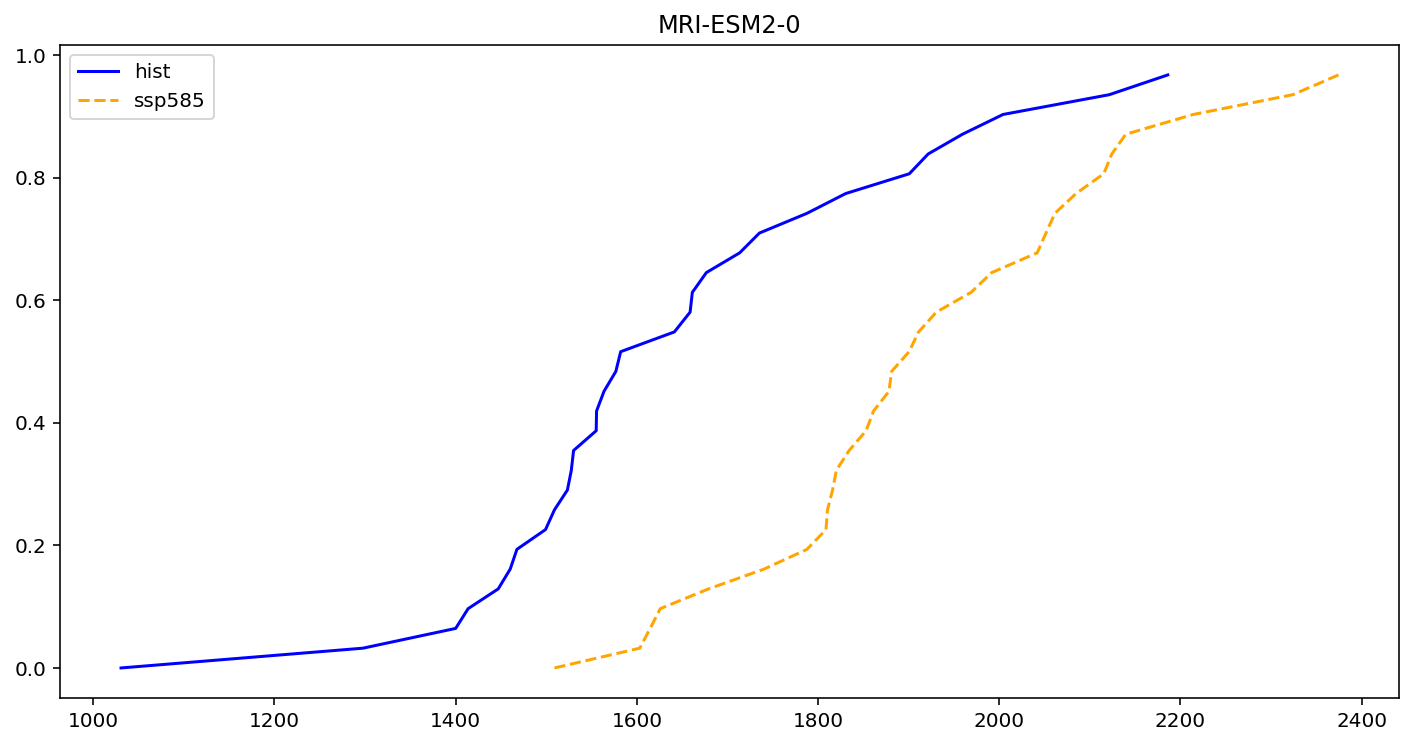

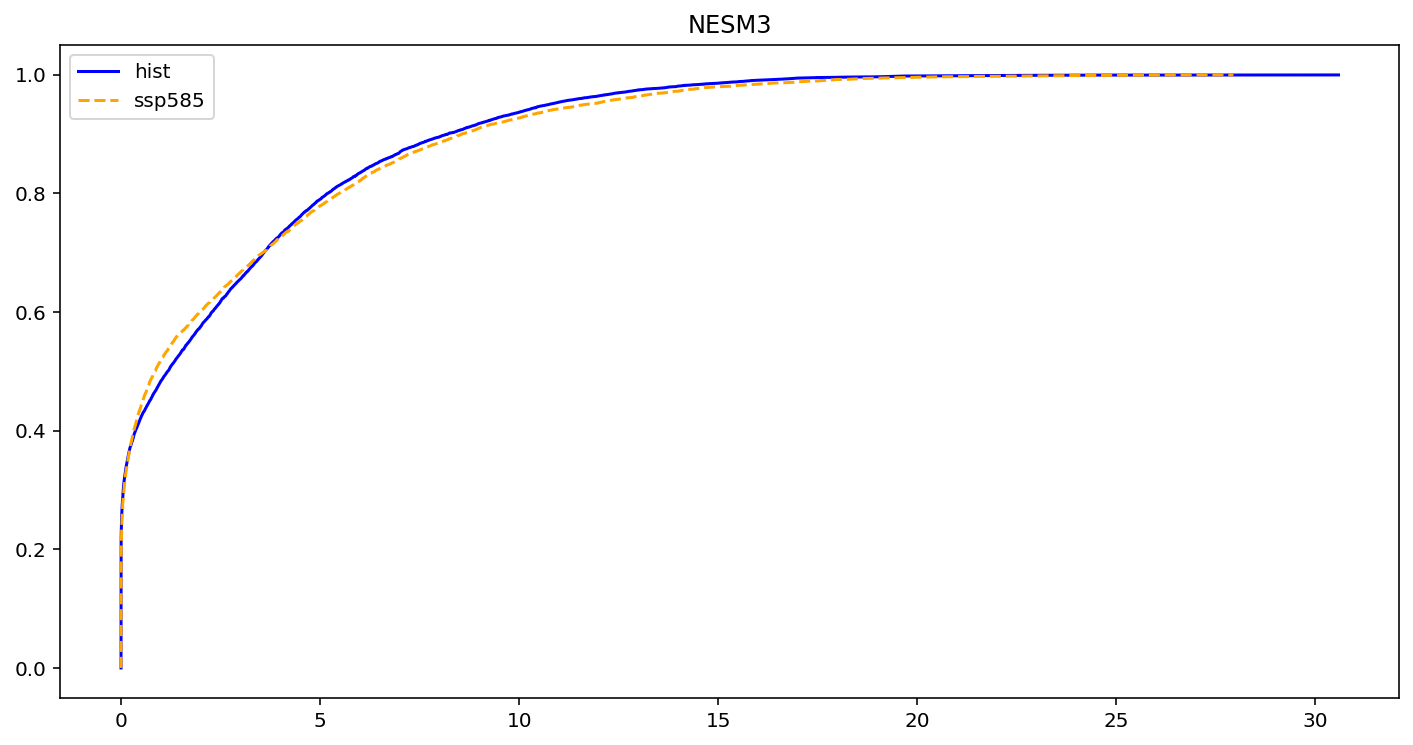

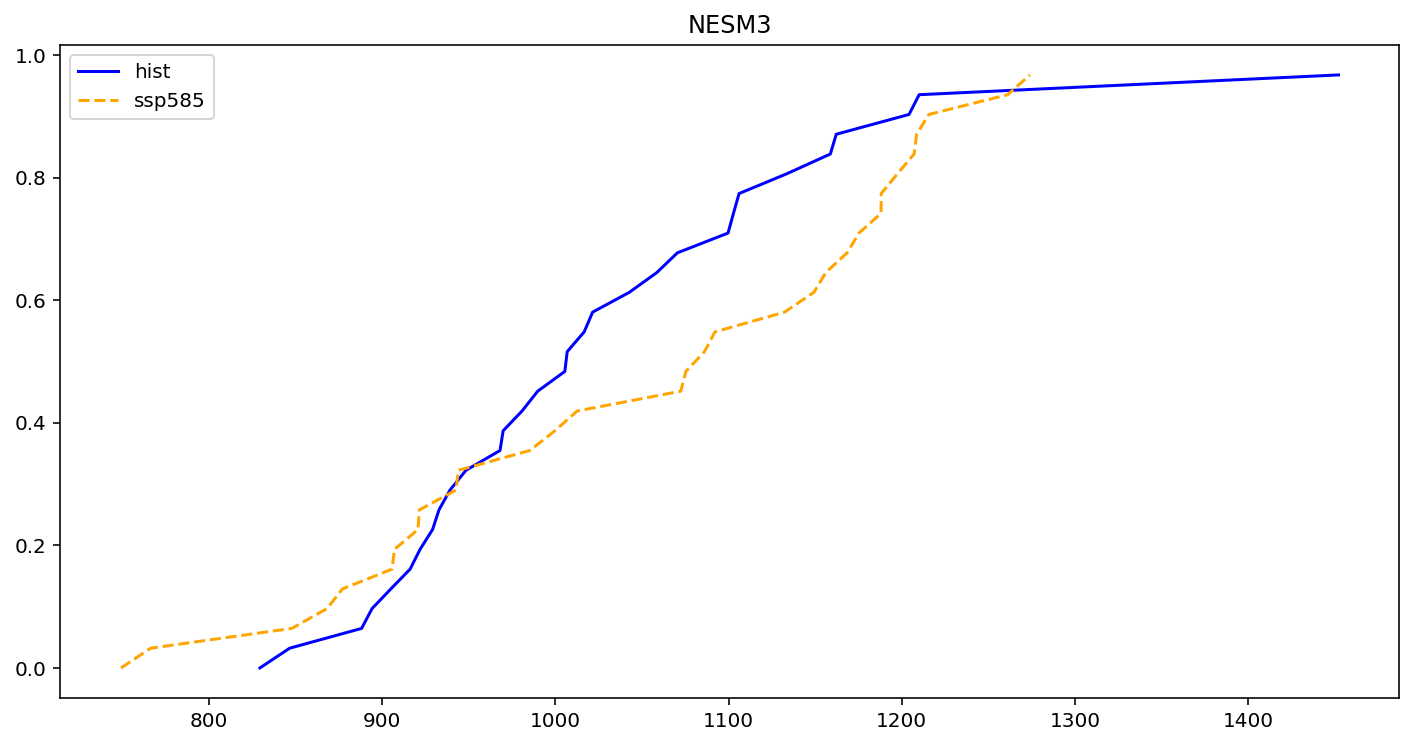

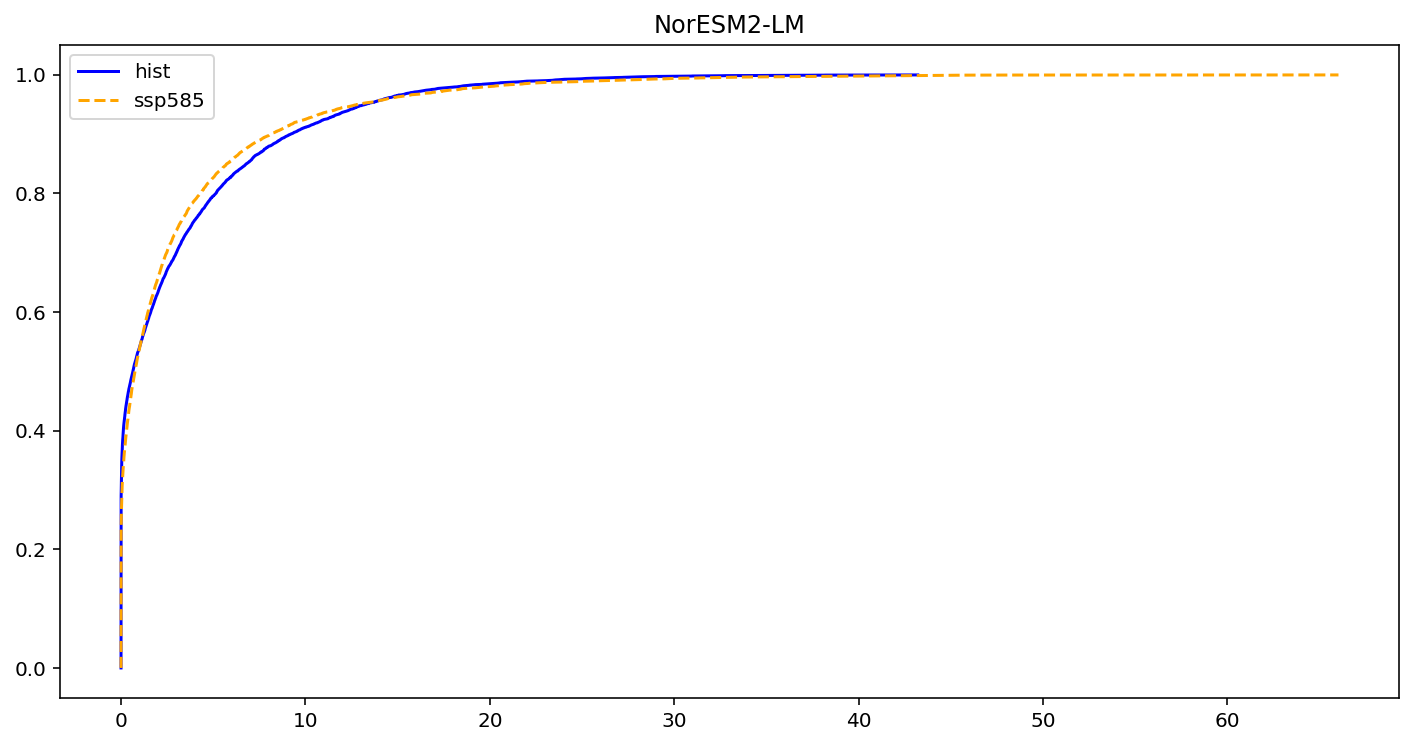

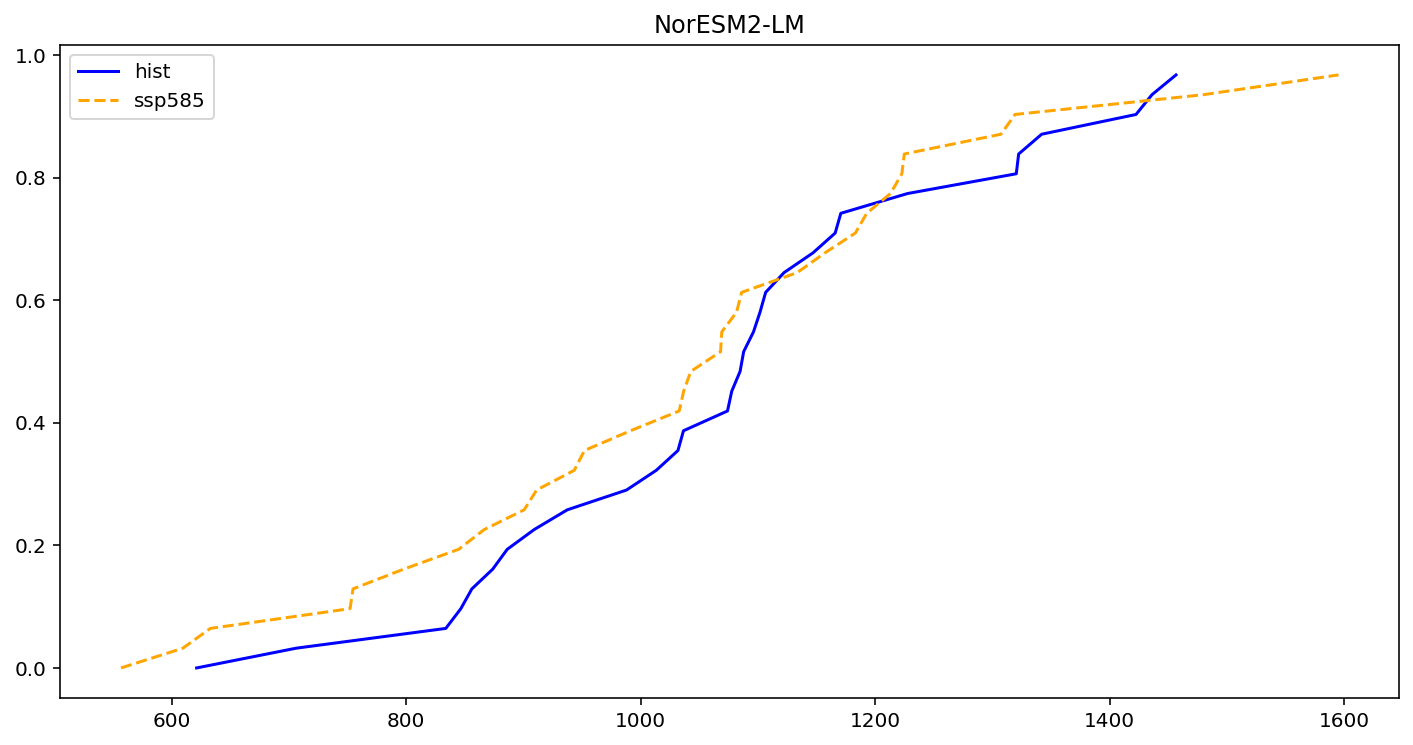

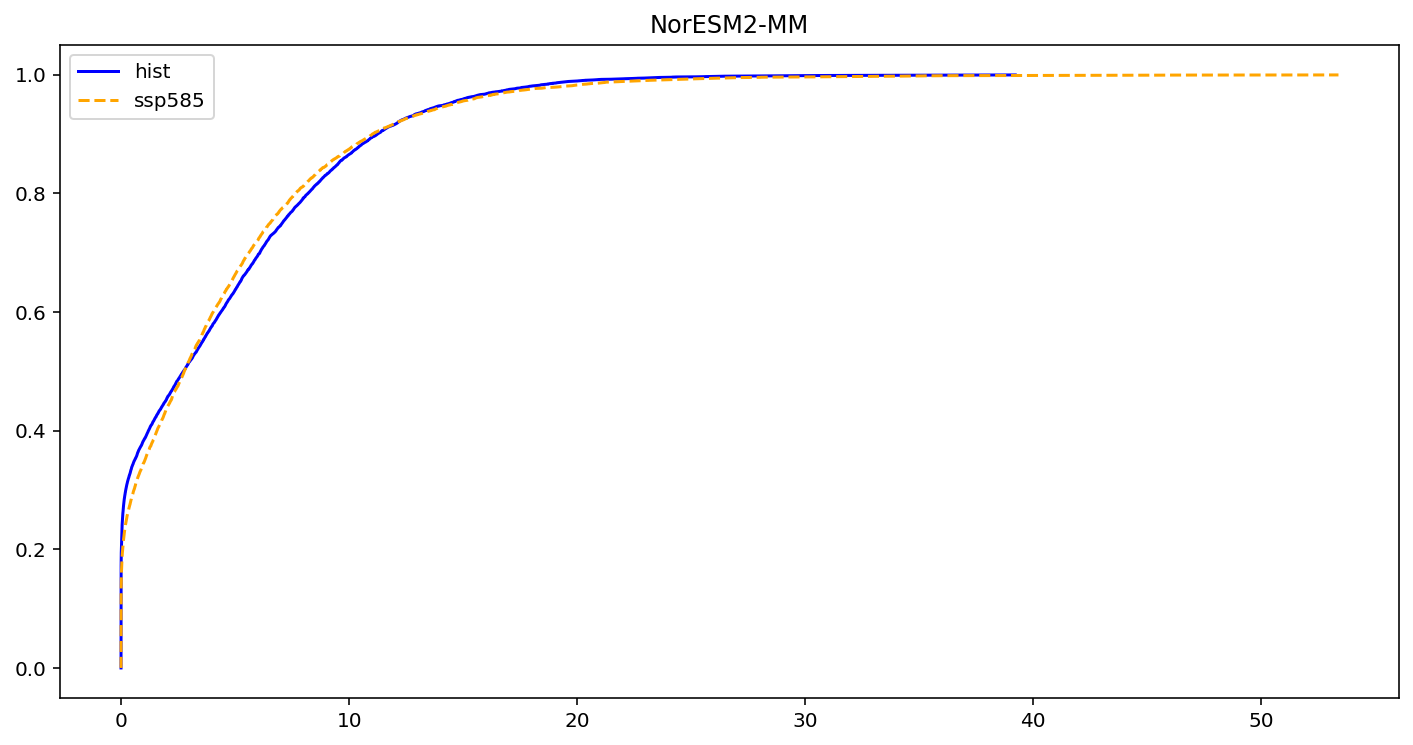

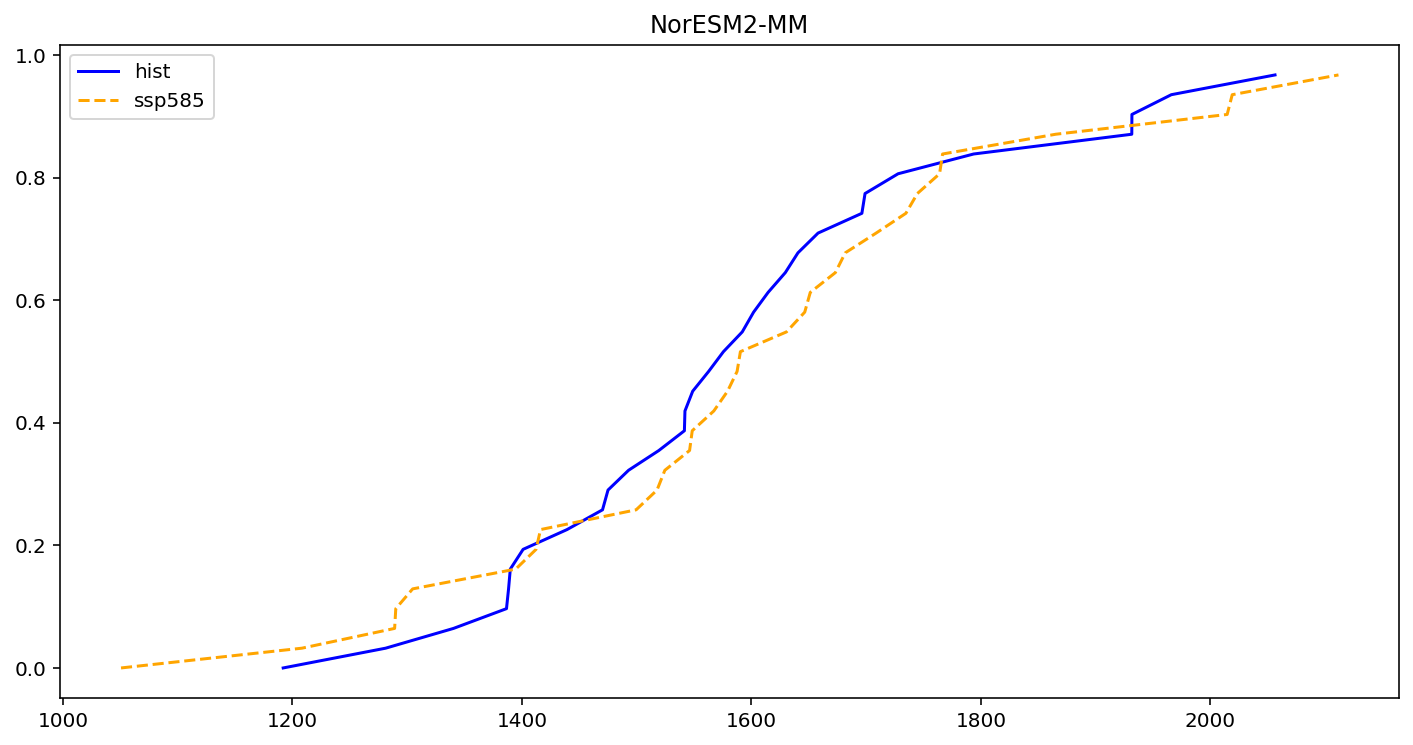

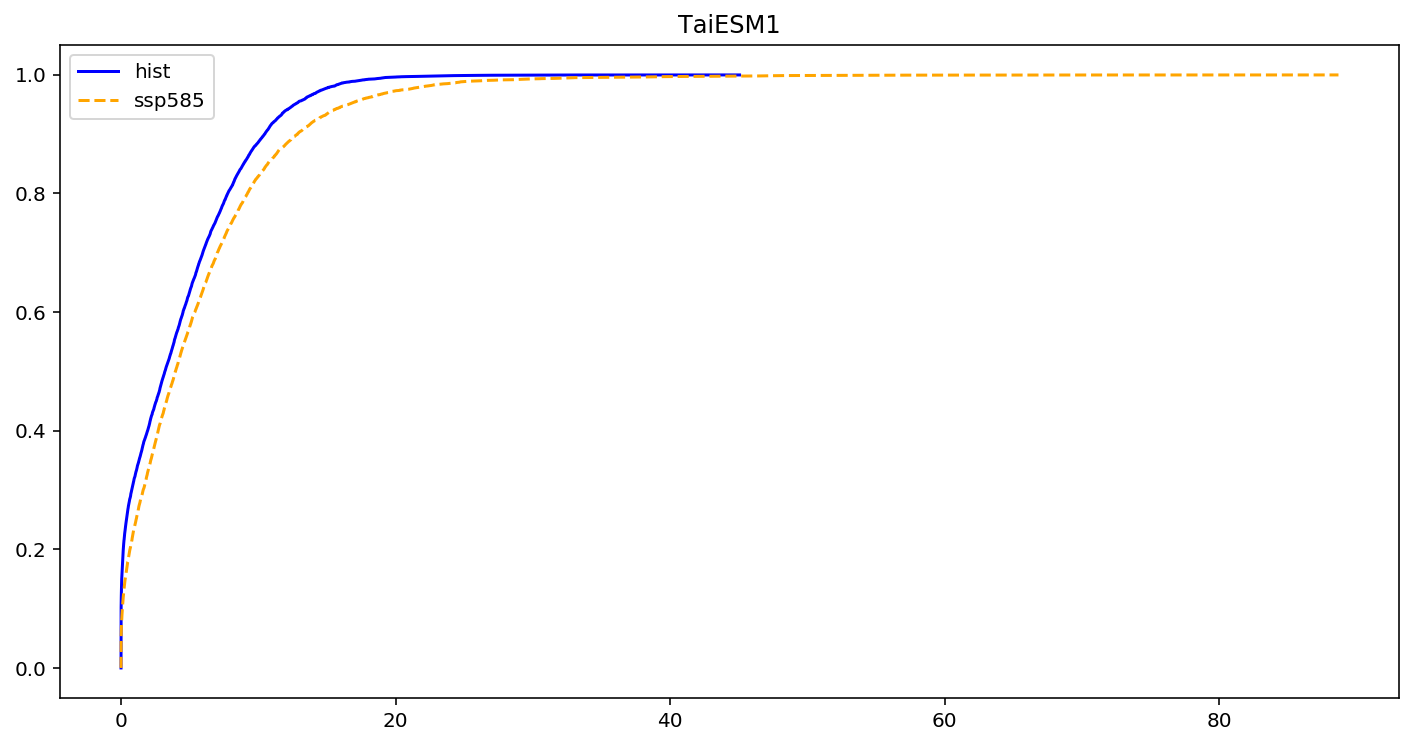

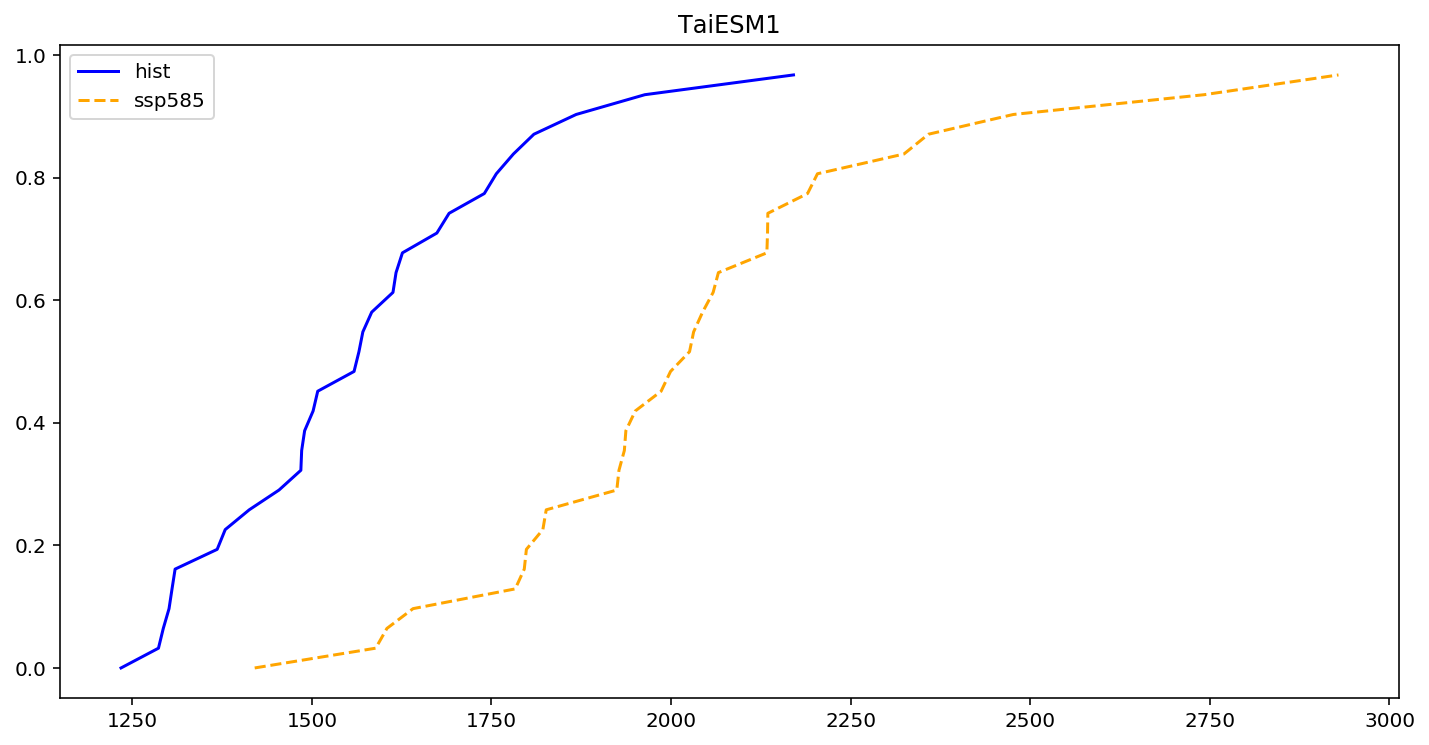

In [56]:
for (source_id, pr_hist), (source_id, pr_ssp) in zip(hist_results.items(), ssp_results.items()):   
    pr_ssp2 = pd.DataFrame({'date':pr_ssp.time, 'pr': pr_ssp.pr * 86400})
    pr_hist2 = pd.DataFrame({'date':pr_hist.time, 'pr': pr_hist.pr * 86400})
    
    if source_id != "HadGEM3-GC31-LL":
        if source_id != "HadGEM3-GC31-MM":
            if source_id != "KACE-1-0-G":
                if source_id != "UKESM1-0-LL":
                    if pr_ssp2.date.dtype == "datetime64[ns]":
                        pr_ssp2['date'] = pd.to_datetime(pr_ssp2['date'])
                        pr_hist2['date']= pd.to_datetime(pr_hist2['date'])
                    elif pr_ssp2.date.dtype == "object":
                        pr_ssp2['date'] =  pr_ssp2['date'].astype(str)
                        pr_ssp2['date'] = pd.to_datetime(pr_ssp2['date'])
                        
                        
                        pr_hist2['date'] =  pr_hist2['date'].astype(str)
                        pr_hist2['date'] = pd.to_datetime(pr_hist2['date'])

                    else:
                        print(pr_ssp2.date.dtype)
                        
                    ssp = pr_ssp2.groupby(pr_ssp2['date'].dt.year).sum()
                    hist = pr_hist2.groupby(pr_hist2['date'].dt.year).sum()
                    
                    cdf(pr_hist2.pr, "hist")
                    cdf(pr_ssp2.pr, "ssp585")
                    plt.legend()
                    plt.title(source_id)
                    plt.show()
                    
                    
                    cdf(hist.pr, "hist")
                    cdf(ssp.pr, "ssp585")
                    plt.legend()
                    plt.title(source_id)
                    plt.show()

In [53]:
def cdf(x, lab, plot=True, *args, **kwargs):
    x, y = sorted(x), np.arange(len(x)) / len(x)
    return plt.plot(x, y, label = lab, *args, **kwargs) if plot else (x, y)